In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.cluster import KMeans
#from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler
#from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from tqdm import tqdm

In [2]:
df = pd.read_csv("E:/me/my Projects/dataset/New folder/Customers.csv")

In [3]:
df.head()

,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,1,Male,19,15000,39,Healthcare,1,4
1,2,Male,21,35000,81,Engineer,3,3
2,3,Female,20,86000,6,Engineer,1,1
3,4,Female,23,59000,77,Lawyer,0,2
4,5,Female,31,38000,40,Entertainment,2,6


In [4]:
df.shape

(2000, 8)

In [5]:
df.isnull().sum()

CustomerID                 0
Gender                     0
Age                        0
Annual Income ($)          0
Spending Score (1-100)     0
Profession                35
Work Experience            0
Family Size                0
dtype: int64

In [6]:
df = df.dropna(subset=['Profession'])

In [7]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income ($)         0
Spending Score (1-100)    0
Profession                0
Work Experience           0
Family Size               0
dtype: int64

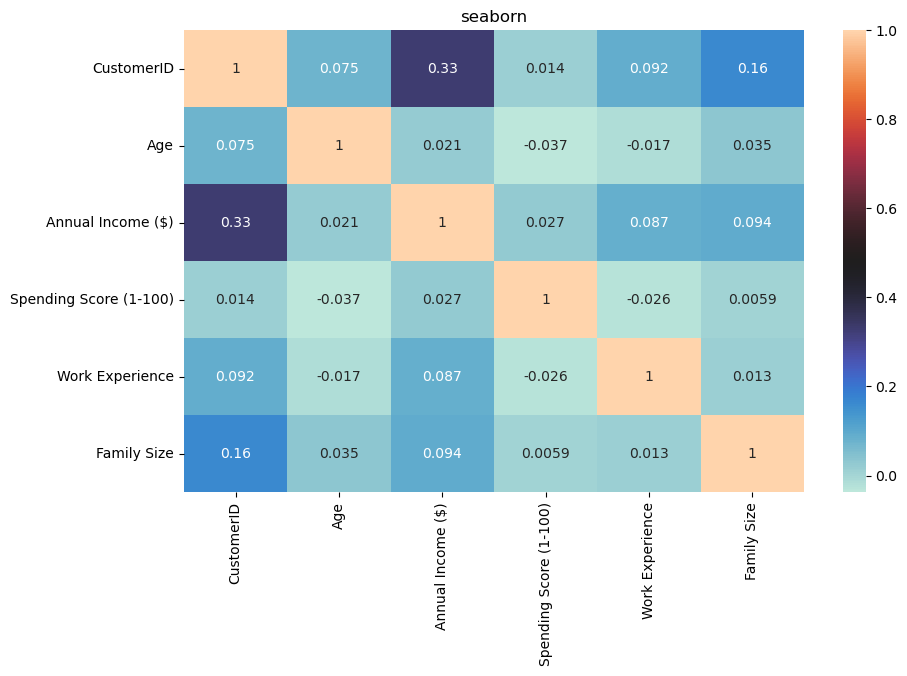

In [8]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='icefire').set_title('seaborn')
plt.show()

In [9]:
X = df[['Age', 'Annual Income ($)', 'Spending Score (1-100)']]
X.head()

,Age,Annual Income ($),Spending Score (1-100)
0,19,15000,39
1,21,35000,81
2,20,86000,6
3,23,59000,77
4,31,38000,40


In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)
X_scaled.head()

,Age,Annual Income ($),Spending Score (1-100)
0,-1.052345,-2.086675,-0.431850
1,-0.981941,-1.650205,1.069755
2,-1.017143,-0.537207,-1.611684
3,-0.911538,-1.126441,0.926745
4,-0.629924,-1.584734,-0.396098


Text(0.5, 1.0, 'Elbow Method')

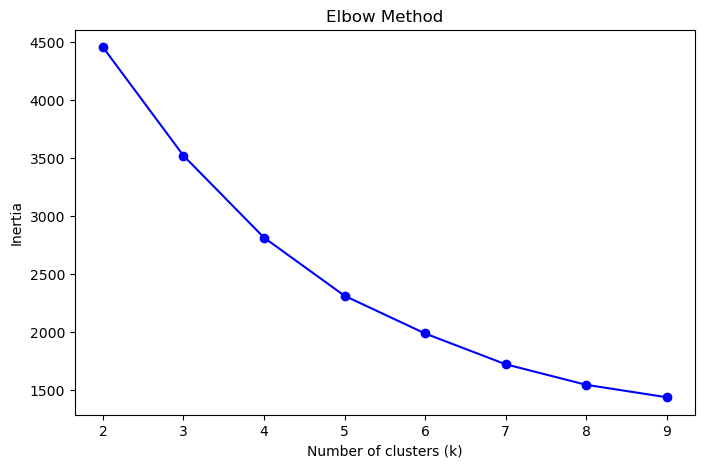

In [11]:
inertia = []
silhouette_scores = []
k_values = range(2, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k,init='k-means++',random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

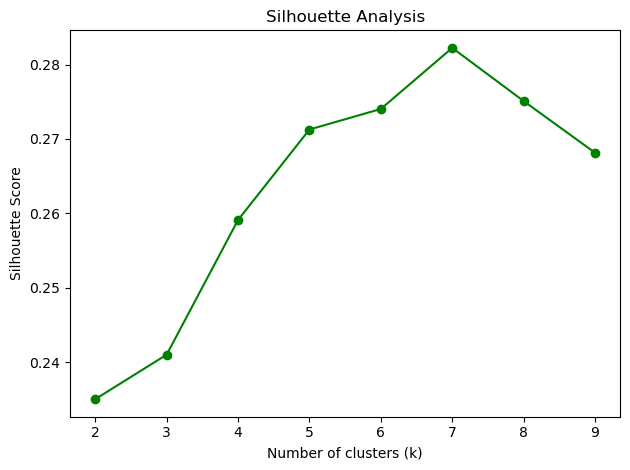

In [12]:
# Plot silhouette scores
plt.plot(k_values, silhouette_scores, 'go-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.tight_layout()
plt.show()

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2) 
X_scaled = pca.fit_transform(X_scaled)

In [15]:
optimal_k = 7

# Apply K-means with optimal k
kmeans = KMeans(n_clusters=optimal_k,init='k-means++', random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)
kmeans_centroids = kmeans.cluster_centers_

# Add cluster labels to the original dataframe
df['KMeans_Cluster'] = kmeans_labels

# Evaluate K-means performance
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
kmeans_db = davies_bouldin_score(X_scaled, kmeans_labels)
kmeans_ch = calinski_harabasz_score(X_scaled, kmeans_labels)

print("\nK-means Clustering Evaluation:")
print(f"Silhouette Score: {kmeans_silhouette:.4f}")
print(f"Davies-Bouldin Index: {kmeans_db:.4f}")
print(f"Calinski-Harabasz Index: {kmeans_ch:.4f}")


K-means Clustering Evaluation:
Silhouette Score: 0.3602
Davies-Bouldin Index: 0.7916
Calinski-Harabasz Index: 1530.1904


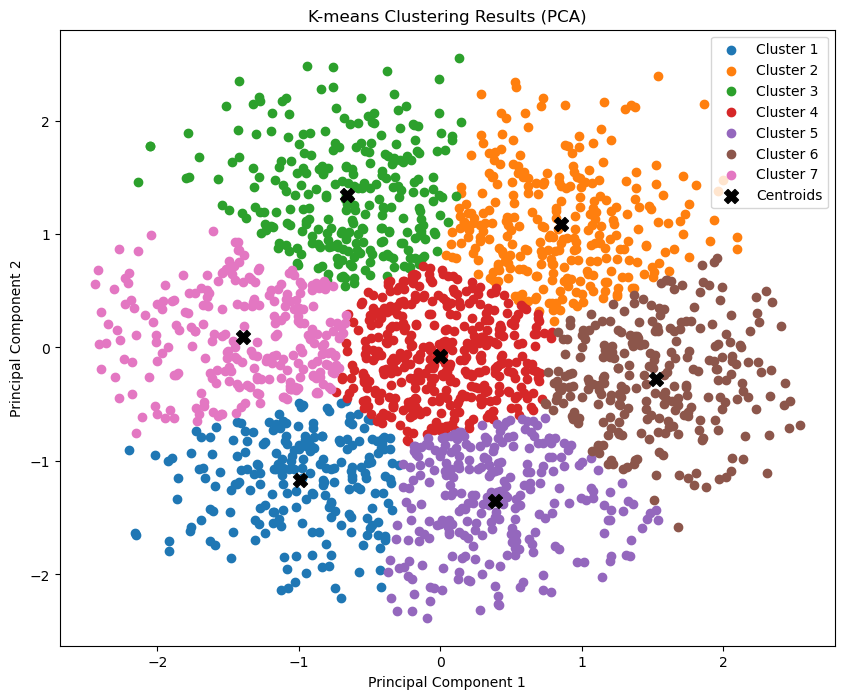

In [16]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
for i in range(optimal_k):
    plt.scatter(X_pca[kmeans_labels == i, 0], X_pca[kmeans_labels == i, 1], label=f'Cluster {i+1}')

# Plot centroids
centroids_pca = pca.transform(kmeans_centroids)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=100, c='black', marker='X', label='Centroids')

plt.title('K-means Clustering Results (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()
plt.close()


In [19]:
def assign_clusters(X, centroids):
    """Assign each data point to the closest centroid"""
    distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
    return np.argmin(distances, axis=0)

def calculate_fitness(X, centroids, labels=None):
    """Calculate clustering fitness (lower is better) - we use within-cluster sum of squares"""
    if labels is None:
        labels = assign_clusters(X, centroids)
    
    distances = 0
    for i in range(len(centroids)):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:  # Avoid empty clusters
            distances += np.sum((cluster_points - centroids[i])**2)
    
    return distances

def evaluate_clustering(X, labels, method_name):
    """Evaluate clustering using multiple metrics"""
    sil_score = silhouette_score(X, labels)
    db_score = davies_bouldin_score(X, labels)
    ch_score = calinski_harabasz_score(X, labels)
    
    print(f"\n{method_name} Clustering Evaluation:")
    print(f"Silhouette Score: {sil_score:.4f}")
    print(f"Davies-Bouldin Index: {db_score:.4f}")
    print(f"Calinski-Harabasz Index: {ch_score:.4f}")
    
    return {
        'method': method_name,
        'silhouette': sil_score,
        'davies_bouldin': db_score,
        'calinski_harabasz': ch_score
    }

def visualize_clusters(X, labels, centroids, method_name):
    """Visualize clustering results"""
    # Visualize using PCA for high dimensions
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    plt.figure(figsize=(10, 8))
    
    for i in range(np.max(labels) + 1):
        plt.scatter(X_pca[labels == i, 0], X_pca[labels == i, 1], label=f'Cluster {i+1}')
    
    # Transform centroids with PCA
    centroids_pca = pca.transform(centroids)
    plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=100, c='black', marker='X', label='Centroids')
    
    plt.title(f'{method_name} Clustering Results (PCA)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    # plt.savefig(f'{method_name.lower().replace(" ", "_")}_clusters_pca.png')
    plt.show()
    plt.close()
    return labels

# Store results for comparison
results = []

# Add K-means results
results.append({
    'method': 'K-means',
    'silhouette': kmeans_silhouette,
    'davies_bouldin': kmeans_db,
    'calinski_harabasz': kmeans_ch
})

In [21]:
# 3.4 ANT COLONY OPTIMIZATION (ACO) FOR CLUSTERING
# --------------------------------------------

def aco_clustering(X, n_clusters, n_ants=30, n_iterations=100, alpha=1.0, beta=2.0, evaporation_rate=0.5):
    """Ant Colony Optimization for clustering"""
    # Data dimensions
    n_samples, n_features = X.shape
    X_min = np.min(X, axis=0)
    X_max = np.max(X, axis=0)
    
    # Initialize pheromone matrix and heuristic information
    # We'll create a grid in the feature space and use pheromones to guide centroid placement
    grid_size = 10  # Number of grid points per dimension
    
    # Create grid points
    grid_points = []
    for f in range(n_features):
        points = np.linspace(X_min[f], X_max[f], grid_size)
        grid_points.append(points)
    
    # Initialize pheromone matrix (higher value = more desirable location for centroids)
    pheromone = np.ones([grid_size] * n_features)
    
    # Initialize heuristic information (we'll use data density)
    heuristic = np.ones([grid_size] * n_features)
    
    # Calculate data density for heuristic
    # For simplicity, we'll just count nearby points
    for point in X:
        # Find closest grid point
        grid_idx = []
        for f in range(n_features):
            idx = np.argmin(np.abs(grid_points[f] - point[f]))
            grid_idx.append(idx)
        
        # Increment density counter
        heuristic[tuple(grid_idx)] += 1
    
    # Normalize heuristic
    heuristic = heuristic / np.sum(heuristic)
    
    best_centroids = None
    best_fitness = float('inf')
    
    # ACO loop
    for iteration in tqdm(range(n_iterations), desc="ACO Progress"):
        all_centroids = []
        all_fitness = []
        
        # Each ant constructs a solution
        for ant in range(n_ants):
            # Select grid points for centroids based on pheromone and heuristic
            centroids = []
            for _ in range(n_clusters):
                # Calculate selection probability
                prob = (pheromone ** alpha) * (heuristic ** beta)
                prob = prob / np.sum(prob)
                
                # Flatten for random choice
                flat_prob = prob.flatten()
                choice = np.random.choice(len(flat_prob), p=flat_prob)
                
                # Convert back to multi-dimensional index
                idx = np.unravel_index(choice, prob.shape)
                
                # Get actual centroid coordinates
                centroid = np.array([grid_points[f][idx[f]] for f in range(n_features)])
                centroids.append(centroid)
            
            centroids = np.array(centroids)
            
            # Evaluate solution
            fitness = calculate_fitness(X, centroids)
            all_centroids.append(centroids)
            all_fitness.append(fitness)
            
            # Update best solution
            if fitness < best_fitness:
                best_fitness = fitness
                best_centroids = centroids.copy()
        
        # Update pheromones (evaporation)
        pheromone = (1 - evaporation_rate) * pheromone
        
        # Add new pheromones based on solution quality
        for ant in range(n_ants):
            # Amount of pheromone to deposit is inversely proportional to fitness
            deposit = 1.0 / (all_fitness[ant] + 1e-10)
            
            # For each centroid, deposit pheromone at nearest grid point
            for centroid in all_centroids[ant]:
                grid_idx = []
                for f in range(n_features):
                    idx = np.argmin(np.abs(grid_points[f] - centroid[f]))
                    grid_idx.append(idx)
                
                pheromone[tuple(grid_idx)] += deposit
    
    # Final assignment
    final_labels = assign_clusters(X, best_centroids)
    
    return best_centroids, final_labels


In [29]:
from sklearn.metrics import silhouette_score
import itertools

def grid_search_aco(X, k, param_grid, n_iterations=100):
    best_score = -1
    best_params = None
    best_centroids = None
    best_labels = None
    
    combinations = list(itertools.product(
        param_grid['n_ants'],
        param_grid['alpha'],
        param_grid['beta'],
        param_grid['evaporation_rate']
    ))
    
    print(f"Total combinations to try: {len(combinations)}\n")
    
    for i, (n_ants, alpha, beta, evap) in enumerate(combinations):
        print(f"Trying combination {i+1}/{len(combinations)}: "
              f"n_ants={n_ants}, alpha={alpha}, beta={beta}, evap={evap}")
        
        centroids, labels = aco_clustering(
            X, k,
            n_ants=n_ants,
            n_iterations=n_iterations,
            alpha=alpha,
            beta=beta,
            evaporation_rate=evap
        )
        
        score = silhouette_score(X, labels)
        print(f"→ Silhouette Score: {score:.4f}\n")
        
        if score > best_score:
            best_score = score
            best_params = {
                'n_ants': n_ants,
                'alpha': alpha,
                'beta': beta,
                'evaporation_rate': evap
            }
            best_centroids = centroids
            best_labels = labels
    
    print(" Best Parameters Found:")
    print(best_params)
    print(f"Best Silhouette Score: {best_score:.4f}")
    
    return best_centroids, best_labels, best_params


In [31]:
param_grid = {
    'n_ants': [20,40,60,80,100],
    'alpha': [0.5, 1.0, 2.0,3.0],
    'beta': [1.0, 2.0, 3.0],
    'evaporation_rate': [0.3, 0.5, 0.7,1.0]
}

In [35]:
best_centroids, best_labels, best_params = grid_search_aco(
    X_scaled,
    optimal_k,
    param_grid,
    n_iterations=100 
)

best_results = evaluate_clustering(X_scaled, best_labels, "Best ACO")
results.append(best_results) 

Total combinations to try: 240

Trying combination 1/240: n_ants=20, alpha=0.5, beta=1.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:04<00:00, 24.63it/s]


→ Silhouette Score: 0.3384

Trying combination 2/240: n_ants=20, alpha=0.5, beta=1.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:03<00:00, 25.49it/s]


→ Silhouette Score: 0.3236

Trying combination 3/240: n_ants=20, alpha=0.5, beta=1.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:03<00:00, 26.18it/s]


→ Silhouette Score: 0.3077

Trying combination 4/240: n_ants=20, alpha=0.5, beta=1.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:04<00:00, 23.10it/s]


→ Silhouette Score: 0.2950

Trying combination 5/240: n_ants=20, alpha=0.5, beta=2.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:03<00:00, 25.42it/s]


→ Silhouette Score: 0.3392

Trying combination 6/240: n_ants=20, alpha=0.5, beta=2.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:03<00:00, 25.82it/s]


→ Silhouette Score: 0.2810

Trying combination 7/240: n_ants=20, alpha=0.5, beta=2.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:03<00:00, 28.48it/s]


→ Silhouette Score: 0.2986

Trying combination 8/240: n_ants=20, alpha=0.5, beta=2.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:03<00:00, 26.87it/s]


→ Silhouette Score: 0.2875

Trying combination 9/240: n_ants=20, alpha=0.5, beta=3.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


→ Silhouette Score: 0.2644

Trying combination 10/240: n_ants=20, alpha=0.5, beta=3.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:03<00:00, 27.16it/s]


→ Silhouette Score: 0.3132

Trying combination 11/240: n_ants=20, alpha=0.5, beta=3.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:03<00:00, 28.71it/s]


→ Silhouette Score: 0.3128

Trying combination 12/240: n_ants=20, alpha=0.5, beta=3.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:03<00:00, 25.26it/s]


→ Silhouette Score: 0.2694

Trying combination 13/240: n_ants=20, alpha=1.0, beta=1.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:03<00:00, 31.47it/s]


→ Silhouette Score: 0.3262

Trying combination 14/240: n_ants=20, alpha=1.0, beta=1.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:03<00:00, 32.06it/s]


→ Silhouette Score: 0.2774

Trying combination 15/240: n_ants=20, alpha=1.0, beta=1.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:03<00:00, 30.31it/s]


→ Silhouette Score: 0.2966

Trying combination 16/240: n_ants=20, alpha=1.0, beta=1.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:02<00:00, 33.75it/s]


→ Silhouette Score: 0.2725

Trying combination 17/240: n_ants=20, alpha=1.0, beta=2.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:03<00:00, 32.47it/s]


→ Silhouette Score: 0.2957

Trying combination 18/240: n_ants=20, alpha=1.0, beta=2.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:03<00:00, 31.18it/s]


→ Silhouette Score: 0.2905

Trying combination 19/240: n_ants=20, alpha=1.0, beta=2.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:02<00:00, 33.79it/s]


→ Silhouette Score: 0.3090

Trying combination 20/240: n_ants=20, alpha=1.0, beta=2.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:03<00:00, 30.03it/s]


→ Silhouette Score: 0.2463

Trying combination 21/240: n_ants=20, alpha=1.0, beta=3.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:03<00:00, 29.04it/s]


→ Silhouette Score: 0.3047

Trying combination 22/240: n_ants=20, alpha=1.0, beta=3.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:03<00:00, 31.60it/s]


→ Silhouette Score: 0.2822

Trying combination 23/240: n_ants=20, alpha=1.0, beta=3.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:02<00:00, 35.29it/s]


→ Silhouette Score: 0.2621

Trying combination 24/240: n_ants=20, alpha=1.0, beta=3.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:02<00:00, 38.94it/s]


→ Silhouette Score: 0.2919

Trying combination 25/240: n_ants=20, alpha=2.0, beta=1.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:03<00:00, 31.45it/s]


→ Silhouette Score: 0.3153

Trying combination 26/240: n_ants=20, alpha=2.0, beta=1.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:03<00:00, 27.12it/s]


→ Silhouette Score: 0.2758

Trying combination 27/240: n_ants=20, alpha=2.0, beta=1.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:03<00:00, 29.42it/s]


→ Silhouette Score: 0.2872

Trying combination 28/240: n_ants=20, alpha=2.0, beta=1.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:03<00:00, 29.32it/s]


→ Silhouette Score: 0.3187

Trying combination 29/240: n_ants=20, alpha=2.0, beta=2.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:03<00:00, 31.32it/s]


→ Silhouette Score: 0.3019

Trying combination 30/240: n_ants=20, alpha=2.0, beta=2.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:04<00:00, 22.96it/s]


→ Silhouette Score: 0.2985

Trying combination 31/240: n_ants=20, alpha=2.0, beta=2.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:03<00:00, 27.57it/s]


→ Silhouette Score: 0.2518

Trying combination 32/240: n_ants=20, alpha=2.0, beta=2.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:03<00:00, 26.76it/s]


→ Silhouette Score: 0.2714

Trying combination 33/240: n_ants=20, alpha=2.0, beta=3.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:04<00:00, 24.40it/s]


→ Silhouette Score: 0.2728

Trying combination 34/240: n_ants=20, alpha=2.0, beta=3.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:03<00:00, 28.13it/s]


→ Silhouette Score: 0.2743

Trying combination 35/240: n_ants=20, alpha=2.0, beta=3.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:03<00:00, 30.63it/s]


→ Silhouette Score: 0.3229

Trying combination 36/240: n_ants=20, alpha=2.0, beta=3.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:03<00:00, 29.12it/s]


→ Silhouette Score: 0.2809

Trying combination 37/240: n_ants=20, alpha=3.0, beta=1.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:03<00:00, 28.82it/s]


→ Silhouette Score: 0.2794

Trying combination 38/240: n_ants=20, alpha=3.0, beta=1.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:03<00:00, 28.71it/s]


→ Silhouette Score: 0.2879

Trying combination 39/240: n_ants=20, alpha=3.0, beta=1.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:03<00:00, 25.84it/s]


→ Silhouette Score: 0.2794

Trying combination 40/240: n_ants=20, alpha=3.0, beta=1.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:03<00:00, 31.52it/s]


→ Silhouette Score: 0.3026

Trying combination 41/240: n_ants=20, alpha=3.0, beta=2.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:03<00:00, 27.71it/s]


→ Silhouette Score: 0.2774

Trying combination 42/240: n_ants=20, alpha=3.0, beta=2.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:03<00:00, 27.93it/s]


→ Silhouette Score: 0.3059

Trying combination 43/240: n_ants=20, alpha=3.0, beta=2.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:03<00:00, 27.63it/s]


→ Silhouette Score: 0.3037

Trying combination 44/240: n_ants=20, alpha=3.0, beta=2.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:02<00:00, 34.40it/s]


→ Silhouette Score: 0.3020

Trying combination 45/240: n_ants=20, alpha=3.0, beta=3.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:03<00:00, 29.26it/s]


→ Silhouette Score: 0.2470

Trying combination 46/240: n_ants=20, alpha=3.0, beta=3.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


→ Silhouette Score: 0.2958

Trying combination 47/240: n_ants=20, alpha=3.0, beta=3.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:03<00:00, 25.82it/s]


→ Silhouette Score: 0.2999

Trying combination 48/240: n_ants=20, alpha=3.0, beta=3.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:03<00:00, 31.38it/s]


→ Silhouette Score: 0.2752

Trying combination 49/240: n_ants=40, alpha=0.5, beta=1.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.15it/s]


→ Silhouette Score: 0.3130

Trying combination 50/240: n_ants=40, alpha=0.5, beta=1.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:08<00:00, 12.24it/s]


→ Silhouette Score: 0.3066

Trying combination 51/240: n_ants=40, alpha=0.5, beta=1.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:08<00:00, 12.27it/s]


→ Silhouette Score: 0.3259

Trying combination 52/240: n_ants=40, alpha=0.5, beta=1.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:08<00:00, 12.02it/s]


→ Silhouette Score: 0.3067

Trying combination 53/240: n_ants=40, alpha=0.5, beta=2.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:07<00:00, 14.08it/s]


→ Silhouette Score: 0.3265

Trying combination 54/240: n_ants=40, alpha=0.5, beta=2.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:06<00:00, 14.68it/s]


→ Silhouette Score: 0.3218

Trying combination 55/240: n_ants=40, alpha=0.5, beta=2.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:07<00:00, 14.22it/s]


→ Silhouette Score: 0.3263

Trying combination 56/240: n_ants=40, alpha=0.5, beta=2.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:06<00:00, 14.93it/s]


→ Silhouette Score: 0.2748

Trying combination 57/240: n_ants=40, alpha=0.5, beta=3.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:07<00:00, 12.76it/s]


→ Silhouette Score: 0.2858

Trying combination 58/240: n_ants=40, alpha=0.5, beta=3.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.25it/s]


→ Silhouette Score: 0.2737

Trying combination 59/240: n_ants=40, alpha=0.5, beta=3.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.82it/s]


→ Silhouette Score: 0.2828

Trying combination 60/240: n_ants=40, alpha=0.5, beta=3.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.07it/s]


→ Silhouette Score: 0.2613

Trying combination 61/240: n_ants=40, alpha=1.0, beta=1.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:08<00:00, 12.17it/s]


→ Silhouette Score: 0.2875

Trying combination 62/240: n_ants=40, alpha=1.0, beta=1.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:07<00:00, 12.99it/s]


→ Silhouette Score: 0.3081

Trying combination 63/240: n_ants=40, alpha=1.0, beta=1.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.38it/s]


→ Silhouette Score: 0.3246

Trying combination 64/240: n_ants=40, alpha=1.0, beta=1.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.07it/s]


→ Silhouette Score: 0.2990

Trying combination 65/240: n_ants=40, alpha=1.0, beta=2.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:06<00:00, 16.21it/s]


→ Silhouette Score: 0.2963

Trying combination 66/240: n_ants=40, alpha=1.0, beta=2.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:05<00:00, 16.72it/s]


→ Silhouette Score: 0.2799

Trying combination 67/240: n_ants=40, alpha=1.0, beta=2.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:05<00:00, 16.94it/s]


→ Silhouette Score: 0.2918

Trying combination 68/240: n_ants=40, alpha=1.0, beta=2.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:06<00:00, 16.14it/s]


→ Silhouette Score: 0.3081

Trying combination 69/240: n_ants=40, alpha=1.0, beta=3.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:05<00:00, 16.95it/s]


→ Silhouette Score: 0.2615

Trying combination 70/240: n_ants=40, alpha=1.0, beta=3.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.58it/s]


→ Silhouette Score: 0.2518

Trying combination 71/240: n_ants=40, alpha=1.0, beta=3.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.28it/s]


→ Silhouette Score: 0.2871

Trying combination 72/240: n_ants=40, alpha=1.0, beta=3.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.16it/s]


→ Silhouette Score: 0.2128

Trying combination 73/240: n_ants=40, alpha=2.0, beta=1.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.57it/s]


→ Silhouette Score: 0.3179

Trying combination 74/240: n_ants=40, alpha=2.0, beta=1.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.62it/s]


→ Silhouette Score: 0.2788

Trying combination 75/240: n_ants=40, alpha=2.0, beta=1.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:06<00:00, 15.47it/s]


→ Silhouette Score: 0.2690

Trying combination 76/240: n_ants=40, alpha=2.0, beta=1.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.15it/s]


→ Silhouette Score: 0.3195

Trying combination 77/240: n_ants=40, alpha=2.0, beta=2.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.44it/s]


→ Silhouette Score: 0.2845

Trying combination 78/240: n_ants=40, alpha=2.0, beta=2.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.14it/s]


→ Silhouette Score: 0.3191

Trying combination 79/240: n_ants=40, alpha=2.0, beta=2.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.94it/s]


→ Silhouette Score: 0.2894

Trying combination 80/240: n_ants=40, alpha=2.0, beta=2.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.68it/s]


→ Silhouette Score: 0.3098

Trying combination 81/240: n_ants=40, alpha=2.0, beta=3.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:06<00:00, 16.18it/s]


→ Silhouette Score: 0.2925

Trying combination 82/240: n_ants=40, alpha=2.0, beta=3.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:06<00:00, 15.67it/s]


→ Silhouette Score: 0.2645

Trying combination 83/240: n_ants=40, alpha=2.0, beta=3.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:06<00:00, 15.61it/s]


→ Silhouette Score: 0.2583

Trying combination 84/240: n_ants=40, alpha=2.0, beta=3.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:06<00:00, 14.87it/s]


→ Silhouette Score: 0.2930

Trying combination 85/240: n_ants=40, alpha=3.0, beta=1.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.43it/s]


→ Silhouette Score: 0.3137

Trying combination 86/240: n_ants=40, alpha=3.0, beta=1.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:07<00:00, 12.76it/s]


→ Silhouette Score: 0.2971

Trying combination 87/240: n_ants=40, alpha=3.0, beta=1.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.38it/s]


→ Silhouette Score: 0.3131

Trying combination 88/240: n_ants=40, alpha=3.0, beta=1.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:05<00:00, 16.85it/s]


→ Silhouette Score: 0.2945

Trying combination 89/240: n_ants=40, alpha=3.0, beta=2.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:06<00:00, 16.01it/s]


→ Silhouette Score: 0.3025

Trying combination 90/240: n_ants=40, alpha=3.0, beta=2.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:06<00:00, 16.49it/s]


→ Silhouette Score: 0.2974

Trying combination 91/240: n_ants=40, alpha=3.0, beta=2.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:06<00:00, 15.45it/s]


→ Silhouette Score: 0.3119

Trying combination 92/240: n_ants=40, alpha=3.0, beta=2.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:06<00:00, 16.01it/s]


→ Silhouette Score: 0.2749

Trying combination 93/240: n_ants=40, alpha=3.0, beta=3.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:06<00:00, 14.69it/s]


→ Silhouette Score: 0.2885

Trying combination 94/240: n_ants=40, alpha=3.0, beta=3.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:06<00:00, 16.00it/s]


→ Silhouette Score: 0.2739

Trying combination 95/240: n_ants=40, alpha=3.0, beta=3.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:06<00:00, 15.42it/s]


→ Silhouette Score: 0.2507

Trying combination 96/240: n_ants=40, alpha=3.0, beta=3.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:06<00:00, 15.13it/s]


→ Silhouette Score: 0.2823

Trying combination 97/240: n_ants=60, alpha=0.5, beta=1.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:11<00:00,  8.47it/s]


→ Silhouette Score: 0.3204

Trying combination 98/240: n_ants=60, alpha=0.5, beta=1.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:11<00:00,  8.59it/s]


→ Silhouette Score: 0.3423

Trying combination 99/240: n_ants=60, alpha=0.5, beta=1.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:10<00:00,  9.85it/s]


→ Silhouette Score: 0.2996

Trying combination 100/240: n_ants=60, alpha=0.5, beta=1.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.62it/s]


→ Silhouette Score: 0.3276

Trying combination 101/240: n_ants=60, alpha=0.5, beta=2.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.08it/s]


→ Silhouette Score: 0.3252

Trying combination 102/240: n_ants=60, alpha=0.5, beta=2.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.66it/s]


→ Silhouette Score: 0.3023

Trying combination 103/240: n_ants=60, alpha=0.5, beta=2.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:10<00:00,  9.95it/s]


→ Silhouette Score: 0.2951

Trying combination 104/240: n_ants=60, alpha=0.5, beta=2.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:10<00:00,  9.97it/s]


→ Silhouette Score: 0.3091

Trying combination 105/240: n_ants=60, alpha=0.5, beta=3.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.23it/s]


→ Silhouette Score: 0.2996

Trying combination 106/240: n_ants=60, alpha=0.5, beta=3.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:10<00:00,  9.19it/s]


→ Silhouette Score: 0.2639

Trying combination 107/240: n_ants=60, alpha=0.5, beta=3.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.29it/s]


→ Silhouette Score: 0.2840

Trying combination 108/240: n_ants=60, alpha=0.5, beta=3.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:10<00:00,  9.48it/s]


→ Silhouette Score: 0.2922

Trying combination 109/240: n_ants=60, alpha=1.0, beta=1.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.13it/s]


→ Silhouette Score: 0.3139

Trying combination 110/240: n_ants=60, alpha=1.0, beta=1.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:09<00:00, 11.10it/s]


→ Silhouette Score: 0.2820

Trying combination 111/240: n_ants=60, alpha=1.0, beta=1.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.49it/s]


→ Silhouette Score: 0.2623

Trying combination 112/240: n_ants=60, alpha=1.0, beta=1.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.90it/s]


→ Silhouette Score: 0.2950

Trying combination 113/240: n_ants=60, alpha=1.0, beta=2.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.97it/s]


→ Silhouette Score: 0.3324

Trying combination 114/240: n_ants=60, alpha=1.0, beta=2.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.61it/s]


→ Silhouette Score: 0.2889

Trying combination 115/240: n_ants=60, alpha=1.0, beta=2.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.73it/s]


→ Silhouette Score: 0.3182

Trying combination 116/240: n_ants=60, alpha=1.0, beta=2.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.61it/s]


→ Silhouette Score: 0.3198

Trying combination 117/240: n_ants=60, alpha=1.0, beta=3.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.19it/s]


→ Silhouette Score: 0.3084

Trying combination 118/240: n_ants=60, alpha=1.0, beta=3.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.62it/s]


→ Silhouette Score: 0.2891

Trying combination 119/240: n_ants=60, alpha=1.0, beta=3.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.23it/s]


→ Silhouette Score: 0.2978

Trying combination 120/240: n_ants=60, alpha=1.0, beta=3.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.33it/s]


→ Silhouette Score: 0.2769

Trying combination 121/240: n_ants=60, alpha=2.0, beta=1.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.22it/s]


→ Silhouette Score: 0.3075

Trying combination 122/240: n_ants=60, alpha=2.0, beta=1.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.28it/s]


→ Silhouette Score: 0.3135

Trying combination 123/240: n_ants=60, alpha=2.0, beta=1.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.51it/s]


→ Silhouette Score: 0.2898

Trying combination 124/240: n_ants=60, alpha=2.0, beta=1.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.54it/s]


→ Silhouette Score: 0.2688

Trying combination 125/240: n_ants=60, alpha=2.0, beta=2.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.90it/s]


→ Silhouette Score: 0.2915

Trying combination 126/240: n_ants=60, alpha=2.0, beta=2.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.90it/s]


→ Silhouette Score: 0.2780

Trying combination 127/240: n_ants=60, alpha=2.0, beta=2.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.57it/s]


→ Silhouette Score: 0.2866

Trying combination 128/240: n_ants=60, alpha=2.0, beta=2.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.60it/s]


→ Silhouette Score: 0.2769

Trying combination 129/240: n_ants=60, alpha=2.0, beta=3.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:08<00:00, 12.38it/s]


→ Silhouette Score: 0.2890

Trying combination 130/240: n_ants=60, alpha=2.0, beta=3.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:07<00:00, 12.82it/s]


→ Silhouette Score: 0.2791

Trying combination 131/240: n_ants=60, alpha=2.0, beta=3.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.96it/s]


→ Silhouette Score: 0.2465

Trying combination 132/240: n_ants=60, alpha=2.0, beta=3.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:07<00:00, 12.65it/s]


→ Silhouette Score: 0.2513

Trying combination 133/240: n_ants=60, alpha=3.0, beta=1.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.30it/s]


→ Silhouette Score: 0.3207

Trying combination 134/240: n_ants=60, alpha=3.0, beta=1.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:09<00:00, 11.00it/s]


→ Silhouette Score: 0.3122

Trying combination 135/240: n_ants=60, alpha=3.0, beta=1.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.04it/s]


→ Silhouette Score: 0.2961

Trying combination 136/240: n_ants=60, alpha=3.0, beta=1.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.73it/s]


→ Silhouette Score: 0.2871

Trying combination 137/240: n_ants=60, alpha=3.0, beta=2.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.74it/s]


→ Silhouette Score: 0.2972

Trying combination 138/240: n_ants=60, alpha=3.0, beta=2.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.25it/s]


→ Silhouette Score: 0.2940

Trying combination 139/240: n_ants=60, alpha=3.0, beta=2.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:08<00:00, 12.12it/s]


→ Silhouette Score: 0.2968

Trying combination 140/240: n_ants=60, alpha=3.0, beta=2.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.63it/s]


→ Silhouette Score: 0.2821

Trying combination 141/240: n_ants=60, alpha=3.0, beta=3.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:10<00:00,  9.84it/s]


→ Silhouette Score: 0.3012

Trying combination 142/240: n_ants=60, alpha=3.0, beta=3.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.13it/s]


→ Silhouette Score: 0.3075

Trying combination 143/240: n_ants=60, alpha=3.0, beta=3.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.39it/s]


→ Silhouette Score: 0.2676

Trying combination 144/240: n_ants=60, alpha=3.0, beta=3.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.88it/s]


→ Silhouette Score: 0.2595

Trying combination 145/240: n_ants=80, alpha=0.5, beta=1.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


→ Silhouette Score: 0.3122

Trying combination 146/240: n_ants=80, alpha=0.5, beta=1.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


→ Silhouette Score: 0.3214

Trying combination 147/240: n_ants=80, alpha=0.5, beta=1.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


→ Silhouette Score: 0.3149

Trying combination 148/240: n_ants=80, alpha=0.5, beta=1.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


→ Silhouette Score: 0.3443

Trying combination 149/240: n_ants=80, alpha=0.5, beta=2.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


→ Silhouette Score: 0.3056

Trying combination 150/240: n_ants=80, alpha=0.5, beta=2.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


→ Silhouette Score: 0.3300

Trying combination 151/240: n_ants=80, alpha=0.5, beta=2.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:13<00:00,  7.59it/s]


→ Silhouette Score: 0.3104

Trying combination 152/240: n_ants=80, alpha=0.5, beta=2.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:14<00:00,  7.07it/s]


→ Silhouette Score: 0.3166

Trying combination 153/240: n_ants=80, alpha=0.5, beta=3.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


→ Silhouette Score: 0.3129

Trying combination 154/240: n_ants=80, alpha=0.5, beta=3.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:13<00:00,  7.31it/s]


→ Silhouette Score: 0.2639

Trying combination 155/240: n_ants=80, alpha=0.5, beta=3.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


→ Silhouette Score: 0.2749

Trying combination 156/240: n_ants=80, alpha=0.5, beta=3.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:13<00:00,  7.23it/s]


→ Silhouette Score: 0.2766

Trying combination 157/240: n_ants=80, alpha=1.0, beta=1.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:10<00:00,  9.57it/s]


→ Silhouette Score: 0.3217

Trying combination 158/240: n_ants=80, alpha=1.0, beta=1.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:10<00:00,  9.21it/s]


→ Silhouette Score: 0.3025

Trying combination 159/240: n_ants=80, alpha=1.0, beta=1.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:10<00:00,  9.94it/s]


→ Silhouette Score: 0.3081

Trying combination 160/240: n_ants=80, alpha=1.0, beta=1.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:10<00:00,  9.76it/s]


→ Silhouette Score: 0.2773

Trying combination 161/240: n_ants=80, alpha=1.0, beta=2.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:11<00:00,  8.98it/s]


→ Silhouette Score: 0.3061

Trying combination 162/240: n_ants=80, alpha=1.0, beta=2.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:10<00:00,  9.61it/s]


→ Silhouette Score: 0.3384

Trying combination 163/240: n_ants=80, alpha=1.0, beta=2.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:10<00:00,  9.64it/s]


→ Silhouette Score: 0.3185

Trying combination 164/240: n_ants=80, alpha=1.0, beta=2.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:11<00:00,  9.09it/s]


→ Silhouette Score: 0.2725

Trying combination 165/240: n_ants=80, alpha=1.0, beta=3.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:11<00:00,  8.69it/s]


→ Silhouette Score: 0.3074

Trying combination 166/240: n_ants=80, alpha=1.0, beta=3.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:12<00:00,  8.25it/s]


→ Silhouette Score: 0.3001

Trying combination 167/240: n_ants=80, alpha=1.0, beta=3.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


→ Silhouette Score: 0.3098

Trying combination 168/240: n_ants=80, alpha=1.0, beta=3.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:12<00:00,  8.25it/s]


→ Silhouette Score: 0.2675

Trying combination 169/240: n_ants=80, alpha=2.0, beta=1.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.34it/s]


→ Silhouette Score: 0.2944

Trying combination 170/240: n_ants=80, alpha=2.0, beta=1.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:11<00:00,  8.94it/s]


→ Silhouette Score: 0.2932

Trying combination 171/240: n_ants=80, alpha=2.0, beta=1.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:11<00:00,  8.75it/s]


→ Silhouette Score: 0.2963

Trying combination 172/240: n_ants=80, alpha=2.0, beta=1.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:10<00:00,  9.63it/s]


→ Silhouette Score: 0.3107

Trying combination 173/240: n_ants=80, alpha=2.0, beta=2.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:11<00:00,  8.71it/s]


→ Silhouette Score: 0.3240

Trying combination 174/240: n_ants=80, alpha=2.0, beta=2.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


→ Silhouette Score: 0.2925

Trying combination 175/240: n_ants=80, alpha=2.0, beta=2.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:11<00:00,  8.92it/s]


→ Silhouette Score: 0.2878

Trying combination 176/240: n_ants=80, alpha=2.0, beta=2.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:11<00:00,  8.63it/s]


→ Silhouette Score: 0.2603

Trying combination 177/240: n_ants=80, alpha=2.0, beta=3.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:11<00:00,  8.64it/s]


→ Silhouette Score: 0.2784

Trying combination 178/240: n_ants=80, alpha=2.0, beta=3.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:12<00:00,  8.22it/s]


→ Silhouette Score: 0.3153

Trying combination 179/240: n_ants=80, alpha=2.0, beta=3.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:11<00:00,  9.07it/s]


→ Silhouette Score: 0.2785

Trying combination 180/240: n_ants=80, alpha=2.0, beta=3.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:11<00:00,  8.79it/s]


→ Silhouette Score: 0.2740

Trying combination 181/240: n_ants=80, alpha=3.0, beta=1.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:13<00:00,  7.55it/s]


→ Silhouette Score: 0.3176

Trying combination 182/240: n_ants=80, alpha=3.0, beta=1.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:16<00:00,  6.18it/s]


→ Silhouette Score: 0.3221

Trying combination 183/240: n_ants=80, alpha=3.0, beta=1.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:12<00:00,  8.02it/s]


→ Silhouette Score: 0.3153

Trying combination 184/240: n_ants=80, alpha=3.0, beta=1.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


→ Silhouette Score: 0.2680

Trying combination 185/240: n_ants=80, alpha=3.0, beta=2.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:11<00:00,  8.87it/s]


→ Silhouette Score: 0.3172

Trying combination 186/240: n_ants=80, alpha=3.0, beta=2.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


→ Silhouette Score: 0.3236

Trying combination 187/240: n_ants=80, alpha=3.0, beta=2.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:11<00:00,  8.85it/s]


→ Silhouette Score: 0.3142

Trying combination 188/240: n_ants=80, alpha=3.0, beta=2.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:12<00:00,  7.74it/s]


→ Silhouette Score: 0.2762

Trying combination 189/240: n_ants=80, alpha=3.0, beta=3.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:13<00:00,  7.63it/s]


→ Silhouette Score: 0.3023

Trying combination 190/240: n_ants=80, alpha=3.0, beta=3.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:13<00:00,  7.59it/s]


→ Silhouette Score: 0.2885

Trying combination 191/240: n_ants=80, alpha=3.0, beta=3.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:13<00:00,  7.37it/s]


→ Silhouette Score: 0.2688

Trying combination 192/240: n_ants=80, alpha=3.0, beta=3.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


→ Silhouette Score: 0.2888

Trying combination 193/240: n_ants=100, alpha=0.5, beta=1.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


→ Silhouette Score: 0.3121

Trying combination 194/240: n_ants=100, alpha=0.5, beta=1.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:16<00:00,  6.14it/s]


→ Silhouette Score: 0.3156

Trying combination 195/240: n_ants=100, alpha=0.5, beta=1.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:16<00:00,  6.22it/s]


→ Silhouette Score: 0.3235

Trying combination 196/240: n_ants=100, alpha=0.5, beta=1.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:17<00:00,  5.72it/s]


→ Silhouette Score: 0.3372

Trying combination 197/240: n_ants=100, alpha=0.5, beta=2.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


→ Silhouette Score: 0.3025

Trying combination 198/240: n_ants=100, alpha=0.5, beta=2.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:16<00:00,  6.02it/s]


→ Silhouette Score: 0.3207

Trying combination 199/240: n_ants=100, alpha=0.5, beta=2.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:16<00:00,  6.20it/s]


→ Silhouette Score: 0.3275

Trying combination 200/240: n_ants=100, alpha=0.5, beta=2.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:17<00:00,  5.71it/s]


→ Silhouette Score: 0.3233

Trying combination 201/240: n_ants=100, alpha=0.5, beta=3.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:17<00:00,  5.71it/s]


→ Silhouette Score: 0.3179

Trying combination 202/240: n_ants=100, alpha=0.5, beta=3.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


→ Silhouette Score: 0.3006

Trying combination 203/240: n_ants=100, alpha=0.5, beta=3.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:18<00:00,  5.52it/s]


→ Silhouette Score: 0.2702

Trying combination 204/240: n_ants=100, alpha=0.5, beta=3.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:16<00:00,  6.10it/s]


→ Silhouette Score: 0.2680

Trying combination 205/240: n_ants=100, alpha=1.0, beta=1.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:16<00:00,  6.14it/s]


→ Silhouette Score: 0.3156

Trying combination 206/240: n_ants=100, alpha=1.0, beta=1.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


→ Silhouette Score: 0.3228

Trying combination 207/240: n_ants=100, alpha=1.0, beta=1.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


→ Silhouette Score: 0.2984

Trying combination 208/240: n_ants=100, alpha=1.0, beta=1.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


→ Silhouette Score: 0.3373

Trying combination 209/240: n_ants=100, alpha=1.0, beta=2.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


→ Silhouette Score: 0.3319

Trying combination 210/240: n_ants=100, alpha=1.0, beta=2.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


→ Silhouette Score: 0.3051

Trying combination 211/240: n_ants=100, alpha=1.0, beta=2.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


→ Silhouette Score: 0.3102

Trying combination 212/240: n_ants=100, alpha=1.0, beta=2.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


→ Silhouette Score: 0.2910

Trying combination 213/240: n_ants=100, alpha=1.0, beta=3.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


→ Silhouette Score: 0.3163

Trying combination 214/240: n_ants=100, alpha=1.0, beta=3.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:13<00:00,  7.43it/s]


→ Silhouette Score: 0.3132

Trying combination 215/240: n_ants=100, alpha=1.0, beta=3.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.24it/s]


→ Silhouette Score: 0.2903

Trying combination 216/240: n_ants=100, alpha=1.0, beta=3.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.97it/s]


→ Silhouette Score: 0.2627

Trying combination 217/240: n_ants=100, alpha=2.0, beta=1.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:10<00:00,  9.85it/s]


→ Silhouette Score: 0.2799

Trying combination 218/240: n_ants=100, alpha=2.0, beta=1.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:12<00:00,  7.72it/s]


→ Silhouette Score: 0.3044

Trying combination 219/240: n_ants=100, alpha=2.0, beta=1.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:10<00:00,  9.25it/s]


→ Silhouette Score: 0.3202

Trying combination 220/240: n_ants=100, alpha=2.0, beta=1.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:13<00:00,  7.65it/s]


→ Silhouette Score: 0.3099

Trying combination 221/240: n_ants=100, alpha=2.0, beta=2.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:11<00:00,  8.98it/s]


→ Silhouette Score: 0.3124

Trying combination 222/240: n_ants=100, alpha=2.0, beta=2.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:10<00:00,  9.20it/s]


→ Silhouette Score: 0.2726

Trying combination 223/240: n_ants=100, alpha=2.0, beta=2.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.40it/s]


→ Silhouette Score: 0.2937

Trying combination 224/240: n_ants=100, alpha=2.0, beta=2.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.86it/s]


→ Silhouette Score: 0.3013

Trying combination 225/240: n_ants=100, alpha=2.0, beta=3.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.67it/s]


→ Silhouette Score: 0.2510

Trying combination 226/240: n_ants=100, alpha=2.0, beta=3.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.58it/s]


→ Silhouette Score: 0.2960

Trying combination 227/240: n_ants=100, alpha=2.0, beta=3.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:09<00:00, 11.05it/s]


→ Silhouette Score: 0.2856

Trying combination 228/240: n_ants=100, alpha=2.0, beta=3.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.23it/s]


→ Silhouette Score: 0.2843

Trying combination 229/240: n_ants=100, alpha=3.0, beta=1.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:10<00:00,  9.83it/s]


→ Silhouette Score: 0.3270

Trying combination 230/240: n_ants=100, alpha=3.0, beta=1.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.54it/s]


→ Silhouette Score: 0.2984

Trying combination 231/240: n_ants=100, alpha=3.0, beta=1.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.63it/s]


→ Silhouette Score: 0.2985

Trying combination 232/240: n_ants=100, alpha=3.0, beta=1.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.60it/s]


→ Silhouette Score: 0.2750

Trying combination 233/240: n_ants=100, alpha=3.0, beta=2.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.41it/s]


→ Silhouette Score: 0.2675

Trying combination 234/240: n_ants=100, alpha=3.0, beta=2.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.34it/s]


→ Silhouette Score: 0.3048

Trying combination 235/240: n_ants=100, alpha=3.0, beta=2.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.41it/s]


→ Silhouette Score: 0.2964

Trying combination 236/240: n_ants=100, alpha=3.0, beta=2.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.85it/s]


→ Silhouette Score: 0.3073

Trying combination 237/240: n_ants=100, alpha=3.0, beta=3.0, evap=0.3


ACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.37it/s]


→ Silhouette Score: 0.3325

Trying combination 238/240: n_ants=100, alpha=3.0, beta=3.0, evap=0.5


ACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.69it/s]


→ Silhouette Score: 0.2572

Trying combination 239/240: n_ants=100, alpha=3.0, beta=3.0, evap=0.7


ACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.85it/s]


→ Silhouette Score: 0.2931

Trying combination 240/240: n_ants=100, alpha=3.0, beta=3.0, evap=1.0


ACO Progress: 100%|██████████| 100/100 [00:09<00:00, 11.10it/s]


→ Silhouette Score: 0.2650

 Best Parameters Found:
{'n_ants': 80, 'alpha': 0.5, 'beta': 1.0, 'evaporation_rate': 1.0}
Best Silhouette Score: 0.3443

Best ACO Clustering Evaluation:
Silhouette Score: 0.3443
Davies-Bouldin Index: 0.8246
Calinski-Harabasz Index: 1459.3616



Best ACO Clustering Evaluation:
Silhouette Score: 0.3443
Davies-Bouldin Index: 0.8246
Calinski-Harabasz Index: 1459.3616


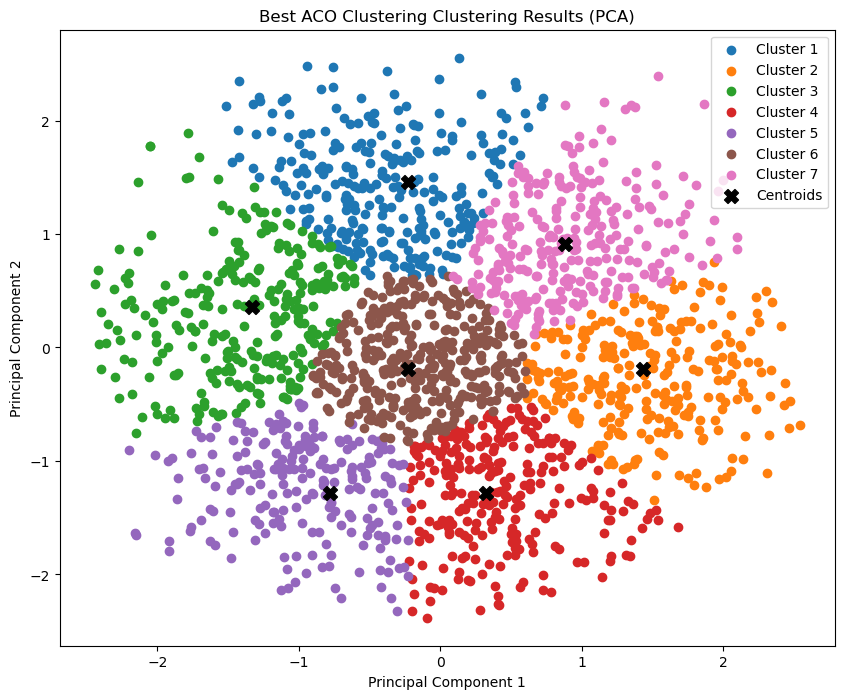

array([0, 6, 0, ..., 2, 4, 4], dtype=int64)

In [48]:
best_results = evaluate_clustering(X_scaled, best_labels, "Best ACO")
results.append(best_results) 
visualize_clusters(X_scaled, best_labels, best_centroids, "Best ACO Clustering")

In [52]:
def mmas_clustering(X, n_clusters, n_ants=30, n_iterations=100, alpha=1.0, beta=2.0, evaporation_rate=0.5, tau_min=0.1, tau_max=10.0):
    """Max-Min Ant System (MMAS) for clustering"""
    n_samples, n_features = X.shape
    X_min = np.min(X, axis=0)
    X_max = np.max(X, axis=0)

    # Grid setup
    grid_size = 10
    grid_points = [np.linspace(X_min[f], X_max[f], grid_size) for f in range(n_features)]

    # Initialize pheromone and heuristic
    pheromone = np.ones([grid_size] * n_features) * tau_max
    heuristic = np.ones([grid_size] * n_features)

    # Estimate heuristic (density of points)
    for point in X:
        grid_idx = [np.argmin(np.abs(grid_points[f] - point[f])) for f in range(n_features)]
        heuristic[tuple(grid_idx)] += 1
    heuristic = heuristic / np.sum(heuristic)

    best_centroids = None
    best_fitness = float('inf')

    for iteration in tqdm(range(n_iterations), desc="MMAS Progress"):
        all_centroids = []
        all_fitness = []

        for ant in range(n_ants):
            centroids = []
            for _ in range(n_clusters):
                prob = (pheromone ** alpha) * (heuristic ** beta)
                prob = prob / np.sum(prob)
                flat_prob = prob.flatten()
                choice = np.random.choice(len(flat_prob), p=flat_prob)
                idx = np.unravel_index(choice, prob.shape)
                centroid = np.array([grid_points[f][idx[f]] for f in range(n_features)])
                centroids.append(centroid)
            centroids = np.array(centroids)

            fitness = calculate_fitness(X, centroids)
            all_centroids.append(centroids)
            all_fitness.append(fitness)

            if fitness < best_fitness:
                best_fitness = fitness
                best_centroids = centroids.copy()

        # Evaporation
        pheromone = (1 - evaporation_rate) * pheromone

        # Limit pheromone values (min-max)
        pheromone = np.clip(pheromone, tau_min, tau_max)

        # Update pheromone only from best-so-far solution
        for centroid in best_centroids:
            grid_idx = [np.argmin(np.abs(grid_points[f] - centroid[f])) for f in range(n_features)]
            pheromone[tuple(grid_idx)] += 1.0 / (best_fitness + 1e-10)

        # Enforce min-max bounds again
        pheromone = np.clip(pheromone, tau_min, tau_max)

    final_labels = assign_clusters(X, best_centroids)
    return best_centroids, final_labels


In [54]:
from sklearn.metrics import silhouette_score
import itertools

def grid_search_mmas(X, k, param_grid, n_iterations=100):
    best_score = -1
    best_params = None
    best_centroids = None
    best_labels = None

    combinations = list(itertools.product(
        param_grid['n_ants'],
        param_grid['alpha'],
        param_grid['beta'],
        param_grid['evaporation_rate'],
        param_grid['tau_min'],
        param_grid['tau_max']
    ))

    print(f"Total combinations to try: {len(combinations)}\n")

    for i, (n_ants, alpha, beta, evap, tau_min, tau_max) in enumerate(combinations):
        print(f"Trying combination {i+1}/{len(combinations)}: "
              f"n_ants={n_ants}, alpha={alpha}, beta={beta}, evap={evap}, tau_min={tau_min}, tau_max={tau_max}")

        try:
            centroids, labels = mmas_clustering(
                X, k,
                n_ants=n_ants,
                n_iterations=n_iterations,
                alpha=alpha,
                beta=beta,
                evaporation_rate=evap,
                tau_min=tau_min,
                tau_max=tau_max
            )

            score = silhouette_score(X, labels)
            print(f"→ Silhouette Score: {score:.4f}\n")

            if score > best_score:
                best_score = score
                best_params = {
                    'n_ants': n_ants,
                    'alpha': alpha,
                    'beta': beta,
                    'evaporation_rate': evap,
                    'tau_min': tau_min,
                    'tau_max': tau_max
                }
                best_centroids = centroids
                best_labels = labels

        except Exception as e:
            print(f"⚠️ Skipped due to error: {e}\n")
            continue

    print("✅ Best Parameters Found:")
    print(best_params)
    print(f"Best Silhouette Score: {best_score:.4f}")

    return best_centroids, best_labels, best_params


In [56]:
param_grid = {
    'n_ants':[20,40,60,80,100],
    'alpha':[0.5, 1.0, 2.0,3.0],
    'beta':[1.0, 2.0, 3.0],
    'evaporation_rate':[0.3, 0.5, 0.7,1.0],
    'tau_min': [0.01, 0.05, 0.1],
    'tau_max': [2.0, 5.0, 10.0]

}


In [58]:
best_centroids, best_labels, best_params = grid_search_mmas(
    X_scaled,
    optimal_k,
    param_grid,
    n_iterations=100  # عدد التكرارات يمكن زيادته بعد تحديد الأفضل
)

Total combinations to try: 2160

Trying combination 1/2160: n_ants=20, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.96it/s]


→ Silhouette Score: 0.3322

Trying combination 2/2160: n_ants=20, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 63.26it/s]


→ Silhouette Score: 0.3179

Trying combination 3/2160: n_ants=20, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 61.00it/s]


→ Silhouette Score: 0.3183

Trying combination 4/2160: n_ants=20, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.20it/s]


→ Silhouette Score: 0.3266

Trying combination 5/2160: n_ants=20, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.76it/s]


→ Silhouette Score: 0.3079

Trying combination 6/2160: n_ants=20, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 63.54it/s]


→ Silhouette Score: 0.2890

Trying combination 7/2160: n_ants=20, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 61.19it/s]


→ Silhouette Score: 0.3064

Trying combination 8/2160: n_ants=20, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.30it/s]


→ Silhouette Score: 0.3252

Trying combination 9/2160: n_ants=20, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.42it/s]


→ Silhouette Score: 0.3213

Trying combination 10/2160: n_ants=20, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 60.53it/s]


→ Silhouette Score: 0.2887

Trying combination 11/2160: n_ants=20, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 61.86it/s]


→ Silhouette Score: 0.3256

Trying combination 12/2160: n_ants=20, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 62.18it/s]


→ Silhouette Score: 0.3135

Trying combination 13/2160: n_ants=20, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 62.77it/s]


→ Silhouette Score: 0.3188

Trying combination 14/2160: n_ants=20, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 61.51it/s]


→ Silhouette Score: 0.2760

Trying combination 15/2160: n_ants=20, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 60.24it/s]


→ Silhouette Score: 0.2993

Trying combination 16/2160: n_ants=20, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 60.89it/s]


→ Silhouette Score: 0.3002

Trying combination 17/2160: n_ants=20, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 60.37it/s]


→ Silhouette Score: 0.2909

Trying combination 18/2160: n_ants=20, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.66it/s]


→ Silhouette Score: 0.2999

Trying combination 19/2160: n_ants=20, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 60.50it/s]


→ Silhouette Score: 0.3114

Trying combination 20/2160: n_ants=20, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 52.55it/s]


→ Silhouette Score: 0.3069

Trying combination 21/2160: n_ants=20, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 51.50it/s]


→ Silhouette Score: 0.3157

Trying combination 22/2160: n_ants=20, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 50.03it/s]


→ Silhouette Score: 0.3093

Trying combination 23/2160: n_ants=20, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.84it/s]


→ Silhouette Score: 0.3139

Trying combination 24/2160: n_ants=20, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 61.32it/s]


→ Silhouette Score: 0.3014

Trying combination 25/2160: n_ants=20, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 51.71it/s]


→ Silhouette Score: 0.3054

Trying combination 26/2160: n_ants=20, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 50.32it/s]


→ Silhouette Score: 0.3287

Trying combination 27/2160: n_ants=20, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.61it/s]


→ Silhouette Score: 0.3014

Trying combination 28/2160: n_ants=20, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 51.76it/s]


→ Silhouette Score: 0.2860

Trying combination 29/2160: n_ants=20, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 50.24it/s]


→ Silhouette Score: 0.3166

Trying combination 30/2160: n_ants=20, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.22it/s]


→ Silhouette Score: 0.3170

Trying combination 31/2160: n_ants=20, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 47.62it/s]


→ Silhouette Score: 0.3092

Trying combination 32/2160: n_ants=20, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.19it/s]


→ Silhouette Score: 0.3078

Trying combination 33/2160: n_ants=20, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 53.74it/s]


→ Silhouette Score: 0.3256

Trying combination 34/2160: n_ants=20, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 54.69it/s]


→ Silhouette Score: 0.3175

Trying combination 35/2160: n_ants=20, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.57it/s]


→ Silhouette Score: 0.3339

Trying combination 36/2160: n_ants=20, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.00it/s]


→ Silhouette Score: 0.2973

Trying combination 37/2160: n_ants=20, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.87it/s]


→ Silhouette Score: 0.3293

Trying combination 38/2160: n_ants=20, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.18it/s]


→ Silhouette Score: 0.3107

Trying combination 39/2160: n_ants=20, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.18it/s]


→ Silhouette Score: 0.3115

Trying combination 40/2160: n_ants=20, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.85it/s]


→ Silhouette Score: 0.2959

Trying combination 41/2160: n_ants=20, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.14it/s]


→ Silhouette Score: 0.3235

Trying combination 42/2160: n_ants=20, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.81it/s]


→ Silhouette Score: 0.2854

Trying combination 43/2160: n_ants=20, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.62it/s]


→ Silhouette Score: 0.3107

Trying combination 44/2160: n_ants=20, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.15it/s]


→ Silhouette Score: 0.3202

Trying combination 45/2160: n_ants=20, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.29it/s]


→ Silhouette Score: 0.3087

Trying combination 46/2160: n_ants=20, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.67it/s]


→ Silhouette Score: 0.3031

Trying combination 47/2160: n_ants=20, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.98it/s]


→ Silhouette Score: 0.3383

Trying combination 48/2160: n_ants=20, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.35it/s]


→ Silhouette Score: 0.3098

Trying combination 49/2160: n_ants=20, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.75it/s]


→ Silhouette Score: 0.3096

Trying combination 50/2160: n_ants=20, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.16it/s]


→ Silhouette Score: 0.2924

Trying combination 51/2160: n_ants=20, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.58it/s]


→ Silhouette Score: 0.3251

Trying combination 52/2160: n_ants=20, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 52.94it/s]


→ Silhouette Score: 0.3105

Trying combination 53/2160: n_ants=20, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.38it/s]


→ Silhouette Score: 0.3140

Trying combination 54/2160: n_ants=20, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.74it/s]


→ Silhouette Score: 0.3203

Trying combination 55/2160: n_ants=20, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.62it/s]


→ Silhouette Score: 0.3199

Trying combination 56/2160: n_ants=20, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.79it/s]


→ Silhouette Score: 0.3494

Trying combination 57/2160: n_ants=20, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.12it/s]


→ Silhouette Score: 0.3201

Trying combination 58/2160: n_ants=20, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 49.73it/s]


→ Silhouette Score: 0.3041

Trying combination 59/2160: n_ants=20, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 50.63it/s]


→ Silhouette Score: 0.2978

Trying combination 60/2160: n_ants=20, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 52.14it/s]


→ Silhouette Score: 0.3342

Trying combination 61/2160: n_ants=20, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.35it/s]


→ Silhouette Score: 0.3001

Trying combination 62/2160: n_ants=20, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 53.57it/s]


→ Silhouette Score: 0.3252

Trying combination 63/2160: n_ants=20, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 52.25it/s]


→ Silhouette Score: 0.3080

Trying combination 64/2160: n_ants=20, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 52.39it/s]


→ Silhouette Score: 0.3044

Trying combination 65/2160: n_ants=20, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 52.77it/s]


→ Silhouette Score: 0.3234

Trying combination 66/2160: n_ants=20, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.11it/s]


→ Silhouette Score: 0.2960

Trying combination 67/2160: n_ants=20, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.02it/s]


→ Silhouette Score: 0.3057

Trying combination 68/2160: n_ants=20, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 51.74it/s]


→ Silhouette Score: 0.3276

Trying combination 69/2160: n_ants=20, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.40it/s]


→ Silhouette Score: 0.3075

Trying combination 70/2160: n_ants=20, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.84it/s]


→ Silhouette Score: 0.3080

Trying combination 71/2160: n_ants=20, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.98it/s]


→ Silhouette Score: 0.3091

Trying combination 72/2160: n_ants=20, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.18it/s]


→ Silhouette Score: 0.3251

Trying combination 73/2160: n_ants=20, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 52.20it/s]


→ Silhouette Score: 0.2823

Trying combination 74/2160: n_ants=20, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 53.48it/s]


→ Silhouette Score: 0.3182

Trying combination 75/2160: n_ants=20, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.59it/s]


→ Silhouette Score: 0.2956

Trying combination 76/2160: n_ants=20, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.25it/s]


→ Silhouette Score: 0.3028

Trying combination 77/2160: n_ants=20, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.07it/s]


→ Silhouette Score: 0.2925

Trying combination 78/2160: n_ants=20, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.21it/s]


→ Silhouette Score: 0.2994

Trying combination 79/2160: n_ants=20, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.45it/s]


→ Silhouette Score: 0.2987

Trying combination 80/2160: n_ants=20, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.02it/s]


→ Silhouette Score: 0.2951

Trying combination 81/2160: n_ants=20, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.90it/s]


→ Silhouette Score: 0.2892

Trying combination 82/2160: n_ants=20, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.98it/s]


→ Silhouette Score: 0.2901

Trying combination 83/2160: n_ants=20, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.75it/s]


→ Silhouette Score: 0.3049

Trying combination 84/2160: n_ants=20, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.27it/s]


→ Silhouette Score: 0.3119

Trying combination 85/2160: n_ants=20, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 49.86it/s]


→ Silhouette Score: 0.3109

Trying combination 86/2160: n_ants=20, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.83it/s]


→ Silhouette Score: 0.3019

Trying combination 87/2160: n_ants=20, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.31it/s]


→ Silhouette Score: 0.3147

Trying combination 88/2160: n_ants=20, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.18it/s]


→ Silhouette Score: 0.2941

Trying combination 89/2160: n_ants=20, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.02it/s]


→ Silhouette Score: 0.3448

Trying combination 90/2160: n_ants=20, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 54.10it/s]


→ Silhouette Score: 0.2920

Trying combination 91/2160: n_ants=20, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.52it/s]


→ Silhouette Score: 0.3151

Trying combination 92/2160: n_ants=20, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.68it/s]


→ Silhouette Score: 0.3061

Trying combination 93/2160: n_ants=20, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.05it/s]


→ Silhouette Score: 0.3176

Trying combination 94/2160: n_ants=20, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.26it/s]


→ Silhouette Score: 0.3114

Trying combination 95/2160: n_ants=20, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.41it/s]


→ Silhouette Score: 0.3135

Trying combination 96/2160: n_ants=20, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.04it/s]


→ Silhouette Score: 0.3087

Trying combination 97/2160: n_ants=20, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.08it/s]


→ Silhouette Score: 0.2911

Trying combination 98/2160: n_ants=20, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.94it/s]


→ Silhouette Score: 0.2898

Trying combination 99/2160: n_ants=20, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.33it/s]


→ Silhouette Score: 0.3001

Trying combination 100/2160: n_ants=20, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.90it/s]


→ Silhouette Score: 0.3147

Trying combination 101/2160: n_ants=20, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.26it/s]


→ Silhouette Score: 0.3068

Trying combination 102/2160: n_ants=20, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.64it/s]


→ Silhouette Score: 0.3016

Trying combination 103/2160: n_ants=20, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.09it/s]


→ Silhouette Score: 0.3101

Trying combination 104/2160: n_ants=20, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.93it/s]


→ Silhouette Score: 0.2913

Trying combination 105/2160: n_ants=20, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.69it/s]


→ Silhouette Score: 0.3080

Trying combination 106/2160: n_ants=20, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.37it/s]


→ Silhouette Score: 0.2947

Trying combination 107/2160: n_ants=20, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.66it/s]


→ Silhouette Score: 0.3118

Trying combination 108/2160: n_ants=20, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.76it/s]


→ Silhouette Score: 0.3336

Trying combination 109/2160: n_ants=20, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.29it/s]


→ Silhouette Score: 0.3223

Trying combination 110/2160: n_ants=20, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.58it/s]


→ Silhouette Score: 0.3014

Trying combination 111/2160: n_ants=20, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.21it/s]


→ Silhouette Score: 0.3069

Trying combination 112/2160: n_ants=20, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.80it/s]


→ Silhouette Score: 0.2924

Trying combination 113/2160: n_ants=20, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.44it/s]


→ Silhouette Score: 0.3139

Trying combination 114/2160: n_ants=20, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 60.08it/s]


→ Silhouette Score: 0.3344

Trying combination 115/2160: n_ants=20, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 60.32it/s]


→ Silhouette Score: 0.3181

Trying combination 116/2160: n_ants=20, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.57it/s]


→ Silhouette Score: 0.3188

Trying combination 117/2160: n_ants=20, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.53it/s]


→ Silhouette Score: 0.3202

Trying combination 118/2160: n_ants=20, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 60.04it/s]


→ Silhouette Score: 0.3404

Trying combination 119/2160: n_ants=20, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.48it/s]


→ Silhouette Score: 0.3069

Trying combination 120/2160: n_ants=20, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.92it/s]


→ Silhouette Score: 0.3159

Trying combination 121/2160: n_ants=20, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 60.10it/s]


→ Silhouette Score: 0.3267

Trying combination 122/2160: n_ants=20, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.76it/s]


→ Silhouette Score: 0.3269

Trying combination 123/2160: n_ants=20, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.29it/s]


→ Silhouette Score: 0.3387

Trying combination 124/2160: n_ants=20, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.03it/s]


→ Silhouette Score: 0.3090

Trying combination 125/2160: n_ants=20, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.33it/s]


→ Silhouette Score: 0.3081

Trying combination 126/2160: n_ants=20, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.44it/s]


→ Silhouette Score: 0.3158

Trying combination 127/2160: n_ants=20, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.46it/s]


→ Silhouette Score: 0.3019

Trying combination 128/2160: n_ants=20, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.16it/s]


→ Silhouette Score: 0.2912

Trying combination 129/2160: n_ants=20, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.18it/s]


→ Silhouette Score: 0.3049

Trying combination 130/2160: n_ants=20, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.69it/s]


→ Silhouette Score: 0.3099

Trying combination 131/2160: n_ants=20, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.24it/s]


→ Silhouette Score: 0.3155

Trying combination 132/2160: n_ants=20, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.74it/s]


→ Silhouette Score: 0.3107

Trying combination 133/2160: n_ants=20, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.33it/s]


→ Silhouette Score: 0.3039

Trying combination 134/2160: n_ants=20, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 60.01it/s]


→ Silhouette Score: 0.3432

Trying combination 135/2160: n_ants=20, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.52it/s]


→ Silhouette Score: 0.2851

Trying combination 136/2160: n_ants=20, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.95it/s]


→ Silhouette Score: 0.3206

Trying combination 137/2160: n_ants=20, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.58it/s]


→ Silhouette Score: 0.3296

Trying combination 138/2160: n_ants=20, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.16it/s]


→ Silhouette Score: 0.3392

Trying combination 139/2160: n_ants=20, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.46it/s]


→ Silhouette Score: 0.3107

Trying combination 140/2160: n_ants=20, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.78it/s]


→ Silhouette Score: 0.3205

Trying combination 141/2160: n_ants=20, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.43it/s]


→ Silhouette Score: 0.3033

Trying combination 142/2160: n_ants=20, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.99it/s]


→ Silhouette Score: 0.3131

Trying combination 143/2160: n_ants=20, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.86it/s]


→ Silhouette Score: 0.3099

Trying combination 144/2160: n_ants=20, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.38it/s]


→ Silhouette Score: 0.3024

Trying combination 145/2160: n_ants=20, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.78it/s]


→ Silhouette Score: 0.3086

Trying combination 146/2160: n_ants=20, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.24it/s]


→ Silhouette Score: 0.2751

Trying combination 147/2160: n_ants=20, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.85it/s]


→ Silhouette Score: 0.2983

Trying combination 148/2160: n_ants=20, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.89it/s]


→ Silhouette Score: 0.3107

Trying combination 149/2160: n_ants=20, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 60.12it/s]


→ Silhouette Score: 0.2969

Trying combination 150/2160: n_ants=20, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.65it/s]


→ Silhouette Score: 0.2907

Trying combination 151/2160: n_ants=20, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.05it/s]


→ Silhouette Score: 0.3070

Trying combination 152/2160: n_ants=20, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.48it/s]


→ Silhouette Score: 0.3085

Trying combination 153/2160: n_ants=20, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.66it/s]


→ Silhouette Score: 0.3071

Trying combination 154/2160: n_ants=20, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.39it/s]


→ Silhouette Score: 0.3037

Trying combination 155/2160: n_ants=20, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 61.00it/s]


→ Silhouette Score: 0.2851

Trying combination 156/2160: n_ants=20, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 60.08it/s]


→ Silhouette Score: 0.3232

Trying combination 157/2160: n_ants=20, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 54.64it/s]


→ Silhouette Score: 0.3157

Trying combination 158/2160: n_ants=20, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.67it/s]


→ Silhouette Score: 0.3076

Trying combination 159/2160: n_ants=20, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 54.05it/s]


→ Silhouette Score: 0.3459

Trying combination 160/2160: n_ants=20, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.71it/s]


→ Silhouette Score: 0.3256

Trying combination 161/2160: n_ants=20, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.74it/s]


→ Silhouette Score: 0.3164

Trying combination 162/2160: n_ants=20, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.87it/s]


→ Silhouette Score: 0.3199

Trying combination 163/2160: n_ants=20, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.19it/s]


→ Silhouette Score: 0.3033

Trying combination 164/2160: n_ants=20, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.83it/s]


→ Silhouette Score: 0.2998

Trying combination 165/2160: n_ants=20, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.42it/s]


→ Silhouette Score: 0.3246

Trying combination 166/2160: n_ants=20, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 51.34it/s]


→ Silhouette Score: 0.3206

Trying combination 167/2160: n_ants=20, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 54.24it/s]


→ Silhouette Score: 0.3316

Trying combination 168/2160: n_ants=20, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.37it/s]


→ Silhouette Score: 0.3161

Trying combination 169/2160: n_ants=20, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.81it/s]


→ Silhouette Score: 0.3174

Trying combination 170/2160: n_ants=20, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.92it/s]


→ Silhouette Score: 0.3289

Trying combination 171/2160: n_ants=20, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.48it/s]


→ Silhouette Score: 0.3142

Trying combination 172/2160: n_ants=20, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.62it/s]


→ Silhouette Score: 0.2826

Trying combination 173/2160: n_ants=20, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.62it/s]


→ Silhouette Score: 0.3299

Trying combination 174/2160: n_ants=20, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.24it/s]


→ Silhouette Score: 0.3147

Trying combination 175/2160: n_ants=20, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.47it/s]


→ Silhouette Score: 0.3013

Trying combination 176/2160: n_ants=20, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.95it/s]


→ Silhouette Score: 0.3161

Trying combination 177/2160: n_ants=20, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.43it/s]


→ Silhouette Score: 0.3141

Trying combination 178/2160: n_ants=20, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.80it/s]


→ Silhouette Score: 0.2944

Trying combination 179/2160: n_ants=20, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.91it/s]


→ Silhouette Score: 0.3077

Trying combination 180/2160: n_ants=20, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.86it/s]


→ Silhouette Score: 0.3242

Trying combination 181/2160: n_ants=20, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.74it/s]


→ Silhouette Score: 0.2993

Trying combination 182/2160: n_ants=20, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.81it/s]


→ Silhouette Score: 0.3114

Trying combination 183/2160: n_ants=20, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.84it/s]


→ Silhouette Score: 0.3022

Trying combination 184/2160: n_ants=20, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.93it/s]


→ Silhouette Score: 0.3238

Trying combination 185/2160: n_ants=20, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.26it/s]


→ Silhouette Score: 0.2903

Trying combination 186/2160: n_ants=20, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.05it/s]


→ Silhouette Score: 0.3142

Trying combination 187/2160: n_ants=20, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.89it/s]


→ Silhouette Score: 0.2813

Trying combination 188/2160: n_ants=20, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.72it/s]


→ Silhouette Score: 0.3223

Trying combination 189/2160: n_ants=20, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.14it/s]


→ Silhouette Score: 0.2803

Trying combination 190/2160: n_ants=20, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 51.75it/s]


→ Silhouette Score: 0.3204

Trying combination 191/2160: n_ants=20, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.17it/s]


→ Silhouette Score: 0.2951

Trying combination 192/2160: n_ants=20, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.77it/s]


→ Silhouette Score: 0.2926

Trying combination 193/2160: n_ants=20, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.28it/s]


→ Silhouette Score: 0.3075

Trying combination 194/2160: n_ants=20, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.86it/s]


→ Silhouette Score: 0.3295

Trying combination 195/2160: n_ants=20, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 54.78it/s]


→ Silhouette Score: 0.3205

Trying combination 196/2160: n_ants=20, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.22it/s]


→ Silhouette Score: 0.3079

Trying combination 197/2160: n_ants=20, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.15it/s]


→ Silhouette Score: 0.3063

Trying combination 198/2160: n_ants=20, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.39it/s]


→ Silhouette Score: 0.3056

Trying combination 199/2160: n_ants=20, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.23it/s]


→ Silhouette Score: 0.3045

Trying combination 200/2160: n_ants=20, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.86it/s]


→ Silhouette Score: 0.3242

Trying combination 201/2160: n_ants=20, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.31it/s]


→ Silhouette Score: 0.3015

Trying combination 202/2160: n_ants=20, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 54.04it/s]


→ Silhouette Score: 0.2917

Trying combination 203/2160: n_ants=20, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.09it/s]


→ Silhouette Score: 0.3111

Trying combination 204/2160: n_ants=20, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.29it/s]


→ Silhouette Score: 0.3083

Trying combination 205/2160: n_ants=20, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.99it/s]


→ Silhouette Score: 0.2925

Trying combination 206/2160: n_ants=20, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 54.07it/s]


→ Silhouette Score: 0.3075

Trying combination 207/2160: n_ants=20, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.83it/s]


→ Silhouette Score: 0.2970

Trying combination 208/2160: n_ants=20, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.12it/s]


→ Silhouette Score: 0.2868

Trying combination 209/2160: n_ants=20, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.89it/s]


→ Silhouette Score: 0.3186

Trying combination 210/2160: n_ants=20, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.83it/s]


→ Silhouette Score: 0.3046

Trying combination 211/2160: n_ants=20, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.90it/s]


→ Silhouette Score: 0.3165

Trying combination 212/2160: n_ants=20, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.43it/s]


→ Silhouette Score: 0.2903

Trying combination 213/2160: n_ants=20, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.17it/s]


→ Silhouette Score: 0.3507

Trying combination 214/2160: n_ants=20, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.35it/s]


→ Silhouette Score: 0.2819

Trying combination 215/2160: n_ants=20, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.79it/s]


→ Silhouette Score: 0.2924

Trying combination 216/2160: n_ants=20, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.60it/s]


→ Silhouette Score: 0.3176

Trying combination 217/2160: n_ants=20, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.75it/s]


→ Silhouette Score: 0.3111

Trying combination 218/2160: n_ants=20, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 54.77it/s]


→ Silhouette Score: 0.2988

Trying combination 219/2160: n_ants=20, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.77it/s]


→ Silhouette Score: 0.3186

Trying combination 220/2160: n_ants=20, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.86it/s]


→ Silhouette Score: 0.3017

Trying combination 221/2160: n_ants=20, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.14it/s]


→ Silhouette Score: 0.2930

Trying combination 222/2160: n_ants=20, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.00it/s]


→ Silhouette Score: 0.3156

Trying combination 223/2160: n_ants=20, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.49it/s]


→ Silhouette Score: 0.2871

Trying combination 224/2160: n_ants=20, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.64it/s]


→ Silhouette Score: 0.3527

Trying combination 225/2160: n_ants=20, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.00it/s]


→ Silhouette Score: 0.3043

Trying combination 226/2160: n_ants=20, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.36it/s]


→ Silhouette Score: 0.3163

Trying combination 227/2160: n_ants=20, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.26it/s]


→ Silhouette Score: 0.2963

Trying combination 228/2160: n_ants=20, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.99it/s]


→ Silhouette Score: 0.2858

Trying combination 229/2160: n_ants=20, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.72it/s]


→ Silhouette Score: 0.2792

Trying combination 230/2160: n_ants=20, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.78it/s]


→ Silhouette Score: 0.3299

Trying combination 231/2160: n_ants=20, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.29it/s]


→ Silhouette Score: 0.3031

Trying combination 232/2160: n_ants=20, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.96it/s]


→ Silhouette Score: 0.3297

Trying combination 233/2160: n_ants=20, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.94it/s]


→ Silhouette Score: 0.3234

Trying combination 234/2160: n_ants=20, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.53it/s]


→ Silhouette Score: 0.3136

Trying combination 235/2160: n_ants=20, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.37it/s]


→ Silhouette Score: 0.3166

Trying combination 236/2160: n_ants=20, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.35it/s]


→ Silhouette Score: 0.3252

Trying combination 237/2160: n_ants=20, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.88it/s]


→ Silhouette Score: 0.3026

Trying combination 238/2160: n_ants=20, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.62it/s]


→ Silhouette Score: 0.3123

Trying combination 239/2160: n_ants=20, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.32it/s]


→ Silhouette Score: 0.3274

Trying combination 240/2160: n_ants=20, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.50it/s]


→ Silhouette Score: 0.3228

Trying combination 241/2160: n_ants=20, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.63it/s]


→ Silhouette Score: 0.3123

Trying combination 242/2160: n_ants=20, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 60.00it/s]


→ Silhouette Score: 0.3034

Trying combination 243/2160: n_ants=20, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.51it/s]


→ Silhouette Score: 0.3233

Trying combination 244/2160: n_ants=20, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.66it/s]


→ Silhouette Score: 0.3157

Trying combination 245/2160: n_ants=20, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.48it/s]


→ Silhouette Score: 0.2988

Trying combination 246/2160: n_ants=20, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.10it/s]


→ Silhouette Score: 0.3142

Trying combination 247/2160: n_ants=20, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 60.01it/s]


→ Silhouette Score: 0.2909

Trying combination 248/2160: n_ants=20, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.50it/s]


→ Silhouette Score: 0.2907

Trying combination 249/2160: n_ants=20, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.69it/s]


→ Silhouette Score: 0.3190

Trying combination 250/2160: n_ants=20, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.36it/s]


→ Silhouette Score: 0.3102

Trying combination 251/2160: n_ants=20, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.61it/s]


→ Silhouette Score: 0.3071

Trying combination 252/2160: n_ants=20, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.45it/s]


→ Silhouette Score: 0.3103

Trying combination 253/2160: n_ants=20, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.28it/s]


→ Silhouette Score: 0.3069

Trying combination 254/2160: n_ants=20, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 60.21it/s]


→ Silhouette Score: 0.3005

Trying combination 255/2160: n_ants=20, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 60.46it/s]


→ Silhouette Score: 0.2965

Trying combination 256/2160: n_ants=20, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 53.91it/s]


→ Silhouette Score: 0.2938

Trying combination 257/2160: n_ants=20, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.98it/s]


→ Silhouette Score: 0.3126

Trying combination 258/2160: n_ants=20, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.64it/s]


→ Silhouette Score: 0.3011

Trying combination 259/2160: n_ants=20, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.86it/s]


→ Silhouette Score: 0.3054

Trying combination 260/2160: n_ants=20, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.19it/s]


→ Silhouette Score: 0.3355

Trying combination 261/2160: n_ants=20, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.23it/s]


→ Silhouette Score: 0.3028

Trying combination 262/2160: n_ants=20, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.70it/s]


→ Silhouette Score: 0.3170

Trying combination 263/2160: n_ants=20, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.77it/s]


→ Silhouette Score: 0.3004

Trying combination 264/2160: n_ants=20, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.24it/s]


→ Silhouette Score: 0.3114

Trying combination 265/2160: n_ants=20, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.06it/s]


→ Silhouette Score: 0.3220

Trying combination 266/2160: n_ants=20, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.71it/s]


→ Silhouette Score: 0.3404

Trying combination 267/2160: n_ants=20, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.62it/s]


→ Silhouette Score: 0.3148

Trying combination 268/2160: n_ants=20, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.36it/s]


→ Silhouette Score: 0.3103

Trying combination 269/2160: n_ants=20, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 60.00it/s]


→ Silhouette Score: 0.3145

Trying combination 270/2160: n_ants=20, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 60.53it/s]


→ Silhouette Score: 0.3103

Trying combination 271/2160: n_ants=20, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.48it/s]


→ Silhouette Score: 0.3287

Trying combination 272/2160: n_ants=20, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.46it/s]


→ Silhouette Score: 0.3034

Trying combination 273/2160: n_ants=20, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.73it/s]


→ Silhouette Score: 0.2902

Trying combination 274/2160: n_ants=20, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.50it/s]


→ Silhouette Score: 0.3225

Trying combination 275/2160: n_ants=20, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 60.29it/s]


→ Silhouette Score: 0.3111

Trying combination 276/2160: n_ants=20, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 60.22it/s]


→ Silhouette Score: 0.3161

Trying combination 277/2160: n_ants=20, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.77it/s]


→ Silhouette Score: 0.2871

Trying combination 278/2160: n_ants=20, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.96it/s]


→ Silhouette Score: 0.3381

Trying combination 279/2160: n_ants=20, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.54it/s]


→ Silhouette Score: 0.3124

Trying combination 280/2160: n_ants=20, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.90it/s]


→ Silhouette Score: 0.3337

Trying combination 281/2160: n_ants=20, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.90it/s]


→ Silhouette Score: 0.3181

Trying combination 282/2160: n_ants=20, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.63it/s]


→ Silhouette Score: 0.3109

Trying combination 283/2160: n_ants=20, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.90it/s]


→ Silhouette Score: 0.3402

Trying combination 284/2160: n_ants=20, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.73it/s]


→ Silhouette Score: 0.3041

Trying combination 285/2160: n_ants=20, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.77it/s]


→ Silhouette Score: 0.3068

Trying combination 286/2160: n_ants=20, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 60.22it/s]


→ Silhouette Score: 0.3098

Trying combination 287/2160: n_ants=20, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 60.37it/s]


→ Silhouette Score: 0.2976

Trying combination 288/2160: n_ants=20, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 59.55it/s]


→ Silhouette Score: 0.3085

Trying combination 289/2160: n_ants=20, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.77it/s]


→ Silhouette Score: 0.3225

Trying combination 290/2160: n_ants=20, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 52.51it/s]


→ Silhouette Score: 0.2953

Trying combination 291/2160: n_ants=20, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 53.93it/s]


→ Silhouette Score: 0.3231

Trying combination 292/2160: n_ants=20, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.60it/s]


→ Silhouette Score: 0.3134

Trying combination 293/2160: n_ants=20, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.38it/s]


→ Silhouette Score: 0.3023

Trying combination 294/2160: n_ants=20, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.52it/s]


→ Silhouette Score: 0.3102

Trying combination 295/2160: n_ants=20, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.11it/s]


→ Silhouette Score: 0.2890

Trying combination 296/2160: n_ants=20, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 54.42it/s]


→ Silhouette Score: 0.3034

Trying combination 297/2160: n_ants=20, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.42it/s]


→ Silhouette Score: 0.3203

Trying combination 298/2160: n_ants=20, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.18it/s]


→ Silhouette Score: 0.3182

Trying combination 299/2160: n_ants=20, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.69it/s]


→ Silhouette Score: 0.3210

Trying combination 300/2160: n_ants=20, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.16it/s]


→ Silhouette Score: 0.2897

Trying combination 301/2160: n_ants=20, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.57it/s]


→ Silhouette Score: 0.2960

Trying combination 302/2160: n_ants=20, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.56it/s]


→ Silhouette Score: 0.3224

Trying combination 303/2160: n_ants=20, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.13it/s]


→ Silhouette Score: 0.3046

Trying combination 304/2160: n_ants=20, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.04it/s]


→ Silhouette Score: 0.2957

Trying combination 305/2160: n_ants=20, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.34it/s]


→ Silhouette Score: 0.3088

Trying combination 306/2160: n_ants=20, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.51it/s]


→ Silhouette Score: 0.2928

Trying combination 307/2160: n_ants=20, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.43it/s]


→ Silhouette Score: 0.3186

Trying combination 308/2160: n_ants=20, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 58.31it/s]


→ Silhouette Score: 0.3219

Trying combination 309/2160: n_ants=20, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.52it/s]


→ Silhouette Score: 0.3141

Trying combination 310/2160: n_ants=20, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.75it/s]


→ Silhouette Score: 0.3142

Trying combination 311/2160: n_ants=20, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 38.49it/s]


→ Silhouette Score: 0.3091

Trying combination 312/2160: n_ants=20, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.80it/s]


→ Silhouette Score: 0.3149

Trying combination 313/2160: n_ants=20, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 38.93it/s]


→ Silhouette Score: 0.2878

Trying combination 314/2160: n_ants=20, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 38.86it/s]


→ Silhouette Score: 0.3166

Trying combination 315/2160: n_ants=20, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 37.94it/s]


→ Silhouette Score: 0.2892

Trying combination 316/2160: n_ants=20, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 39.51it/s]


→ Silhouette Score: 0.3140

Trying combination 317/2160: n_ants=20, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 44.16it/s]


→ Silhouette Score: 0.3052

Trying combination 318/2160: n_ants=20, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 52.33it/s]


→ Silhouette Score: 0.3196

Trying combination 319/2160: n_ants=20, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 45.06it/s]


→ Silhouette Score: 0.2909

Trying combination 320/2160: n_ants=20, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 41.45it/s]


→ Silhouette Score: 0.2749

Trying combination 321/2160: n_ants=20, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 43.19it/s]


→ Silhouette Score: 0.2972

Trying combination 322/2160: n_ants=20, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 43.43it/s]


→ Silhouette Score: 0.3093

Trying combination 323/2160: n_ants=20, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 38.98it/s]


→ Silhouette Score: 0.3207

Trying combination 324/2160: n_ants=20, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 33.00it/s]


→ Silhouette Score: 0.3127

Trying combination 325/2160: n_ants=20, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.05it/s]


→ Silhouette Score: 0.3211

Trying combination 326/2160: n_ants=20, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 37.60it/s]


→ Silhouette Score: 0.3220

Trying combination 327/2160: n_ants=20, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 31.48it/s]


→ Silhouette Score: 0.3284

Trying combination 328/2160: n_ants=20, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 35.29it/s]


→ Silhouette Score: 0.2864

Trying combination 329/2160: n_ants=20, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.98it/s]


→ Silhouette Score: 0.3033

Trying combination 330/2160: n_ants=20, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.29it/s]


→ Silhouette Score: 0.3109

Trying combination 331/2160: n_ants=20, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 40.11it/s]


→ Silhouette Score: 0.3186

Trying combination 332/2160: n_ants=20, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 32.60it/s]


→ Silhouette Score: 0.3186

Trying combination 333/2160: n_ants=20, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 40.21it/s]


→ Silhouette Score: 0.3169

Trying combination 334/2160: n_ants=20, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 41.61it/s]


→ Silhouette Score: 0.3076

Trying combination 335/2160: n_ants=20, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 43.29it/s]


→ Silhouette Score: 0.3260

Trying combination 336/2160: n_ants=20, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 34.11it/s]


→ Silhouette Score: 0.3056

Trying combination 337/2160: n_ants=20, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 42.59it/s]


→ Silhouette Score: 0.3256

Trying combination 338/2160: n_ants=20, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 48.65it/s]


→ Silhouette Score: 0.2891

Trying combination 339/2160: n_ants=20, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.42it/s]


→ Silhouette Score: 0.2880

Trying combination 340/2160: n_ants=20, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.87it/s]


→ Silhouette Score: 0.3210

Trying combination 341/2160: n_ants=20, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 53.91it/s]


→ Silhouette Score: 0.3310

Trying combination 342/2160: n_ants=20, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 53.68it/s]


→ Silhouette Score: 0.3288

Trying combination 343/2160: n_ants=20, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 54.85it/s]


→ Silhouette Score: 0.3172

Trying combination 344/2160: n_ants=20, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.53it/s]


→ Silhouette Score: 0.3089

Trying combination 345/2160: n_ants=20, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 54.58it/s]


→ Silhouette Score: 0.3181

Trying combination 346/2160: n_ants=20, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.67it/s]


→ Silhouette Score: 0.3117

Trying combination 347/2160: n_ants=20, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 19.50it/s]


→ Silhouette Score: 0.3080

Trying combination 348/2160: n_ants=20, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.37it/s]


→ Silhouette Score: 0.3164

Trying combination 349/2160: n_ants=20, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 33.21it/s]


→ Silhouette Score: 0.2885

Trying combination 350/2160: n_ants=20, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 32.03it/s]


→ Silhouette Score: 0.3162

Trying combination 351/2160: n_ants=20, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 31.95it/s]


→ Silhouette Score: 0.3263

Trying combination 352/2160: n_ants=20, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 33.28it/s]


→ Silhouette Score: 0.3141

Trying combination 353/2160: n_ants=20, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 33.75it/s]


→ Silhouette Score: 0.2909

Trying combination 354/2160: n_ants=20, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 31.86it/s]


→ Silhouette Score: 0.3186

Trying combination 355/2160: n_ants=20, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 35.17it/s]


→ Silhouette Score: 0.3096

Trying combination 356/2160: n_ants=20, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 32.36it/s]


→ Silhouette Score: 0.3033

Trying combination 357/2160: n_ants=20, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 33.72it/s]


→ Silhouette Score: 0.2722

Trying combination 358/2160: n_ants=20, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 30.34it/s]


→ Silhouette Score: 0.3222

Trying combination 359/2160: n_ants=20, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 31.38it/s]


→ Silhouette Score: 0.3190

Trying combination 360/2160: n_ants=20, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 35.28it/s]


→ Silhouette Score: 0.3428

Trying combination 361/2160: n_ants=20, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 30.20it/s]


→ Silhouette Score: 0.3154

Trying combination 362/2160: n_ants=20, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 31.70it/s]


→ Silhouette Score: 0.3218

Trying combination 363/2160: n_ants=20, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 34.30it/s]


→ Silhouette Score: 0.2667

Trying combination 364/2160: n_ants=20, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 33.07it/s]


→ Silhouette Score: 0.3219

Trying combination 365/2160: n_ants=20, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 33.56it/s]


→ Silhouette Score: 0.3031

Trying combination 366/2160: n_ants=20, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 34.16it/s]


→ Silhouette Score: 0.2960

Trying combination 367/2160: n_ants=20, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 36.59it/s]


→ Silhouette Score: 0.3230

Trying combination 368/2160: n_ants=20, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 44.69it/s]


→ Silhouette Score: 0.3108

Trying combination 369/2160: n_ants=20, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 43.77it/s]


→ Silhouette Score: 0.3341

Trying combination 370/2160: n_ants=20, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 44.91it/s]


→ Silhouette Score: 0.3197

Trying combination 371/2160: n_ants=20, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 45.38it/s]


→ Silhouette Score: 0.3025

Trying combination 372/2160: n_ants=20, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 45.76it/s]


→ Silhouette Score: 0.3190

Trying combination 373/2160: n_ants=20, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.20it/s]


→ Silhouette Score: 0.3198

Trying combination 374/2160: n_ants=20, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.40it/s]


→ Silhouette Score: 0.2994

Trying combination 375/2160: n_ants=20, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 46.05it/s]


→ Silhouette Score: 0.2862

Trying combination 376/2160: n_ants=20, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 45.25it/s]


→ Silhouette Score: 0.2897

Trying combination 377/2160: n_ants=20, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 45.04it/s]


→ Silhouette Score: 0.3379

Trying combination 378/2160: n_ants=20, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 44.08it/s]


→ Silhouette Score: 0.3072

Trying combination 379/2160: n_ants=20, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 44.76it/s]


→ Silhouette Score: 0.3235

Trying combination 380/2160: n_ants=20, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 44.83it/s]


→ Silhouette Score: 0.3249

Trying combination 381/2160: n_ants=20, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 44.74it/s]


→ Silhouette Score: 0.3203

Trying combination 382/2160: n_ants=20, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 43.81it/s]


→ Silhouette Score: 0.3101

Trying combination 383/2160: n_ants=20, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 44.78it/s]


→ Silhouette Score: 0.3375

Trying combination 384/2160: n_ants=20, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 44.68it/s]


→ Silhouette Score: 0.3328

Trying combination 385/2160: n_ants=20, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 40.52it/s]


→ Silhouette Score: 0.3152

Trying combination 386/2160: n_ants=20, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 42.72it/s]


→ Silhouette Score: 0.3193

Trying combination 387/2160: n_ants=20, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 40.74it/s]


→ Silhouette Score: 0.3319

Trying combination 388/2160: n_ants=20, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 43.24it/s]


→ Silhouette Score: 0.3127

Trying combination 389/2160: n_ants=20, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 41.34it/s]


→ Silhouette Score: 0.3128

Trying combination 390/2160: n_ants=20, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 43.92it/s]


→ Silhouette Score: 0.3211

Trying combination 391/2160: n_ants=20, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 43.64it/s]


→ Silhouette Score: 0.3094

Trying combination 392/2160: n_ants=20, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 51.83it/s]


→ Silhouette Score: 0.3024

Trying combination 393/2160: n_ants=20, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.52it/s]


→ Silhouette Score: 0.3125

Trying combination 394/2160: n_ants=20, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.11it/s]


→ Silhouette Score: 0.3227

Trying combination 395/2160: n_ants=20, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 57.03it/s]


→ Silhouette Score: 0.3233

Trying combination 396/2160: n_ants=20, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.23it/s]


→ Silhouette Score: 0.3040

Trying combination 397/2160: n_ants=20, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 54.19it/s]


→ Silhouette Score: 0.2794

Trying combination 398/2160: n_ants=20, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 54.97it/s]


→ Silhouette Score: 0.2933

Trying combination 399/2160: n_ants=20, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 54.95it/s]


→ Silhouette Score: 0.3192

Trying combination 400/2160: n_ants=20, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 54.55it/s]


→ Silhouette Score: 0.3261

Trying combination 401/2160: n_ants=20, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 54.40it/s]


→ Silhouette Score: 0.2959

Trying combination 402/2160: n_ants=20, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.81it/s]


→ Silhouette Score: 0.3144

Trying combination 403/2160: n_ants=20, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 56.26it/s]


→ Silhouette Score: 0.3290

Trying combination 404/2160: n_ants=20, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.92it/s]


→ Silhouette Score: 0.3225

Trying combination 405/2160: n_ants=20, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 53.92it/s]


→ Silhouette Score: 0.3338

Trying combination 406/2160: n_ants=20, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 54.76it/s]


→ Silhouette Score: 0.2971

Trying combination 407/2160: n_ants=20, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 54.60it/s]


→ Silhouette Score: 0.2713

Trying combination 408/2160: n_ants=20, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 54.28it/s]


→ Silhouette Score: 0.2931

Trying combination 409/2160: n_ants=20, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.05it/s]


→ Silhouette Score: 0.3287

Trying combination 410/2160: n_ants=20, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 51.64it/s]


→ Silhouette Score: 0.2736

Trying combination 411/2160: n_ants=20, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.28it/s]


→ Silhouette Score: 0.2931

Trying combination 412/2160: n_ants=20, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 50.27it/s]


→ Silhouette Score: 0.3080

Trying combination 413/2160: n_ants=20, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 49.96it/s]


→ Silhouette Score: 0.3268

Trying combination 414/2160: n_ants=20, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:02<00:00, 49.63it/s]


→ Silhouette Score: 0.3116

Trying combination 415/2160: n_ants=20, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 50.68it/s]


→ Silhouette Score: 0.3057

Trying combination 416/2160: n_ants=20, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 52.06it/s]


→ Silhouette Score: 0.3299

Trying combination 417/2160: n_ants=20, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 53.16it/s]


→ Silhouette Score: 0.3408

Trying combination 418/2160: n_ants=20, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 54.07it/s]


→ Silhouette Score: 0.3065

Trying combination 419/2160: n_ants=20, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 54.24it/s]


→ Silhouette Score: 0.2778

Trying combination 420/2160: n_ants=20, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 52.71it/s]


→ Silhouette Score: 0.3138

Trying combination 421/2160: n_ants=20, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 54.12it/s]


→ Silhouette Score: 0.2896

Trying combination 422/2160: n_ants=20, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 53.09it/s]


→ Silhouette Score: 0.2912

Trying combination 423/2160: n_ants=20, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.72it/s]


→ Silhouette Score: 0.2948

Trying combination 424/2160: n_ants=20, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.46it/s]


→ Silhouette Score: 0.3224

Trying combination 425/2160: n_ants=20, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.29it/s]


→ Silhouette Score: 0.2812

Trying combination 426/2160: n_ants=20, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.68it/s]


→ Silhouette Score: 0.2990

Trying combination 427/2160: n_ants=20, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 54.34it/s]


→ Silhouette Score: 0.3143

Trying combination 428/2160: n_ants=20, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 54.86it/s]


→ Silhouette Score: 0.3183

Trying combination 429/2160: n_ants=20, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.05it/s]


→ Silhouette Score: 0.3105

Trying combination 430/2160: n_ants=20, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 54.96it/s]


→ Silhouette Score: 0.3004

Trying combination 431/2160: n_ants=20, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 54.20it/s]


→ Silhouette Score: 0.2952

Trying combination 432/2160: n_ants=20, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:01<00:00, 55.56it/s]


→ Silhouette Score: 0.3373

Trying combination 433/2160: n_ants=40, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.95it/s]


→ Silhouette Score: 0.3262

Trying combination 434/2160: n_ants=40, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.43it/s]


→ Silhouette Score: 0.3228

Trying combination 435/2160: n_ants=40, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 21.91it/s]


→ Silhouette Score: 0.3513

Trying combination 436/2160: n_ants=40, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.18it/s]


→ Silhouette Score: 0.3056

Trying combination 437/2160: n_ants=40, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.56it/s]


→ Silhouette Score: 0.3392

Trying combination 438/2160: n_ants=40, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.66it/s]


→ Silhouette Score: 0.3013

Trying combination 439/2160: n_ants=40, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.92it/s]


→ Silhouette Score: 0.2963

Trying combination 440/2160: n_ants=40, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.82it/s]


→ Silhouette Score: 0.3331

Trying combination 441/2160: n_ants=40, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.52it/s]


→ Silhouette Score: 0.3372

Trying combination 442/2160: n_ants=40, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.28it/s]


→ Silhouette Score: 0.3381

Trying combination 443/2160: n_ants=40, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.38it/s]


→ Silhouette Score: 0.3118

Trying combination 444/2160: n_ants=40, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.20it/s]


→ Silhouette Score: 0.3199

Trying combination 445/2160: n_ants=40, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.31it/s]


→ Silhouette Score: 0.3142

Trying combination 446/2160: n_ants=40, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.45it/s]


→ Silhouette Score: 0.3272

Trying combination 447/2160: n_ants=40, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.44it/s]


→ Silhouette Score: 0.3092

Trying combination 448/2160: n_ants=40, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.27it/s]


→ Silhouette Score: 0.2963

Trying combination 449/2160: n_ants=40, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.12it/s]


→ Silhouette Score: 0.3139

Trying combination 450/2160: n_ants=40, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.68it/s]


→ Silhouette Score: 0.3165

Trying combination 451/2160: n_ants=40, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.77it/s]


→ Silhouette Score: 0.3190

Trying combination 452/2160: n_ants=40, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.18it/s]


→ Silhouette Score: 0.2951

Trying combination 453/2160: n_ants=40, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.15it/s]


→ Silhouette Score: 0.3027

Trying combination 454/2160: n_ants=40, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.99it/s]


→ Silhouette Score: 0.3309

Trying combination 455/2160: n_ants=40, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.42it/s]


→ Silhouette Score: 0.3102

Trying combination 456/2160: n_ants=40, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.03it/s]


→ Silhouette Score: 0.2986

Trying combination 457/2160: n_ants=40, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.27it/s]


→ Silhouette Score: 0.3139

Trying combination 458/2160: n_ants=40, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.46it/s]


→ Silhouette Score: 0.3055

Trying combination 459/2160: n_ants=40, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.56it/s]


→ Silhouette Score: 0.3029

Trying combination 460/2160: n_ants=40, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.92it/s]


→ Silhouette Score: 0.3080

Trying combination 461/2160: n_ants=40, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.18it/s]


→ Silhouette Score: 0.3027

Trying combination 462/2160: n_ants=40, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.19it/s]


→ Silhouette Score: 0.3249

Trying combination 463/2160: n_ants=40, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.74it/s]


→ Silhouette Score: 0.3030

Trying combination 464/2160: n_ants=40, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.51it/s]


→ Silhouette Score: 0.3027

Trying combination 465/2160: n_ants=40, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.16it/s]


→ Silhouette Score: 0.3241

Trying combination 466/2160: n_ants=40, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.01it/s]


→ Silhouette Score: 0.2859

Trying combination 467/2160: n_ants=40, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.71it/s]


→ Silhouette Score: 0.3077

Trying combination 468/2160: n_ants=40, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.53it/s]


→ Silhouette Score: 0.3249

Trying combination 469/2160: n_ants=40, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.58it/s]


→ Silhouette Score: 0.3130

Trying combination 470/2160: n_ants=40, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.88it/s]


→ Silhouette Score: 0.3284

Trying combination 471/2160: n_ants=40, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.87it/s]


→ Silhouette Score: 0.3034

Trying combination 472/2160: n_ants=40, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.23it/s]


→ Silhouette Score: 0.3144

Trying combination 473/2160: n_ants=40, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.51it/s]


→ Silhouette Score: 0.3169

Trying combination 474/2160: n_ants=40, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.73it/s]


→ Silhouette Score: 0.3150

Trying combination 475/2160: n_ants=40, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.77it/s]


→ Silhouette Score: 0.3027

Trying combination 476/2160: n_ants=40, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.81it/s]


→ Silhouette Score: 0.3390

Trying combination 477/2160: n_ants=40, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.76it/s]


→ Silhouette Score: 0.3110

Trying combination 478/2160: n_ants=40, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.39it/s]


→ Silhouette Score: 0.3542

Trying combination 479/2160: n_ants=40, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.10it/s]


→ Silhouette Score: 0.3265

Trying combination 480/2160: n_ants=40, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.31it/s]


→ Silhouette Score: 0.3170

Trying combination 481/2160: n_ants=40, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.40it/s]


→ Silhouette Score: 0.3078

Trying combination 482/2160: n_ants=40, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.74it/s]


→ Silhouette Score: 0.3093

Trying combination 483/2160: n_ants=40, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 30.05it/s]


→ Silhouette Score: 0.3189

Trying combination 484/2160: n_ants=40, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.77it/s]


→ Silhouette Score: 0.3095

Trying combination 485/2160: n_ants=40, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.59it/s]


→ Silhouette Score: 0.3244

Trying combination 486/2160: n_ants=40, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.70it/s]


→ Silhouette Score: 0.3084

Trying combination 487/2160: n_ants=40, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.31it/s]


→ Silhouette Score: 0.3133

Trying combination 488/2160: n_ants=40, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 30.10it/s]


→ Silhouette Score: 0.3060

Trying combination 489/2160: n_ants=40, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.78it/s]


→ Silhouette Score: 0.3050

Trying combination 490/2160: n_ants=40, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


→ Silhouette Score: 0.2917

Trying combination 491/2160: n_ants=40, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.51it/s]


→ Silhouette Score: 0.3229

Trying combination 492/2160: n_ants=40, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.54it/s]


→ Silhouette Score: 0.2974

Trying combination 493/2160: n_ants=40, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.92it/s]


→ Silhouette Score: 0.3366

Trying combination 494/2160: n_ants=40, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.92it/s]


→ Silhouette Score: 0.3376

Trying combination 495/2160: n_ants=40, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.60it/s]


→ Silhouette Score: 0.2996

Trying combination 496/2160: n_ants=40, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 30.00it/s]


→ Silhouette Score: 0.3215

Trying combination 497/2160: n_ants=40, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.91it/s]


→ Silhouette Score: 0.3076

Trying combination 498/2160: n_ants=40, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.57it/s]


→ Silhouette Score: 0.2975

Trying combination 499/2160: n_ants=40, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.25it/s]


→ Silhouette Score: 0.3078

Trying combination 500/2160: n_ants=40, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.74it/s]


→ Silhouette Score: 0.3379

Trying combination 501/2160: n_ants=40, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 22.01it/s]


→ Silhouette Score: 0.3058

Trying combination 502/2160: n_ants=40, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.90it/s]


→ Silhouette Score: 0.3176

Trying combination 503/2160: n_ants=40, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.84it/s]


→ Silhouette Score: 0.3133

Trying combination 504/2160: n_ants=40, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.77it/s]


→ Silhouette Score: 0.3317

Trying combination 505/2160: n_ants=40, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.44it/s]


→ Silhouette Score: 0.2993

Trying combination 506/2160: n_ants=40, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.87it/s]


→ Silhouette Score: 0.3176

Trying combination 507/2160: n_ants=40, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.19it/s]


→ Silhouette Score: 0.3173

Trying combination 508/2160: n_ants=40, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.69it/s]


→ Silhouette Score: 0.3083

Trying combination 509/2160: n_ants=40, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.19it/s]


→ Silhouette Score: 0.2994

Trying combination 510/2160: n_ants=40, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.32it/s]


→ Silhouette Score: 0.3261

Trying combination 511/2160: n_ants=40, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.76it/s]


→ Silhouette Score: 0.2788

Trying combination 512/2160: n_ants=40, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.13it/s]


→ Silhouette Score: 0.3177

Trying combination 513/2160: n_ants=40, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.29it/s]


→ Silhouette Score: 0.3190

Trying combination 514/2160: n_ants=40, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.82it/s]


→ Silhouette Score: 0.2795

Trying combination 515/2160: n_ants=40, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.56it/s]


→ Silhouette Score: 0.3302

Trying combination 516/2160: n_ants=40, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.06it/s]


→ Silhouette Score: 0.3059

Trying combination 517/2160: n_ants=40, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.69it/s]


→ Silhouette Score: 0.3097

Trying combination 518/2160: n_ants=40, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.85it/s]


→ Silhouette Score: 0.2977

Trying combination 519/2160: n_ants=40, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.59it/s]


→ Silhouette Score: 0.3002

Trying combination 520/2160: n_ants=40, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.34it/s]


→ Silhouette Score: 0.3208

Trying combination 521/2160: n_ants=40, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


→ Silhouette Score: 0.2920

Trying combination 522/2160: n_ants=40, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.36it/s]


→ Silhouette Score: 0.3005

Trying combination 523/2160: n_ants=40, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.69it/s]


→ Silhouette Score: 0.3109

Trying combination 524/2160: n_ants=40, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.74it/s]


→ Silhouette Score: 0.2936

Trying combination 525/2160: n_ants=40, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


→ Silhouette Score: 0.3125

Trying combination 526/2160: n_ants=40, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.00it/s]


→ Silhouette Score: 0.2908

Trying combination 527/2160: n_ants=40, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 23.36it/s]


→ Silhouette Score: 0.3247

Trying combination 528/2160: n_ants=40, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.37it/s]


→ Silhouette Score: 0.2944

Trying combination 529/2160: n_ants=40, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.24it/s]


→ Silhouette Score: 0.3078

Trying combination 530/2160: n_ants=40, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.21it/s]


→ Silhouette Score: 0.2928

Trying combination 531/2160: n_ants=40, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.58it/s]


→ Silhouette Score: 0.2936

Trying combination 532/2160: n_ants=40, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.96it/s]


→ Silhouette Score: 0.3189

Trying combination 533/2160: n_ants=40, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.49it/s]


→ Silhouette Score: 0.2981

Trying combination 534/2160: n_ants=40, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.21it/s]


→ Silhouette Score: 0.3162

Trying combination 535/2160: n_ants=40, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.02it/s]


→ Silhouette Score: 0.3202

Trying combination 536/2160: n_ants=40, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.02it/s]


→ Silhouette Score: 0.2998

Trying combination 537/2160: n_ants=40, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.10it/s]


→ Silhouette Score: 0.3049

Trying combination 538/2160: n_ants=40, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.00it/s]


→ Silhouette Score: 0.3088

Trying combination 539/2160: n_ants=40, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.89it/s]


→ Silhouette Score: 0.2963

Trying combination 540/2160: n_ants=40, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.99it/s]


→ Silhouette Score: 0.3152

Trying combination 541/2160: n_ants=40, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.54it/s]


→ Silhouette Score: 0.3234

Trying combination 542/2160: n_ants=40, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.07it/s]


→ Silhouette Score: 0.3212

Trying combination 543/2160: n_ants=40, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.46it/s]


→ Silhouette Score: 0.3204

Trying combination 544/2160: n_ants=40, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.42it/s]


→ Silhouette Score: 0.3262

Trying combination 545/2160: n_ants=40, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.14it/s]


→ Silhouette Score: 0.3141

Trying combination 546/2160: n_ants=40, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.64it/s]


→ Silhouette Score: 0.3213

Trying combination 547/2160: n_ants=40, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.22it/s]


→ Silhouette Score: 0.3173

Trying combination 548/2160: n_ants=40, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.49it/s]


→ Silhouette Score: 0.3382

Trying combination 549/2160: n_ants=40, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.79it/s]


→ Silhouette Score: 0.3208

Trying combination 550/2160: n_ants=40, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.37it/s]


→ Silhouette Score: 0.3299

Trying combination 551/2160: n_ants=40, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.02it/s]


→ Silhouette Score: 0.3133

Trying combination 552/2160: n_ants=40, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.87it/s]


→ Silhouette Score: 0.3255

Trying combination 553/2160: n_ants=40, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.87it/s]


→ Silhouette Score: 0.3049

Trying combination 554/2160: n_ants=40, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.62it/s]


→ Silhouette Score: 0.3067

Trying combination 555/2160: n_ants=40, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.57it/s]


→ Silhouette Score: 0.3120

Trying combination 556/2160: n_ants=40, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.77it/s]


→ Silhouette Score: 0.2946

Trying combination 557/2160: n_ants=40, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.25it/s]


→ Silhouette Score: 0.3075

Trying combination 558/2160: n_ants=40, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.66it/s]


→ Silhouette Score: 0.2898

Trying combination 559/2160: n_ants=40, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


→ Silhouette Score: 0.2936

Trying combination 560/2160: n_ants=40, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.82it/s]


→ Silhouette Score: 0.3153

Trying combination 561/2160: n_ants=40, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.36it/s]


→ Silhouette Score: 0.3004

Trying combination 562/2160: n_ants=40, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.50it/s]


→ Silhouette Score: 0.3037

Trying combination 563/2160: n_ants=40, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.10it/s]


→ Silhouette Score: 0.3200

Trying combination 564/2160: n_ants=40, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.44it/s]


→ Silhouette Score: 0.3101

Trying combination 565/2160: n_ants=40, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.50it/s]


→ Silhouette Score: 0.3290

Trying combination 566/2160: n_ants=40, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.44it/s]


→ Silhouette Score: 0.3118

Trying combination 567/2160: n_ants=40, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.28it/s]


→ Silhouette Score: 0.3039

Trying combination 568/2160: n_ants=40, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 23.27it/s]


→ Silhouette Score: 0.3204

Trying combination 569/2160: n_ants=40, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.13it/s]


→ Silhouette Score: 0.2973

Trying combination 570/2160: n_ants=40, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.14it/s]


→ Silhouette Score: 0.3117

Trying combination 571/2160: n_ants=40, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.04it/s]


→ Silhouette Score: 0.3299

Trying combination 572/2160: n_ants=40, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.92it/s]


→ Silhouette Score: 0.3230

Trying combination 573/2160: n_ants=40, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


→ Silhouette Score: 0.3333

Trying combination 574/2160: n_ants=40, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.56it/s]


→ Silhouette Score: 0.3365

Trying combination 575/2160: n_ants=40, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.95it/s]


→ Silhouette Score: 0.3366

Trying combination 576/2160: n_ants=40, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.88it/s]


→ Silhouette Score: 0.3003

Trying combination 577/2160: n_ants=40, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.19it/s]


→ Silhouette Score: 0.3290

Trying combination 578/2160: n_ants=40, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.40it/s]


→ Silhouette Score: 0.3213

Trying combination 579/2160: n_ants=40, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


→ Silhouette Score: 0.3361

Trying combination 580/2160: n_ants=40, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.96it/s]


→ Silhouette Score: 0.3211

Trying combination 581/2160: n_ants=40, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.66it/s]


→ Silhouette Score: 0.3441

Trying combination 582/2160: n_ants=40, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.46it/s]


→ Silhouette Score: 0.3479

Trying combination 583/2160: n_ants=40, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.64it/s]


→ Silhouette Score: 0.3232

Trying combination 584/2160: n_ants=40, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.55it/s]


→ Silhouette Score: 0.3008

Trying combination 585/2160: n_ants=40, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.72it/s]


→ Silhouette Score: 0.3174

Trying combination 586/2160: n_ants=40, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.56it/s]


→ Silhouette Score: 0.3223

Trying combination 587/2160: n_ants=40, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.76it/s]


→ Silhouette Score: 0.3234

Trying combination 588/2160: n_ants=40, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.95it/s]


→ Silhouette Score: 0.3159

Trying combination 589/2160: n_ants=40, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.11it/s]


→ Silhouette Score: 0.3114

Trying combination 590/2160: n_ants=40, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.58it/s]


→ Silhouette Score: 0.3348

Trying combination 591/2160: n_ants=40, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.64it/s]


→ Silhouette Score: 0.3276

Trying combination 592/2160: n_ants=40, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.42it/s]


→ Silhouette Score: 0.3033

Trying combination 593/2160: n_ants=40, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.21it/s]


→ Silhouette Score: 0.3328

Trying combination 594/2160: n_ants=40, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.11it/s]


→ Silhouette Score: 0.3354

Trying combination 595/2160: n_ants=40, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 23.50it/s]


→ Silhouette Score: 0.2943

Trying combination 596/2160: n_ants=40, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.51it/s]


→ Silhouette Score: 0.3246

Trying combination 597/2160: n_ants=40, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.20it/s]


→ Silhouette Score: 0.3087

Trying combination 598/2160: n_ants=40, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.19it/s]


→ Silhouette Score: 0.3081

Trying combination 599/2160: n_ants=40, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 22.80it/s]


→ Silhouette Score: 0.3065

Trying combination 600/2160: n_ants=40, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 22.24it/s]


→ Silhouette Score: 0.3143

Trying combination 601/2160: n_ants=40, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 22.20it/s]


→ Silhouette Score: 0.3075

Trying combination 602/2160: n_ants=40, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 21.79it/s]


→ Silhouette Score: 0.3152

Trying combination 603/2160: n_ants=40, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.57it/s]


→ Silhouette Score: 0.3173

Trying combination 604/2160: n_ants=40, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.73it/s]


→ Silhouette Score: 0.3177

Trying combination 605/2160: n_ants=40, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.64it/s]


→ Silhouette Score: 0.3157

Trying combination 606/2160: n_ants=40, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.80it/s]


→ Silhouette Score: 0.3247

Trying combination 607/2160: n_ants=40, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.02it/s]


→ Silhouette Score: 0.3021

Trying combination 608/2160: n_ants=40, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.64it/s]


→ Silhouette Score: 0.3141

Trying combination 609/2160: n_ants=40, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.34it/s]


→ Silhouette Score: 0.3381

Trying combination 610/2160: n_ants=40, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.63it/s]


→ Silhouette Score: 0.3087

Trying combination 611/2160: n_ants=40, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.77it/s]


→ Silhouette Score: 0.3126

Trying combination 612/2160: n_ants=40, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.86it/s]


→ Silhouette Score: 0.3423

Trying combination 613/2160: n_ants=40, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


→ Silhouette Score: 0.3221

Trying combination 614/2160: n_ants=40, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.70it/s]


→ Silhouette Score: 0.3148

Trying combination 615/2160: n_ants=40, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.04it/s]


→ Silhouette Score: 0.3322

Trying combination 616/2160: n_ants=40, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.32it/s]


→ Silhouette Score: 0.3181

Trying combination 617/2160: n_ants=40, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.61it/s]


→ Silhouette Score: 0.3309

Trying combination 618/2160: n_ants=40, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.51it/s]


→ Silhouette Score: 0.3092

Trying combination 619/2160: n_ants=40, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


→ Silhouette Score: 0.3040

Trying combination 620/2160: n_ants=40, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.23it/s]


→ Silhouette Score: 0.3157

Trying combination 621/2160: n_ants=40, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.43it/s]


→ Silhouette Score: 0.3367

Trying combination 622/2160: n_ants=40, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.28it/s]


→ Silhouette Score: 0.2871

Trying combination 623/2160: n_ants=40, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.90it/s]


→ Silhouette Score: 0.3044

Trying combination 624/2160: n_ants=40, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.24it/s]


→ Silhouette Score: 0.2961

Trying combination 625/2160: n_ants=40, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.35it/s]


→ Silhouette Score: 0.3276

Trying combination 626/2160: n_ants=40, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.61it/s]


→ Silhouette Score: 0.3228

Trying combination 627/2160: n_ants=40, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.85it/s]


→ Silhouette Score: 0.3079

Trying combination 628/2160: n_ants=40, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.54it/s]


→ Silhouette Score: 0.3005

Trying combination 629/2160: n_ants=40, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.55it/s]


→ Silhouette Score: 0.3069

Trying combination 630/2160: n_ants=40, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.27it/s]


→ Silhouette Score: 0.2903

Trying combination 631/2160: n_ants=40, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.17it/s]


→ Silhouette Score: 0.3001

Trying combination 632/2160: n_ants=40, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.27it/s]


→ Silhouette Score: 0.3083

Trying combination 633/2160: n_ants=40, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.11it/s]


→ Silhouette Score: 0.2978

Trying combination 634/2160: n_ants=40, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.94it/s]


→ Silhouette Score: 0.2986

Trying combination 635/2160: n_ants=40, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.43it/s]


→ Silhouette Score: 0.3266

Trying combination 636/2160: n_ants=40, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.88it/s]


→ Silhouette Score: 0.3005

Trying combination 637/2160: n_ants=40, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.22it/s]


→ Silhouette Score: 0.3074

Trying combination 638/2160: n_ants=40, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.06it/s]


→ Silhouette Score: 0.2906

Trying combination 639/2160: n_ants=40, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.08it/s]


→ Silhouette Score: 0.3088

Trying combination 640/2160: n_ants=40, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.69it/s]


→ Silhouette Score: 0.3170

Trying combination 641/2160: n_ants=40, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.07it/s]


→ Silhouette Score: 0.3291

Trying combination 642/2160: n_ants=40, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.55it/s]


→ Silhouette Score: 0.3099

Trying combination 643/2160: n_ants=40, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.87it/s]


→ Silhouette Score: 0.3067

Trying combination 644/2160: n_ants=40, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


→ Silhouette Score: 0.2898

Trying combination 645/2160: n_ants=40, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.67it/s]


→ Silhouette Score: 0.3167

Trying combination 646/2160: n_ants=40, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.37it/s]


→ Silhouette Score: 0.3364

Trying combination 647/2160: n_ants=40, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.77it/s]


→ Silhouette Score: 0.2897

Trying combination 648/2160: n_ants=40, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.79it/s]


→ Silhouette Score: 0.3140

Trying combination 649/2160: n_ants=40, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.98it/s]


→ Silhouette Score: 0.3067

Trying combination 650/2160: n_ants=40, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.15it/s]


→ Silhouette Score: 0.3096

Trying combination 651/2160: n_ants=40, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.00it/s]


→ Silhouette Score: 0.2889

Trying combination 652/2160: n_ants=40, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.06it/s]


→ Silhouette Score: 0.3040

Trying combination 653/2160: n_ants=40, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.28it/s]


→ Silhouette Score: 0.3138

Trying combination 654/2160: n_ants=40, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.38it/s]


→ Silhouette Score: 0.3073

Trying combination 655/2160: n_ants=40, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.34it/s]


→ Silhouette Score: 0.3122

Trying combination 656/2160: n_ants=40, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.02it/s]


→ Silhouette Score: 0.3058

Trying combination 657/2160: n_ants=40, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.24it/s]


→ Silhouette Score: 0.3065

Trying combination 658/2160: n_ants=40, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.61it/s]


→ Silhouette Score: 0.3412

Trying combination 659/2160: n_ants=40, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.65it/s]


→ Silhouette Score: 0.3021

Trying combination 660/2160: n_ants=40, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.44it/s]


→ Silhouette Score: 0.3214

Trying combination 661/2160: n_ants=40, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.37it/s]


→ Silhouette Score: 0.3189

Trying combination 662/2160: n_ants=40, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.98it/s]


→ Silhouette Score: 0.3221

Trying combination 663/2160: n_ants=40, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.98it/s]


→ Silhouette Score: 0.3141

Trying combination 664/2160: n_ants=40, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


→ Silhouette Score: 0.3193

Trying combination 665/2160: n_ants=40, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.86it/s]


→ Silhouette Score: 0.3016

Trying combination 666/2160: n_ants=40, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.32it/s]


→ Silhouette Score: 0.3250

Trying combination 667/2160: n_ants=40, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.41it/s]


→ Silhouette Score: 0.2921

Trying combination 668/2160: n_ants=40, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


→ Silhouette Score: 0.3148

Trying combination 669/2160: n_ants=40, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.28it/s]


→ Silhouette Score: 0.3215

Trying combination 670/2160: n_ants=40, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.68it/s]


→ Silhouette Score: 0.2987

Trying combination 671/2160: n_ants=40, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.78it/s]


→ Silhouette Score: 0.3096

Trying combination 672/2160: n_ants=40, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.41it/s]


→ Silhouette Score: 0.3295

Trying combination 673/2160: n_ants=40, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.38it/s]


→ Silhouette Score: 0.2977

Trying combination 674/2160: n_ants=40, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.04it/s]


→ Silhouette Score: 0.3233

Trying combination 675/2160: n_ants=40, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.78it/s]


→ Silhouette Score: 0.2982

Trying combination 676/2160: n_ants=40, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.31it/s]


→ Silhouette Score: 0.3151

Trying combination 677/2160: n_ants=40, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.97it/s]


→ Silhouette Score: 0.3113

Trying combination 678/2160: n_ants=40, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.55it/s]


→ Silhouette Score: 0.3237

Trying combination 679/2160: n_ants=40, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.08it/s]


→ Silhouette Score: 0.2924

Trying combination 680/2160: n_ants=40, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.41it/s]


→ Silhouette Score: 0.3044

Trying combination 681/2160: n_ants=40, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.95it/s]


→ Silhouette Score: 0.3216

Trying combination 682/2160: n_ants=40, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.22it/s]


→ Silhouette Score: 0.3164

Trying combination 683/2160: n_ants=40, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.26it/s]


→ Silhouette Score: 0.3132

Trying combination 684/2160: n_ants=40, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.23it/s]


→ Silhouette Score: 0.3252

Trying combination 685/2160: n_ants=40, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.35it/s]


→ Silhouette Score: 0.3141

Trying combination 686/2160: n_ants=40, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.13it/s]


→ Silhouette Score: 0.3122

Trying combination 687/2160: n_ants=40, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.56it/s]


→ Silhouette Score: 0.3232

Trying combination 688/2160: n_ants=40, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.98it/s]


→ Silhouette Score: 0.3091

Trying combination 689/2160: n_ants=40, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.91it/s]


→ Silhouette Score: 0.3360

Trying combination 690/2160: n_ants=40, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.24it/s]


→ Silhouette Score: 0.3134

Trying combination 691/2160: n_ants=40, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.49it/s]


→ Silhouette Score: 0.3228

Trying combination 692/2160: n_ants=40, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.65it/s]


→ Silhouette Score: 0.3113

Trying combination 693/2160: n_ants=40, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.84it/s]


→ Silhouette Score: 0.3053

Trying combination 694/2160: n_ants=40, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.58it/s]


→ Silhouette Score: 0.3163

Trying combination 695/2160: n_ants=40, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.25it/s]


→ Silhouette Score: 0.3427

Trying combination 696/2160: n_ants=40, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.85it/s]


→ Silhouette Score: 0.3139

Trying combination 697/2160: n_ants=40, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.63it/s]


→ Silhouette Score: 0.3257

Trying combination 698/2160: n_ants=40, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.89it/s]


→ Silhouette Score: 0.2984

Trying combination 699/2160: n_ants=40, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.58it/s]


→ Silhouette Score: 0.2973

Trying combination 700/2160: n_ants=40, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.79it/s]


→ Silhouette Score: 0.3296

Trying combination 701/2160: n_ants=40, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.44it/s]


→ Silhouette Score: 0.3077

Trying combination 702/2160: n_ants=40, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.32it/s]


→ Silhouette Score: 0.3192

Trying combination 703/2160: n_ants=40, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.43it/s]


→ Silhouette Score: 0.3468

Trying combination 704/2160: n_ants=40, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.68it/s]


→ Silhouette Score: 0.3413

Trying combination 705/2160: n_ants=40, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.04it/s]


→ Silhouette Score: 0.3118

Trying combination 706/2160: n_ants=40, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.31it/s]


→ Silhouette Score: 0.3122

Trying combination 707/2160: n_ants=40, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.29it/s]


→ Silhouette Score: 0.3074

Trying combination 708/2160: n_ants=40, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.28it/s]


→ Silhouette Score: 0.3169

Trying combination 709/2160: n_ants=40, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.00it/s]


→ Silhouette Score: 0.3110

Trying combination 710/2160: n_ants=40, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.23it/s]


→ Silhouette Score: 0.3406

Trying combination 711/2160: n_ants=40, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.71it/s]


→ Silhouette Score: 0.3248

Trying combination 712/2160: n_ants=40, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.69it/s]


→ Silhouette Score: 0.3059

Trying combination 713/2160: n_ants=40, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.70it/s]


→ Silhouette Score: 0.3158

Trying combination 714/2160: n_ants=40, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.75it/s]


→ Silhouette Score: 0.3261

Trying combination 715/2160: n_ants=40, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.51it/s]


→ Silhouette Score: 0.3221

Trying combination 716/2160: n_ants=40, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.13it/s]


→ Silhouette Score: 0.3209

Trying combination 717/2160: n_ants=40, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.20it/s]


→ Silhouette Score: 0.3213

Trying combination 718/2160: n_ants=40, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.99it/s]


→ Silhouette Score: 0.3200

Trying combination 719/2160: n_ants=40, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.30it/s]


→ Silhouette Score: 0.2738

Trying combination 720/2160: n_ants=40, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.35it/s]


→ Silhouette Score: 0.3234

Trying combination 721/2160: n_ants=40, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.83it/s]


→ Silhouette Score: 0.3089

Trying combination 722/2160: n_ants=40, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.81it/s]


→ Silhouette Score: 0.3135

Trying combination 723/2160: n_ants=40, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.65it/s]


→ Silhouette Score: 0.3235

Trying combination 724/2160: n_ants=40, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.58it/s]


→ Silhouette Score: 0.2953

Trying combination 725/2160: n_ants=40, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.77it/s]


→ Silhouette Score: 0.3054

Trying combination 726/2160: n_ants=40, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.79it/s]


→ Silhouette Score: 0.3167

Trying combination 727/2160: n_ants=40, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


→ Silhouette Score: 0.3338

Trying combination 728/2160: n_ants=40, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.87it/s]


→ Silhouette Score: 0.3012

Trying combination 729/2160: n_ants=40, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.49it/s]


→ Silhouette Score: 0.3001

Trying combination 730/2160: n_ants=40, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.82it/s]


→ Silhouette Score: 0.2986

Trying combination 731/2160: n_ants=40, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.90it/s]


→ Silhouette Score: 0.2971

Trying combination 732/2160: n_ants=40, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.23it/s]


→ Silhouette Score: 0.3173

Trying combination 733/2160: n_ants=40, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.32it/s]


→ Silhouette Score: 0.3190

Trying combination 734/2160: n_ants=40, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.67it/s]


→ Silhouette Score: 0.3472

Trying combination 735/2160: n_ants=40, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.68it/s]


→ Silhouette Score: 0.3181

Trying combination 736/2160: n_ants=40, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.81it/s]


→ Silhouette Score: 0.3132

Trying combination 737/2160: n_ants=40, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.61it/s]


→ Silhouette Score: 0.3340

Trying combination 738/2160: n_ants=40, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.89it/s]


→ Silhouette Score: 0.2816

Trying combination 739/2160: n_ants=40, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.80it/s]


→ Silhouette Score: 0.3202

Trying combination 740/2160: n_ants=40, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.99it/s]


→ Silhouette Score: 0.3322

Trying combination 741/2160: n_ants=40, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.48it/s]


→ Silhouette Score: 0.3096

Trying combination 742/2160: n_ants=40, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.60it/s]


→ Silhouette Score: 0.3038

Trying combination 743/2160: n_ants=40, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.52it/s]


→ Silhouette Score: 0.3240

Trying combination 744/2160: n_ants=40, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.86it/s]


→ Silhouette Score: 0.3072

Trying combination 745/2160: n_ants=40, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.82it/s]


→ Silhouette Score: 0.2824

Trying combination 746/2160: n_ants=40, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.35it/s]


→ Silhouette Score: 0.2950

Trying combination 747/2160: n_ants=40, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.46it/s]


→ Silhouette Score: 0.3031

Trying combination 748/2160: n_ants=40, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.19it/s]


→ Silhouette Score: 0.3276

Trying combination 749/2160: n_ants=40, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.88it/s]


→ Silhouette Score: 0.2910

Trying combination 750/2160: n_ants=40, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


→ Silhouette Score: 0.2977

Trying combination 751/2160: n_ants=40, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.94it/s]


→ Silhouette Score: 0.3323

Trying combination 752/2160: n_ants=40, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.58it/s]


→ Silhouette Score: 0.3091

Trying combination 753/2160: n_ants=40, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.57it/s]


→ Silhouette Score: 0.3276

Trying combination 754/2160: n_ants=40, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.28it/s]


→ Silhouette Score: 0.3145

Trying combination 755/2160: n_ants=40, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.85it/s]


→ Silhouette Score: 0.3092

Trying combination 756/2160: n_ants=40, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.91it/s]


→ Silhouette Score: 0.2791

Trying combination 757/2160: n_ants=40, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.18it/s]


→ Silhouette Score: 0.3369

Trying combination 758/2160: n_ants=40, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.35it/s]


→ Silhouette Score: 0.3022

Trying combination 759/2160: n_ants=40, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.78it/s]


→ Silhouette Score: 0.3204

Trying combination 760/2160: n_ants=40, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.33it/s]


→ Silhouette Score: 0.3043

Trying combination 761/2160: n_ants=40, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.43it/s]


→ Silhouette Score: 0.3065

Trying combination 762/2160: n_ants=40, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.86it/s]


→ Silhouette Score: 0.3230

Trying combination 763/2160: n_ants=40, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.91it/s]


→ Silhouette Score: 0.3255

Trying combination 764/2160: n_ants=40, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.70it/s]


→ Silhouette Score: 0.3362

Trying combination 765/2160: n_ants=40, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.47it/s]


→ Silhouette Score: 0.3095

Trying combination 766/2160: n_ants=40, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.36it/s]


→ Silhouette Score: 0.3092

Trying combination 767/2160: n_ants=40, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.36it/s]


→ Silhouette Score: 0.3042

Trying combination 768/2160: n_ants=40, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.76it/s]


→ Silhouette Score: 0.3039

Trying combination 769/2160: n_ants=40, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.84it/s]


→ Silhouette Score: 0.3231

Trying combination 770/2160: n_ants=40, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


→ Silhouette Score: 0.3257

Trying combination 771/2160: n_ants=40, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.81it/s]


→ Silhouette Score: 0.3156

Trying combination 772/2160: n_ants=40, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.62it/s]


→ Silhouette Score: 0.3387

Trying combination 773/2160: n_ants=40, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.68it/s]


→ Silhouette Score: 0.2975

Trying combination 774/2160: n_ants=40, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.35it/s]


→ Silhouette Score: 0.3087

Trying combination 775/2160: n_ants=40, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.69it/s]


→ Silhouette Score: 0.3405

Trying combination 776/2160: n_ants=40, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.01it/s]


→ Silhouette Score: 0.2977

Trying combination 777/2160: n_ants=40, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.66it/s]


→ Silhouette Score: 0.3112

Trying combination 778/2160: n_ants=40, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.82it/s]


→ Silhouette Score: 0.3110

Trying combination 779/2160: n_ants=40, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.15it/s]


→ Silhouette Score: 0.3256

Trying combination 780/2160: n_ants=40, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.88it/s]


→ Silhouette Score: 0.3169

Trying combination 781/2160: n_ants=40, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.59it/s]


→ Silhouette Score: 0.3133

Trying combination 782/2160: n_ants=40, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.62it/s]


→ Silhouette Score: 0.3477

Trying combination 783/2160: n_ants=40, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.60it/s]


→ Silhouette Score: 0.3005

Trying combination 784/2160: n_ants=40, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.93it/s]


→ Silhouette Score: 0.3101

Trying combination 785/2160: n_ants=40, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.07it/s]


→ Silhouette Score: 0.3081

Trying combination 786/2160: n_ants=40, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.58it/s]


→ Silhouette Score: 0.2859

Trying combination 787/2160: n_ants=40, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.91it/s]


→ Silhouette Score: 0.3008

Trying combination 788/2160: n_ants=40, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.75it/s]


→ Silhouette Score: 0.2939

Trying combination 789/2160: n_ants=40, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.37it/s]


→ Silhouette Score: 0.3287

Trying combination 790/2160: n_ants=40, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.56it/s]


→ Silhouette Score: 0.2966

Trying combination 791/2160: n_ants=40, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.93it/s]


→ Silhouette Score: 0.3132

Trying combination 792/2160: n_ants=40, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


→ Silhouette Score: 0.3264

Trying combination 793/2160: n_ants=40, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.29it/s]


→ Silhouette Score: 0.3227

Trying combination 794/2160: n_ants=40, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.17it/s]


→ Silhouette Score: 0.3087

Trying combination 795/2160: n_ants=40, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.94it/s]


→ Silhouette Score: 0.3073

Trying combination 796/2160: n_ants=40, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.46it/s]


→ Silhouette Score: 0.3270

Trying combination 797/2160: n_ants=40, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.94it/s]


→ Silhouette Score: 0.3053

Trying combination 798/2160: n_ants=40, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.07it/s]


→ Silhouette Score: 0.3167

Trying combination 799/2160: n_ants=40, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.57it/s]


→ Silhouette Score: 0.3286

Trying combination 800/2160: n_ants=40, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.12it/s]


→ Silhouette Score: 0.2909

Trying combination 801/2160: n_ants=40, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.56it/s]


→ Silhouette Score: 0.3000

Trying combination 802/2160: n_ants=40, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.06it/s]


→ Silhouette Score: 0.3001

Trying combination 803/2160: n_ants=40, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.19it/s]


→ Silhouette Score: 0.3334

Trying combination 804/2160: n_ants=40, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.36it/s]


→ Silhouette Score: 0.2952

Trying combination 805/2160: n_ants=40, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.82it/s]


→ Silhouette Score: 0.2822

Trying combination 806/2160: n_ants=40, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.54it/s]


→ Silhouette Score: 0.3188

Trying combination 807/2160: n_ants=40, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.81it/s]


→ Silhouette Score: 0.3099

Trying combination 808/2160: n_ants=40, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.91it/s]


→ Silhouette Score: 0.3219

Trying combination 809/2160: n_ants=40, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.03it/s]


→ Silhouette Score: 0.3268

Trying combination 810/2160: n_ants=40, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.57it/s]


→ Silhouette Score: 0.3373

Trying combination 811/2160: n_ants=40, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


→ Silhouette Score: 0.3023

Trying combination 812/2160: n_ants=40, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.80it/s]


→ Silhouette Score: 0.3172

Trying combination 813/2160: n_ants=40, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.75it/s]


→ Silhouette Score: 0.3067

Trying combination 814/2160: n_ants=40, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.15it/s]


→ Silhouette Score: 0.3542

Trying combination 815/2160: n_ants=40, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.68it/s]


→ Silhouette Score: 0.3408

Trying combination 816/2160: n_ants=40, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.96it/s]


→ Silhouette Score: 0.3383

Trying combination 817/2160: n_ants=40, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.84it/s]


→ Silhouette Score: 0.3324

Trying combination 818/2160: n_ants=40, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.80it/s]


→ Silhouette Score: 0.3342

Trying combination 819/2160: n_ants=40, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.52it/s]


→ Silhouette Score: 0.2956

Trying combination 820/2160: n_ants=40, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.88it/s]


→ Silhouette Score: 0.2870

Trying combination 821/2160: n_ants=40, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.07it/s]


→ Silhouette Score: 0.3257

Trying combination 822/2160: n_ants=40, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.12it/s]


→ Silhouette Score: 0.3418

Trying combination 823/2160: n_ants=40, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.44it/s]


→ Silhouette Score: 0.3165

Trying combination 824/2160: n_ants=40, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.72it/s]


→ Silhouette Score: 0.3152

Trying combination 825/2160: n_ants=40, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.20it/s]


→ Silhouette Score: 0.3125

Trying combination 826/2160: n_ants=40, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.69it/s]


→ Silhouette Score: 0.3232

Trying combination 827/2160: n_ants=40, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


→ Silhouette Score: 0.3005

Trying combination 828/2160: n_ants=40, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.67it/s]


→ Silhouette Score: 0.3045

Trying combination 829/2160: n_ants=40, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.47it/s]


→ Silhouette Score: 0.3112

Trying combination 830/2160: n_ants=40, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.42it/s]


→ Silhouette Score: 0.2825

Trying combination 831/2160: n_ants=40, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.70it/s]


→ Silhouette Score: 0.3116

Trying combination 832/2160: n_ants=40, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.96it/s]


→ Silhouette Score: 0.2996

Trying combination 833/2160: n_ants=40, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.04it/s]


→ Silhouette Score: 0.3123

Trying combination 834/2160: n_ants=40, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.69it/s]


→ Silhouette Score: 0.3185

Trying combination 835/2160: n_ants=40, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.40it/s]


→ Silhouette Score: 0.3392

Trying combination 836/2160: n_ants=40, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.15it/s]


→ Silhouette Score: 0.3157

Trying combination 837/2160: n_ants=40, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.68it/s]


→ Silhouette Score: 0.3110

Trying combination 838/2160: n_ants=40, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.66it/s]


→ Silhouette Score: 0.3148

Trying combination 839/2160: n_ants=40, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.36it/s]


→ Silhouette Score: 0.2964

Trying combination 840/2160: n_ants=40, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


→ Silhouette Score: 0.3179

Trying combination 841/2160: n_ants=40, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


→ Silhouette Score: 0.3296

Trying combination 842/2160: n_ants=40, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.88it/s]


→ Silhouette Score: 0.3331

Trying combination 843/2160: n_ants=40, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.42it/s]


→ Silhouette Score: 0.3145

Trying combination 844/2160: n_ants=40, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.56it/s]


→ Silhouette Score: 0.3032

Trying combination 845/2160: n_ants=40, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 23.79it/s]


→ Silhouette Score: 0.3152

Trying combination 846/2160: n_ants=40, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


→ Silhouette Score: 0.3115

Trying combination 847/2160: n_ants=40, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.69it/s]


→ Silhouette Score: 0.3202

Trying combination 848/2160: n_ants=40, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.54it/s]


→ Silhouette Score: 0.2986

Trying combination 849/2160: n_ants=40, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 23.71it/s]


→ Silhouette Score: 0.3214

Trying combination 850/2160: n_ants=40, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 23.05it/s]


→ Silhouette Score: 0.3290

Trying combination 851/2160: n_ants=40, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 22.36it/s]


→ Silhouette Score: 0.3139

Trying combination 852/2160: n_ants=40, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 21.98it/s]


→ Silhouette Score: 0.3246

Trying combination 853/2160: n_ants=40, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 23.04it/s]


→ Silhouette Score: 0.3147

Trying combination 854/2160: n_ants=40, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 23.24it/s]


→ Silhouette Score: 0.3075

Trying combination 855/2160: n_ants=40, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 23.96it/s]


→ Silhouette Score: 0.3012

Trying combination 856/2160: n_ants=40, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.45it/s]


→ Silhouette Score: 0.2992

Trying combination 857/2160: n_ants=40, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.55it/s]


→ Silhouette Score: 0.2996

Trying combination 858/2160: n_ants=40, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.34it/s]


→ Silhouette Score: 0.3197

Trying combination 859/2160: n_ants=40, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


→ Silhouette Score: 0.3246

Trying combination 860/2160: n_ants=40, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.80it/s]


→ Silhouette Score: 0.2989

Trying combination 861/2160: n_ants=40, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.00it/s]


→ Silhouette Score: 0.3164

Trying combination 862/2160: n_ants=40, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.45it/s]


→ Silhouette Score: 0.3205

Trying combination 863/2160: n_ants=40, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.78it/s]


→ Silhouette Score: 0.3145

Trying combination 864/2160: n_ants=40, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.94it/s]


→ Silhouette Score: 0.3244

Trying combination 865/2160: n_ants=60, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.32it/s]


→ Silhouette Score: 0.3242

Trying combination 866/2160: n_ants=60, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.24it/s]


→ Silhouette Score: 0.3112

Trying combination 867/2160: n_ants=60, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.61it/s]


→ Silhouette Score: 0.3232

Trying combination 868/2160: n_ants=60, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.77it/s]


→ Silhouette Score: 0.3214

Trying combination 869/2160: n_ants=60, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.81it/s]


→ Silhouette Score: 0.3149

Trying combination 870/2160: n_ants=60, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.06it/s]


→ Silhouette Score: 0.3051

Trying combination 871/2160: n_ants=60, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.37it/s]


→ Silhouette Score: 0.3225

Trying combination 872/2160: n_ants=60, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.65it/s]


→ Silhouette Score: 0.3211

Trying combination 873/2160: n_ants=60, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.88it/s]


→ Silhouette Score: 0.3255

Trying combination 874/2160: n_ants=60, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.03it/s]


→ Silhouette Score: 0.3199

Trying combination 875/2160: n_ants=60, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.05it/s]


→ Silhouette Score: 0.3155

Trying combination 876/2160: n_ants=60, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.46it/s]


→ Silhouette Score: 0.3218

Trying combination 877/2160: n_ants=60, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.35it/s]


→ Silhouette Score: 0.3123

Trying combination 878/2160: n_ants=60, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.13it/s]


→ Silhouette Score: 0.3056

Trying combination 879/2160: n_ants=60, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.53it/s]


→ Silhouette Score: 0.3347

Trying combination 880/2160: n_ants=60, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.95it/s]


→ Silhouette Score: 0.3364

Trying combination 881/2160: n_ants=60, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.23it/s]


→ Silhouette Score: 0.3269

Trying combination 882/2160: n_ants=60, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.99it/s]


→ Silhouette Score: 0.3390

Trying combination 883/2160: n_ants=60, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.12it/s]


→ Silhouette Score: 0.3010

Trying combination 884/2160: n_ants=60, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.85it/s]


→ Silhouette Score: 0.2944

Trying combination 885/2160: n_ants=60, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.37it/s]


→ Silhouette Score: 0.3059

Trying combination 886/2160: n_ants=60, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.36it/s]


→ Silhouette Score: 0.3144

Trying combination 887/2160: n_ants=60, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.72it/s]


→ Silhouette Score: 0.3326

Trying combination 888/2160: n_ants=60, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.63it/s]


→ Silhouette Score: 0.3166

Trying combination 889/2160: n_ants=60, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.41it/s]


→ Silhouette Score: 0.3408

Trying combination 890/2160: n_ants=60, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.60it/s]


→ Silhouette Score: 0.3128

Trying combination 891/2160: n_ants=60, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.60it/s]


→ Silhouette Score: 0.3029

Trying combination 892/2160: n_ants=60, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.80it/s]


→ Silhouette Score: 0.3158

Trying combination 893/2160: n_ants=60, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 19.18it/s]


→ Silhouette Score: 0.3280

Trying combination 894/2160: n_ants=60, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.86it/s]


→ Silhouette Score: 0.3138

Trying combination 895/2160: n_ants=60, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.99it/s]


→ Silhouette Score: 0.3114

Trying combination 896/2160: n_ants=60, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.28it/s]


→ Silhouette Score: 0.3230

Trying combination 897/2160: n_ants=60, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.64it/s]


→ Silhouette Score: 0.3006

Trying combination 898/2160: n_ants=60, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.51it/s]


→ Silhouette Score: 0.2989

Trying combination 899/2160: n_ants=60, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.72it/s]


→ Silhouette Score: 0.3144

Trying combination 900/2160: n_ants=60, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.81it/s]


→ Silhouette Score: 0.3272

Trying combination 901/2160: n_ants=60, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.86it/s]


→ Silhouette Score: 0.3124

Trying combination 902/2160: n_ants=60, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.52it/s]


→ Silhouette Score: 0.3030

Trying combination 903/2160: n_ants=60, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.36it/s]


→ Silhouette Score: 0.3002

Trying combination 904/2160: n_ants=60, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.98it/s]


→ Silhouette Score: 0.3059

Trying combination 905/2160: n_ants=60, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.31it/s]


→ Silhouette Score: 0.3312

Trying combination 906/2160: n_ants=60, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.73it/s]


→ Silhouette Score: 0.2961

Trying combination 907/2160: n_ants=60, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.63it/s]


→ Silhouette Score: 0.3103

Trying combination 908/2160: n_ants=60, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.13it/s]


→ Silhouette Score: 0.3242

Trying combination 909/2160: n_ants=60, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.86it/s]


→ Silhouette Score: 0.3206

Trying combination 910/2160: n_ants=60, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.42it/s]


→ Silhouette Score: 0.2945

Trying combination 911/2160: n_ants=60, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.66it/s]


→ Silhouette Score: 0.3057

Trying combination 912/2160: n_ants=60, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.53it/s]


→ Silhouette Score: 0.3272

Trying combination 913/2160: n_ants=60, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.30it/s]


→ Silhouette Score: 0.3291

Trying combination 914/2160: n_ants=60, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.89it/s]


→ Silhouette Score: 0.3167

Trying combination 915/2160: n_ants=60, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 19.08it/s]


→ Silhouette Score: 0.3165

Trying combination 916/2160: n_ants=60, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.22it/s]


→ Silhouette Score: 0.3264

Trying combination 917/2160: n_ants=60, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.70it/s]


→ Silhouette Score: 0.3291

Trying combination 918/2160: n_ants=60, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.93it/s]


→ Silhouette Score: 0.3228

Trying combination 919/2160: n_ants=60, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.57it/s]


→ Silhouette Score: 0.3356

Trying combination 920/2160: n_ants=60, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.51it/s]


→ Silhouette Score: 0.3359

Trying combination 921/2160: n_ants=60, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.31it/s]


→ Silhouette Score: 0.3231

Trying combination 922/2160: n_ants=60, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.32it/s]


→ Silhouette Score: 0.3183

Trying combination 923/2160: n_ants=60, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.61it/s]


→ Silhouette Score: 0.3082

Trying combination 924/2160: n_ants=60, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.18it/s]


→ Silhouette Score: 0.3398

Trying combination 925/2160: n_ants=60, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.39it/s]


→ Silhouette Score: 0.3181

Trying combination 926/2160: n_ants=60, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.26it/s]


→ Silhouette Score: 0.3197

Trying combination 927/2160: n_ants=60, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.46it/s]


→ Silhouette Score: 0.3085

Trying combination 928/2160: n_ants=60, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.84it/s]


→ Silhouette Score: 0.2969

Trying combination 929/2160: n_ants=60, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.21it/s]


→ Silhouette Score: 0.3276

Trying combination 930/2160: n_ants=60, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.30it/s]


→ Silhouette Score: 0.3371

Trying combination 931/2160: n_ants=60, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.76it/s]


→ Silhouette Score: 0.3549

Trying combination 932/2160: n_ants=60, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.14it/s]


→ Silhouette Score: 0.3470

Trying combination 933/2160: n_ants=60, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.57it/s]


→ Silhouette Score: 0.3019

Trying combination 934/2160: n_ants=60, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.77it/s]


→ Silhouette Score: 0.3172

Trying combination 935/2160: n_ants=60, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.87it/s]


→ Silhouette Score: 0.3271

Trying combination 936/2160: n_ants=60, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.21it/s]


→ Silhouette Score: 0.3263

Trying combination 937/2160: n_ants=60, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.55it/s]


→ Silhouette Score: 0.3127

Trying combination 938/2160: n_ants=60, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.25it/s]


→ Silhouette Score: 0.3103

Trying combination 939/2160: n_ants=60, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.14it/s]


→ Silhouette Score: 0.2812

Trying combination 940/2160: n_ants=60, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.80it/s]


→ Silhouette Score: 0.3230

Trying combination 941/2160: n_ants=60, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.07it/s]


→ Silhouette Score: 0.3052

Trying combination 942/2160: n_ants=60, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.43it/s]


→ Silhouette Score: 0.2806

Trying combination 943/2160: n_ants=60, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.16it/s]


→ Silhouette Score: 0.3164

Trying combination 944/2160: n_ants=60, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.92it/s]


→ Silhouette Score: 0.3006

Trying combination 945/2160: n_ants=60, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.88it/s]


→ Silhouette Score: 0.2975

Trying combination 946/2160: n_ants=60, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.76it/s]


→ Silhouette Score: 0.3344

Trying combination 947/2160: n_ants=60, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.02it/s]


→ Silhouette Score: 0.3464

Trying combination 948/2160: n_ants=60, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.02it/s]


→ Silhouette Score: 0.3145

Trying combination 949/2160: n_ants=60, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.06it/s]


→ Silhouette Score: 0.3125

Trying combination 950/2160: n_ants=60, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.63it/s]


→ Silhouette Score: 0.3130

Trying combination 951/2160: n_ants=60, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.88it/s]


→ Silhouette Score: 0.2927

Trying combination 952/2160: n_ants=60, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.24it/s]


→ Silhouette Score: 0.3138

Trying combination 953/2160: n_ants=60, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.24it/s]


→ Silhouette Score: 0.3137

Trying combination 954/2160: n_ants=60, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.05it/s]


→ Silhouette Score: 0.3041

Trying combination 955/2160: n_ants=60, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.27it/s]


→ Silhouette Score: 0.3044

Trying combination 956/2160: n_ants=60, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.21it/s]


→ Silhouette Score: 0.3001

Trying combination 957/2160: n_ants=60, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.97it/s]


→ Silhouette Score: 0.3170

Trying combination 958/2160: n_ants=60, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.34it/s]


→ Silhouette Score: 0.3222

Trying combination 959/2160: n_ants=60, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.44it/s]


→ Silhouette Score: 0.2935

Trying combination 960/2160: n_ants=60, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.38it/s]


→ Silhouette Score: 0.3253

Trying combination 961/2160: n_ants=60, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.60it/s]


→ Silhouette Score: 0.3137

Trying combination 962/2160: n_ants=60, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.90it/s]


→ Silhouette Score: 0.3015

Trying combination 963/2160: n_ants=60, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.18it/s]


→ Silhouette Score: 0.3170

Trying combination 964/2160: n_ants=60, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.87it/s]


→ Silhouette Score: 0.3060

Trying combination 965/2160: n_ants=60, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.72it/s]


→ Silhouette Score: 0.2824

Trying combination 966/2160: n_ants=60, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.65it/s]


→ Silhouette Score: 0.3243

Trying combination 967/2160: n_ants=60, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.08it/s]


→ Silhouette Score: 0.3203

Trying combination 968/2160: n_ants=60, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.72it/s]


→ Silhouette Score: 0.2953

Trying combination 969/2160: n_ants=60, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.79it/s]


→ Silhouette Score: 0.3085

Trying combination 970/2160: n_ants=60, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.10it/s]


→ Silhouette Score: 0.3162

Trying combination 971/2160: n_ants=60, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.70it/s]


→ Silhouette Score: 0.2939

Trying combination 972/2160: n_ants=60, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.37it/s]


→ Silhouette Score: 0.2924

Trying combination 973/2160: n_ants=60, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.83it/s]


→ Silhouette Score: 0.3117

Trying combination 974/2160: n_ants=60, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.72it/s]


→ Silhouette Score: 0.3078

Trying combination 975/2160: n_ants=60, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.01it/s]


→ Silhouette Score: 0.3014

Trying combination 976/2160: n_ants=60, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.75it/s]


→ Silhouette Score: 0.3166

Trying combination 977/2160: n_ants=60, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.01it/s]


→ Silhouette Score: 0.3250

Trying combination 978/2160: n_ants=60, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.97it/s]


→ Silhouette Score: 0.3042

Trying combination 979/2160: n_ants=60, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.64it/s]


→ Silhouette Score: 0.3381

Trying combination 980/2160: n_ants=60, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.09it/s]


→ Silhouette Score: 0.3060

Trying combination 981/2160: n_ants=60, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.53it/s]


→ Silhouette Score: 0.2968

Trying combination 982/2160: n_ants=60, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.05it/s]


→ Silhouette Score: 0.3179

Trying combination 983/2160: n_ants=60, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.51it/s]


→ Silhouette Score: 0.3375

Trying combination 984/2160: n_ants=60, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.63it/s]


→ Silhouette Score: 0.3386

Trying combination 985/2160: n_ants=60, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.30it/s]


→ Silhouette Score: 0.3245

Trying combination 986/2160: n_ants=60, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.93it/s]


→ Silhouette Score: 0.3169

Trying combination 987/2160: n_ants=60, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.89it/s]


→ Silhouette Score: 0.3277

Trying combination 988/2160: n_ants=60, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.09it/s]


→ Silhouette Score: 0.3233

Trying combination 989/2160: n_ants=60, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.06it/s]


→ Silhouette Score: 0.3138

Trying combination 990/2160: n_ants=60, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.20it/s]


→ Silhouette Score: 0.3171

Trying combination 991/2160: n_ants=60, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.13it/s]


→ Silhouette Score: 0.3123

Trying combination 992/2160: n_ants=60, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.20it/s]


→ Silhouette Score: 0.3111

Trying combination 993/2160: n_ants=60, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.79it/s]


→ Silhouette Score: 0.3299

Trying combination 994/2160: n_ants=60, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.73it/s]


→ Silhouette Score: 0.3032

Trying combination 995/2160: n_ants=60, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.59it/s]


→ Silhouette Score: 0.3318

Trying combination 996/2160: n_ants=60, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.98it/s]


→ Silhouette Score: 0.3354

Trying combination 997/2160: n_ants=60, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.31it/s]


→ Silhouette Score: 0.3232

Trying combination 998/2160: n_ants=60, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.08it/s]


→ Silhouette Score: 0.3303

Trying combination 999/2160: n_ants=60, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.92it/s]


→ Silhouette Score: 0.3076

Trying combination 1000/2160: n_ants=60, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.07it/s]


→ Silhouette Score: 0.3114

Trying combination 1001/2160: n_ants=60, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.39it/s]


→ Silhouette Score: 0.3043

Trying combination 1002/2160: n_ants=60, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.26it/s]


→ Silhouette Score: 0.3238

Trying combination 1003/2160: n_ants=60, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.80it/s]


→ Silhouette Score: 0.3202

Trying combination 1004/2160: n_ants=60, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.70it/s]


→ Silhouette Score: 0.3099

Trying combination 1005/2160: n_ants=60, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.28it/s]


→ Silhouette Score: 0.3112

Trying combination 1006/2160: n_ants=60, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.09it/s]


→ Silhouette Score: 0.3237

Trying combination 1007/2160: n_ants=60, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.44it/s]


→ Silhouette Score: 0.3227

Trying combination 1008/2160: n_ants=60, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.53it/s]


→ Silhouette Score: 0.3212

Trying combination 1009/2160: n_ants=60, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.25it/s]


→ Silhouette Score: 0.3301

Trying combination 1010/2160: n_ants=60, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.15it/s]


→ Silhouette Score: 0.3300

Trying combination 1011/2160: n_ants=60, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.02it/s]


→ Silhouette Score: 0.3386

Trying combination 1012/2160: n_ants=60, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.94it/s]


→ Silhouette Score: 0.3154

Trying combination 1013/2160: n_ants=60, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.36it/s]


→ Silhouette Score: 0.3227

Trying combination 1014/2160: n_ants=60, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.14it/s]


→ Silhouette Score: 0.3146

Trying combination 1015/2160: n_ants=60, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.01it/s]


→ Silhouette Score: 0.3406

Trying combination 1016/2160: n_ants=60, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.56it/s]


→ Silhouette Score: 0.3289

Trying combination 1017/2160: n_ants=60, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.65it/s]


→ Silhouette Score: 0.3301

Trying combination 1018/2160: n_ants=60, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.45it/s]


→ Silhouette Score: 0.3063

Trying combination 1019/2160: n_ants=60, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.11it/s]


→ Silhouette Score: 0.3133

Trying combination 1020/2160: n_ants=60, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.03it/s]


→ Silhouette Score: 0.3054

Trying combination 1021/2160: n_ants=60, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.11it/s]


→ Silhouette Score: 0.3282

Trying combination 1022/2160: n_ants=60, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.86it/s]


→ Silhouette Score: 0.3325

Trying combination 1023/2160: n_ants=60, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.97it/s]


→ Silhouette Score: 0.3104

Trying combination 1024/2160: n_ants=60, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 19.04it/s]


→ Silhouette Score: 0.2951

Trying combination 1025/2160: n_ants=60, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.80it/s]


→ Silhouette Score: 0.2970

Trying combination 1026/2160: n_ants=60, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.95it/s]


→ Silhouette Score: 0.3323

Trying combination 1027/2160: n_ants=60, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.63it/s]


→ Silhouette Score: 0.3390

Trying combination 1028/2160: n_ants=60, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.92it/s]


→ Silhouette Score: 0.3078

Trying combination 1029/2160: n_ants=60, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.64it/s]


→ Silhouette Score: 0.3078

Trying combination 1030/2160: n_ants=60, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.03it/s]


→ Silhouette Score: 0.3092

Trying combination 1031/2160: n_ants=60, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.17it/s]


→ Silhouette Score: 0.3177

Trying combination 1032/2160: n_ants=60, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.96it/s]


→ Silhouette Score: 0.3234

Trying combination 1033/2160: n_ants=60, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.65it/s]


→ Silhouette Score: 0.3150

Trying combination 1034/2160: n_ants=60, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.37it/s]


→ Silhouette Score: 0.3178

Trying combination 1035/2160: n_ants=60, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.19it/s]


→ Silhouette Score: 0.3285

Trying combination 1036/2160: n_ants=60, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.82it/s]


→ Silhouette Score: 0.3286

Trying combination 1037/2160: n_ants=60, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.86it/s]


→ Silhouette Score: 0.3194

Trying combination 1038/2160: n_ants=60, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.82it/s]


→ Silhouette Score: 0.3193

Trying combination 1039/2160: n_ants=60, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.96it/s]


→ Silhouette Score: 0.3221

Trying combination 1040/2160: n_ants=60, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.35it/s]


→ Silhouette Score: 0.3250

Trying combination 1041/2160: n_ants=60, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.30it/s]


→ Silhouette Score: 0.3275

Trying combination 1042/2160: n_ants=60, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.63it/s]


→ Silhouette Score: 0.3319

Trying combination 1043/2160: n_ants=60, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.67it/s]


→ Silhouette Score: 0.3175

Trying combination 1044/2160: n_ants=60, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.26it/s]


→ Silhouette Score: 0.3143

Trying combination 1045/2160: n_ants=60, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.29it/s]


→ Silhouette Score: 0.3029

Trying combination 1046/2160: n_ants=60, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.33it/s]


→ Silhouette Score: 0.3229

Trying combination 1047/2160: n_ants=60, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.70it/s]


→ Silhouette Score: 0.3373

Trying combination 1048/2160: n_ants=60, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.65it/s]


→ Silhouette Score: 0.3281

Trying combination 1049/2160: n_ants=60, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.03it/s]


→ Silhouette Score: 0.3225

Trying combination 1050/2160: n_ants=60, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.59it/s]


→ Silhouette Score: 0.3320

Trying combination 1051/2160: n_ants=60, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.79it/s]


→ Silhouette Score: 0.3011

Trying combination 1052/2160: n_ants=60, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.59it/s]


→ Silhouette Score: 0.3225

Trying combination 1053/2160: n_ants=60, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.55it/s]


→ Silhouette Score: 0.3263

Trying combination 1054/2160: n_ants=60, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.68it/s]


→ Silhouette Score: 0.3476

Trying combination 1055/2160: n_ants=60, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.34it/s]


→ Silhouette Score: 0.3051

Trying combination 1056/2160: n_ants=60, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.21it/s]


→ Silhouette Score: 0.3236

Trying combination 1057/2160: n_ants=60, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.15it/s]


→ Silhouette Score: 0.2848

Trying combination 1058/2160: n_ants=60, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.79it/s]


→ Silhouette Score: 0.3191

Trying combination 1059/2160: n_ants=60, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.25it/s]


→ Silhouette Score: 0.3159

Trying combination 1060/2160: n_ants=60, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.50it/s]


→ Silhouette Score: 0.3372

Trying combination 1061/2160: n_ants=60, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.38it/s]


→ Silhouette Score: 0.3007

Trying combination 1062/2160: n_ants=60, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.20it/s]


→ Silhouette Score: 0.3135

Trying combination 1063/2160: n_ants=60, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.60it/s]


→ Silhouette Score: 0.2947

Trying combination 1064/2160: n_ants=60, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.58it/s]


→ Silhouette Score: 0.3328

Trying combination 1065/2160: n_ants=60, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.15it/s]


→ Silhouette Score: 0.3377

Trying combination 1066/2160: n_ants=60, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.34it/s]


→ Silhouette Score: 0.3107

Trying combination 1067/2160: n_ants=60, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.65it/s]


→ Silhouette Score: 0.3108

Trying combination 1068/2160: n_ants=60, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.50it/s]


→ Silhouette Score: 0.3269

Trying combination 1069/2160: n_ants=60, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.13it/s]


→ Silhouette Score: 0.3249

Trying combination 1070/2160: n_ants=60, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.04it/s]


→ Silhouette Score: 0.2943

Trying combination 1071/2160: n_ants=60, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.53it/s]


→ Silhouette Score: 0.3291

Trying combination 1072/2160: n_ants=60, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.54it/s]


→ Silhouette Score: 0.3395

Trying combination 1073/2160: n_ants=60, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.53it/s]


→ Silhouette Score: 0.3229

Trying combination 1074/2160: n_ants=60, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.99it/s]


→ Silhouette Score: 0.2993

Trying combination 1075/2160: n_ants=60, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.11it/s]


→ Silhouette Score: 0.3139

Trying combination 1076/2160: n_ants=60, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.20it/s]


→ Silhouette Score: 0.3357

Trying combination 1077/2160: n_ants=60, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.09it/s]


→ Silhouette Score: 0.2990

Trying combination 1078/2160: n_ants=60, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.83it/s]


→ Silhouette Score: 0.3074

Trying combination 1079/2160: n_ants=60, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.24it/s]


→ Silhouette Score: 0.2994

Trying combination 1080/2160: n_ants=60, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.55it/s]


→ Silhouette Score: 0.3100

Trying combination 1081/2160: n_ants=60, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 19.06it/s]


→ Silhouette Score: 0.3428

Trying combination 1082/2160: n_ants=60, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.71it/s]


→ Silhouette Score: 0.3158

Trying combination 1083/2160: n_ants=60, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.32it/s]


→ Silhouette Score: 0.3345

Trying combination 1084/2160: n_ants=60, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.01it/s]


→ Silhouette Score: 0.3098

Trying combination 1085/2160: n_ants=60, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.80it/s]


→ Silhouette Score: 0.3002

Trying combination 1086/2160: n_ants=60, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.41it/s]


→ Silhouette Score: 0.3157

Trying combination 1087/2160: n_ants=60, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.38it/s]


→ Silhouette Score: 0.3122

Trying combination 1088/2160: n_ants=60, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.36it/s]


→ Silhouette Score: 0.3446

Trying combination 1089/2160: n_ants=60, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.60it/s]


→ Silhouette Score: 0.3076

Trying combination 1090/2160: n_ants=60, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.58it/s]


→ Silhouette Score: 0.3226

Trying combination 1091/2160: n_ants=60, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.28it/s]


→ Silhouette Score: 0.3191

Trying combination 1092/2160: n_ants=60, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.06it/s]


→ Silhouette Score: 0.3067

Trying combination 1093/2160: n_ants=60, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.04it/s]


→ Silhouette Score: 0.3113

Trying combination 1094/2160: n_ants=60, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.56it/s]


→ Silhouette Score: 0.3240

Trying combination 1095/2160: n_ants=60, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.93it/s]


→ Silhouette Score: 0.3104

Trying combination 1096/2160: n_ants=60, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.70it/s]


→ Silhouette Score: 0.3182

Trying combination 1097/2160: n_ants=60, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.62it/s]


→ Silhouette Score: 0.3318

Trying combination 1098/2160: n_ants=60, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.58it/s]


→ Silhouette Score: 0.2976

Trying combination 1099/2160: n_ants=60, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.66it/s]


→ Silhouette Score: 0.3447

Trying combination 1100/2160: n_ants=60, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.74it/s]


→ Silhouette Score: 0.3031

Trying combination 1101/2160: n_ants=60, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.75it/s]


→ Silhouette Score: 0.3047

Trying combination 1102/2160: n_ants=60, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.48it/s]


→ Silhouette Score: 0.3385

Trying combination 1103/2160: n_ants=60, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.62it/s]


→ Silhouette Score: 0.3305

Trying combination 1104/2160: n_ants=60, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.73it/s]


→ Silhouette Score: 0.3404

Trying combination 1105/2160: n_ants=60, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.07it/s]


→ Silhouette Score: 0.3007

Trying combination 1106/2160: n_ants=60, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.16it/s]


→ Silhouette Score: 0.3097

Trying combination 1107/2160: n_ants=60, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.70it/s]


→ Silhouette Score: 0.3128

Trying combination 1108/2160: n_ants=60, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.25it/s]


→ Silhouette Score: 0.3170

Trying combination 1109/2160: n_ants=60, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.09it/s]


→ Silhouette Score: 0.3421

Trying combination 1110/2160: n_ants=60, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.86it/s]


→ Silhouette Score: 0.3052

Trying combination 1111/2160: n_ants=60, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.75it/s]


→ Silhouette Score: 0.3230

Trying combination 1112/2160: n_ants=60, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.79it/s]


→ Silhouette Score: 0.3053

Trying combination 1113/2160: n_ants=60, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.19it/s]


→ Silhouette Score: 0.2918

Trying combination 1114/2160: n_ants=60, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.60it/s]


→ Silhouette Score: 0.3125

Trying combination 1115/2160: n_ants=60, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.92it/s]


→ Silhouette Score: 0.3055

Trying combination 1116/2160: n_ants=60, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.72it/s]


→ Silhouette Score: 0.3334

Trying combination 1117/2160: n_ants=60, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.82it/s]


→ Silhouette Score: 0.3274

Trying combination 1118/2160: n_ants=60, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.84it/s]


→ Silhouette Score: 0.3120

Trying combination 1119/2160: n_ants=60, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.06it/s]


→ Silhouette Score: 0.3271

Trying combination 1120/2160: n_ants=60, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.96it/s]


→ Silhouette Score: 0.3149

Trying combination 1121/2160: n_ants=60, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.94it/s]


→ Silhouette Score: 0.3249

Trying combination 1122/2160: n_ants=60, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.98it/s]


→ Silhouette Score: 0.3191

Trying combination 1123/2160: n_ants=60, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.45it/s]


→ Silhouette Score: 0.2999

Trying combination 1124/2160: n_ants=60, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.11it/s]


→ Silhouette Score: 0.3229

Trying combination 1125/2160: n_ants=60, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.70it/s]


→ Silhouette Score: 0.3235

Trying combination 1126/2160: n_ants=60, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.05it/s]


→ Silhouette Score: 0.3408

Trying combination 1127/2160: n_ants=60, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.10it/s]


→ Silhouette Score: 0.3081

Trying combination 1128/2160: n_ants=60, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.21it/s]


→ Silhouette Score: 0.3134

Trying combination 1129/2160: n_ants=60, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.30it/s]


→ Silhouette Score: 0.3011

Trying combination 1130/2160: n_ants=60, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.10it/s]


→ Silhouette Score: 0.3010

Trying combination 1131/2160: n_ants=60, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.21it/s]


→ Silhouette Score: 0.3432

Trying combination 1132/2160: n_ants=60, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.05it/s]


→ Silhouette Score: 0.3448

Trying combination 1133/2160: n_ants=60, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.33it/s]


→ Silhouette Score: 0.3146

Trying combination 1134/2160: n_ants=60, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.71it/s]


→ Silhouette Score: 0.3126

Trying combination 1135/2160: n_ants=60, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.75it/s]


→ Silhouette Score: 0.3377

Trying combination 1136/2160: n_ants=60, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.14it/s]


→ Silhouette Score: 0.3207

Trying combination 1137/2160: n_ants=60, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.99it/s]


→ Silhouette Score: 0.3165

Trying combination 1138/2160: n_ants=60, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.45it/s]


→ Silhouette Score: 0.3184

Trying combination 1139/2160: n_ants=60, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.46it/s]


→ Silhouette Score: 0.3197

Trying combination 1140/2160: n_ants=60, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.56it/s]


→ Silhouette Score: 0.3244

Trying combination 1141/2160: n_ants=60, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.25it/s]


→ Silhouette Score: 0.3310

Trying combination 1142/2160: n_ants=60, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.18it/s]


→ Silhouette Score: 0.2879

Trying combination 1143/2160: n_ants=60, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.33it/s]


→ Silhouette Score: 0.2976

Trying combination 1144/2160: n_ants=60, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.72it/s]


→ Silhouette Score: 0.3398

Trying combination 1145/2160: n_ants=60, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.71it/s]


→ Silhouette Score: 0.3087

Trying combination 1146/2160: n_ants=60, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.34it/s]


→ Silhouette Score: 0.3305

Trying combination 1147/2160: n_ants=60, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.91it/s]


→ Silhouette Score: 0.3040

Trying combination 1148/2160: n_ants=60, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.25it/s]


→ Silhouette Score: 0.3366

Trying combination 1149/2160: n_ants=60, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.47it/s]


→ Silhouette Score: 0.3328

Trying combination 1150/2160: n_ants=60, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.20it/s]


→ Silhouette Score: 0.3175

Trying combination 1151/2160: n_ants=60, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.00it/s]


→ Silhouette Score: 0.3317

Trying combination 1152/2160: n_ants=60, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.06it/s]


→ Silhouette Score: 0.3150

Trying combination 1153/2160: n_ants=60, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.33it/s]


→ Silhouette Score: 0.3399

Trying combination 1154/2160: n_ants=60, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.72it/s]


→ Silhouette Score: 0.3224

Trying combination 1155/2160: n_ants=60, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.46it/s]


→ Silhouette Score: 0.3275

Trying combination 1156/2160: n_ants=60, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.89it/s]


→ Silhouette Score: 0.3085

Trying combination 1157/2160: n_ants=60, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.09it/s]


→ Silhouette Score: 0.2974

Trying combination 1158/2160: n_ants=60, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.85it/s]


→ Silhouette Score: 0.2996

Trying combination 1159/2160: n_ants=60, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.68it/s]


→ Silhouette Score: 0.3210

Trying combination 1160/2160: n_ants=60, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.54it/s]


→ Silhouette Score: 0.3165

Trying combination 1161/2160: n_ants=60, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.67it/s]


→ Silhouette Score: 0.3234

Trying combination 1162/2160: n_ants=60, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.07it/s]


→ Silhouette Score: 0.3021

Trying combination 1163/2160: n_ants=60, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.35it/s]


→ Silhouette Score: 0.3234

Trying combination 1164/2160: n_ants=60, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.45it/s]


→ Silhouette Score: 0.3171

Trying combination 1165/2160: n_ants=60, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.82it/s]


→ Silhouette Score: 0.3120

Trying combination 1166/2160: n_ants=60, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.00it/s]


→ Silhouette Score: 0.3215

Trying combination 1167/2160: n_ants=60, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.34it/s]


→ Silhouette Score: 0.3287

Trying combination 1168/2160: n_ants=60, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.56it/s]


→ Silhouette Score: 0.3101

Trying combination 1169/2160: n_ants=60, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.48it/s]


→ Silhouette Score: 0.3085

Trying combination 1170/2160: n_ants=60, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.65it/s]


→ Silhouette Score: 0.3175

Trying combination 1171/2160: n_ants=60, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.35it/s]


→ Silhouette Score: 0.2962

Trying combination 1172/2160: n_ants=60, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.15it/s]


→ Silhouette Score: 0.3299

Trying combination 1173/2160: n_ants=60, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.61it/s]


→ Silhouette Score: 0.3096

Trying combination 1174/2160: n_ants=60, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.39it/s]


→ Silhouette Score: 0.3149

Trying combination 1175/2160: n_ants=60, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.43it/s]


→ Silhouette Score: 0.3185

Trying combination 1176/2160: n_ants=60, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.81it/s]


→ Silhouette Score: 0.3137

Trying combination 1177/2160: n_ants=60, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.34it/s]


→ Silhouette Score: 0.3443

Trying combination 1178/2160: n_ants=60, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.55it/s]


→ Silhouette Score: 0.2982

Trying combination 1179/2160: n_ants=60, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.36it/s]


→ Silhouette Score: 0.3041

Trying combination 1180/2160: n_ants=60, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.80it/s]


→ Silhouette Score: 0.3276

Trying combination 1181/2160: n_ants=60, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.45it/s]


→ Silhouette Score: 0.3093

Trying combination 1182/2160: n_ants=60, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.41it/s]


→ Silhouette Score: 0.3070

Trying combination 1183/2160: n_ants=60, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.19it/s]


→ Silhouette Score: 0.2983

Trying combination 1184/2160: n_ants=60, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.55it/s]


→ Silhouette Score: 0.3107

Trying combination 1185/2160: n_ants=60, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.73it/s]


→ Silhouette Score: 0.3022

Trying combination 1186/2160: n_ants=60, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.56it/s]


→ Silhouette Score: 0.3344

Trying combination 1187/2160: n_ants=60, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.40it/s]


→ Silhouette Score: 0.3100

Trying combination 1188/2160: n_ants=60, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.55it/s]


→ Silhouette Score: 0.3332

Trying combination 1189/2160: n_ants=60, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.39it/s]


→ Silhouette Score: 0.3264

Trying combination 1190/2160: n_ants=60, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.94it/s]


→ Silhouette Score: 0.3068

Trying combination 1191/2160: n_ants=60, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.67it/s]


→ Silhouette Score: 0.3011

Trying combination 1192/2160: n_ants=60, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.43it/s]


→ Silhouette Score: 0.3339

Trying combination 1193/2160: n_ants=60, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.36it/s]


→ Silhouette Score: 0.3225

Trying combination 1194/2160: n_ants=60, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.97it/s]


→ Silhouette Score: 0.3186

Trying combination 1195/2160: n_ants=60, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.63it/s]


→ Silhouette Score: 0.3263

Trying combination 1196/2160: n_ants=60, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.14it/s]


→ Silhouette Score: 0.3244

Trying combination 1197/2160: n_ants=60, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.62it/s]


→ Silhouette Score: 0.3262

Trying combination 1198/2160: n_ants=60, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.46it/s]


→ Silhouette Score: 0.3169

Trying combination 1199/2160: n_ants=60, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.33it/s]


→ Silhouette Score: 0.3184

Trying combination 1200/2160: n_ants=60, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.81it/s]


→ Silhouette Score: 0.3142

Trying combination 1201/2160: n_ants=60, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.76it/s]


→ Silhouette Score: 0.3220

Trying combination 1202/2160: n_ants=60, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.80it/s]


→ Silhouette Score: 0.3124

Trying combination 1203/2160: n_ants=60, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.42it/s]


→ Silhouette Score: 0.3448

Trying combination 1204/2160: n_ants=60, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.02it/s]


→ Silhouette Score: 0.3214

Trying combination 1205/2160: n_ants=60, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.00it/s]


→ Silhouette Score: 0.3167

Trying combination 1206/2160: n_ants=60, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.23it/s]


→ Silhouette Score: 0.3298

Trying combination 1207/2160: n_ants=60, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.25it/s]


→ Silhouette Score: 0.3282

Trying combination 1208/2160: n_ants=60, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.22it/s]


→ Silhouette Score: 0.3018

Trying combination 1209/2160: n_ants=60, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.32it/s]


→ Silhouette Score: 0.3095

Trying combination 1210/2160: n_ants=60, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.56it/s]


→ Silhouette Score: 0.3307

Trying combination 1211/2160: n_ants=60, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.67it/s]


→ Silhouette Score: 0.3186

Trying combination 1212/2160: n_ants=60, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.54it/s]


→ Silhouette Score: 0.3179

Trying combination 1213/2160: n_ants=60, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.38it/s]


→ Silhouette Score: 0.3328

Trying combination 1214/2160: n_ants=60, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.11it/s]


→ Silhouette Score: 0.2985

Trying combination 1215/2160: n_ants=60, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.03it/s]


→ Silhouette Score: 0.3434

Trying combination 1216/2160: n_ants=60, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.25it/s]


→ Silhouette Score: 0.3262

Trying combination 1217/2160: n_ants=60, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.11it/s]


→ Silhouette Score: 0.2967

Trying combination 1218/2160: n_ants=60, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.83it/s]


→ Silhouette Score: 0.3148

Trying combination 1219/2160: n_ants=60, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.28it/s]


→ Silhouette Score: 0.3103

Trying combination 1220/2160: n_ants=60, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.83it/s]


→ Silhouette Score: 0.3386

Trying combination 1221/2160: n_ants=60, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.61it/s]


→ Silhouette Score: 0.3182

Trying combination 1222/2160: n_ants=60, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.41it/s]


→ Silhouette Score: 0.3288

Trying combination 1223/2160: n_ants=60, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.33it/s]


→ Silhouette Score: 0.3046

Trying combination 1224/2160: n_ants=60, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.40it/s]


→ Silhouette Score: 0.3166

Trying combination 1225/2160: n_ants=60, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.46it/s]


→ Silhouette Score: 0.3187

Trying combination 1226/2160: n_ants=60, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.24it/s]


→ Silhouette Score: 0.3021

Trying combination 1227/2160: n_ants=60, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.90it/s]


→ Silhouette Score: 0.3009

Trying combination 1228/2160: n_ants=60, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.59it/s]


→ Silhouette Score: 0.3241

Trying combination 1229/2160: n_ants=60, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.69it/s]


→ Silhouette Score: 0.3190

Trying combination 1230/2160: n_ants=60, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.25it/s]


→ Silhouette Score: 0.3242

Trying combination 1231/2160: n_ants=60, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.49it/s]


→ Silhouette Score: 0.2900

Trying combination 1232/2160: n_ants=60, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.06it/s]


→ Silhouette Score: 0.3264

Trying combination 1233/2160: n_ants=60, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.05it/s]


→ Silhouette Score: 0.3046

Trying combination 1234/2160: n_ants=60, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.03it/s]


→ Silhouette Score: 0.3280

Trying combination 1235/2160: n_ants=60, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.34it/s]


→ Silhouette Score: 0.3115

Trying combination 1236/2160: n_ants=60, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.11it/s]


→ Silhouette Score: 0.3062

Trying combination 1237/2160: n_ants=60, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.58it/s]


→ Silhouette Score: 0.3132

Trying combination 1238/2160: n_ants=60, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.10it/s]


→ Silhouette Score: 0.3175

Trying combination 1239/2160: n_ants=60, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.44it/s]


→ Silhouette Score: 0.3187

Trying combination 1240/2160: n_ants=60, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.74it/s]


→ Silhouette Score: 0.3221

Trying combination 1241/2160: n_ants=60, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.80it/s]


→ Silhouette Score: 0.3312

Trying combination 1242/2160: n_ants=60, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.56it/s]


→ Silhouette Score: 0.3238

Trying combination 1243/2160: n_ants=60, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.36it/s]


→ Silhouette Score: 0.3448

Trying combination 1244/2160: n_ants=60, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.48it/s]


→ Silhouette Score: 0.3052

Trying combination 1245/2160: n_ants=60, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.94it/s]


→ Silhouette Score: 0.3249

Trying combination 1246/2160: n_ants=60, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.19it/s]


→ Silhouette Score: 0.3122

Trying combination 1247/2160: n_ants=60, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.09it/s]


→ Silhouette Score: 0.2990

Trying combination 1248/2160: n_ants=60, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.58it/s]


→ Silhouette Score: 0.3391

Trying combination 1249/2160: n_ants=60, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.37it/s]


→ Silhouette Score: 0.3109

Trying combination 1250/2160: n_ants=60, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.11it/s]


→ Silhouette Score: 0.3308

Trying combination 1251/2160: n_ants=60, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.84it/s]


→ Silhouette Score: 0.3120

Trying combination 1252/2160: n_ants=60, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.93it/s]


→ Silhouette Score: 0.3225

Trying combination 1253/2160: n_ants=60, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.69it/s]


→ Silhouette Score: 0.3167

Trying combination 1254/2160: n_ants=60, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.62it/s]


→ Silhouette Score: 0.3164

Trying combination 1255/2160: n_ants=60, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.66it/s]


→ Silhouette Score: 0.3144

Trying combination 1256/2160: n_ants=60, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.44it/s]


→ Silhouette Score: 0.3281

Trying combination 1257/2160: n_ants=60, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.14it/s]


→ Silhouette Score: 0.3373

Trying combination 1258/2160: n_ants=60, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.11it/s]


→ Silhouette Score: 0.3067

Trying combination 1259/2160: n_ants=60, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.11it/s]


→ Silhouette Score: 0.2993

Trying combination 1260/2160: n_ants=60, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.38it/s]


→ Silhouette Score: 0.3074

Trying combination 1261/2160: n_ants=60, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.00it/s]


→ Silhouette Score: 0.2932

Trying combination 1262/2160: n_ants=60, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.28it/s]


→ Silhouette Score: 0.3169

Trying combination 1263/2160: n_ants=60, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.47it/s]


→ Silhouette Score: 0.3178

Trying combination 1264/2160: n_ants=60, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.33it/s]


→ Silhouette Score: 0.3052

Trying combination 1265/2160: n_ants=60, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.73it/s]


→ Silhouette Score: 0.3344

Trying combination 1266/2160: n_ants=60, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.15it/s]


→ Silhouette Score: 0.3026

Trying combination 1267/2160: n_ants=60, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.76it/s]


→ Silhouette Score: 0.3156

Trying combination 1268/2160: n_ants=60, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.08it/s]


→ Silhouette Score: 0.3089

Trying combination 1269/2160: n_ants=60, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.68it/s]


→ Silhouette Score: 0.2958

Trying combination 1270/2160: n_ants=60, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.06it/s]


→ Silhouette Score: 0.3448

Trying combination 1271/2160: n_ants=60, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.06it/s]


→ Silhouette Score: 0.3067

Trying combination 1272/2160: n_ants=60, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.07it/s]


→ Silhouette Score: 0.3091

Trying combination 1273/2160: n_ants=60, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.10it/s]


→ Silhouette Score: 0.2973

Trying combination 1274/2160: n_ants=60, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.91it/s]


→ Silhouette Score: 0.2814

Trying combination 1275/2160: n_ants=60, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.86it/s]


→ Silhouette Score: 0.3395

Trying combination 1276/2160: n_ants=60, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.80it/s]


→ Silhouette Score: 0.3323

Trying combination 1277/2160: n_ants=60, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.51it/s]


→ Silhouette Score: 0.3249

Trying combination 1278/2160: n_ants=60, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.47it/s]


→ Silhouette Score: 0.2999

Trying combination 1279/2160: n_ants=60, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.89it/s]


→ Silhouette Score: 0.2924

Trying combination 1280/2160: n_ants=60, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.84it/s]


→ Silhouette Score: 0.3389

Trying combination 1281/2160: n_ants=60, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.10it/s]


→ Silhouette Score: 0.3307

Trying combination 1282/2160: n_ants=60, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.71it/s]


→ Silhouette Score: 0.3458

Trying combination 1283/2160: n_ants=60, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.58it/s]


→ Silhouette Score: 0.3112

Trying combination 1284/2160: n_ants=60, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.20it/s]


→ Silhouette Score: 0.3406

Trying combination 1285/2160: n_ants=60, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.43it/s]


→ Silhouette Score: 0.2903

Trying combination 1286/2160: n_ants=60, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.10it/s]


→ Silhouette Score: 0.3353

Trying combination 1287/2160: n_ants=60, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.49it/s]


→ Silhouette Score: 0.3115

Trying combination 1288/2160: n_ants=60, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.20it/s]


→ Silhouette Score: 0.2915

Trying combination 1289/2160: n_ants=60, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.36it/s]


→ Silhouette Score: 0.3242

Trying combination 1290/2160: n_ants=60, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.17it/s]


→ Silhouette Score: 0.3406

Trying combination 1291/2160: n_ants=60, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.59it/s]


→ Silhouette Score: 0.2948

Trying combination 1292/2160: n_ants=60, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.48it/s]


→ Silhouette Score: 0.3380

Trying combination 1293/2160: n_ants=60, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.11it/s]


→ Silhouette Score: 0.3032

Trying combination 1294/2160: n_ants=60, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.46it/s]


→ Silhouette Score: 0.3119

Trying combination 1295/2160: n_ants=60, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.47it/s]


→ Silhouette Score: 0.3321

Trying combination 1296/2160: n_ants=60, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.50it/s]


→ Silhouette Score: 0.2976

Trying combination 1297/2160: n_ants=80, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.64it/s]


→ Silhouette Score: 0.3177

Trying combination 1298/2160: n_ants=80, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.46it/s]


→ Silhouette Score: 0.3200

Trying combination 1299/2160: n_ants=80, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.81it/s]


→ Silhouette Score: 0.3143

Trying combination 1300/2160: n_ants=80, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.75it/s]


→ Silhouette Score: 0.3179

Trying combination 1301/2160: n_ants=80, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.69it/s]


→ Silhouette Score: 0.3137

Trying combination 1302/2160: n_ants=80, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.63it/s]


→ Silhouette Score: 0.3285

Trying combination 1303/2160: n_ants=80, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.15it/s]


→ Silhouette Score: 0.3243

Trying combination 1304/2160: n_ants=80, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.08it/s]


→ Silhouette Score: 0.2989

Trying combination 1305/2160: n_ants=80, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.05it/s]


→ Silhouette Score: 0.3230

Trying combination 1306/2160: n_ants=80, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.39it/s]


→ Silhouette Score: 0.3153

Trying combination 1307/2160: n_ants=80, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.62it/s]


→ Silhouette Score: 0.3382

Trying combination 1308/2160: n_ants=80, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.40it/s]


→ Silhouette Score: 0.3215

Trying combination 1309/2160: n_ants=80, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.70it/s]


→ Silhouette Score: 0.3223

Trying combination 1310/2160: n_ants=80, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.82it/s]


→ Silhouette Score: 0.3334

Trying combination 1311/2160: n_ants=80, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.70it/s]


→ Silhouette Score: 0.3160

Trying combination 1312/2160: n_ants=80, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.62it/s]


→ Silhouette Score: 0.3161

Trying combination 1313/2160: n_ants=80, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.31it/s]


→ Silhouette Score: 0.3327

Trying combination 1314/2160: n_ants=80, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.67it/s]


→ Silhouette Score: 0.3071

Trying combination 1315/2160: n_ants=80, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.51it/s]


→ Silhouette Score: 0.3384

Trying combination 1316/2160: n_ants=80, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.82it/s]


→ Silhouette Score: 0.3229

Trying combination 1317/2160: n_ants=80, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.70it/s]


→ Silhouette Score: 0.3115

Trying combination 1318/2160: n_ants=80, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.72it/s]


→ Silhouette Score: 0.3094

Trying combination 1319/2160: n_ants=80, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.95it/s]


→ Silhouette Score: 0.3102

Trying combination 1320/2160: n_ants=80, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.87it/s]


→ Silhouette Score: 0.3434

Trying combination 1321/2160: n_ants=80, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.79it/s]


→ Silhouette Score: 0.3276

Trying combination 1322/2160: n_ants=80, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.61it/s]


→ Silhouette Score: 0.3272

Trying combination 1323/2160: n_ants=80, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.59it/s]


→ Silhouette Score: 0.3102

Trying combination 1324/2160: n_ants=80, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.01it/s]


→ Silhouette Score: 0.3273

Trying combination 1325/2160: n_ants=80, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.06it/s]


→ Silhouette Score: 0.3121

Trying combination 1326/2160: n_ants=80, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.12it/s]


→ Silhouette Score: 0.3247

Trying combination 1327/2160: n_ants=80, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.65it/s]


→ Silhouette Score: 0.3279

Trying combination 1328/2160: n_ants=80, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.57it/s]


→ Silhouette Score: 0.3296

Trying combination 1329/2160: n_ants=80, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.68it/s]


→ Silhouette Score: 0.3238

Trying combination 1330/2160: n_ants=80, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.34it/s]


→ Silhouette Score: 0.3158

Trying combination 1331/2160: n_ants=80, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.63it/s]


→ Silhouette Score: 0.2966

Trying combination 1332/2160: n_ants=80, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.78it/s]


→ Silhouette Score: 0.3145

Trying combination 1333/2160: n_ants=80, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.15it/s]


→ Silhouette Score: 0.3328

Trying combination 1334/2160: n_ants=80, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.82it/s]


→ Silhouette Score: 0.2977

Trying combination 1335/2160: n_ants=80, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.97it/s]


→ Silhouette Score: 0.3088

Trying combination 1336/2160: n_ants=80, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.17it/s]


→ Silhouette Score: 0.3246

Trying combination 1337/2160: n_ants=80, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.80it/s]


→ Silhouette Score: 0.3455

Trying combination 1338/2160: n_ants=80, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.36it/s]


→ Silhouette Score: 0.3312

Trying combination 1339/2160: n_ants=80, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.58it/s]


→ Silhouette Score: 0.3097

Trying combination 1340/2160: n_ants=80, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.04it/s]


→ Silhouette Score: 0.3125

Trying combination 1341/2160: n_ants=80, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.09it/s]


→ Silhouette Score: 0.3120

Trying combination 1342/2160: n_ants=80, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.00it/s]


→ Silhouette Score: 0.3306

Trying combination 1343/2160: n_ants=80, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.84it/s]


→ Silhouette Score: 0.3084

Trying combination 1344/2160: n_ants=80, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.10it/s]


→ Silhouette Score: 0.3157

Trying combination 1345/2160: n_ants=80, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.85it/s]


→ Silhouette Score: 0.3095

Trying combination 1346/2160: n_ants=80, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.04it/s]


→ Silhouette Score: 0.2973

Trying combination 1347/2160: n_ants=80, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.36it/s]


→ Silhouette Score: 0.3014

Trying combination 1348/2160: n_ants=80, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.82it/s]


→ Silhouette Score: 0.3225

Trying combination 1349/2160: n_ants=80, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.65it/s]


→ Silhouette Score: 0.3187

Trying combination 1350/2160: n_ants=80, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.01it/s]


→ Silhouette Score: 0.3209

Trying combination 1351/2160: n_ants=80, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.57it/s]


→ Silhouette Score: 0.3457

Trying combination 1352/2160: n_ants=80, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.92it/s]


→ Silhouette Score: 0.3428

Trying combination 1353/2160: n_ants=80, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.76it/s]


→ Silhouette Score: 0.3151

Trying combination 1354/2160: n_ants=80, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.61it/s]


→ Silhouette Score: 0.3306

Trying combination 1355/2160: n_ants=80, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.51it/s]


→ Silhouette Score: 0.3412

Trying combination 1356/2160: n_ants=80, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.64it/s]


→ Silhouette Score: 0.3384

Trying combination 1357/2160: n_ants=80, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.70it/s]


→ Silhouette Score: 0.3208

Trying combination 1358/2160: n_ants=80, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.59it/s]


→ Silhouette Score: 0.3010

Trying combination 1359/2160: n_ants=80, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.92it/s]


→ Silhouette Score: 0.3152

Trying combination 1360/2160: n_ants=80, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.69it/s]


→ Silhouette Score: 0.3199

Trying combination 1361/2160: n_ants=80, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.01it/s]


→ Silhouette Score: 0.3525

Trying combination 1362/2160: n_ants=80, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.67it/s]


→ Silhouette Score: 0.3244

Trying combination 1363/2160: n_ants=80, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.17it/s]


→ Silhouette Score: 0.3048

Trying combination 1364/2160: n_ants=80, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.93it/s]


→ Silhouette Score: 0.3297

Trying combination 1365/2160: n_ants=80, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.99it/s]


→ Silhouette Score: 0.3255

Trying combination 1366/2160: n_ants=80, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.21it/s]


→ Silhouette Score: 0.3034

Trying combination 1367/2160: n_ants=80, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.12it/s]


→ Silhouette Score: 0.3067

Trying combination 1368/2160: n_ants=80, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.03it/s]


→ Silhouette Score: 0.3344

Trying combination 1369/2160: n_ants=80, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.41it/s]


→ Silhouette Score: 0.3071

Trying combination 1370/2160: n_ants=80, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.07it/s]


→ Silhouette Score: 0.3096

Trying combination 1371/2160: n_ants=80, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.10it/s]


→ Silhouette Score: 0.3089

Trying combination 1372/2160: n_ants=80, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.25it/s]


→ Silhouette Score: 0.2935

Trying combination 1373/2160: n_ants=80, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.69it/s]


→ Silhouette Score: 0.3172

Trying combination 1374/2160: n_ants=80, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.44it/s]


→ Silhouette Score: 0.3190

Trying combination 1375/2160: n_ants=80, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.64it/s]


→ Silhouette Score: 0.2917

Trying combination 1376/2160: n_ants=80, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.37it/s]


→ Silhouette Score: 0.3237

Trying combination 1377/2160: n_ants=80, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.36it/s]


→ Silhouette Score: 0.3291

Trying combination 1378/2160: n_ants=80, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.58it/s]


→ Silhouette Score: 0.3144

Trying combination 1379/2160: n_ants=80, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.93it/s]


→ Silhouette Score: 0.3241

Trying combination 1380/2160: n_ants=80, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.51it/s]


→ Silhouette Score: 0.3045

Trying combination 1381/2160: n_ants=80, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.53it/s]


→ Silhouette Score: 0.2946

Trying combination 1382/2160: n_ants=80, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.46it/s]


→ Silhouette Score: 0.3208

Trying combination 1383/2160: n_ants=80, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.58it/s]


→ Silhouette Score: 0.3319

Trying combination 1384/2160: n_ants=80, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.66it/s]


→ Silhouette Score: 0.3438

Trying combination 1385/2160: n_ants=80, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.87it/s]


→ Silhouette Score: 0.3123

Trying combination 1386/2160: n_ants=80, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.23it/s]


→ Silhouette Score: 0.2969

Trying combination 1387/2160: n_ants=80, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.21it/s]


→ Silhouette Score: 0.3046

Trying combination 1388/2160: n_ants=80, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.44it/s]


→ Silhouette Score: 0.3139

Trying combination 1389/2160: n_ants=80, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.66it/s]


→ Silhouette Score: 0.3159

Trying combination 1390/2160: n_ants=80, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.70it/s]


→ Silhouette Score: 0.2962

Trying combination 1391/2160: n_ants=80, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.32it/s]


→ Silhouette Score: 0.3008

Trying combination 1392/2160: n_ants=80, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.60it/s]


→ Silhouette Score: 0.3078

Trying combination 1393/2160: n_ants=80, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.36it/s]


→ Silhouette Score: 0.2957

Trying combination 1394/2160: n_ants=80, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.56it/s]


→ Silhouette Score: 0.3308

Trying combination 1395/2160: n_ants=80, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.17it/s]


→ Silhouette Score: 0.2975

Trying combination 1396/2160: n_ants=80, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.49it/s]


→ Silhouette Score: 0.2937

Trying combination 1397/2160: n_ants=80, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.24it/s]


→ Silhouette Score: 0.3189

Trying combination 1398/2160: n_ants=80, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.35it/s]


→ Silhouette Score: 0.3167

Trying combination 1399/2160: n_ants=80, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.47it/s]


→ Silhouette Score: 0.3250

Trying combination 1400/2160: n_ants=80, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.59it/s]


→ Silhouette Score: 0.3168

Trying combination 1401/2160: n_ants=80, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.38it/s]


→ Silhouette Score: 0.3127

Trying combination 1402/2160: n_ants=80, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.85it/s]


→ Silhouette Score: 0.3270

Trying combination 1403/2160: n_ants=80, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.11it/s]


→ Silhouette Score: 0.3291

Trying combination 1404/2160: n_ants=80, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.25it/s]


→ Silhouette Score: 0.3181

Trying combination 1405/2160: n_ants=80, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.66it/s]


→ Silhouette Score: 0.3356

Trying combination 1406/2160: n_ants=80, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.94it/s]


→ Silhouette Score: 0.3111

Trying combination 1407/2160: n_ants=80, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.97it/s]


→ Silhouette Score: 0.3130

Trying combination 1408/2160: n_ants=80, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.07it/s]


→ Silhouette Score: 0.3169

Trying combination 1409/2160: n_ants=80, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.05it/s]


→ Silhouette Score: 0.3456

Trying combination 1410/2160: n_ants=80, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.17it/s]


→ Silhouette Score: 0.3388

Trying combination 1411/2160: n_ants=80, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.67it/s]


→ Silhouette Score: 0.3263

Trying combination 1412/2160: n_ants=80, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.70it/s]


→ Silhouette Score: 0.3027

Trying combination 1413/2160: n_ants=80, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.68it/s]


→ Silhouette Score: 0.3362

Trying combination 1414/2160: n_ants=80, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.42it/s]


→ Silhouette Score: 0.3304

Trying combination 1415/2160: n_ants=80, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.74it/s]


→ Silhouette Score: 0.3301

Trying combination 1416/2160: n_ants=80, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.84it/s]


→ Silhouette Score: 0.3266

Trying combination 1417/2160: n_ants=80, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.18it/s]


→ Silhouette Score: 0.3288

Trying combination 1418/2160: n_ants=80, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.08it/s]


→ Silhouette Score: 0.3171

Trying combination 1419/2160: n_ants=80, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.70it/s]


→ Silhouette Score: 0.3051

Trying combination 1420/2160: n_ants=80, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.27it/s]


→ Silhouette Score: 0.3136

Trying combination 1421/2160: n_ants=80, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.55it/s]


→ Silhouette Score: 0.3123

Trying combination 1422/2160: n_ants=80, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.06it/s]


→ Silhouette Score: 0.3202

Trying combination 1423/2160: n_ants=80, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.15it/s]


→ Silhouette Score: 0.3347

Trying combination 1424/2160: n_ants=80, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.01it/s]


→ Silhouette Score: 0.3275

Trying combination 1425/2160: n_ants=80, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.45it/s]


→ Silhouette Score: 0.3321

Trying combination 1426/2160: n_ants=80, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.03it/s]


→ Silhouette Score: 0.3015

Trying combination 1427/2160: n_ants=80, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.75it/s]


→ Silhouette Score: 0.3227

Trying combination 1428/2160: n_ants=80, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.75it/s]


→ Silhouette Score: 0.3251

Trying combination 1429/2160: n_ants=80, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.95it/s]


→ Silhouette Score: 0.3269

Trying combination 1430/2160: n_ants=80, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.77it/s]


→ Silhouette Score: 0.3064

Trying combination 1431/2160: n_ants=80, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.59it/s]


→ Silhouette Score: 0.3156

Trying combination 1432/2160: n_ants=80, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.30it/s]


→ Silhouette Score: 0.3125

Trying combination 1433/2160: n_ants=80, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.33it/s]


→ Silhouette Score: 0.3075

Trying combination 1434/2160: n_ants=80, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.18it/s]


→ Silhouette Score: 0.3115

Trying combination 1435/2160: n_ants=80, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.47it/s]


→ Silhouette Score: 0.3222

Trying combination 1436/2160: n_ants=80, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.77it/s]


→ Silhouette Score: 0.3223

Trying combination 1437/2160: n_ants=80, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.03it/s]


→ Silhouette Score: 0.3136

Trying combination 1438/2160: n_ants=80, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.02it/s]


→ Silhouette Score: 0.3452

Trying combination 1439/2160: n_ants=80, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.76it/s]


→ Silhouette Score: 0.3119

Trying combination 1440/2160: n_ants=80, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.08it/s]


→ Silhouette Score: 0.3110

Trying combination 1441/2160: n_ants=80, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.57it/s]


→ Silhouette Score: 0.3407

Trying combination 1442/2160: n_ants=80, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.08it/s]


→ Silhouette Score: 0.3025

Trying combination 1443/2160: n_ants=80, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.39it/s]


→ Silhouette Score: 0.3205

Trying combination 1444/2160: n_ants=80, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.64it/s]


→ Silhouette Score: 0.3176

Trying combination 1445/2160: n_ants=80, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.90it/s]


→ Silhouette Score: 0.3188

Trying combination 1446/2160: n_ants=80, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.81it/s]


→ Silhouette Score: 0.3044

Trying combination 1447/2160: n_ants=80, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.72it/s]


→ Silhouette Score: 0.3289

Trying combination 1448/2160: n_ants=80, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.72it/s]


→ Silhouette Score: 0.3141

Trying combination 1449/2160: n_ants=80, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.33it/s]


→ Silhouette Score: 0.3315

Trying combination 1450/2160: n_ants=80, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.59it/s]


→ Silhouette Score: 0.3435

Trying combination 1451/2160: n_ants=80, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.34it/s]


→ Silhouette Score: 0.3535

Trying combination 1452/2160: n_ants=80, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.58it/s]


→ Silhouette Score: 0.3125

Trying combination 1453/2160: n_ants=80, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.78it/s]


→ Silhouette Score: 0.3205

Trying combination 1454/2160: n_ants=80, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.03it/s]


→ Silhouette Score: 0.3402

Trying combination 1455/2160: n_ants=80, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.11it/s]


→ Silhouette Score: 0.3064

Trying combination 1456/2160: n_ants=80, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.96it/s]


→ Silhouette Score: 0.3260

Trying combination 1457/2160: n_ants=80, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.67it/s]


→ Silhouette Score: 0.3331

Trying combination 1458/2160: n_ants=80, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.29it/s]


→ Silhouette Score: 0.3474

Trying combination 1459/2160: n_ants=80, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.48it/s]


→ Silhouette Score: 0.3312

Trying combination 1460/2160: n_ants=80, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.61it/s]


→ Silhouette Score: 0.3259

Trying combination 1461/2160: n_ants=80, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.90it/s]


→ Silhouette Score: 0.3170

Trying combination 1462/2160: n_ants=80, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.10it/s]


→ Silhouette Score: 0.3367

Trying combination 1463/2160: n_ants=80, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.92it/s]


→ Silhouette Score: 0.3456

Trying combination 1464/2160: n_ants=80, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.70it/s]


→ Silhouette Score: 0.3268

Trying combination 1465/2160: n_ants=80, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.65it/s]


→ Silhouette Score: 0.3350

Trying combination 1466/2160: n_ants=80, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.34it/s]


→ Silhouette Score: 0.3178

Trying combination 1467/2160: n_ants=80, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.53it/s]


→ Silhouette Score: 0.3042

Trying combination 1468/2160: n_ants=80, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.56it/s]


→ Silhouette Score: 0.3239

Trying combination 1469/2160: n_ants=80, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.89it/s]


→ Silhouette Score: 0.3384

Trying combination 1470/2160: n_ants=80, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.11it/s]


→ Silhouette Score: 0.3517

Trying combination 1471/2160: n_ants=80, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.01it/s]


→ Silhouette Score: 0.3130

Trying combination 1472/2160: n_ants=80, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.29it/s]


→ Silhouette Score: 0.3034

Trying combination 1473/2160: n_ants=80, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.09it/s]


→ Silhouette Score: 0.3197

Trying combination 1474/2160: n_ants=80, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.90it/s]


→ Silhouette Score: 0.3078

Trying combination 1475/2160: n_ants=80, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.17it/s]


→ Silhouette Score: 0.3146

Trying combination 1476/2160: n_ants=80, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.53it/s]


→ Silhouette Score: 0.3446

Trying combination 1477/2160: n_ants=80, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.64it/s]


→ Silhouette Score: 0.3473

Trying combination 1478/2160: n_ants=80, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.61it/s]


→ Silhouette Score: 0.3204

Trying combination 1479/2160: n_ants=80, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.60it/s]


→ Silhouette Score: 0.3023

Trying combination 1480/2160: n_ants=80, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.33it/s]


→ Silhouette Score: 0.3097

Trying combination 1481/2160: n_ants=80, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.53it/s]


→ Silhouette Score: 0.3307

Trying combination 1482/2160: n_ants=80, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.02it/s]


→ Silhouette Score: 0.2897

Trying combination 1483/2160: n_ants=80, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.08it/s]


→ Silhouette Score: 0.3214

Trying combination 1484/2160: n_ants=80, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.26it/s]


→ Silhouette Score: 0.3210

Trying combination 1485/2160: n_ants=80, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.34it/s]


→ Silhouette Score: 0.3120

Trying combination 1486/2160: n_ants=80, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.20it/s]


→ Silhouette Score: 0.3059

Trying combination 1487/2160: n_ants=80, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.05it/s]


→ Silhouette Score: 0.3415

Trying combination 1488/2160: n_ants=80, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.20it/s]


→ Silhouette Score: 0.3271

Trying combination 1489/2160: n_ants=80, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.56it/s]


→ Silhouette Score: 0.3140

Trying combination 1490/2160: n_ants=80, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.55it/s]


→ Silhouette Score: 0.3264

Trying combination 1491/2160: n_ants=80, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.77it/s]


→ Silhouette Score: 0.3125

Trying combination 1492/2160: n_ants=80, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.31it/s]


→ Silhouette Score: 0.3318

Trying combination 1493/2160: n_ants=80, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.49it/s]


→ Silhouette Score: 0.3043

Trying combination 1494/2160: n_ants=80, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.40it/s]


→ Silhouette Score: 0.3229

Trying combination 1495/2160: n_ants=80, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.64it/s]


→ Silhouette Score: 0.3290

Trying combination 1496/2160: n_ants=80, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.51it/s]


→ Silhouette Score: 0.3172

Trying combination 1497/2160: n_ants=80, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.67it/s]


→ Silhouette Score: 0.3005

Trying combination 1498/2160: n_ants=80, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.55it/s]


→ Silhouette Score: 0.3129

Trying combination 1499/2160: n_ants=80, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.95it/s]


→ Silhouette Score: 0.3283

Trying combination 1500/2160: n_ants=80, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.13it/s]


→ Silhouette Score: 0.3136

Trying combination 1501/2160: n_ants=80, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.57it/s]


→ Silhouette Score: 0.3193

Trying combination 1502/2160: n_ants=80, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.66it/s]


→ Silhouette Score: 0.3093

Trying combination 1503/2160: n_ants=80, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.64it/s]


→ Silhouette Score: 0.2953

Trying combination 1504/2160: n_ants=80, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.59it/s]


→ Silhouette Score: 0.3325

Trying combination 1505/2160: n_ants=80, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.00it/s]


→ Silhouette Score: 0.2945

Trying combination 1506/2160: n_ants=80, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.87it/s]


→ Silhouette Score: 0.3061

Trying combination 1507/2160: n_ants=80, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.11it/s]


→ Silhouette Score: 0.3112

Trying combination 1508/2160: n_ants=80, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.89it/s]


→ Silhouette Score: 0.3191

Trying combination 1509/2160: n_ants=80, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.23it/s]


→ Silhouette Score: 0.3234

Trying combination 1510/2160: n_ants=80, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.27it/s]


→ Silhouette Score: 0.3200

Trying combination 1511/2160: n_ants=80, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.42it/s]


→ Silhouette Score: 0.3436

Trying combination 1512/2160: n_ants=80, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.07it/s]


→ Silhouette Score: 0.2857

Trying combination 1513/2160: n_ants=80, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.08it/s]


→ Silhouette Score: 0.3011

Trying combination 1514/2160: n_ants=80, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.24it/s]


→ Silhouette Score: 0.3293

Trying combination 1515/2160: n_ants=80, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.37it/s]


→ Silhouette Score: 0.3190

Trying combination 1516/2160: n_ants=80, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.51it/s]


→ Silhouette Score: 0.3281

Trying combination 1517/2160: n_ants=80, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.64it/s]


→ Silhouette Score: 0.3264

Trying combination 1518/2160: n_ants=80, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.74it/s]


→ Silhouette Score: 0.3277

Trying combination 1519/2160: n_ants=80, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.91it/s]


→ Silhouette Score: 0.3355

Trying combination 1520/2160: n_ants=80, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.95it/s]


→ Silhouette Score: 0.3390

Trying combination 1521/2160: n_ants=80, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.93it/s]


→ Silhouette Score: 0.3174

Trying combination 1522/2160: n_ants=80, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.20it/s]


→ Silhouette Score: 0.3188

Trying combination 1523/2160: n_ants=80, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.37it/s]


→ Silhouette Score: 0.2902

Trying combination 1524/2160: n_ants=80, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.61it/s]


→ Silhouette Score: 0.3115

Trying combination 1525/2160: n_ants=80, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.69it/s]


→ Silhouette Score: 0.3204

Trying combination 1526/2160: n_ants=80, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.46it/s]


→ Silhouette Score: 0.3106

Trying combination 1527/2160: n_ants=80, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.34it/s]


→ Silhouette Score: 0.3246

Trying combination 1528/2160: n_ants=80, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.48it/s]


→ Silhouette Score: 0.3224

Trying combination 1529/2160: n_ants=80, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.39it/s]


→ Silhouette Score: 0.3006

Trying combination 1530/2160: n_ants=80, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.94it/s]


→ Silhouette Score: 0.3188

Trying combination 1531/2160: n_ants=80, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.69it/s]


→ Silhouette Score: 0.3135

Trying combination 1532/2160: n_ants=80, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.18it/s]


→ Silhouette Score: 0.3450

Trying combination 1533/2160: n_ants=80, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.76it/s]


→ Silhouette Score: 0.3401

Trying combination 1534/2160: n_ants=80, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.91it/s]


→ Silhouette Score: 0.3282

Trying combination 1535/2160: n_ants=80, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.58it/s]


→ Silhouette Score: 0.3145

Trying combination 1536/2160: n_ants=80, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.52it/s]


→ Silhouette Score: 0.3214

Trying combination 1537/2160: n_ants=80, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.54it/s]


→ Silhouette Score: 0.3193

Trying combination 1538/2160: n_ants=80, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.18it/s]


→ Silhouette Score: 0.3209

Trying combination 1539/2160: n_ants=80, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.39it/s]


→ Silhouette Score: 0.3066

Trying combination 1540/2160: n_ants=80, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.82it/s]


→ Silhouette Score: 0.3116

Trying combination 1541/2160: n_ants=80, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.87it/s]


→ Silhouette Score: 0.3263

Trying combination 1542/2160: n_ants=80, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.93it/s]


→ Silhouette Score: 0.3187

Trying combination 1543/2160: n_ants=80, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.83it/s]


→ Silhouette Score: 0.3263

Trying combination 1544/2160: n_ants=80, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.69it/s]


→ Silhouette Score: 0.3080

Trying combination 1545/2160: n_ants=80, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.14it/s]


→ Silhouette Score: 0.3133

Trying combination 1546/2160: n_ants=80, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.31it/s]


→ Silhouette Score: 0.2828

Trying combination 1547/2160: n_ants=80, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.49it/s]


→ Silhouette Score: 0.3058

Trying combination 1548/2160: n_ants=80, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.61it/s]


→ Silhouette Score: 0.3322

Trying combination 1549/2160: n_ants=80, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.02it/s]


→ Silhouette Score: 0.3109

Trying combination 1550/2160: n_ants=80, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.93it/s]


→ Silhouette Score: 0.3113

Trying combination 1551/2160: n_ants=80, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.09it/s]


→ Silhouette Score: 0.3412

Trying combination 1552/2160: n_ants=80, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.97it/s]


→ Silhouette Score: 0.2994

Trying combination 1553/2160: n_ants=80, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.85it/s]


→ Silhouette Score: 0.3272

Trying combination 1554/2160: n_ants=80, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.45it/s]


→ Silhouette Score: 0.3358

Trying combination 1555/2160: n_ants=80, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.19it/s]


→ Silhouette Score: 0.3148

Trying combination 1556/2160: n_ants=80, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.71it/s]


→ Silhouette Score: 0.3074

Trying combination 1557/2160: n_ants=80, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.80it/s]


→ Silhouette Score: 0.3091

Trying combination 1558/2160: n_ants=80, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.42it/s]


→ Silhouette Score: 0.3153

Trying combination 1559/2160: n_ants=80, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.57it/s]


→ Silhouette Score: 0.3095

Trying combination 1560/2160: n_ants=80, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.92it/s]


→ Silhouette Score: 0.3201

Trying combination 1561/2160: n_ants=80, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.21it/s]


→ Silhouette Score: 0.3171

Trying combination 1562/2160: n_ants=80, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.44it/s]


→ Silhouette Score: 0.3505

Trying combination 1563/2160: n_ants=80, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.53it/s]


→ Silhouette Score: 0.3165

Trying combination 1564/2160: n_ants=80, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.43it/s]


→ Silhouette Score: 0.3020

Trying combination 1565/2160: n_ants=80, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.91it/s]


→ Silhouette Score: 0.3146

Trying combination 1566/2160: n_ants=80, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.00it/s]


→ Silhouette Score: 0.2948

Trying combination 1567/2160: n_ants=80, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.83it/s]


→ Silhouette Score: 0.3207

Trying combination 1568/2160: n_ants=80, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.23it/s]


→ Silhouette Score: 0.3329

Trying combination 1569/2160: n_ants=80, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.50it/s]


→ Silhouette Score: 0.3294

Trying combination 1570/2160: n_ants=80, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.51it/s]


→ Silhouette Score: 0.3285

Trying combination 1571/2160: n_ants=80, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.02it/s]


→ Silhouette Score: 0.3081

Trying combination 1572/2160: n_ants=80, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.71it/s]


→ Silhouette Score: 0.3142

Trying combination 1573/2160: n_ants=80, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.85it/s]


→ Silhouette Score: 0.3133

Trying combination 1574/2160: n_ants=80, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.02it/s]


→ Silhouette Score: 0.3029

Trying combination 1575/2160: n_ants=80, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.05it/s]


→ Silhouette Score: 0.3142

Trying combination 1576/2160: n_ants=80, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.98it/s]


→ Silhouette Score: 0.3273

Trying combination 1577/2160: n_ants=80, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.85it/s]


→ Silhouette Score: 0.3179

Trying combination 1578/2160: n_ants=80, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.73it/s]


→ Silhouette Score: 0.3226

Trying combination 1579/2160: n_ants=80, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.15it/s]


→ Silhouette Score: 0.3337

Trying combination 1580/2160: n_ants=80, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.54it/s]


→ Silhouette Score: 0.3067

Trying combination 1581/2160: n_ants=80, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.59it/s]


→ Silhouette Score: 0.3406

Trying combination 1582/2160: n_ants=80, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.78it/s]


→ Silhouette Score: 0.2993

Trying combination 1583/2160: n_ants=80, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.74it/s]


→ Silhouette Score: 0.3262

Trying combination 1584/2160: n_ants=80, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.83it/s]


→ Silhouette Score: 0.3336

Trying combination 1585/2160: n_ants=80, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.35it/s]


→ Silhouette Score: 0.3131

Trying combination 1586/2160: n_ants=80, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.05it/s]


→ Silhouette Score: 0.3088

Trying combination 1587/2160: n_ants=80, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.52it/s]


→ Silhouette Score: 0.3127

Trying combination 1588/2160: n_ants=80, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.96it/s]


→ Silhouette Score: 0.3425

Trying combination 1589/2160: n_ants=80, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.31it/s]


→ Silhouette Score: 0.3330

Trying combination 1590/2160: n_ants=80, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.45it/s]


→ Silhouette Score: 0.2909

Trying combination 1591/2160: n_ants=80, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.56it/s]


→ Silhouette Score: 0.3219

Trying combination 1592/2160: n_ants=80, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.83it/s]


→ Silhouette Score: 0.3083

Trying combination 1593/2160: n_ants=80, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.64it/s]


→ Silhouette Score: 0.3176

Trying combination 1594/2160: n_ants=80, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.02it/s]


→ Silhouette Score: 0.3336

Trying combination 1595/2160: n_ants=80, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.94it/s]


→ Silhouette Score: 0.3119

Trying combination 1596/2160: n_ants=80, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.10it/s]


→ Silhouette Score: 0.2890

Trying combination 1597/2160: n_ants=80, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.14it/s]


→ Silhouette Score: 0.3034

Trying combination 1598/2160: n_ants=80, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.38it/s]


→ Silhouette Score: 0.3118

Trying combination 1599/2160: n_ants=80, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.60it/s]


→ Silhouette Score: 0.3044

Trying combination 1600/2160: n_ants=80, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.52it/s]


→ Silhouette Score: 0.3078

Trying combination 1601/2160: n_ants=80, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.65it/s]


→ Silhouette Score: 0.3196

Trying combination 1602/2160: n_ants=80, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.26it/s]


→ Silhouette Score: 0.3256

Trying combination 1603/2160: n_ants=80, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.82it/s]


→ Silhouette Score: 0.3288

Trying combination 1604/2160: n_ants=80, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.07it/s]


→ Silhouette Score: 0.3067

Trying combination 1605/2160: n_ants=80, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.25it/s]


→ Silhouette Score: 0.3216

Trying combination 1606/2160: n_ants=80, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.46it/s]


→ Silhouette Score: 0.3150

Trying combination 1607/2160: n_ants=80, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.28it/s]


→ Silhouette Score: 0.3080

Trying combination 1608/2160: n_ants=80, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.31it/s]


→ Silhouette Score: 0.3131

Trying combination 1609/2160: n_ants=80, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.27it/s]


→ Silhouette Score: 0.2996

Trying combination 1610/2160: n_ants=80, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.14it/s]


→ Silhouette Score: 0.2855

Trying combination 1611/2160: n_ants=80, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.21it/s]


→ Silhouette Score: 0.3262

Trying combination 1612/2160: n_ants=80, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.12it/s]


→ Silhouette Score: 0.3094

Trying combination 1613/2160: n_ants=80, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.20it/s]


→ Silhouette Score: 0.3197

Trying combination 1614/2160: n_ants=80, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.46it/s]


→ Silhouette Score: 0.3227

Trying combination 1615/2160: n_ants=80, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.54it/s]


→ Silhouette Score: 0.3213

Trying combination 1616/2160: n_ants=80, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.39it/s]


→ Silhouette Score: 0.3092

Trying combination 1617/2160: n_ants=80, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.58it/s]


→ Silhouette Score: 0.3073

Trying combination 1618/2160: n_ants=80, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.11it/s]


→ Silhouette Score: 0.3181

Trying combination 1619/2160: n_ants=80, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.64it/s]


→ Silhouette Score: 0.3277

Trying combination 1620/2160: n_ants=80, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.27it/s]


→ Silhouette Score: 0.3069

Trying combination 1621/2160: n_ants=80, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.43it/s]


→ Silhouette Score: 0.3149

Trying combination 1622/2160: n_ants=80, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.42it/s]


→ Silhouette Score: 0.3288

Trying combination 1623/2160: n_ants=80, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.53it/s]


→ Silhouette Score: 0.3149

Trying combination 1624/2160: n_ants=80, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.38it/s]


→ Silhouette Score: 0.3396

Trying combination 1625/2160: n_ants=80, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.03it/s]


→ Silhouette Score: 0.2923

Trying combination 1626/2160: n_ants=80, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.94it/s]


→ Silhouette Score: 0.3281

Trying combination 1627/2160: n_ants=80, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.10it/s]


→ Silhouette Score: 0.3140

Trying combination 1628/2160: n_ants=80, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.28it/s]


→ Silhouette Score: 0.3072

Trying combination 1629/2160: n_ants=80, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.48it/s]


→ Silhouette Score: 0.3412

Trying combination 1630/2160: n_ants=80, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.58it/s]


→ Silhouette Score: 0.3033

Trying combination 1631/2160: n_ants=80, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.50it/s]


→ Silhouette Score: 0.3157

Trying combination 1632/2160: n_ants=80, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.39it/s]


→ Silhouette Score: 0.3440

Trying combination 1633/2160: n_ants=80, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.90it/s]


→ Silhouette Score: 0.3405

Trying combination 1634/2160: n_ants=80, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.57it/s]


→ Silhouette Score: 0.3047

Trying combination 1635/2160: n_ants=80, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.94it/s]


→ Silhouette Score: 0.3170

Trying combination 1636/2160: n_ants=80, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.21it/s]


→ Silhouette Score: 0.3405

Trying combination 1637/2160: n_ants=80, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.11it/s]


→ Silhouette Score: 0.3102

Trying combination 1638/2160: n_ants=80, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.46it/s]


→ Silhouette Score: 0.3146

Trying combination 1639/2160: n_ants=80, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.50it/s]


→ Silhouette Score: 0.3327

Trying combination 1640/2160: n_ants=80, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.11it/s]


→ Silhouette Score: 0.3200

Trying combination 1641/2160: n_ants=80, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.29it/s]


→ Silhouette Score: 0.3194

Trying combination 1642/2160: n_ants=80, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.96it/s]


→ Silhouette Score: 0.3255

Trying combination 1643/2160: n_ants=80, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.05it/s]


→ Silhouette Score: 0.3171

Trying combination 1644/2160: n_ants=80, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.31it/s]


→ Silhouette Score: 0.3114

Trying combination 1645/2160: n_ants=80, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.45it/s]


→ Silhouette Score: 0.3249

Trying combination 1646/2160: n_ants=80, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.29it/s]


→ Silhouette Score: 0.3113

Trying combination 1647/2160: n_ants=80, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.42it/s]


→ Silhouette Score: 0.3255

Trying combination 1648/2160: n_ants=80, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.32it/s]


→ Silhouette Score: 0.3237

Trying combination 1649/2160: n_ants=80, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.95it/s]


→ Silhouette Score: 0.3168

Trying combination 1650/2160: n_ants=80, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.61it/s]


→ Silhouette Score: 0.3288

Trying combination 1651/2160: n_ants=80, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.24it/s]


→ Silhouette Score: 0.3116

Trying combination 1652/2160: n_ants=80, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.35it/s]


→ Silhouette Score: 0.3363

Trying combination 1653/2160: n_ants=80, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.36it/s]


→ Silhouette Score: 0.3327

Trying combination 1654/2160: n_ants=80, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.52it/s]


→ Silhouette Score: 0.3321

Trying combination 1655/2160: n_ants=80, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.14it/s]


→ Silhouette Score: 0.3268

Trying combination 1656/2160: n_ants=80, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.83it/s]


→ Silhouette Score: 0.3169

Trying combination 1657/2160: n_ants=80, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.67it/s]


→ Silhouette Score: 0.3289

Trying combination 1658/2160: n_ants=80, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.80it/s]


→ Silhouette Score: 0.3196

Trying combination 1659/2160: n_ants=80, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.13it/s]


→ Silhouette Score: 0.3390

Trying combination 1660/2160: n_ants=80, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.50it/s]


→ Silhouette Score: 0.3166

Trying combination 1661/2160: n_ants=80, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.40it/s]


→ Silhouette Score: 0.3311

Trying combination 1662/2160: n_ants=80, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.45it/s]


→ Silhouette Score: 0.3091

Trying combination 1663/2160: n_ants=80, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.67it/s]


→ Silhouette Score: 0.3328

Trying combination 1664/2160: n_ants=80, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.33it/s]


→ Silhouette Score: 0.3061

Trying combination 1665/2160: n_ants=80, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.78it/s]


→ Silhouette Score: 0.3159

Trying combination 1666/2160: n_ants=80, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.93it/s]


→ Silhouette Score: 0.2959

Trying combination 1667/2160: n_ants=80, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.35it/s]


→ Silhouette Score: 0.3250

Trying combination 1668/2160: n_ants=80, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.23it/s]


→ Silhouette Score: 0.3220

Trying combination 1669/2160: n_ants=80, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.08it/s]


→ Silhouette Score: 0.3121

Trying combination 1670/2160: n_ants=80, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.20it/s]


→ Silhouette Score: 0.3046

Trying combination 1671/2160: n_ants=80, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.05it/s]


→ Silhouette Score: 0.3343

Trying combination 1672/2160: n_ants=80, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.91it/s]


→ Silhouette Score: 0.3256

Trying combination 1673/2160: n_ants=80, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.02it/s]


→ Silhouette Score: 0.2969

Trying combination 1674/2160: n_ants=80, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.16it/s]


→ Silhouette Score: 0.3185

Trying combination 1675/2160: n_ants=80, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.37it/s]


→ Silhouette Score: 0.3284

Trying combination 1676/2160: n_ants=80, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.20it/s]


→ Silhouette Score: 0.3204

Trying combination 1677/2160: n_ants=80, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.93it/s]


→ Silhouette Score: 0.2994

Trying combination 1678/2160: n_ants=80, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.38it/s]


→ Silhouette Score: 0.3382

Trying combination 1679/2160: n_ants=80, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.44it/s]


→ Silhouette Score: 0.3159

Trying combination 1680/2160: n_ants=80, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.52it/s]


→ Silhouette Score: 0.3309

Trying combination 1681/2160: n_ants=80, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.72it/s]


→ Silhouette Score: 0.3209

Trying combination 1682/2160: n_ants=80, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.05it/s]


→ Silhouette Score: 0.3206

Trying combination 1683/2160: n_ants=80, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.16it/s]


→ Silhouette Score: 0.3058

Trying combination 1684/2160: n_ants=80, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.55it/s]


→ Silhouette Score: 0.3253

Trying combination 1685/2160: n_ants=80, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.48it/s]


→ Silhouette Score: 0.3268

Trying combination 1686/2160: n_ants=80, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.26it/s]


→ Silhouette Score: 0.3203

Trying combination 1687/2160: n_ants=80, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.45it/s]


→ Silhouette Score: 0.3214

Trying combination 1688/2160: n_ants=80, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.16it/s]


→ Silhouette Score: 0.3249

Trying combination 1689/2160: n_ants=80, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.75it/s]


→ Silhouette Score: 0.3269

Trying combination 1690/2160: n_ants=80, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.02it/s]


→ Silhouette Score: 0.3367

Trying combination 1691/2160: n_ants=80, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.16it/s]


→ Silhouette Score: 0.3096

Trying combination 1692/2160: n_ants=80, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.16it/s]


→ Silhouette Score: 0.3219

Trying combination 1693/2160: n_ants=80, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.04it/s]


→ Silhouette Score: 0.3167

Trying combination 1694/2160: n_ants=80, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.15it/s]


→ Silhouette Score: 0.2959

Trying combination 1695/2160: n_ants=80, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.21it/s]


→ Silhouette Score: 0.2965

Trying combination 1696/2160: n_ants=80, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.95it/s]


→ Silhouette Score: 0.3309

Trying combination 1697/2160: n_ants=80, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.28it/s]


→ Silhouette Score: 0.3348

Trying combination 1698/2160: n_ants=80, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.58it/s]


→ Silhouette Score: 0.2944

Trying combination 1699/2160: n_ants=80, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.85it/s]


→ Silhouette Score: 0.3056

Trying combination 1700/2160: n_ants=80, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.75it/s]


→ Silhouette Score: 0.3006

Trying combination 1701/2160: n_ants=80, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.12it/s]


→ Silhouette Score: 0.3026

Trying combination 1702/2160: n_ants=80, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.92it/s]


→ Silhouette Score: 0.3120

Trying combination 1703/2160: n_ants=80, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.85it/s]


→ Silhouette Score: 0.3031

Trying combination 1704/2160: n_ants=80, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.53it/s]


→ Silhouette Score: 0.3201

Trying combination 1705/2160: n_ants=80, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.80it/s]


→ Silhouette Score: 0.2848

Trying combination 1706/2160: n_ants=80, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.52it/s]


→ Silhouette Score: 0.3224

Trying combination 1707/2160: n_ants=80, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.85it/s]


→ Silhouette Score: 0.3209

Trying combination 1708/2160: n_ants=80, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.92it/s]


→ Silhouette Score: 0.3406

Trying combination 1709/2160: n_ants=80, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.87it/s]


→ Silhouette Score: 0.3230

Trying combination 1710/2160: n_ants=80, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.97it/s]


→ Silhouette Score: 0.3049

Trying combination 1711/2160: n_ants=80, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.07it/s]


→ Silhouette Score: 0.3366

Trying combination 1712/2160: n_ants=80, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.48it/s]


→ Silhouette Score: 0.3157

Trying combination 1713/2160: n_ants=80, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.77it/s]


→ Silhouette Score: 0.3165

Trying combination 1714/2160: n_ants=80, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.13it/s]


→ Silhouette Score: 0.3096

Trying combination 1715/2160: n_ants=80, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.20it/s]


→ Silhouette Score: 0.3077

Trying combination 1716/2160: n_ants=80, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.20it/s]


→ Silhouette Score: 0.3073

Trying combination 1717/2160: n_ants=80, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.87it/s]


→ Silhouette Score: 0.3249

Trying combination 1718/2160: n_ants=80, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.13it/s]


→ Silhouette Score: 0.3040

Trying combination 1719/2160: n_ants=80, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.86it/s]


→ Silhouette Score: 0.3046

Trying combination 1720/2160: n_ants=80, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.78it/s]


→ Silhouette Score: 0.2876

Trying combination 1721/2160: n_ants=80, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.80it/s]


→ Silhouette Score: 0.3247

Trying combination 1722/2160: n_ants=80, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.05it/s]


→ Silhouette Score: 0.3364

Trying combination 1723/2160: n_ants=80, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.83it/s]


→ Silhouette Score: 0.3136

Trying combination 1724/2160: n_ants=80, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.64it/s]


→ Silhouette Score: 0.2952

Trying combination 1725/2160: n_ants=80, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.85it/s]


→ Silhouette Score: 0.3107

Trying combination 1726/2160: n_ants=80, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.12it/s]


→ Silhouette Score: 0.3209

Trying combination 1727/2160: n_ants=80, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.97it/s]


→ Silhouette Score: 0.3144

Trying combination 1728/2160: n_ants=80, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.56it/s]


→ Silhouette Score: 0.3340

Trying combination 1729/2160: n_ants=100, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.15it/s]


→ Silhouette Score: 0.3103

Trying combination 1730/2160: n_ants=100, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.56it/s]


→ Silhouette Score: 0.3344

Trying combination 1731/2160: n_ants=100, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.49it/s]


→ Silhouette Score: 0.3165

Trying combination 1732/2160: n_ants=100, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.83it/s]


→ Silhouette Score: 0.3401

Trying combination 1733/2160: n_ants=100, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.13it/s]


→ Silhouette Score: 0.3189

Trying combination 1734/2160: n_ants=100, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.19it/s]


→ Silhouette Score: 0.3013

Trying combination 1735/2160: n_ants=100, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.30it/s]


→ Silhouette Score: 0.3301

Trying combination 1736/2160: n_ants=100, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.51it/s]


→ Silhouette Score: 0.3104

Trying combination 1737/2160: n_ants=100, alpha=0.5, beta=1.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.54it/s]


→ Silhouette Score: 0.3302

Trying combination 1738/2160: n_ants=100, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.21it/s]


→ Silhouette Score: 0.2964

Trying combination 1739/2160: n_ants=100, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 11.10it/s]


→ Silhouette Score: 0.3415

Trying combination 1740/2160: n_ants=100, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.91it/s]


→ Silhouette Score: 0.3283

Trying combination 1741/2160: n_ants=100, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.90it/s]


→ Silhouette Score: 0.3258

Trying combination 1742/2160: n_ants=100, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.48it/s]


→ Silhouette Score: 0.3149

Trying combination 1743/2160: n_ants=100, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.46it/s]


→ Silhouette Score: 0.3283

Trying combination 1744/2160: n_ants=100, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.32it/s]


→ Silhouette Score: 0.3319

Trying combination 1745/2160: n_ants=100, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 11.01it/s]


→ Silhouette Score: 0.3128

Trying combination 1746/2160: n_ants=100, alpha=0.5, beta=1.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.12it/s]


→ Silhouette Score: 0.3276

Trying combination 1747/2160: n_ants=100, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 11.03it/s]


→ Silhouette Score: 0.3213

Trying combination 1748/2160: n_ants=100, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.25it/s]


→ Silhouette Score: 0.3193

Trying combination 1749/2160: n_ants=100, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.49it/s]


→ Silhouette Score: 0.3316

Trying combination 1750/2160: n_ants=100, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.35it/s]


→ Silhouette Score: 0.3127

Trying combination 1751/2160: n_ants=100, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.34it/s]


→ Silhouette Score: 0.3039

Trying combination 1752/2160: n_ants=100, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.99it/s]


→ Silhouette Score: 0.3219

Trying combination 1753/2160: n_ants=100, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 11.02it/s]


→ Silhouette Score: 0.2895

Trying combination 1754/2160: n_ants=100, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.96it/s]


→ Silhouette Score: 0.3213

Trying combination 1755/2160: n_ants=100, alpha=0.5, beta=1.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.21it/s]


→ Silhouette Score: 0.3254

Trying combination 1756/2160: n_ants=100, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.62it/s]


→ Silhouette Score: 0.3336

Trying combination 1757/2160: n_ants=100, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.32it/s]


→ Silhouette Score: 0.3421

Trying combination 1758/2160: n_ants=100, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.12it/s]


→ Silhouette Score: 0.3387

Trying combination 1759/2160: n_ants=100, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.88it/s]


→ Silhouette Score: 0.3192

Trying combination 1760/2160: n_ants=100, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.07it/s]


→ Silhouette Score: 0.3068

Trying combination 1761/2160: n_ants=100, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.26it/s]


→ Silhouette Score: 0.3107

Trying combination 1762/2160: n_ants=100, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.22it/s]


→ Silhouette Score: 0.3355

Trying combination 1763/2160: n_ants=100, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.14it/s]


→ Silhouette Score: 0.3179

Trying combination 1764/2160: n_ants=100, alpha=0.5, beta=1.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.33it/s]


→ Silhouette Score: 0.3123

Trying combination 1765/2160: n_ants=100, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.36it/s]


→ Silhouette Score: 0.3304

Trying combination 1766/2160: n_ants=100, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.37it/s]


→ Silhouette Score: 0.3395

Trying combination 1767/2160: n_ants=100, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.89it/s]


→ Silhouette Score: 0.3110

Trying combination 1768/2160: n_ants=100, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.17it/s]


→ Silhouette Score: 0.3267

Trying combination 1769/2160: n_ants=100, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.20it/s]


→ Silhouette Score: 0.3255

Trying combination 1770/2160: n_ants=100, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.29it/s]


→ Silhouette Score: 0.3315

Trying combination 1771/2160: n_ants=100, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.47it/s]


→ Silhouette Score: 0.3299

Trying combination 1772/2160: n_ants=100, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.28it/s]


→ Silhouette Score: 0.3203

Trying combination 1773/2160: n_ants=100, alpha=0.5, beta=2.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.98it/s]


→ Silhouette Score: 0.3417

Trying combination 1774/2160: n_ants=100, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.90it/s]


→ Silhouette Score: 0.2974

Trying combination 1775/2160: n_ants=100, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 11.09it/s]


→ Silhouette Score: 0.2964

Trying combination 1776/2160: n_ants=100, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.26it/s]


→ Silhouette Score: 0.3241

Trying combination 1777/2160: n_ants=100, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.42it/s]


→ Silhouette Score: 0.3410

Trying combination 1778/2160: n_ants=100, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.54it/s]


→ Silhouette Score: 0.3238

Trying combination 1779/2160: n_ants=100, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.18it/s]


→ Silhouette Score: 0.2978

Trying combination 1780/2160: n_ants=100, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.13it/s]


→ Silhouette Score: 0.3281

Trying combination 1781/2160: n_ants=100, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.61it/s]


→ Silhouette Score: 0.3140

Trying combination 1782/2160: n_ants=100, alpha=0.5, beta=2.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.27it/s]


→ Silhouette Score: 0.3131

Trying combination 1783/2160: n_ants=100, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.21it/s]


→ Silhouette Score: 0.3100

Trying combination 1784/2160: n_ants=100, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.52it/s]


→ Silhouette Score: 0.3371

Trying combination 1785/2160: n_ants=100, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 11.09it/s]


→ Silhouette Score: 0.3458

Trying combination 1786/2160: n_ants=100, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.40it/s]


→ Silhouette Score: 0.3501

Trying combination 1787/2160: n_ants=100, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 11.07it/s]


→ Silhouette Score: 0.3469

Trying combination 1788/2160: n_ants=100, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.85it/s]


→ Silhouette Score: 0.3276

Trying combination 1789/2160: n_ants=100, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 11.04it/s]


→ Silhouette Score: 0.3212

Trying combination 1790/2160: n_ants=100, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 11.02it/s]


→ Silhouette Score: 0.3189

Trying combination 1791/2160: n_ants=100, alpha=0.5, beta=2.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.42it/s]


→ Silhouette Score: 0.3195

Trying combination 1792/2160: n_ants=100, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.29it/s]


→ Silhouette Score: 0.3290

Trying combination 1793/2160: n_ants=100, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 11.03it/s]


→ Silhouette Score: 0.3268

Trying combination 1794/2160: n_ants=100, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.76it/s]


→ Silhouette Score: 0.3092

Trying combination 1795/2160: n_ants=100, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.40it/s]


→ Silhouette Score: 0.3125

Trying combination 1796/2160: n_ants=100, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.50it/s]


→ Silhouette Score: 0.3000

Trying combination 1797/2160: n_ants=100, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.56it/s]


→ Silhouette Score: 0.3163

Trying combination 1798/2160: n_ants=100, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.49it/s]


→ Silhouette Score: 0.3097

Trying combination 1799/2160: n_ants=100, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.17it/s]


→ Silhouette Score: 0.3178

Trying combination 1800/2160: n_ants=100, alpha=0.5, beta=2.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 11.01it/s]


→ Silhouette Score: 0.3429

Trying combination 1801/2160: n_ants=100, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.85it/s]


→ Silhouette Score: 0.3080

Trying combination 1802/2160: n_ants=100, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.86it/s]


→ Silhouette Score: 0.3143

Trying combination 1803/2160: n_ants=100, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.86it/s]


→ Silhouette Score: 0.3390

Trying combination 1804/2160: n_ants=100, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 11.10it/s]


→ Silhouette Score: 0.3199

Trying combination 1805/2160: n_ants=100, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 11.02it/s]


→ Silhouette Score: 0.3162

Trying combination 1806/2160: n_ants=100, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.92it/s]


→ Silhouette Score: 0.3229

Trying combination 1807/2160: n_ants=100, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.44it/s]


→ Silhouette Score: 0.2961

Trying combination 1808/2160: n_ants=100, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.92it/s]


→ Silhouette Score: 0.3040

Trying combination 1809/2160: n_ants=100, alpha=0.5, beta=3.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.15it/s]


→ Silhouette Score: 0.2910

Trying combination 1810/2160: n_ants=100, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.18it/s]


→ Silhouette Score: 0.3186

Trying combination 1811/2160: n_ants=100, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.79it/s]


→ Silhouette Score: 0.3015

Trying combination 1812/2160: n_ants=100, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.61it/s]


→ Silhouette Score: 0.2951

Trying combination 1813/2160: n_ants=100, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.70it/s]


→ Silhouette Score: 0.2854

Trying combination 1814/2160: n_ants=100, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.84it/s]


→ Silhouette Score: 0.3237

Trying combination 1815/2160: n_ants=100, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.84it/s]


→ Silhouette Score: 0.3206

Trying combination 1816/2160: n_ants=100, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.78it/s]


→ Silhouette Score: 0.3054

Trying combination 1817/2160: n_ants=100, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 11.02it/s]


→ Silhouette Score: 0.3239

Trying combination 1818/2160: n_ants=100, alpha=0.5, beta=3.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.91it/s]


→ Silhouette Score: 0.3116

Trying combination 1819/2160: n_ants=100, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.67it/s]


→ Silhouette Score: 0.3240

Trying combination 1820/2160: n_ants=100, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.16it/s]


→ Silhouette Score: 0.3287

Trying combination 1821/2160: n_ants=100, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.90it/s]


→ Silhouette Score: 0.3115

Trying combination 1822/2160: n_ants=100, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.67it/s]


→ Silhouette Score: 0.3373

Trying combination 1823/2160: n_ants=100, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 11.00it/s]


→ Silhouette Score: 0.2957

Trying combination 1824/2160: n_ants=100, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 11.10it/s]


→ Silhouette Score: 0.3297

Trying combination 1825/2160: n_ants=100, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 11.09it/s]


→ Silhouette Score: 0.3102

Trying combination 1826/2160: n_ants=100, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.71it/s]


→ Silhouette Score: 0.3203

Trying combination 1827/2160: n_ants=100, alpha=0.5, beta=3.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.91it/s]


→ Silhouette Score: 0.3064

Trying combination 1828/2160: n_ants=100, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.11it/s]


→ Silhouette Score: 0.2885

Trying combination 1829/2160: n_ants=100, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.20it/s]


→ Silhouette Score: 0.3356

Trying combination 1830/2160: n_ants=100, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.73it/s]


→ Silhouette Score: 0.3091

Trying combination 1831/2160: n_ants=100, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.72it/s]


→ Silhouette Score: 0.3307

Trying combination 1832/2160: n_ants=100, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.61it/s]


→ Silhouette Score: 0.3210

Trying combination 1833/2160: n_ants=100, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.47it/s]


→ Silhouette Score: 0.3238

Trying combination 1834/2160: n_ants=100, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:20<00:00,  4.84it/s]


→ Silhouette Score: 0.3120

Trying combination 1835/2160: n_ants=100, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


→ Silhouette Score: 0.3032

Trying combination 1836/2160: n_ants=100, alpha=0.5, beta=3.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


→ Silhouette Score: 0.3052

Trying combination 1837/2160: n_ants=100, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.53it/s]


→ Silhouette Score: 0.3293

Trying combination 1838/2160: n_ants=100, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s]


→ Silhouette Score: 0.3183

Trying combination 1839/2160: n_ants=100, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  5.91it/s]


→ Silhouette Score: 0.3190

Trying combination 1840/2160: n_ants=100, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


→ Silhouette Score: 0.3316

Trying combination 1841/2160: n_ants=100, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.58it/s]


→ Silhouette Score: 0.3135

Trying combination 1842/2160: n_ants=100, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.02it/s]


→ Silhouette Score: 0.3082

Trying combination 1843/2160: n_ants=100, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.75it/s]


→ Silhouette Score: 0.3242

Trying combination 1844/2160: n_ants=100, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  5.96it/s]


→ Silhouette Score: 0.3227

Trying combination 1845/2160: n_ants=100, alpha=1.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.25it/s]


→ Silhouette Score: 0.3144

Trying combination 1846/2160: n_ants=100, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


→ Silhouette Score: 0.3378

Trying combination 1847/2160: n_ants=100, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


→ Silhouette Score: 0.3290

Trying combination 1848/2160: n_ants=100, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.75it/s]


→ Silhouette Score: 0.3137

Trying combination 1849/2160: n_ants=100, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.74it/s]


→ Silhouette Score: 0.3451

Trying combination 1850/2160: n_ants=100, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.41it/s]


→ Silhouette Score: 0.3284

Trying combination 1851/2160: n_ants=100, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:19<00:00,  5.07it/s]


→ Silhouette Score: 0.3165

Trying combination 1852/2160: n_ants=100, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:22<00:00,  4.49it/s]


→ Silhouette Score: 0.3223

Trying combination 1853/2160: n_ants=100, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:20<00:00,  4.93it/s]


→ Silhouette Score: 0.3061

Trying combination 1854/2160: n_ants=100, alpha=1.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.67it/s]


→ Silhouette Score: 0.3252

Trying combination 1855/2160: n_ants=100, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:21<00:00,  4.60it/s]


→ Silhouette Score: 0.3187

Trying combination 1856/2160: n_ants=100, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:24<00:00,  4.05it/s]


→ Silhouette Score: 0.3290

Trying combination 1857/2160: n_ants=100, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:21<00:00,  4.68it/s]


→ Silhouette Score: 0.3496

Trying combination 1858/2160: n_ants=100, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


→ Silhouette Score: 0.3169

Trying combination 1859/2160: n_ants=100, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.61it/s]


→ Silhouette Score: 0.3070

Trying combination 1860/2160: n_ants=100, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.62it/s]


→ Silhouette Score: 0.3152

Trying combination 1861/2160: n_ants=100, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.22it/s]


→ Silhouette Score: 0.3260

Trying combination 1862/2160: n_ants=100, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


→ Silhouette Score: 0.3296

Trying combination 1863/2160: n_ants=100, alpha=1.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.10it/s]


→ Silhouette Score: 0.3516

Trying combination 1864/2160: n_ants=100, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.64it/s]


→ Silhouette Score: 0.3211

Trying combination 1865/2160: n_ants=100, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


→ Silhouette Score: 0.2954

Trying combination 1866/2160: n_ants=100, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.33it/s]


→ Silhouette Score: 0.3413

Trying combination 1867/2160: n_ants=100, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:19<00:00,  5.22it/s]


→ Silhouette Score: 0.3179

Trying combination 1868/2160: n_ants=100, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


→ Silhouette Score: 0.3215

Trying combination 1869/2160: n_ants=100, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


→ Silhouette Score: 0.3164

Trying combination 1870/2160: n_ants=100, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.17it/s]


→ Silhouette Score: 0.3216

Trying combination 1871/2160: n_ants=100, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.09it/s]


→ Silhouette Score: 0.3053

Trying combination 1872/2160: n_ants=100, alpha=1.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.52it/s]


→ Silhouette Score: 0.3232

Trying combination 1873/2160: n_ants=100, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


→ Silhouette Score: 0.3144

Trying combination 1874/2160: n_ants=100, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:19<00:00,  5.26it/s]


→ Silhouette Score: 0.3529

Trying combination 1875/2160: n_ants=100, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.66it/s]


→ Silhouette Score: 0.3254

Trying combination 1876/2160: n_ants=100, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.54it/s]


→ Silhouette Score: 0.3073

Trying combination 1877/2160: n_ants=100, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


→ Silhouette Score: 0.3146

Trying combination 1878/2160: n_ants=100, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


→ Silhouette Score: 0.3336

Trying combination 1879/2160: n_ants=100, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.01it/s]


→ Silhouette Score: 0.3270

Trying combination 1880/2160: n_ants=100, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.17it/s]


→ Silhouette Score: 0.3367

Trying combination 1881/2160: n_ants=100, alpha=1.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.03it/s]


→ Silhouette Score: 0.3313

Trying combination 1882/2160: n_ants=100, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.01it/s]


→ Silhouette Score: 0.3323

Trying combination 1883/2160: n_ants=100, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


→ Silhouette Score: 0.3170

Trying combination 1884/2160: n_ants=100, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  5.98it/s]


→ Silhouette Score: 0.3249

Trying combination 1885/2160: n_ants=100, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


→ Silhouette Score: 0.3278

Trying combination 1886/2160: n_ants=100, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.68it/s]


→ Silhouette Score: 0.3129

Trying combination 1887/2160: n_ants=100, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


→ Silhouette Score: 0.3143

Trying combination 1888/2160: n_ants=100, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.45it/s]


→ Silhouette Score: 0.3217

Trying combination 1889/2160: n_ants=100, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


→ Silhouette Score: 0.3412

Trying combination 1890/2160: n_ants=100, alpha=1.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


→ Silhouette Score: 0.3028

Trying combination 1891/2160: n_ants=100, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.66it/s]


→ Silhouette Score: 0.3312

Trying combination 1892/2160: n_ants=100, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.07it/s]


→ Silhouette Score: 0.3331

Trying combination 1893/2160: n_ants=100, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.05it/s]


→ Silhouette Score: 0.3231

Trying combination 1894/2160: n_ants=100, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


→ Silhouette Score: 0.3265

Trying combination 1895/2160: n_ants=100, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.69it/s]


→ Silhouette Score: 0.3209

Trying combination 1896/2160: n_ants=100, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.08it/s]


→ Silhouette Score: 0.3148

Trying combination 1897/2160: n_ants=100, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:19<00:00,  5.05it/s]


→ Silhouette Score: 0.3121

Trying combination 1898/2160: n_ants=100, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.44it/s]


→ Silhouette Score: 0.3156

Trying combination 1899/2160: n_ants=100, alpha=1.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.52it/s]


→ Silhouette Score: 0.3321

Trying combination 1900/2160: n_ants=100, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.60it/s]


→ Silhouette Score: 0.3178

Trying combination 1901/2160: n_ants=100, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


→ Silhouette Score: 0.3421

Trying combination 1902/2160: n_ants=100, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:20<00:00,  4.92it/s]


→ Silhouette Score: 0.3159

Trying combination 1903/2160: n_ants=100, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:21<00:00,  4.57it/s]


→ Silhouette Score: 0.3277

Trying combination 1904/2160: n_ants=100, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


→ Silhouette Score: 0.3434

Trying combination 1905/2160: n_ants=100, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


→ Silhouette Score: 0.3218

Trying combination 1906/2160: n_ants=100, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  5.98it/s]


→ Silhouette Score: 0.3191

Trying combination 1907/2160: n_ants=100, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.20it/s]


→ Silhouette Score: 0.3132

Trying combination 1908/2160: n_ants=100, alpha=1.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.21it/s]


→ Silhouette Score: 0.3358

Trying combination 1909/2160: n_ants=100, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.13it/s]


→ Silhouette Score: 0.3181

Trying combination 1910/2160: n_ants=100, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.59it/s]


→ Silhouette Score: 0.3132

Trying combination 1911/2160: n_ants=100, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.06it/s]


→ Silhouette Score: 0.3014

Trying combination 1912/2160: n_ants=100, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


→ Silhouette Score: 0.3075

Trying combination 1913/2160: n_ants=100, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.77it/s]


→ Silhouette Score: 0.3228

Trying combination 1914/2160: n_ants=100, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


→ Silhouette Score: 0.3141

Trying combination 1915/2160: n_ants=100, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


→ Silhouette Score: 0.3023

Trying combination 1916/2160: n_ants=100, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.67it/s]


→ Silhouette Score: 0.3062

Trying combination 1917/2160: n_ants=100, alpha=1.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.73it/s]


→ Silhouette Score: 0.2864

Trying combination 1918/2160: n_ants=100, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


→ Silhouette Score: 0.3142

Trying combination 1919/2160: n_ants=100, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.13it/s]


→ Silhouette Score: 0.3032

Trying combination 1920/2160: n_ants=100, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


→ Silhouette Score: 0.3153

Trying combination 1921/2160: n_ants=100, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


→ Silhouette Score: 0.3064

Trying combination 1922/2160: n_ants=100, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


→ Silhouette Score: 0.3382

Trying combination 1923/2160: n_ants=100, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.06it/s]


→ Silhouette Score: 0.3075

Trying combination 1924/2160: n_ants=100, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


→ Silhouette Score: 0.2984

Trying combination 1925/2160: n_ants=100, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


→ Silhouette Score: 0.3001

Trying combination 1926/2160: n_ants=100, alpha=1.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


→ Silhouette Score: 0.2973

Trying combination 1927/2160: n_ants=100, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.05it/s]


→ Silhouette Score: 0.3243

Trying combination 1928/2160: n_ants=100, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.05it/s]


→ Silhouette Score: 0.2939

Trying combination 1929/2160: n_ants=100, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:19<00:00,  5.01it/s]


→ Silhouette Score: 0.3250

Trying combination 1930/2160: n_ants=100, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.68it/s]


→ Silhouette Score: 0.3131

Trying combination 1931/2160: n_ants=100, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.10it/s]


→ Silhouette Score: 0.3110

Trying combination 1932/2160: n_ants=100, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.63it/s]


→ Silhouette Score: 0.3116

Trying combination 1933/2160: n_ants=100, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


→ Silhouette Score: 0.3438

Trying combination 1934/2160: n_ants=100, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.73it/s]


→ Silhouette Score: 0.3041

Trying combination 1935/2160: n_ants=100, alpha=1.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:19<00:00,  5.18it/s]


→ Silhouette Score: 0.2998

Trying combination 1936/2160: n_ants=100, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:19<00:00,  5.00it/s]


→ Silhouette Score: 0.3091

Trying combination 1937/2160: n_ants=100, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


→ Silhouette Score: 0.3384

Trying combination 1938/2160: n_ants=100, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


→ Silhouette Score: 0.3289

Trying combination 1939/2160: n_ants=100, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.43it/s]


→ Silhouette Score: 0.3062

Trying combination 1940/2160: n_ants=100, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


→ Silhouette Score: 0.3187

Trying combination 1941/2160: n_ants=100, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.28it/s]


→ Silhouette Score: 0.3253

Trying combination 1942/2160: n_ants=100, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


→ Silhouette Score: 0.3304

Trying combination 1943/2160: n_ants=100, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.51it/s]


→ Silhouette Score: 0.3078

Trying combination 1944/2160: n_ants=100, alpha=1.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.74it/s]


→ Silhouette Score: 0.3312

Trying combination 1945/2160: n_ants=100, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.13it/s]


→ Silhouette Score: 0.3166

Trying combination 1946/2160: n_ants=100, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.22it/s]


→ Silhouette Score: 0.3444

Trying combination 1947/2160: n_ants=100, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.04it/s]


→ Silhouette Score: 0.3326

Trying combination 1948/2160: n_ants=100, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.43it/s]


→ Silhouette Score: 0.3025

Trying combination 1949/2160: n_ants=100, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


→ Silhouette Score: 0.3259

Trying combination 1950/2160: n_ants=100, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


→ Silhouette Score: 0.3312

Trying combination 1951/2160: n_ants=100, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


→ Silhouette Score: 0.2980

Trying combination 1952/2160: n_ants=100, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.56it/s]


→ Silhouette Score: 0.3261

Trying combination 1953/2160: n_ants=100, alpha=2.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.45it/s]


→ Silhouette Score: 0.3152

Trying combination 1954/2160: n_ants=100, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


→ Silhouette Score: 0.3182

Trying combination 1955/2160: n_ants=100, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


→ Silhouette Score: 0.3339

Trying combination 1956/2160: n_ants=100, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.04it/s]


→ Silhouette Score: 0.3064

Trying combination 1957/2160: n_ants=100, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:19<00:00,  5.17it/s]


→ Silhouette Score: 0.3337

Trying combination 1958/2160: n_ants=100, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.70it/s]


→ Silhouette Score: 0.3204

Trying combination 1959/2160: n_ants=100, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.77it/s]


→ Silhouette Score: 0.3234

Trying combination 1960/2160: n_ants=100, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


→ Silhouette Score: 0.3286

Trying combination 1961/2160: n_ants=100, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.78it/s]


→ Silhouette Score: 0.3418

Trying combination 1962/2160: n_ants=100, alpha=2.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]


→ Silhouette Score: 0.3173

Trying combination 1963/2160: n_ants=100, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.54it/s]


→ Silhouette Score: 0.3190

Trying combination 1964/2160: n_ants=100, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.65it/s]


→ Silhouette Score: 0.3396

Trying combination 1965/2160: n_ants=100, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.51it/s]


→ Silhouette Score: 0.3148

Trying combination 1966/2160: n_ants=100, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


→ Silhouette Score: 0.3242

Trying combination 1967/2160: n_ants=100, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:19<00:00,  5.24it/s]


→ Silhouette Score: 0.3106

Trying combination 1968/2160: n_ants=100, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:19<00:00,  5.19it/s]


→ Silhouette Score: 0.2977

Trying combination 1969/2160: n_ants=100, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


→ Silhouette Score: 0.3105

Trying combination 1970/2160: n_ants=100, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.18it/s]


→ Silhouette Score: 0.3238

Trying combination 1971/2160: n_ants=100, alpha=2.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.09it/s]


→ Silhouette Score: 0.3214

Trying combination 1972/2160: n_ants=100, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.72it/s]


→ Silhouette Score: 0.3212

Trying combination 1973/2160: n_ants=100, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


→ Silhouette Score: 0.3176

Trying combination 1974/2160: n_ants=100, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.22it/s]


→ Silhouette Score: 0.2928

Trying combination 1975/2160: n_ants=100, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


→ Silhouette Score: 0.3208

Trying combination 1976/2160: n_ants=100, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


→ Silhouette Score: 0.3075

Trying combination 1977/2160: n_ants=100, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.60it/s]


→ Silhouette Score: 0.3081

Trying combination 1978/2160: n_ants=100, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.58it/s]


→ Silhouette Score: 0.3508

Trying combination 1979/2160: n_ants=100, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.16it/s]


→ Silhouette Score: 0.3207

Trying combination 1980/2160: n_ants=100, alpha=2.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.49it/s]


→ Silhouette Score: 0.3337

Trying combination 1981/2160: n_ants=100, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.52it/s]


→ Silhouette Score: 0.3104

Trying combination 1982/2160: n_ants=100, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


→ Silhouette Score: 0.3233

Trying combination 1983/2160: n_ants=100, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.16it/s]


→ Silhouette Score: 0.3426

Trying combination 1984/2160: n_ants=100, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.71it/s]


→ Silhouette Score: 0.3250

Trying combination 1985/2160: n_ants=100, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


→ Silhouette Score: 0.3291

Trying combination 1986/2160: n_ants=100, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


→ Silhouette Score: 0.3032

Trying combination 1987/2160: n_ants=100, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.05it/s]


→ Silhouette Score: 0.3125

Trying combination 1988/2160: n_ants=100, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


→ Silhouette Score: 0.3247

Trying combination 1989/2160: n_ants=100, alpha=2.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.49it/s]


→ Silhouette Score: 0.3109

Trying combination 1990/2160: n_ants=100, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


→ Silhouette Score: 0.3277

Trying combination 1991/2160: n_ants=100, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


→ Silhouette Score: 0.3267

Trying combination 1992/2160: n_ants=100, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


→ Silhouette Score: 0.3273

Trying combination 1993/2160: n_ants=100, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.42it/s]


→ Silhouette Score: 0.3228

Trying combination 1994/2160: n_ants=100, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.41it/s]


→ Silhouette Score: 0.3306

Trying combination 1995/2160: n_ants=100, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.65it/s]


→ Silhouette Score: 0.3114

Trying combination 1996/2160: n_ants=100, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.28it/s]


→ Silhouette Score: 0.3296

Trying combination 1997/2160: n_ants=100, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


→ Silhouette Score: 0.3097

Trying combination 1998/2160: n_ants=100, alpha=2.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.05it/s]


→ Silhouette Score: 0.3300

Trying combination 1999/2160: n_ants=100, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.11it/s]


→ Silhouette Score: 0.3389

Trying combination 2000/2160: n_ants=100, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


→ Silhouette Score: 0.3318

Trying combination 2001/2160: n_ants=100, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


→ Silhouette Score: 0.3092

Trying combination 2002/2160: n_ants=100, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.43it/s]


→ Silhouette Score: 0.3481

Trying combination 2003/2160: n_ants=100, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


→ Silhouette Score: 0.3195

Trying combination 2004/2160: n_ants=100, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


→ Silhouette Score: 0.3246

Trying combination 2005/2160: n_ants=100, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


→ Silhouette Score: 0.3358

Trying combination 2006/2160: n_ants=100, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


→ Silhouette Score: 0.3193

Trying combination 2007/2160: n_ants=100, alpha=2.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.43it/s]


→ Silhouette Score: 0.3029

Trying combination 2008/2160: n_ants=100, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.23it/s]


→ Silhouette Score: 0.3116

Trying combination 2009/2160: n_ants=100, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


→ Silhouette Score: 0.3128

Trying combination 2010/2160: n_ants=100, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


→ Silhouette Score: 0.3347

Trying combination 2011/2160: n_ants=100, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.16it/s]


→ Silhouette Score: 0.2993

Trying combination 2012/2160: n_ants=100, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.44it/s]


→ Silhouette Score: 0.3146

Trying combination 2013/2160: n_ants=100, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


→ Silhouette Score: 0.3384

Trying combination 2014/2160: n_ants=100, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:19<00:00,  5.03it/s]


→ Silhouette Score: 0.3115

Trying combination 2015/2160: n_ants=100, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s]


→ Silhouette Score: 0.3133

Trying combination 2016/2160: n_ants=100, alpha=2.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.53it/s]


→ Silhouette Score: 0.3067

Trying combination 2017/2160: n_ants=100, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  5.98it/s]


→ Silhouette Score: 0.3165

Trying combination 2018/2160: n_ants=100, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


→ Silhouette Score: 0.3207

Trying combination 2019/2160: n_ants=100, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


→ Silhouette Score: 0.2980

Trying combination 2020/2160: n_ants=100, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.49it/s]


→ Silhouette Score: 0.3375

Trying combination 2021/2160: n_ants=100, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.57it/s]


→ Silhouette Score: 0.3170

Trying combination 2022/2160: n_ants=100, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:19<00:00,  5.18it/s]


→ Silhouette Score: 0.3131

Trying combination 2023/2160: n_ants=100, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.66it/s]


→ Silhouette Score: 0.3306

Trying combination 2024/2160: n_ants=100, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.00it/s]


→ Silhouette Score: 0.3275

Trying combination 2025/2160: n_ants=100, alpha=2.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


→ Silhouette Score: 0.3290

Trying combination 2026/2160: n_ants=100, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.71it/s]


→ Silhouette Score: 0.3249

Trying combination 2027/2160: n_ants=100, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]


→ Silhouette Score: 0.3223

Trying combination 2028/2160: n_ants=100, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


→ Silhouette Score: 0.2996

Trying combination 2029/2160: n_ants=100, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.51it/s]


→ Silhouette Score: 0.3002

Trying combination 2030/2160: n_ants=100, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.03it/s]


→ Silhouette Score: 0.3187

Trying combination 2031/2160: n_ants=100, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


→ Silhouette Score: 0.3159

Trying combination 2032/2160: n_ants=100, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.31it/s]


→ Silhouette Score: 0.3291

Trying combination 2033/2160: n_ants=100, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


→ Silhouette Score: 0.3059

Trying combination 2034/2160: n_ants=100, alpha=2.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.48it/s]


→ Silhouette Score: 0.3275

Trying combination 2035/2160: n_ants=100, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.06it/s]


→ Silhouette Score: 0.3191

Trying combination 2036/2160: n_ants=100, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.76it/s]


→ Silhouette Score: 0.3352

Trying combination 2037/2160: n_ants=100, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


→ Silhouette Score: 0.3112

Trying combination 2038/2160: n_ants=100, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.23it/s]


→ Silhouette Score: 0.3249

Trying combination 2039/2160: n_ants=100, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:20<00:00,  4.81it/s]


→ Silhouette Score: 0.2970

Trying combination 2040/2160: n_ants=100, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:21<00:00,  4.66it/s]


→ Silhouette Score: 0.3279

Trying combination 2041/2160: n_ants=100, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:20<00:00,  4.90it/s]


→ Silhouette Score: 0.3345

Trying combination 2042/2160: n_ants=100, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.06it/s]


→ Silhouette Score: 0.3231

Trying combination 2043/2160: n_ants=100, alpha=2.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


→ Silhouette Score: 0.3023

Trying combination 2044/2160: n_ants=100, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


→ Silhouette Score: 0.3109

Trying combination 2045/2160: n_ants=100, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


→ Silhouette Score: 0.3108

Trying combination 2046/2160: n_ants=100, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.75it/s]


→ Silhouette Score: 0.3052

Trying combination 2047/2160: n_ants=100, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


→ Silhouette Score: 0.3019

Trying combination 2048/2160: n_ants=100, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.59it/s]


→ Silhouette Score: 0.2982

Trying combination 2049/2160: n_ants=100, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


→ Silhouette Score: 0.3098

Trying combination 2050/2160: n_ants=100, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.71it/s]


→ Silhouette Score: 0.3114

Trying combination 2051/2160: n_ants=100, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.53it/s]


→ Silhouette Score: 0.3062

Trying combination 2052/2160: n_ants=100, alpha=2.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.45it/s]


→ Silhouette Score: 0.3024

Trying combination 2053/2160: n_ants=100, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:19<00:00,  5.24it/s]


→ Silhouette Score: 0.3067

Trying combination 2054/2160: n_ants=100, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.27it/s]


→ Silhouette Score: 0.3125

Trying combination 2055/2160: n_ants=100, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


→ Silhouette Score: 0.3131

Trying combination 2056/2160: n_ants=100, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.41it/s]


→ Silhouette Score: 0.3322

Trying combination 2057/2160: n_ants=100, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:20<00:00,  4.93it/s]


→ Silhouette Score: 0.3355

Trying combination 2058/2160: n_ants=100, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


→ Silhouette Score: 0.3087

Trying combination 2059/2160: n_ants=100, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.55it/s]


→ Silhouette Score: 0.3389

Trying combination 2060/2160: n_ants=100, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.11it/s]


→ Silhouette Score: 0.3201

Trying combination 2061/2160: n_ants=100, alpha=3.0, beta=1.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


→ Silhouette Score: 0.3173

Trying combination 2062/2160: n_ants=100, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.50it/s]


→ Silhouette Score: 0.3171

Trying combination 2063/2160: n_ants=100, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


→ Silhouette Score: 0.3102

Trying combination 2064/2160: n_ants=100, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


→ Silhouette Score: 0.3036

Trying combination 2065/2160: n_ants=100, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:20<00:00,  4.93it/s]


→ Silhouette Score: 0.3264

Trying combination 2066/2160: n_ants=100, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:21<00:00,  4.71it/s]


→ Silhouette Score: 0.3067

Trying combination 2067/2160: n_ants=100, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:20<00:00,  4.90it/s]


→ Silhouette Score: 0.3204

Trying combination 2068/2160: n_ants=100, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.44it/s]


→ Silhouette Score: 0.3146

Trying combination 2069/2160: n_ants=100, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


→ Silhouette Score: 0.3191

Trying combination 2070/2160: n_ants=100, alpha=3.0, beta=1.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:19<00:00,  5.07it/s]


→ Silhouette Score: 0.3168

Trying combination 2071/2160: n_ants=100, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:22<00:00,  4.37it/s]


→ Silhouette Score: 0.3136

Trying combination 2072/2160: n_ants=100, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.74it/s]


→ Silhouette Score: 0.3351

Trying combination 2073/2160: n_ants=100, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


→ Silhouette Score: 0.3239

Trying combination 2074/2160: n_ants=100, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.00it/s]


→ Silhouette Score: 0.3282

Trying combination 2075/2160: n_ants=100, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  5.88it/s]


→ Silhouette Score: 0.3339

Trying combination 2076/2160: n_ants=100, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.19it/s]


→ Silhouette Score: 0.3108

Trying combination 2077/2160: n_ants=100, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:19<00:00,  5.19it/s]


→ Silhouette Score: 0.3284

Trying combination 2078/2160: n_ants=100, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:19<00:00,  5.18it/s]


→ Silhouette Score: 0.3299

Trying combination 2079/2160: n_ants=100, alpha=3.0, beta=1.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:19<00:00,  5.02it/s]


→ Silhouette Score: 0.3097

Trying combination 2080/2160: n_ants=100, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]


→ Silhouette Score: 0.3217

Trying combination 2081/2160: n_ants=100, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


→ Silhouette Score: 0.3068

Trying combination 2082/2160: n_ants=100, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:21<00:00,  4.72it/s]


→ Silhouette Score: 0.3221

Trying combination 2083/2160: n_ants=100, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:23<00:00,  4.28it/s]


→ Silhouette Score: 0.3357

Trying combination 2084/2160: n_ants=100, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:23<00:00,  4.22it/s]


→ Silhouette Score: 0.3198

Trying combination 2085/2160: n_ants=100, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:20<00:00,  4.83it/s]


→ Silhouette Score: 0.3336

Trying combination 2086/2160: n_ants=100, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:22<00:00,  4.42it/s]


→ Silhouette Score: 0.3322

Trying combination 2087/2160: n_ants=100, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:20<00:00,  4.77it/s]


→ Silhouette Score: 0.3249

Trying combination 2088/2160: n_ants=100, alpha=3.0, beta=1.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:22<00:00,  4.54it/s]


→ Silhouette Score: 0.3003

Trying combination 2089/2160: n_ants=100, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:22<00:00,  4.35it/s]


→ Silhouette Score: 0.3255

Trying combination 2090/2160: n_ants=100, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:23<00:00,  4.21it/s]


→ Silhouette Score: 0.3300

Trying combination 2091/2160: n_ants=100, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.58it/s]


→ Silhouette Score: 0.3221

Trying combination 2092/2160: n_ants=100, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.23it/s]


→ Silhouette Score: 0.3336

Trying combination 2093/2160: n_ants=100, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  5.98it/s]


→ Silhouette Score: 0.3277

Trying combination 2094/2160: n_ants=100, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


→ Silhouette Score: 0.3271

Trying combination 2095/2160: n_ants=100, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:19<00:00,  5.18it/s]


→ Silhouette Score: 0.3389

Trying combination 2096/2160: n_ants=100, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.70it/s]


→ Silhouette Score: 0.3215

Trying combination 2097/2160: n_ants=100, alpha=3.0, beta=2.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.50it/s]


→ Silhouette Score: 0.3352

Trying combination 2098/2160: n_ants=100, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:21<00:00,  4.60it/s]


→ Silhouette Score: 0.3467

Trying combination 2099/2160: n_ants=100, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:20<00:00,  4.99it/s]


→ Silhouette Score: 0.3065

Trying combination 2100/2160: n_ants=100, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:21<00:00,  4.74it/s]


→ Silhouette Score: 0.3051

Trying combination 2101/2160: n_ants=100, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:21<00:00,  4.72it/s]


→ Silhouette Score: 0.3229

Trying combination 2102/2160: n_ants=100, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:19<00:00,  5.18it/s]


→ Silhouette Score: 0.2974

Trying combination 2103/2160: n_ants=100, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]


→ Silhouette Score: 0.3110

Trying combination 2104/2160: n_ants=100, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.56it/s]


→ Silhouette Score: 0.3108

Trying combination 2105/2160: n_ants=100, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:19<00:00,  5.17it/s]


→ Silhouette Score: 0.3450

Trying combination 2106/2160: n_ants=100, alpha=3.0, beta=2.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.44it/s]


→ Silhouette Score: 0.3363

Trying combination 2107/2160: n_ants=100, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.22it/s]


→ Silhouette Score: 0.3257

Trying combination 2108/2160: n_ants=100, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.14it/s]


→ Silhouette Score: 0.3485

Trying combination 2109/2160: n_ants=100, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.08it/s]


→ Silhouette Score: 0.2971

Trying combination 2110/2160: n_ants=100, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


→ Silhouette Score: 0.3342

Trying combination 2111/2160: n_ants=100, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


→ Silhouette Score: 0.3203

Trying combination 2112/2160: n_ants=100, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.76it/s]


→ Silhouette Score: 0.3025

Trying combination 2113/2160: n_ants=100, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  5.91it/s]


→ Silhouette Score: 0.3461

Trying combination 2114/2160: n_ants=100, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.17it/s]


→ Silhouette Score: 0.3122

Trying combination 2115/2160: n_ants=100, alpha=3.0, beta=2.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


→ Silhouette Score: 0.3363

Trying combination 2116/2160: n_ants=100, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


→ Silhouette Score: 0.3204

Trying combination 2117/2160: n_ants=100, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


→ Silhouette Score: 0.3452

Trying combination 2118/2160: n_ants=100, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.70it/s]


→ Silhouette Score: 0.3339

Trying combination 2119/2160: n_ants=100, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:27<00:00,  3.64it/s]


→ Silhouette Score: 0.3328

Trying combination 2120/2160: n_ants=100, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:24<00:00,  4.06it/s]


→ Silhouette Score: 0.3263

Trying combination 2121/2160: n_ants=100, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:24<00:00,  4.16it/s]


→ Silhouette Score: 0.3391

Trying combination 2122/2160: n_ants=100, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:19<00:00,  5.25it/s]


→ Silhouette Score: 0.3319

Trying combination 2123/2160: n_ants=100, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.49it/s]


→ Silhouette Score: 0.3019

Trying combination 2124/2160: n_ants=100, alpha=3.0, beta=2.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:21<00:00,  4.65it/s]


→ Silhouette Score: 0.3104

Trying combination 2125/2160: n_ants=100, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]


→ Silhouette Score: 0.2861

Trying combination 2126/2160: n_ants=100, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:20<00:00,  4.99it/s]


→ Silhouette Score: 0.3162

Trying combination 2127/2160: n_ants=100, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s]


→ Silhouette Score: 0.3221

Trying combination 2128/2160: n_ants=100, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:27<00:00,  3.70it/s]


→ Silhouette Score: 0.3094

Trying combination 2129/2160: n_ants=100, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:24<00:00,  4.14it/s]


→ Silhouette Score: 0.3212

Trying combination 2130/2160: n_ants=100, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:25<00:00,  3.94it/s]


→ Silhouette Score: 0.3068

Trying combination 2131/2160: n_ants=100, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:26<00:00,  3.76it/s]


→ Silhouette Score: 0.3023

Trying combination 2132/2160: n_ants=100, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:24<00:00,  4.15it/s]


→ Silhouette Score: 0.3169

Trying combination 2133/2160: n_ants=100, alpha=3.0, beta=3.0, evap=0.3, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:26<00:00,  3.71it/s]


→ Silhouette Score: 0.3074

Trying combination 2134/2160: n_ants=100, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:23<00:00,  4.27it/s]


→ Silhouette Score: 0.3098

Trying combination 2135/2160: n_ants=100, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:21<00:00,  4.56it/s]


→ Silhouette Score: 0.3118

Trying combination 2136/2160: n_ants=100, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:25<00:00,  3.98it/s]


→ Silhouette Score: 0.3190

Trying combination 2137/2160: n_ants=100, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:23<00:00,  4.28it/s]


→ Silhouette Score: 0.2953

Trying combination 2138/2160: n_ants=100, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:27<00:00,  3.69it/s]


→ Silhouette Score: 0.3062

Trying combination 2139/2160: n_ants=100, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:26<00:00,  3.74it/s]


→ Silhouette Score: 0.3199

Trying combination 2140/2160: n_ants=100, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]


→ Silhouette Score: 0.3180

Trying combination 2141/2160: n_ants=100, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:25<00:00,  3.90it/s]


→ Silhouette Score: 0.3071

Trying combination 2142/2160: n_ants=100, alpha=3.0, beta=3.0, evap=0.5, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:24<00:00,  4.03it/s]


→ Silhouette Score: 0.3158

Trying combination 2143/2160: n_ants=100, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:27<00:00,  3.65it/s]


→ Silhouette Score: 0.3194

Trying combination 2144/2160: n_ants=100, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:24<00:00,  4.01it/s]


→ Silhouette Score: 0.3352

Trying combination 2145/2160: n_ants=100, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:24<00:00,  4.14it/s]


→ Silhouette Score: 0.3442

Trying combination 2146/2160: n_ants=100, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:20<00:00,  5.00it/s]


→ Silhouette Score: 0.3086

Trying combination 2147/2160: n_ants=100, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:19<00:00,  5.19it/s]


→ Silhouette Score: 0.3117

Trying combination 2148/2160: n_ants=100, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.50it/s]


→ Silhouette Score: 0.3102

Trying combination 2149/2160: n_ants=100, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.46it/s]


→ Silhouette Score: 0.3288

Trying combination 2150/2160: n_ants=100, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:26<00:00,  3.74it/s]


→ Silhouette Score: 0.3003

Trying combination 2151/2160: n_ants=100, alpha=3.0, beta=3.0, evap=0.7, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:20<00:00,  5.00it/s]


→ Silhouette Score: 0.3225

Trying combination 2152/2160: n_ants=100, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.45it/s]


→ Silhouette Score: 0.2825

Trying combination 2153/2160: n_ants=100, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


→ Silhouette Score: 0.3329

Trying combination 2154/2160: n_ants=100, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.01, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.75it/s]


→ Silhouette Score: 0.3186

Trying combination 2155/2160: n_ants=100, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.54it/s]


→ Silhouette Score: 0.3181

Trying combination 2156/2160: n_ants=100, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.46it/s]


→ Silhouette Score: 0.3306

Trying combination 2157/2160: n_ants=100, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.05, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:19<00:00,  5.17it/s]


→ Silhouette Score: 0.3042

Trying combination 2158/2160: n_ants=100, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=2.0


MMAS Progress: 100%|██████████| 100/100 [00:19<00:00,  5.20it/s]


→ Silhouette Score: 0.3047

Trying combination 2159/2160: n_ants=100, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=5.0


MMAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.55it/s]


→ Silhouette Score: 0.3428

Trying combination 2160/2160: n_ants=100, alpha=3.0, beta=3.0, evap=1.0, tau_min=0.1, tau_max=10.0


MMAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]

→ Silhouette Score: 0.3147

✅ Best Parameters Found:
{'n_ants': 60, 'alpha': 0.5, 'beta': 2.0, 'evaporation_rate': 1.0, 'tau_min': 0.05, 'tau_max': 2.0}
Best Silhouette Score: 0.3549



Best MMAS Clustering Evaluation:
Silhouette Score: 0.3549
Davies-Bouldin Index: 0.7986
Calinski-Harabasz Index: 1475.0975


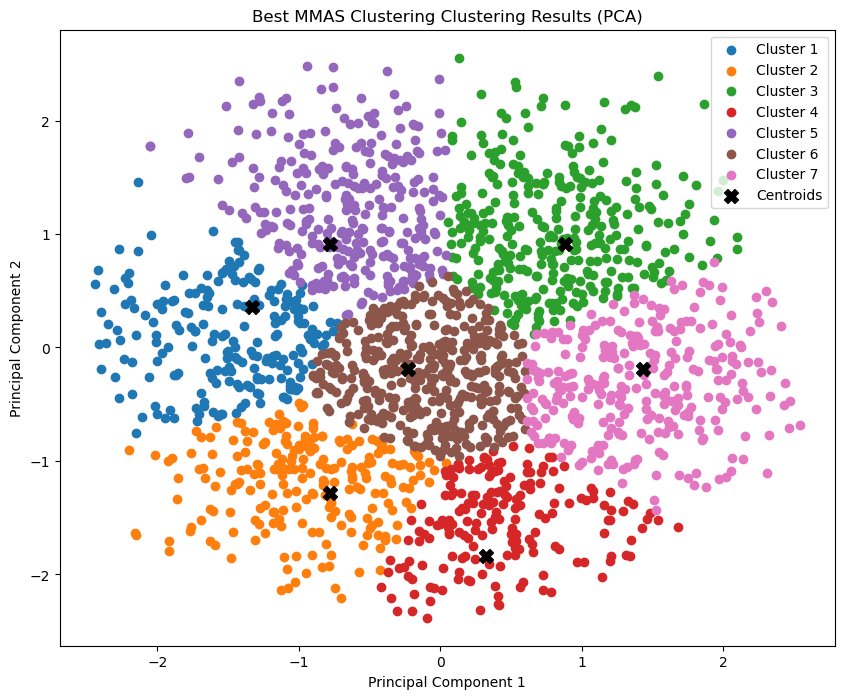

array([4, 2, 4, ..., 0, 1, 1], dtype=int64)

In [59]:
best_results = evaluate_clustering(X_scaled, best_labels, "Best MMAS")
results.append(best_results)
visualize_clusters(X_scaled, best_labels, best_centroids, "Best MMAS Clustering")


In [60]:
def eas_clustering(X, n_clusters, n_ants=30, n_iterations=100, alpha=1.0, beta=2.0, evaporation_rate=0.5, elite_weight=5):
    """Elitist Ant System (EAS) for clustering"""
    n_samples, n_features = X.shape
    X_min = np.min(X, axis=0)
    X_max = np.max(X, axis=0)

    grid_size = 10
    grid_points = [np.linspace(X_min[f], X_max[f], grid_size) for f in range(n_features)]

    pheromone = np.ones([grid_size] * n_features)
    heuristic = np.ones([grid_size] * n_features)

    for point in X:
        grid_idx = [np.argmin(np.abs(grid_points[f] - point[f])) for f in range(n_features)]
        heuristic[tuple(grid_idx)] += 1
    heuristic = heuristic / np.sum(heuristic)

    best_centroids = None
    best_fitness = float('inf')

    for iteration in tqdm(range(n_iterations), desc="EAS Progress"):
        all_centroids = []
        all_fitness = []

        for ant in range(n_ants):
            centroids = []
            for _ in range(n_clusters):
                prob = (pheromone ** alpha) * (heuristic ** beta)
                prob = prob / np.sum(prob)
                flat_prob = prob.flatten()
                choice = np.random.choice(len(flat_prob), p=flat_prob)
                idx = np.unravel_index(choice, prob.shape)
                centroid = np.array([grid_points[f][idx[f]] for f in range(n_features)])
                centroids.append(centroid)
            centroids = np.array(centroids)

            fitness = calculate_fitness(X, centroids)
            all_centroids.append(centroids)
            all_fitness.append(fitness)

            if fitness < best_fitness:
                best_fitness = fitness
                best_centroids = centroids.copy()

        pheromone = (1 - evaporation_rate) * pheromone

        for ant in range(n_ants):
            deposit = 1.0 / (all_fitness[ant] + 1e-10)
            for centroid in all_centroids[ant]:
                grid_idx = [np.argmin(np.abs(grid_points[f] - centroid[f])) for f in range(n_features)]
                pheromone[tuple(grid_idx)] += deposit

        # Elitist update
        for centroid in best_centroids:
            grid_idx = [np.argmin(np.abs(grid_points[f] - centroid[f])) for f in range(n_features)]
            pheromone[tuple(grid_idx)] += elite_weight * (1.0 / (best_fitness + 1e-10))

    final_labels = assign_clusters(X, best_centroids)
    return best_centroids, final_labels


In [61]:
from sklearn.metrics import silhouette_score
import itertools

def grid_search_eas(X, k, param_grid, n_iterations=100):
    best_score = -1
    best_params = None
    best_centroids = None
    best_labels = None

    combinations = list(itertools.product(
        param_grid['n_ants'],
        param_grid['alpha'],
        param_grid['beta'],
        param_grid['evaporation_rate'],
        param_grid['elite_weight']
    ))

    print(f"Total combinations to try: {len(combinations)}\n")

    for i, (n_ants, alpha, beta, evap, elite_weight) in enumerate(combinations):
        print(f"Trying combination {i+1}/{len(combinations)}: "
              f"n_ants={n_ants}, alpha={alpha}, beta={beta}, evap={evap}, elite_weight={elite_weight}")

        centroids, labels = eas_clustering(
            X, k,
            n_ants=n_ants,
            n_iterations=n_iterations,
            alpha=alpha,
            beta=beta,
            evaporation_rate=evap,
            elite_weight=elite_weight
        )

        try:
            score = silhouette_score(X, labels)
            print(f"→ Silhouette Score: {score:.4f}\n")

            if score > best_score:
                best_score = score
                best_params = {
                    'n_ants': n_ants,
                    'alpha': alpha,
                    'beta': beta,
                    'evaporation_rate': evap,
                    'elite_weight': elite_weight
                }
                best_centroids = centroids
                best_labels = labels
        except Exception as e:
            print(f" Error in scoring: {e}")

    print(" Best Parameters Found:")
    print(best_params)
    print(f"Best Silhouette Score: {best_score:.4f}")

    return best_centroids, best_labels, best_params


In [65]:
param_grid = {
    'n_ants': [20,40,60,80,100],
    'alpha': [0.5, 1.0, 2.0,3.0],
    'beta': [1.0, 2.0, 3.0],
    'evaporation_rate': [0.3, 0.5, 0.7,1.0],
    'elite_weight': [3, 5, 10]
}

In [67]:
best_centroids, best_labels, best_params = grid_search_eas(
    X_scaled,
    optimal_k,
    param_grid,
    n_iterations=100  # عدد التكرارات يمكن تعديله
)

Total combinations to try: 720

Trying combination 1/720: n_ants=20, alpha=0.5, beta=1.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.31it/s]


→ Silhouette Score: 0.3127

Trying combination 2/720: n_ants=20, alpha=0.5, beta=1.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


→ Silhouette Score: 0.3400

Trying combination 3/720: n_ants=20, alpha=0.5, beta=1.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.23it/s]


→ Silhouette Score: 0.3149

Trying combination 4/720: n_ants=20, alpha=0.5, beta=1.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.31it/s]


→ Silhouette Score: 0.3055

Trying combination 5/720: n_ants=20, alpha=0.5, beta=1.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.62it/s]


→ Silhouette Score: 0.3259

Trying combination 6/720: n_ants=20, alpha=0.5, beta=1.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:04<00:00, 23.05it/s]


→ Silhouette Score: 0.2891

Trying combination 7/720: n_ants=20, alpha=0.5, beta=1.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:04<00:00, 20.79it/s]


→ Silhouette Score: 0.3388

Trying combination 8/720: n_ants=20, alpha=0.5, beta=1.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:04<00:00, 23.16it/s]


→ Silhouette Score: 0.3536

Trying combination 9/720: n_ants=20, alpha=0.5, beta=1.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.26it/s]


→ Silhouette Score: 0.3042

Trying combination 10/720: n_ants=20, alpha=0.5, beta=1.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:04<00:00, 22.25it/s]


→ Silhouette Score: 0.2990

Trying combination 11/720: n_ants=20, alpha=0.5, beta=1.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:04<00:00, 22.44it/s]


→ Silhouette Score: 0.3185

Trying combination 12/720: n_ants=20, alpha=0.5, beta=1.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:04<00:00, 23.24it/s]


→ Silhouette Score: 0.3233

Trying combination 13/720: n_ants=20, alpha=0.5, beta=2.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:04<00:00, 23.55it/s]


→ Silhouette Score: 0.2945

Trying combination 14/720: n_ants=20, alpha=0.5, beta=2.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:04<00:00, 23.07it/s]


→ Silhouette Score: 0.2923

Trying combination 15/720: n_ants=20, alpha=0.5, beta=2.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:04<00:00, 23.83it/s]


→ Silhouette Score: 0.3070

Trying combination 16/720: n_ants=20, alpha=0.5, beta=2.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:04<00:00, 23.92it/s]


→ Silhouette Score: 0.2878

Trying combination 17/720: n_ants=20, alpha=0.5, beta=2.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.14it/s]


→ Silhouette Score: 0.2847

Trying combination 18/720: n_ants=20, alpha=0.5, beta=2.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.29it/s]


→ Silhouette Score: 0.3024

Trying combination 19/720: n_ants=20, alpha=0.5, beta=2.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.69it/s]


→ Silhouette Score: 0.2820

Trying combination 20/720: n_ants=20, alpha=0.5, beta=2.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:04<00:00, 22.07it/s]


→ Silhouette Score: 0.3102

Trying combination 21/720: n_ants=20, alpha=0.5, beta=2.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 19.39it/s]


→ Silhouette Score: 0.2815

Trying combination 22/720: n_ants=20, alpha=0.5, beta=2.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:04<00:00, 22.27it/s]


→ Silhouette Score: 0.2786

Trying combination 23/720: n_ants=20, alpha=0.5, beta=2.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:04<00:00, 22.98it/s]


→ Silhouette Score: 0.2284

Trying combination 24/720: n_ants=20, alpha=0.5, beta=2.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:04<00:00, 22.65it/s]


→ Silhouette Score: 0.2835

Trying combination 25/720: n_ants=20, alpha=0.5, beta=3.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.23it/s]


→ Silhouette Score: 0.2908

Trying combination 26/720: n_ants=20, alpha=0.5, beta=3.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.46it/s]


→ Silhouette Score: 0.3030

Trying combination 27/720: n_ants=20, alpha=0.5, beta=3.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.12it/s]


→ Silhouette Score: 0.3053

Trying combination 28/720: n_ants=20, alpha=0.5, beta=3.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.13it/s]


→ Silhouette Score: 0.2976

Trying combination 29/720: n_ants=20, alpha=0.5, beta=3.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 30.05it/s]


→ Silhouette Score: 0.3075

Trying combination 30/720: n_ants=20, alpha=0.5, beta=3.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.13it/s]


→ Silhouette Score: 0.2766

Trying combination 31/720: n_ants=20, alpha=0.5, beta=3.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.42it/s]


→ Silhouette Score: 0.2722

Trying combination 32/720: n_ants=20, alpha=0.5, beta=3.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.99it/s]


→ Silhouette Score: 0.2956

Trying combination 33/720: n_ants=20, alpha=0.5, beta=3.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


→ Silhouette Score: 0.2830

Trying combination 34/720: n_ants=20, alpha=0.5, beta=3.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 31.69it/s]


→ Silhouette Score: 0.2631

Trying combination 35/720: n_ants=20, alpha=0.5, beta=3.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.77it/s]


→ Silhouette Score: 0.2788

Trying combination 36/720: n_ants=20, alpha=0.5, beta=3.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 30.40it/s]


→ Silhouette Score: 0.2397

Trying combination 37/720: n_ants=20, alpha=1.0, beta=1.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.47it/s]


→ Silhouette Score: 0.3013

Trying combination 38/720: n_ants=20, alpha=1.0, beta=1.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 30.77it/s]


→ Silhouette Score: 0.3003

Trying combination 39/720: n_ants=20, alpha=1.0, beta=1.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 30.48it/s]


→ Silhouette Score: 0.2910

Trying combination 40/720: n_ants=20, alpha=1.0, beta=1.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.35it/s]


→ Silhouette Score: 0.2906

Trying combination 41/720: n_ants=20, alpha=1.0, beta=1.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.37it/s]


→ Silhouette Score: 0.2929

Trying combination 42/720: n_ants=20, alpha=1.0, beta=1.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.87it/s]


→ Silhouette Score: 0.2714

Trying combination 43/720: n_ants=20, alpha=1.0, beta=1.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 30.68it/s]


→ Silhouette Score: 0.2544

Trying combination 44/720: n_ants=20, alpha=1.0, beta=1.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.87it/s]


→ Silhouette Score: 0.2428

Trying combination 45/720: n_ants=20, alpha=1.0, beta=1.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.02it/s]


→ Silhouette Score: 0.2708

Trying combination 46/720: n_ants=20, alpha=1.0, beta=1.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.92it/s]


→ Silhouette Score: 0.2841

Trying combination 47/720: n_ants=20, alpha=1.0, beta=1.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.82it/s]


→ Silhouette Score: 0.3145

Trying combination 48/720: n_ants=20, alpha=1.0, beta=1.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.00it/s]


→ Silhouette Score: 0.3079

Trying combination 49/720: n_ants=20, alpha=1.0, beta=2.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.94it/s]


→ Silhouette Score: 0.3044

Trying combination 50/720: n_ants=20, alpha=1.0, beta=2.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.88it/s]


→ Silhouette Score: 0.3093

Trying combination 51/720: n_ants=20, alpha=1.0, beta=2.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.74it/s]


→ Silhouette Score: 0.3357

Trying combination 52/720: n_ants=20, alpha=1.0, beta=2.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 32.69it/s]


→ Silhouette Score: 0.2604

Trying combination 53/720: n_ants=20, alpha=1.0, beta=2.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.86it/s]


→ Silhouette Score: 0.3301

Trying combination 54/720: n_ants=20, alpha=1.0, beta=2.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:04<00:00, 23.57it/s]


→ Silhouette Score: 0.3012

Trying combination 55/720: n_ants=20, alpha=1.0, beta=2.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:04<00:00, 20.12it/s]


→ Silhouette Score: 0.3068

Trying combination 56/720: n_ants=20, alpha=1.0, beta=2.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.42it/s]


→ Silhouette Score: 0.2800

Trying combination 57/720: n_ants=20, alpha=1.0, beta=2.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:04<00:00, 22.34it/s]


→ Silhouette Score: 0.2764

Trying combination 58/720: n_ants=20, alpha=1.0, beta=2.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.74it/s]


→ Silhouette Score: 0.2516

Trying combination 59/720: n_ants=20, alpha=1.0, beta=2.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:04<00:00, 23.22it/s]


→ Silhouette Score: 0.2826

Trying combination 60/720: n_ants=20, alpha=1.0, beta=2.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.89it/s]


→ Silhouette Score: 0.2906

Trying combination 61/720: n_ants=20, alpha=1.0, beta=3.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.69it/s]


→ Silhouette Score: 0.2808

Trying combination 62/720: n_ants=20, alpha=1.0, beta=3.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


→ Silhouette Score: 0.2778

Trying combination 63/720: n_ants=20, alpha=1.0, beta=3.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.57it/s]


→ Silhouette Score: 0.2948

Trying combination 64/720: n_ants=20, alpha=1.0, beta=3.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.04it/s]


→ Silhouette Score: 0.2969

Trying combination 65/720: n_ants=20, alpha=1.0, beta=3.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.96it/s]


→ Silhouette Score: 0.2618

Trying combination 66/720: n_ants=20, alpha=1.0, beta=3.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.90it/s]


→ Silhouette Score: 0.2696

Trying combination 67/720: n_ants=20, alpha=1.0, beta=3.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.64it/s]


→ Silhouette Score: 0.2667

Trying combination 68/720: n_ants=20, alpha=1.0, beta=3.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.17it/s]


→ Silhouette Score: 0.2743

Trying combination 69/720: n_ants=20, alpha=1.0, beta=3.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.49it/s]


→ Silhouette Score: 0.3096

Trying combination 70/720: n_ants=20, alpha=1.0, beta=3.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.88it/s]


→ Silhouette Score: 0.1933

Trying combination 71/720: n_ants=20, alpha=1.0, beta=3.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.47it/s]


→ Silhouette Score: 0.2799

Trying combination 72/720: n_ants=20, alpha=1.0, beta=3.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.46it/s]


→ Silhouette Score: 0.2500

Trying combination 73/720: n_ants=20, alpha=2.0, beta=1.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.26it/s]


→ Silhouette Score: 0.2786

Trying combination 74/720: n_ants=20, alpha=2.0, beta=1.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.24it/s]


→ Silhouette Score: 0.2751

Trying combination 75/720: n_ants=20, alpha=2.0, beta=1.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.26it/s]


→ Silhouette Score: 0.3014

Trying combination 76/720: n_ants=20, alpha=2.0, beta=1.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.11it/s]


→ Silhouette Score: 0.3013

Trying combination 77/720: n_ants=20, alpha=2.0, beta=1.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.26it/s]


→ Silhouette Score: 0.3148

Trying combination 78/720: n_ants=20, alpha=2.0, beta=1.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:04<00:00, 20.97it/s]


→ Silhouette Score: 0.2837

Trying combination 79/720: n_ants=20, alpha=2.0, beta=1.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.60it/s]


→ Silhouette Score: 0.3236

Trying combination 80/720: n_ants=20, alpha=2.0, beta=1.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.35it/s]


→ Silhouette Score: 0.3067

Trying combination 81/720: n_ants=20, alpha=2.0, beta=1.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.98it/s]


→ Silhouette Score: 0.2669

Trying combination 82/720: n_ants=20, alpha=2.0, beta=1.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:02<00:00, 33.65it/s]


→ Silhouette Score: 0.2859

Trying combination 83/720: n_ants=20, alpha=2.0, beta=1.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:02<00:00, 36.07it/s]


→ Silhouette Score: 0.2623

Trying combination 84/720: n_ants=20, alpha=2.0, beta=1.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.98it/s]


→ Silhouette Score: 0.2450

Trying combination 85/720: n_ants=20, alpha=2.0, beta=2.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.21it/s]


→ Silhouette Score: 0.2808

Trying combination 86/720: n_ants=20, alpha=2.0, beta=2.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 32.19it/s]


→ Silhouette Score: 0.2851

Trying combination 87/720: n_ants=20, alpha=2.0, beta=2.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.84it/s]


→ Silhouette Score: 0.3248

Trying combination 88/720: n_ants=20, alpha=2.0, beta=2.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.92it/s]


→ Silhouette Score: 0.3241

Trying combination 89/720: n_ants=20, alpha=2.0, beta=2.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:02<00:00, 34.03it/s]


→ Silhouette Score: 0.2846

Trying combination 90/720: n_ants=20, alpha=2.0, beta=2.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.81it/s]


→ Silhouette Score: 0.3060

Trying combination 91/720: n_ants=20, alpha=2.0, beta=2.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.89it/s]


→ Silhouette Score: 0.2820

Trying combination 92/720: n_ants=20, alpha=2.0, beta=2.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 30.37it/s]


→ Silhouette Score: 0.2995

Trying combination 93/720: n_ants=20, alpha=2.0, beta=2.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 32.60it/s]


→ Silhouette Score: 0.2749

Trying combination 94/720: n_ants=20, alpha=2.0, beta=2.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:02<00:00, 33.43it/s]


→ Silhouette Score: 0.2835

Trying combination 95/720: n_ants=20, alpha=2.0, beta=2.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 30.66it/s]


→ Silhouette Score: 0.2752

Trying combination 96/720: n_ants=20, alpha=2.0, beta=2.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:02<00:00, 35.21it/s]


→ Silhouette Score: 0.2698

Trying combination 97/720: n_ants=20, alpha=2.0, beta=3.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.69it/s]


→ Silhouette Score: 0.3147

Trying combination 98/720: n_ants=20, alpha=2.0, beta=3.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.23it/s]


→ Silhouette Score: 0.3081

Trying combination 99/720: n_ants=20, alpha=2.0, beta=3.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.23it/s]


→ Silhouette Score: 0.2404

Trying combination 100/720: n_ants=20, alpha=2.0, beta=3.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.51it/s]


→ Silhouette Score: 0.2763

Trying combination 101/720: n_ants=20, alpha=2.0, beta=3.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.37it/s]


→ Silhouette Score: 0.3387

Trying combination 102/720: n_ants=20, alpha=2.0, beta=3.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.91it/s]


→ Silhouette Score: 0.2923

Trying combination 103/720: n_ants=20, alpha=2.0, beta=3.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.17it/s]


→ Silhouette Score: 0.2750

Trying combination 104/720: n_ants=20, alpha=2.0, beta=3.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.76it/s]


→ Silhouette Score: 0.3006

Trying combination 105/720: n_ants=20, alpha=2.0, beta=3.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.05it/s]


→ Silhouette Score: 0.2889

Trying combination 106/720: n_ants=20, alpha=2.0, beta=3.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.81it/s]


→ Silhouette Score: 0.2507

Trying combination 107/720: n_ants=20, alpha=2.0, beta=3.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.10it/s]


→ Silhouette Score: 0.2347

Trying combination 108/720: n_ants=20, alpha=2.0, beta=3.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:04<00:00, 20.27it/s]


→ Silhouette Score: 0.3131

Trying combination 109/720: n_ants=20, alpha=3.0, beta=1.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.49it/s]


→ Silhouette Score: 0.2933

Trying combination 110/720: n_ants=20, alpha=3.0, beta=1.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 32.79it/s]


→ Silhouette Score: 0.2922

Trying combination 111/720: n_ants=20, alpha=3.0, beta=1.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.13it/s]


→ Silhouette Score: 0.3079

Trying combination 112/720: n_ants=20, alpha=3.0, beta=1.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 30.62it/s]


→ Silhouette Score: 0.3172

Trying combination 113/720: n_ants=20, alpha=3.0, beta=1.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.05it/s]


→ Silhouette Score: 0.2951

Trying combination 114/720: n_ants=20, alpha=3.0, beta=1.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.93it/s]


→ Silhouette Score: 0.3219

Trying combination 115/720: n_ants=20, alpha=3.0, beta=1.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.89it/s]


→ Silhouette Score: 0.3288

Trying combination 116/720: n_ants=20, alpha=3.0, beta=1.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.59it/s]


→ Silhouette Score: 0.2764

Trying combination 117/720: n_ants=20, alpha=3.0, beta=1.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.61it/s]


→ Silhouette Score: 0.3194

Trying combination 118/720: n_ants=20, alpha=3.0, beta=1.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 32.03it/s]


→ Silhouette Score: 0.2769

Trying combination 119/720: n_ants=20, alpha=3.0, beta=1.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 30.21it/s]


→ Silhouette Score: 0.3012

Trying combination 120/720: n_ants=20, alpha=3.0, beta=1.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 32.07it/s]


→ Silhouette Score: 0.2241

Trying combination 121/720: n_ants=20, alpha=3.0, beta=2.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 32.68it/s]


→ Silhouette Score: 0.3087

Trying combination 122/720: n_ants=20, alpha=3.0, beta=2.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:02<00:00, 34.84it/s]


→ Silhouette Score: 0.2845

Trying combination 123/720: n_ants=20, alpha=3.0, beta=2.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 32.02it/s]


→ Silhouette Score: 0.2959

Trying combination 124/720: n_ants=20, alpha=3.0, beta=2.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 31.89it/s]


→ Silhouette Score: 0.3255

Trying combination 125/720: n_ants=20, alpha=3.0, beta=2.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 31.78it/s]


→ Silhouette Score: 0.3028

Trying combination 126/720: n_ants=20, alpha=3.0, beta=2.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 33.28it/s]


→ Silhouette Score: 0.2906

Trying combination 127/720: n_ants=20, alpha=3.0, beta=2.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 30.90it/s]


→ Silhouette Score: 0.2912

Trying combination 128/720: n_ants=20, alpha=3.0, beta=2.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 31.29it/s]


→ Silhouette Score: 0.2618

Trying combination 129/720: n_ants=20, alpha=3.0, beta=2.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 30.49it/s]


→ Silhouette Score: 0.2630

Trying combination 130/720: n_ants=20, alpha=3.0, beta=2.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 32.02it/s]


→ Silhouette Score: 0.2732

Trying combination 131/720: n_ants=20, alpha=3.0, beta=2.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:02<00:00, 33.62it/s]


→ Silhouette Score: 0.2493

Trying combination 132/720: n_ants=20, alpha=3.0, beta=2.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 31.19it/s]


→ Silhouette Score: 0.2547

Trying combination 133/720: n_ants=20, alpha=3.0, beta=3.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:02<00:00, 33.98it/s]


→ Silhouette Score: 0.2811

Trying combination 134/720: n_ants=20, alpha=3.0, beta=3.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 31.29it/s]


→ Silhouette Score: 0.3040

Trying combination 135/720: n_ants=20, alpha=3.0, beta=3.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 32.46it/s]


→ Silhouette Score: 0.2458

Trying combination 136/720: n_ants=20, alpha=3.0, beta=3.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 31.14it/s]


→ Silhouette Score: 0.3081

Trying combination 137/720: n_ants=20, alpha=3.0, beta=3.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.40it/s]


→ Silhouette Score: 0.2947

Trying combination 138/720: n_ants=20, alpha=3.0, beta=3.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 31.62it/s]


→ Silhouette Score: 0.2702

Trying combination 139/720: n_ants=20, alpha=3.0, beta=3.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 31.06it/s]


→ Silhouette Score: 0.2788

Trying combination 140/720: n_ants=20, alpha=3.0, beta=3.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 31.47it/s]


→ Silhouette Score: 0.2525

Trying combination 141/720: n_ants=20, alpha=3.0, beta=3.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 32.93it/s]


→ Silhouette Score: 0.3048

Trying combination 142/720: n_ants=20, alpha=3.0, beta=3.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:02<00:00, 33.72it/s]


→ Silhouette Score: 0.2945

Trying combination 143/720: n_ants=20, alpha=3.0, beta=3.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 32.49it/s]


→ Silhouette Score: 0.2163

Trying combination 144/720: n_ants=20, alpha=3.0, beta=3.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:03<00:00, 33.05it/s]


→ Silhouette Score: 0.2759

Trying combination 145/720: n_ants=40, alpha=0.5, beta=1.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.07it/s]


→ Silhouette Score: 0.3140

Trying combination 146/720: n_ants=40, alpha=0.5, beta=1.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.64it/s]


→ Silhouette Score: 0.3406

Trying combination 147/720: n_ants=40, alpha=0.5, beta=1.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.14it/s]


→ Silhouette Score: 0.3259

Trying combination 148/720: n_ants=40, alpha=0.5, beta=1.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.67it/s]


→ Silhouette Score: 0.3258

Trying combination 149/720: n_ants=40, alpha=0.5, beta=1.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.74it/s]


→ Silhouette Score: 0.3147

Trying combination 150/720: n_ants=40, alpha=0.5, beta=1.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.33it/s]


→ Silhouette Score: 0.3168

Trying combination 151/720: n_ants=40, alpha=0.5, beta=1.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.91it/s]


→ Silhouette Score: 0.3107

Trying combination 152/720: n_ants=40, alpha=0.5, beta=1.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.02it/s]


→ Silhouette Score: 0.3276

Trying combination 153/720: n_ants=40, alpha=0.5, beta=1.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.11it/s]


→ Silhouette Score: 0.3444

Trying combination 154/720: n_ants=40, alpha=0.5, beta=1.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.68it/s]


→ Silhouette Score: 0.3158

Trying combination 155/720: n_ants=40, alpha=0.5, beta=1.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.61it/s]


→ Silhouette Score: 0.3071

Trying combination 156/720: n_ants=40, alpha=0.5, beta=1.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.36it/s]


→ Silhouette Score: 0.3264

Trying combination 157/720: n_ants=40, alpha=0.5, beta=2.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.83it/s]


→ Silhouette Score: 0.2908

Trying combination 158/720: n_ants=40, alpha=0.5, beta=2.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.85it/s]


→ Silhouette Score: 0.3061

Trying combination 159/720: n_ants=40, alpha=0.5, beta=2.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.93it/s]


→ Silhouette Score: 0.3290

Trying combination 160/720: n_ants=40, alpha=0.5, beta=2.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.48it/s]


→ Silhouette Score: 0.2929

Trying combination 161/720: n_ants=40, alpha=0.5, beta=2.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.17it/s]


→ Silhouette Score: 0.2992

Trying combination 162/720: n_ants=40, alpha=0.5, beta=2.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.41it/s]


→ Silhouette Score: 0.3337

Trying combination 163/720: n_ants=40, alpha=0.5, beta=2.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.56it/s]


→ Silhouette Score: 0.3251

Trying combination 164/720: n_ants=40, alpha=0.5, beta=2.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.91it/s]


→ Silhouette Score: 0.2995

Trying combination 165/720: n_ants=40, alpha=0.5, beta=2.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.65it/s]


→ Silhouette Score: 0.3021

Trying combination 166/720: n_ants=40, alpha=0.5, beta=2.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.17it/s]


→ Silhouette Score: 0.2907

Trying combination 167/720: n_ants=40, alpha=0.5, beta=2.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.75it/s]


→ Silhouette Score: 0.2876

Trying combination 168/720: n_ants=40, alpha=0.5, beta=2.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.85it/s]


→ Silhouette Score: 0.3049

Trying combination 169/720: n_ants=40, alpha=0.5, beta=3.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.13it/s]


→ Silhouette Score: 0.2913

Trying combination 170/720: n_ants=40, alpha=0.5, beta=3.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.15it/s]


→ Silhouette Score: 0.3056

Trying combination 171/720: n_ants=40, alpha=0.5, beta=3.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.41it/s]


→ Silhouette Score: 0.3261

Trying combination 172/720: n_ants=40, alpha=0.5, beta=3.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.32it/s]


→ Silhouette Score: 0.3182

Trying combination 173/720: n_ants=40, alpha=0.5, beta=3.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.93it/s]


→ Silhouette Score: 0.2914

Trying combination 174/720: n_ants=40, alpha=0.5, beta=3.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.92it/s]


→ Silhouette Score: 0.3059

Trying combination 175/720: n_ants=40, alpha=0.5, beta=3.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.44it/s]


→ Silhouette Score: 0.2717

Trying combination 176/720: n_ants=40, alpha=0.5, beta=3.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.07it/s]


→ Silhouette Score: 0.2772

Trying combination 177/720: n_ants=40, alpha=0.5, beta=3.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.02it/s]


→ Silhouette Score: 0.3261

Trying combination 178/720: n_ants=40, alpha=0.5, beta=3.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.50it/s]


→ Silhouette Score: 0.3027

Trying combination 179/720: n_ants=40, alpha=0.5, beta=3.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.62it/s]


→ Silhouette Score: 0.2845

Trying combination 180/720: n_ants=40, alpha=0.5, beta=3.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.78it/s]


→ Silhouette Score: 0.2606

Trying combination 181/720: n_ants=40, alpha=1.0, beta=1.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.16it/s]


→ Silhouette Score: 0.3096

Trying combination 182/720: n_ants=40, alpha=1.0, beta=1.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.15it/s]


→ Silhouette Score: 0.2898

Trying combination 183/720: n_ants=40, alpha=1.0, beta=1.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.35it/s]


→ Silhouette Score: 0.3127

Trying combination 184/720: n_ants=40, alpha=1.0, beta=1.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.30it/s]


→ Silhouette Score: 0.3005

Trying combination 185/720: n_ants=40, alpha=1.0, beta=1.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.16it/s]


→ Silhouette Score: 0.3122

Trying combination 186/720: n_ants=40, alpha=1.0, beta=1.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.75it/s]


→ Silhouette Score: 0.3035

Trying combination 187/720: n_ants=40, alpha=1.0, beta=1.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.98it/s]


→ Silhouette Score: 0.3307

Trying combination 188/720: n_ants=40, alpha=1.0, beta=1.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.57it/s]


→ Silhouette Score: 0.2941

Trying combination 189/720: n_ants=40, alpha=1.0, beta=1.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.67it/s]


→ Silhouette Score: 0.3029

Trying combination 190/720: n_ants=40, alpha=1.0, beta=1.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.45it/s]


→ Silhouette Score: 0.2961

Trying combination 191/720: n_ants=40, alpha=1.0, beta=1.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.56it/s]


→ Silhouette Score: 0.2829

Trying combination 192/720: n_ants=40, alpha=1.0, beta=1.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.30it/s]


→ Silhouette Score: 0.3143

Trying combination 193/720: n_ants=40, alpha=1.0, beta=2.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.01it/s]


→ Silhouette Score: 0.2911

Trying combination 194/720: n_ants=40, alpha=1.0, beta=2.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.14it/s]


→ Silhouette Score: 0.3168

Trying combination 195/720: n_ants=40, alpha=1.0, beta=2.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.50it/s]


→ Silhouette Score: 0.2981

Trying combination 196/720: n_ants=40, alpha=1.0, beta=2.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.61it/s]


→ Silhouette Score: 0.2875

Trying combination 197/720: n_ants=40, alpha=1.0, beta=2.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.96it/s]


→ Silhouette Score: 0.3157

Trying combination 198/720: n_ants=40, alpha=1.0, beta=2.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.52it/s]


→ Silhouette Score: 0.2888

Trying combination 199/720: n_ants=40, alpha=1.0, beta=2.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.54it/s]


→ Silhouette Score: 0.2939

Trying combination 200/720: n_ants=40, alpha=1.0, beta=2.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.35it/s]


→ Silhouette Score: 0.3056

Trying combination 201/720: n_ants=40, alpha=1.0, beta=2.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.81it/s]


→ Silhouette Score: 0.3130

Trying combination 202/720: n_ants=40, alpha=1.0, beta=2.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.78it/s]


→ Silhouette Score: 0.2756

Trying combination 203/720: n_ants=40, alpha=1.0, beta=2.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.06it/s]


→ Silhouette Score: 0.2914

Trying combination 204/720: n_ants=40, alpha=1.0, beta=2.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.09it/s]


→ Silhouette Score: 0.2611

Trying combination 205/720: n_ants=40, alpha=1.0, beta=3.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.67it/s]


→ Silhouette Score: 0.3201

Trying combination 206/720: n_ants=40, alpha=1.0, beta=3.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.55it/s]


→ Silhouette Score: 0.2783

Trying combination 207/720: n_ants=40, alpha=1.0, beta=3.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.46it/s]


→ Silhouette Score: 0.3084

Trying combination 208/720: n_ants=40, alpha=1.0, beta=3.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.30it/s]


→ Silhouette Score: 0.2971

Trying combination 209/720: n_ants=40, alpha=1.0, beta=3.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.85it/s]


→ Silhouette Score: 0.2668

Trying combination 210/720: n_ants=40, alpha=1.0, beta=3.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.55it/s]


→ Silhouette Score: 0.2872

Trying combination 211/720: n_ants=40, alpha=1.0, beta=3.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.64it/s]


→ Silhouette Score: 0.3185

Trying combination 212/720: n_ants=40, alpha=1.0, beta=3.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.32it/s]


→ Silhouette Score: 0.2677

Trying combination 213/720: n_ants=40, alpha=1.0, beta=3.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.08it/s]


→ Silhouette Score: 0.2559

Trying combination 214/720: n_ants=40, alpha=1.0, beta=3.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.43it/s]


→ Silhouette Score: 0.2688

Trying combination 215/720: n_ants=40, alpha=1.0, beta=3.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.22it/s]


→ Silhouette Score: 0.2611

Trying combination 216/720: n_ants=40, alpha=1.0, beta=3.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.03it/s]


→ Silhouette Score: 0.3092

Trying combination 217/720: n_ants=40, alpha=2.0, beta=1.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.70it/s]


→ Silhouette Score: 0.2734

Trying combination 218/720: n_ants=40, alpha=2.0, beta=1.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.39it/s]


→ Silhouette Score: 0.2824

Trying combination 219/720: n_ants=40, alpha=2.0, beta=1.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.81it/s]


→ Silhouette Score: 0.3233

Trying combination 220/720: n_ants=40, alpha=2.0, beta=1.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.51it/s]


→ Silhouette Score: 0.2926

Trying combination 221/720: n_ants=40, alpha=2.0, beta=1.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.87it/s]


→ Silhouette Score: 0.2986

Trying combination 222/720: n_ants=40, alpha=2.0, beta=1.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.72it/s]


→ Silhouette Score: 0.3045

Trying combination 223/720: n_ants=40, alpha=2.0, beta=1.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.96it/s]


→ Silhouette Score: 0.2964

Trying combination 224/720: n_ants=40, alpha=2.0, beta=1.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.21it/s]


→ Silhouette Score: 0.2948

Trying combination 225/720: n_ants=40, alpha=2.0, beta=1.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.68it/s]


→ Silhouette Score: 0.2934

Trying combination 226/720: n_ants=40, alpha=2.0, beta=1.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.85it/s]


→ Silhouette Score: 0.2841

Trying combination 227/720: n_ants=40, alpha=2.0, beta=1.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.97it/s]


→ Silhouette Score: 0.2895

Trying combination 228/720: n_ants=40, alpha=2.0, beta=1.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.92it/s]


→ Silhouette Score: 0.3175

Trying combination 229/720: n_ants=40, alpha=2.0, beta=2.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.43it/s]


→ Silhouette Score: 0.2980

Trying combination 230/720: n_ants=40, alpha=2.0, beta=2.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.59it/s]


→ Silhouette Score: 0.2853

Trying combination 231/720: n_ants=40, alpha=2.0, beta=2.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.54it/s]


→ Silhouette Score: 0.2826

Trying combination 232/720: n_ants=40, alpha=2.0, beta=2.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.15it/s]


→ Silhouette Score: 0.2909

Trying combination 233/720: n_ants=40, alpha=2.0, beta=2.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.33it/s]


→ Silhouette Score: 0.3044

Trying combination 234/720: n_ants=40, alpha=2.0, beta=2.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.65it/s]


→ Silhouette Score: 0.2720

Trying combination 235/720: n_ants=40, alpha=2.0, beta=2.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.38it/s]


→ Silhouette Score: 0.3373

Trying combination 236/720: n_ants=40, alpha=2.0, beta=2.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.80it/s]


→ Silhouette Score: 0.2770

Trying combination 237/720: n_ants=40, alpha=2.0, beta=2.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.22it/s]


→ Silhouette Score: 0.2781

Trying combination 238/720: n_ants=40, alpha=2.0, beta=2.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.61it/s]


→ Silhouette Score: 0.2523

Trying combination 239/720: n_ants=40, alpha=2.0, beta=2.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.08it/s]


→ Silhouette Score: 0.2816

Trying combination 240/720: n_ants=40, alpha=2.0, beta=2.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.03it/s]


→ Silhouette Score: 0.2907

Trying combination 241/720: n_ants=40, alpha=2.0, beta=3.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.05it/s]


→ Silhouette Score: 0.3120

Trying combination 242/720: n_ants=40, alpha=2.0, beta=3.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.38it/s]


→ Silhouette Score: 0.2604

Trying combination 243/720: n_ants=40, alpha=2.0, beta=3.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.87it/s]


→ Silhouette Score: 0.3022

Trying combination 244/720: n_ants=40, alpha=2.0, beta=3.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.61it/s]


→ Silhouette Score: 0.3081

Trying combination 245/720: n_ants=40, alpha=2.0, beta=3.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.63it/s]


→ Silhouette Score: 0.2624

Trying combination 246/720: n_ants=40, alpha=2.0, beta=3.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.41it/s]


→ Silhouette Score: 0.2745

Trying combination 247/720: n_ants=40, alpha=2.0, beta=3.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.05it/s]


→ Silhouette Score: 0.2775

Trying combination 248/720: n_ants=40, alpha=2.0, beta=3.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.91it/s]


→ Silhouette Score: 0.3106

Trying combination 249/720: n_ants=40, alpha=2.0, beta=3.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.79it/s]


→ Silhouette Score: 0.2724

Trying combination 250/720: n_ants=40, alpha=2.0, beta=3.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.07it/s]


→ Silhouette Score: 0.2614

Trying combination 251/720: n_ants=40, alpha=2.0, beta=3.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.45it/s]


→ Silhouette Score: 0.2652

Trying combination 252/720: n_ants=40, alpha=2.0, beta=3.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.54it/s]


→ Silhouette Score: 0.2880

Trying combination 253/720: n_ants=40, alpha=3.0, beta=1.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.68it/s]


→ Silhouette Score: 0.3255

Trying combination 254/720: n_ants=40, alpha=3.0, beta=1.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.31it/s]


→ Silhouette Score: 0.2914

Trying combination 255/720: n_ants=40, alpha=3.0, beta=1.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.14it/s]


→ Silhouette Score: 0.2890

Trying combination 256/720: n_ants=40, alpha=3.0, beta=1.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.95it/s]


→ Silhouette Score: 0.3262

Trying combination 257/720: n_ants=40, alpha=3.0, beta=1.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.33it/s]


→ Silhouette Score: 0.3180

Trying combination 258/720: n_ants=40, alpha=3.0, beta=1.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.89it/s]


→ Silhouette Score: 0.2907

Trying combination 259/720: n_ants=40, alpha=3.0, beta=1.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.96it/s]


→ Silhouette Score: 0.3045

Trying combination 260/720: n_ants=40, alpha=3.0, beta=1.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.53it/s]


→ Silhouette Score: 0.3047

Trying combination 261/720: n_ants=40, alpha=3.0, beta=1.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.63it/s]


→ Silhouette Score: 0.2749

Trying combination 262/720: n_ants=40, alpha=3.0, beta=1.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.62it/s]


→ Silhouette Score: 0.2660

Trying combination 263/720: n_ants=40, alpha=3.0, beta=1.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.85it/s]


→ Silhouette Score: 0.2976

Trying combination 264/720: n_ants=40, alpha=3.0, beta=1.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.08it/s]


→ Silhouette Score: 0.2722

Trying combination 265/720: n_ants=40, alpha=3.0, beta=2.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.28it/s]


→ Silhouette Score: 0.3371

Trying combination 266/720: n_ants=40, alpha=3.0, beta=2.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.61it/s]


→ Silhouette Score: 0.2936

Trying combination 267/720: n_ants=40, alpha=3.0, beta=2.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.75it/s]


→ Silhouette Score: 0.2939

Trying combination 268/720: n_ants=40, alpha=3.0, beta=2.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.29it/s]


→ Silhouette Score: 0.2721

Trying combination 269/720: n_ants=40, alpha=3.0, beta=2.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.98it/s]


→ Silhouette Score: 0.2866

Trying combination 270/720: n_ants=40, alpha=3.0, beta=2.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.32it/s]


→ Silhouette Score: 0.3154

Trying combination 271/720: n_ants=40, alpha=3.0, beta=2.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.59it/s]


→ Silhouette Score: 0.3011

Trying combination 272/720: n_ants=40, alpha=3.0, beta=2.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.89it/s]


→ Silhouette Score: 0.2890

Trying combination 273/720: n_ants=40, alpha=3.0, beta=2.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.57it/s]


→ Silhouette Score: 0.3022

Trying combination 274/720: n_ants=40, alpha=3.0, beta=2.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.79it/s]


→ Silhouette Score: 0.2707

Trying combination 275/720: n_ants=40, alpha=3.0, beta=2.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.27it/s]


→ Silhouette Score: 0.2549

Trying combination 276/720: n_ants=40, alpha=3.0, beta=2.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.01it/s]


→ Silhouette Score: 0.2610

Trying combination 277/720: n_ants=40, alpha=3.0, beta=3.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.97it/s]


→ Silhouette Score: 0.3035

Trying combination 278/720: n_ants=40, alpha=3.0, beta=3.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.28it/s]


→ Silhouette Score: 0.2667

Trying combination 279/720: n_ants=40, alpha=3.0, beta=3.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.14it/s]


→ Silhouette Score: 0.3127

Trying combination 280/720: n_ants=40, alpha=3.0, beta=3.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.99it/s]


→ Silhouette Score: 0.2859

Trying combination 281/720: n_ants=40, alpha=3.0, beta=3.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.59it/s]


→ Silhouette Score: 0.2828

Trying combination 282/720: n_ants=40, alpha=3.0, beta=3.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.72it/s]


→ Silhouette Score: 0.3107

Trying combination 283/720: n_ants=40, alpha=3.0, beta=3.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.79it/s]


→ Silhouette Score: 0.2695

Trying combination 284/720: n_ants=40, alpha=3.0, beta=3.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.17it/s]


→ Silhouette Score: 0.3031

Trying combination 285/720: n_ants=40, alpha=3.0, beta=3.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.41it/s]


→ Silhouette Score: 0.2741

Trying combination 286/720: n_ants=40, alpha=3.0, beta=3.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.44it/s]


→ Silhouette Score: 0.2775

Trying combination 287/720: n_ants=40, alpha=3.0, beta=3.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.38it/s]


→ Silhouette Score: 0.3032

Trying combination 288/720: n_ants=40, alpha=3.0, beta=3.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.77it/s]


→ Silhouette Score: 0.2310

Trying combination 289/720: n_ants=60, alpha=0.5, beta=1.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.48it/s]


→ Silhouette Score: 0.3143

Trying combination 290/720: n_ants=60, alpha=0.5, beta=1.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.96it/s]


→ Silhouette Score: 0.3227

Trying combination 291/720: n_ants=60, alpha=0.5, beta=1.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.34it/s]


→ Silhouette Score: 0.3103

Trying combination 292/720: n_ants=60, alpha=0.5, beta=1.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.65it/s]


→ Silhouette Score: 0.3253

Trying combination 293/720: n_ants=60, alpha=0.5, beta=1.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 11.01it/s]


→ Silhouette Score: 0.3249

Trying combination 294/720: n_ants=60, alpha=0.5, beta=1.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.22it/s]


→ Silhouette Score: 0.3239

Trying combination 295/720: n_ants=60, alpha=0.5, beta=1.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.39it/s]


→ Silhouette Score: 0.2957

Trying combination 296/720: n_ants=60, alpha=0.5, beta=1.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.64it/s]


→ Silhouette Score: 0.3118

Trying combination 297/720: n_ants=60, alpha=0.5, beta=1.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 11.07it/s]


→ Silhouette Score: 0.3188

Trying combination 298/720: n_ants=60, alpha=0.5, beta=1.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.54it/s]


→ Silhouette Score: 0.2945

Trying combination 299/720: n_ants=60, alpha=0.5, beta=1.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.32it/s]


→ Silhouette Score: 0.3249

Trying combination 300/720: n_ants=60, alpha=0.5, beta=1.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.11it/s]


→ Silhouette Score: 0.3327

Trying combination 301/720: n_ants=60, alpha=0.5, beta=2.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.31it/s]


→ Silhouette Score: 0.2991

Trying combination 302/720: n_ants=60, alpha=0.5, beta=2.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.37it/s]


→ Silhouette Score: 0.2961

Trying combination 303/720: n_ants=60, alpha=0.5, beta=2.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.18it/s]


→ Silhouette Score: 0.3126

Trying combination 304/720: n_ants=60, alpha=0.5, beta=2.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.49it/s]


→ Silhouette Score: 0.2978

Trying combination 305/720: n_ants=60, alpha=0.5, beta=2.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.55it/s]


→ Silhouette Score: 0.3058

Trying combination 306/720: n_ants=60, alpha=0.5, beta=2.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.44it/s]


→ Silhouette Score: 0.3170

Trying combination 307/720: n_ants=60, alpha=0.5, beta=2.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.62it/s]


→ Silhouette Score: 0.3203

Trying combination 308/720: n_ants=60, alpha=0.5, beta=2.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.25it/s]


→ Silhouette Score: 0.3121

Trying combination 309/720: n_ants=60, alpha=0.5, beta=2.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.22it/s]


→ Silhouette Score: 0.3057

Trying combination 310/720: n_ants=60, alpha=0.5, beta=2.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 11.04it/s]


→ Silhouette Score: 0.3021

Trying combination 311/720: n_ants=60, alpha=0.5, beta=2.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.41it/s]


→ Silhouette Score: 0.3299

Trying combination 312/720: n_ants=60, alpha=0.5, beta=2.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.39it/s]


→ Silhouette Score: 0.2977

Trying combination 313/720: n_ants=60, alpha=0.5, beta=3.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 11.03it/s]


→ Silhouette Score: 0.2763

Trying combination 314/720: n_ants=60, alpha=0.5, beta=3.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.43it/s]


→ Silhouette Score: 0.2958

Trying combination 315/720: n_ants=60, alpha=0.5, beta=3.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.41it/s]


→ Silhouette Score: 0.3028

Trying combination 316/720: n_ants=60, alpha=0.5, beta=3.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.99it/s]


→ Silhouette Score: 0.2711

Trying combination 317/720: n_ants=60, alpha=0.5, beta=3.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.37it/s]


→ Silhouette Score: 0.2931

Trying combination 318/720: n_ants=60, alpha=0.5, beta=3.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.35it/s]


→ Silhouette Score: 0.2873

Trying combination 319/720: n_ants=60, alpha=0.5, beta=3.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.25it/s]


→ Silhouette Score: 0.2801

Trying combination 320/720: n_ants=60, alpha=0.5, beta=3.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.20it/s]


→ Silhouette Score: 0.3120

Trying combination 321/720: n_ants=60, alpha=0.5, beta=3.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.92it/s]


→ Silhouette Score: 0.2780

Trying combination 322/720: n_ants=60, alpha=0.5, beta=3.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.29it/s]


→ Silhouette Score: 0.2847

Trying combination 323/720: n_ants=60, alpha=0.5, beta=3.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.57it/s]


→ Silhouette Score: 0.2577

Trying combination 324/720: n_ants=60, alpha=0.5, beta=3.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.65it/s]


→ Silhouette Score: 0.2870

Trying combination 325/720: n_ants=60, alpha=1.0, beta=1.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.76it/s]


→ Silhouette Score: 0.3019

Trying combination 326/720: n_ants=60, alpha=1.0, beta=1.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.33it/s]


→ Silhouette Score: 0.3117

Trying combination 327/720: n_ants=60, alpha=1.0, beta=1.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.14it/s]


→ Silhouette Score: 0.3133

Trying combination 328/720: n_ants=60, alpha=1.0, beta=1.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.78it/s]


→ Silhouette Score: 0.2856

Trying combination 329/720: n_ants=60, alpha=1.0, beta=1.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.31it/s]


→ Silhouette Score: 0.3372

Trying combination 330/720: n_ants=60, alpha=1.0, beta=1.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.28it/s]


→ Silhouette Score: 0.3158

Trying combination 331/720: n_ants=60, alpha=1.0, beta=1.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.79it/s]


→ Silhouette Score: 0.2767

Trying combination 332/720: n_ants=60, alpha=1.0, beta=1.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.34it/s]


→ Silhouette Score: 0.2765

Trying combination 333/720: n_ants=60, alpha=1.0, beta=1.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.60it/s]


→ Silhouette Score: 0.3139

Trying combination 334/720: n_ants=60, alpha=1.0, beta=1.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.68it/s]


→ Silhouette Score: 0.2863

Trying combination 335/720: n_ants=60, alpha=1.0, beta=1.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.50it/s]


→ Silhouette Score: 0.2897

Trying combination 336/720: n_ants=60, alpha=1.0, beta=1.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.39it/s]


→ Silhouette Score: 0.2936

Trying combination 337/720: n_ants=60, alpha=1.0, beta=2.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.39it/s]


→ Silhouette Score: 0.2765

Trying combination 338/720: n_ants=60, alpha=1.0, beta=2.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.52it/s]


→ Silhouette Score: 0.2887

Trying combination 339/720: n_ants=60, alpha=1.0, beta=2.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.25it/s]


→ Silhouette Score: 0.2825

Trying combination 340/720: n_ants=60, alpha=1.0, beta=2.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.75it/s]


→ Silhouette Score: 0.2929

Trying combination 341/720: n_ants=60, alpha=1.0, beta=2.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.93it/s]


→ Silhouette Score: 0.3011

Trying combination 342/720: n_ants=60, alpha=1.0, beta=2.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.07it/s]


→ Silhouette Score: 0.3203

Trying combination 343/720: n_ants=60, alpha=1.0, beta=2.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.73it/s]


→ Silhouette Score: 0.2806

Trying combination 344/720: n_ants=60, alpha=1.0, beta=2.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.83it/s]


→ Silhouette Score: 0.2681

Trying combination 345/720: n_ants=60, alpha=1.0, beta=2.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.43it/s]


→ Silhouette Score: 0.2674

Trying combination 346/720: n_ants=60, alpha=1.0, beta=2.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.09it/s]


→ Silhouette Score: 0.2748

Trying combination 347/720: n_ants=60, alpha=1.0, beta=2.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.96it/s]


→ Silhouette Score: 0.2825

Trying combination 348/720: n_ants=60, alpha=1.0, beta=2.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.84it/s]


→ Silhouette Score: 0.2936

Trying combination 349/720: n_ants=60, alpha=1.0, beta=3.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.53it/s]


→ Silhouette Score: 0.2640

Trying combination 350/720: n_ants=60, alpha=1.0, beta=3.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.32it/s]


→ Silhouette Score: 0.2625

Trying combination 351/720: n_ants=60, alpha=1.0, beta=3.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.44it/s]


→ Silhouette Score: 0.2745

Trying combination 352/720: n_ants=60, alpha=1.0, beta=3.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.40it/s]


→ Silhouette Score: 0.3012

Trying combination 353/720: n_ants=60, alpha=1.0, beta=3.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.68it/s]


→ Silhouette Score: 0.2626

Trying combination 354/720: n_ants=60, alpha=1.0, beta=3.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.47it/s]


→ Silhouette Score: 0.2930

Trying combination 355/720: n_ants=60, alpha=1.0, beta=3.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.05it/s]


→ Silhouette Score: 0.2890

Trying combination 356/720: n_ants=60, alpha=1.0, beta=3.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.80it/s]


→ Silhouette Score: 0.2968

Trying combination 357/720: n_ants=60, alpha=1.0, beta=3.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.23it/s]


→ Silhouette Score: 0.2862

Trying combination 358/720: n_ants=60, alpha=1.0, beta=3.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 11.08it/s]


→ Silhouette Score: 0.2646

Trying combination 359/720: n_ants=60, alpha=1.0, beta=3.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.15it/s]


→ Silhouette Score: 0.2811

Trying combination 360/720: n_ants=60, alpha=1.0, beta=3.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.69it/s]


→ Silhouette Score: 0.3009

Trying combination 361/720: n_ants=60, alpha=2.0, beta=1.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.93it/s]


→ Silhouette Score: 0.3070

Trying combination 362/720: n_ants=60, alpha=2.0, beta=1.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.07it/s]


→ Silhouette Score: 0.2957

Trying combination 363/720: n_ants=60, alpha=2.0, beta=1.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.02it/s]


→ Silhouette Score: 0.2970

Trying combination 364/720: n_ants=60, alpha=2.0, beta=1.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.88it/s]


→ Silhouette Score: 0.2771

Trying combination 365/720: n_ants=60, alpha=2.0, beta=1.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.64it/s]


→ Silhouette Score: 0.2728

Trying combination 366/720: n_ants=60, alpha=2.0, beta=1.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.00it/s]


→ Silhouette Score: 0.2844

Trying combination 367/720: n_ants=60, alpha=2.0, beta=1.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.16it/s]


→ Silhouette Score: 0.2973

Trying combination 368/720: n_ants=60, alpha=2.0, beta=1.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.23it/s]


→ Silhouette Score: 0.3281

Trying combination 369/720: n_ants=60, alpha=2.0, beta=1.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.39it/s]


→ Silhouette Score: 0.2911

Trying combination 370/720: n_ants=60, alpha=2.0, beta=1.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.19it/s]


→ Silhouette Score: 0.2795

Trying combination 371/720: n_ants=60, alpha=2.0, beta=1.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.15it/s]


→ Silhouette Score: 0.3044

Trying combination 372/720: n_ants=60, alpha=2.0, beta=1.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.52it/s]


→ Silhouette Score: 0.2872

Trying combination 373/720: n_ants=60, alpha=2.0, beta=2.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.39it/s]


→ Silhouette Score: 0.2964

Trying combination 374/720: n_ants=60, alpha=2.0, beta=2.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.76it/s]


→ Silhouette Score: 0.2681

Trying combination 375/720: n_ants=60, alpha=2.0, beta=2.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.53it/s]


→ Silhouette Score: 0.3112

Trying combination 376/720: n_ants=60, alpha=2.0, beta=2.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.68it/s]


→ Silhouette Score: 0.3112

Trying combination 377/720: n_ants=60, alpha=2.0, beta=2.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.54it/s]


→ Silhouette Score: 0.3082

Trying combination 378/720: n_ants=60, alpha=2.0, beta=2.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.11it/s]


→ Silhouette Score: 0.3197

Trying combination 379/720: n_ants=60, alpha=2.0, beta=2.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.50it/s]


→ Silhouette Score: 0.2933

Trying combination 380/720: n_ants=60, alpha=2.0, beta=2.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.31it/s]


→ Silhouette Score: 0.3232

Trying combination 381/720: n_ants=60, alpha=2.0, beta=2.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.98it/s]


→ Silhouette Score: 0.3068

Trying combination 382/720: n_ants=60, alpha=2.0, beta=2.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.21it/s]


→ Silhouette Score: 0.2585

Trying combination 383/720: n_ants=60, alpha=2.0, beta=2.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.43it/s]


→ Silhouette Score: 0.2852

Trying combination 384/720: n_ants=60, alpha=2.0, beta=2.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.65it/s]


→ Silhouette Score: 0.2747

Trying combination 385/720: n_ants=60, alpha=2.0, beta=3.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.65it/s]


→ Silhouette Score: 0.2547

Trying combination 386/720: n_ants=60, alpha=2.0, beta=3.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.94it/s]


→ Silhouette Score: 0.2835

Trying combination 387/720: n_ants=60, alpha=2.0, beta=3.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.04it/s]


→ Silhouette Score: 0.2822

Trying combination 388/720: n_ants=60, alpha=2.0, beta=3.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.39it/s]


→ Silhouette Score: 0.3002

Trying combination 389/720: n_ants=60, alpha=2.0, beta=3.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.37it/s]


→ Silhouette Score: 0.2906

Trying combination 390/720: n_ants=60, alpha=2.0, beta=3.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.40it/s]


→ Silhouette Score: 0.3226

Trying combination 391/720: n_ants=60, alpha=2.0, beta=3.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.44it/s]


→ Silhouette Score: 0.2883

Trying combination 392/720: n_ants=60, alpha=2.0, beta=3.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.84it/s]


→ Silhouette Score: 0.3150

Trying combination 393/720: n_ants=60, alpha=2.0, beta=3.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.90it/s]


→ Silhouette Score: 0.2712

Trying combination 394/720: n_ants=60, alpha=2.0, beta=3.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.68it/s]


→ Silhouette Score: 0.2519

Trying combination 395/720: n_ants=60, alpha=2.0, beta=3.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.10it/s]


→ Silhouette Score: 0.2475

Trying combination 396/720: n_ants=60, alpha=2.0, beta=3.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.23it/s]


→ Silhouette Score: 0.2846

Trying combination 397/720: n_ants=60, alpha=3.0, beta=1.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.17it/s]


→ Silhouette Score: 0.3010

Trying combination 398/720: n_ants=60, alpha=3.0, beta=1.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.15it/s]


→ Silhouette Score: 0.2818

Trying combination 399/720: n_ants=60, alpha=3.0, beta=1.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.29it/s]


→ Silhouette Score: 0.2991

Trying combination 400/720: n_ants=60, alpha=3.0, beta=1.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.14it/s]


→ Silhouette Score: 0.3141

Trying combination 401/720: n_ants=60, alpha=3.0, beta=1.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.68it/s]


→ Silhouette Score: 0.3096

Trying combination 402/720: n_ants=60, alpha=3.0, beta=1.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.87it/s]


→ Silhouette Score: 0.2898

Trying combination 403/720: n_ants=60, alpha=3.0, beta=1.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.32it/s]


→ Silhouette Score: 0.2693

Trying combination 404/720: n_ants=60, alpha=3.0, beta=1.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.41it/s]


→ Silhouette Score: 0.3142

Trying combination 405/720: n_ants=60, alpha=3.0, beta=1.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.68it/s]


→ Silhouette Score: 0.2969

Trying combination 406/720: n_ants=60, alpha=3.0, beta=1.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:04<00:00, 20.07it/s]


→ Silhouette Score: 0.3011

Trying combination 407/720: n_ants=60, alpha=3.0, beta=1.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:04<00:00, 21.56it/s]


→ Silhouette Score: 0.2997

Trying combination 408/720: n_ants=60, alpha=3.0, beta=1.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:04<00:00, 21.46it/s]


→ Silhouette Score: 0.2706

Trying combination 409/720: n_ants=60, alpha=3.0, beta=2.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 19.71it/s]


→ Silhouette Score: 0.2903

Trying combination 410/720: n_ants=60, alpha=3.0, beta=2.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.93it/s]


→ Silhouette Score: 0.2984

Trying combination 411/720: n_ants=60, alpha=3.0, beta=2.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.15it/s]


→ Silhouette Score: 0.2870

Trying combination 412/720: n_ants=60, alpha=3.0, beta=2.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 19.09it/s]


→ Silhouette Score: 0.3121

Trying combination 413/720: n_ants=60, alpha=3.0, beta=2.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 19.30it/s]


→ Silhouette Score: 0.3274

Trying combination 414/720: n_ants=60, alpha=3.0, beta=2.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 19.20it/s]


→ Silhouette Score: 0.2703

Trying combination 415/720: n_ants=60, alpha=3.0, beta=2.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 19.26it/s]


→ Silhouette Score: 0.3041

Trying combination 416/720: n_ants=60, alpha=3.0, beta=2.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 19.37it/s]


→ Silhouette Score: 0.2915

Trying combination 417/720: n_ants=60, alpha=3.0, beta=2.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.86it/s]


→ Silhouette Score: 0.2765

Trying combination 418/720: n_ants=60, alpha=3.0, beta=2.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.26it/s]


→ Silhouette Score: 0.2850

Trying combination 419/720: n_ants=60, alpha=3.0, beta=2.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 19.32it/s]


→ Silhouette Score: 0.2981

Trying combination 420/720: n_ants=60, alpha=3.0, beta=2.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.95it/s]


→ Silhouette Score: 0.2744

Trying combination 421/720: n_ants=60, alpha=3.0, beta=3.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.60it/s]


→ Silhouette Score: 0.2919

Trying combination 422/720: n_ants=60, alpha=3.0, beta=3.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.70it/s]


→ Silhouette Score: 0.3028

Trying combination 423/720: n_ants=60, alpha=3.0, beta=3.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.71it/s]


→ Silhouette Score: 0.2669

Trying combination 424/720: n_ants=60, alpha=3.0, beta=3.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.65it/s]


→ Silhouette Score: 0.2729

Trying combination 425/720: n_ants=60, alpha=3.0, beta=3.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.67it/s]


→ Silhouette Score: 0.2960

Trying combination 426/720: n_ants=60, alpha=3.0, beta=3.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.85it/s]


→ Silhouette Score: 0.2650

Trying combination 427/720: n_ants=60, alpha=3.0, beta=3.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.72it/s]


→ Silhouette Score: 0.2872

Trying combination 428/720: n_ants=60, alpha=3.0, beta=3.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.02it/s]


→ Silhouette Score: 0.2664

Trying combination 429/720: n_ants=60, alpha=3.0, beta=3.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.88it/s]


→ Silhouette Score: 0.3131

Trying combination 430/720: n_ants=60, alpha=3.0, beta=3.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.46it/s]


→ Silhouette Score: 0.2502

Trying combination 431/720: n_ants=60, alpha=3.0, beta=3.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.18it/s]


→ Silhouette Score: 0.2612

Trying combination 432/720: n_ants=60, alpha=3.0, beta=3.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.76it/s]


→ Silhouette Score: 0.2859

Trying combination 433/720: n_ants=80, alpha=0.5, beta=1.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.53it/s]


→ Silhouette Score: 0.3216

Trying combination 434/720: n_ants=80, alpha=0.5, beta=1.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.12it/s]


→ Silhouette Score: 0.3215

Trying combination 435/720: n_ants=80, alpha=0.5, beta=1.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.39it/s]


→ Silhouette Score: 0.3196

Trying combination 436/720: n_ants=80, alpha=0.5, beta=1.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.45it/s]


→ Silhouette Score: 0.3396

Trying combination 437/720: n_ants=80, alpha=0.5, beta=1.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.06it/s]


→ Silhouette Score: 0.3388

Trying combination 438/720: n_ants=80, alpha=0.5, beta=1.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.91it/s]


→ Silhouette Score: 0.3313

Trying combination 439/720: n_ants=80, alpha=0.5, beta=1.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.00it/s]


→ Silhouette Score: 0.3210

Trying combination 440/720: n_ants=80, alpha=0.5, beta=1.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.40it/s]


→ Silhouette Score: 0.3516

Trying combination 441/720: n_ants=80, alpha=0.5, beta=1.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.42it/s]


→ Silhouette Score: 0.3382

Trying combination 442/720: n_ants=80, alpha=0.5, beta=1.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.47it/s]


→ Silhouette Score: 0.3142

Trying combination 443/720: n_ants=80, alpha=0.5, beta=1.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.40it/s]


→ Silhouette Score: 0.3042

Trying combination 444/720: n_ants=80, alpha=0.5, beta=1.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.21it/s]


→ Silhouette Score: 0.3207

Trying combination 445/720: n_ants=80, alpha=0.5, beta=2.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.32it/s]


→ Silhouette Score: 0.3036

Trying combination 446/720: n_ants=80, alpha=0.5, beta=2.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.98it/s]


→ Silhouette Score: 0.3195

Trying combination 447/720: n_ants=80, alpha=0.5, beta=2.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.00it/s]


→ Silhouette Score: 0.3291

Trying combination 448/720: n_ants=80, alpha=0.5, beta=2.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.26it/s]


→ Silhouette Score: 0.3013

Trying combination 449/720: n_ants=80, alpha=0.5, beta=2.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.98it/s]


→ Silhouette Score: 0.3194

Trying combination 450/720: n_ants=80, alpha=0.5, beta=2.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.41it/s]


→ Silhouette Score: 0.3258

Trying combination 451/720: n_ants=80, alpha=0.5, beta=2.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.54it/s]


→ Silhouette Score: 0.3306

Trying combination 452/720: n_ants=80, alpha=0.5, beta=2.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.42it/s]


→ Silhouette Score: 0.3183

Trying combination 453/720: n_ants=80, alpha=0.5, beta=2.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.87it/s]


→ Silhouette Score: 0.3102

Trying combination 454/720: n_ants=80, alpha=0.5, beta=2.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.14it/s]


→ Silhouette Score: 0.3211

Trying combination 455/720: n_ants=80, alpha=0.5, beta=2.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.19it/s]


→ Silhouette Score: 0.3087

Trying combination 456/720: n_ants=80, alpha=0.5, beta=2.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.54it/s]


→ Silhouette Score: 0.2995

Trying combination 457/720: n_ants=80, alpha=0.5, beta=3.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.83it/s]


→ Silhouette Score: 0.3207

Trying combination 458/720: n_ants=80, alpha=0.5, beta=3.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.10it/s]


→ Silhouette Score: 0.2781

Trying combination 459/720: n_ants=80, alpha=0.5, beta=3.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.23it/s]


→ Silhouette Score: 0.3003

Trying combination 460/720: n_ants=80, alpha=0.5, beta=3.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.98it/s]


→ Silhouette Score: 0.3147

Trying combination 461/720: n_ants=80, alpha=0.5, beta=3.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.51it/s]


→ Silhouette Score: 0.2791

Trying combination 462/720: n_ants=80, alpha=0.5, beta=3.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.91it/s]


→ Silhouette Score: 0.2963

Trying combination 463/720: n_ants=80, alpha=0.5, beta=3.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.79it/s]


→ Silhouette Score: 0.2791

Trying combination 464/720: n_ants=80, alpha=0.5, beta=3.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.75it/s]


→ Silhouette Score: 0.2826

Trying combination 465/720: n_ants=80, alpha=0.5, beta=3.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.44it/s]


→ Silhouette Score: 0.2926

Trying combination 466/720: n_ants=80, alpha=0.5, beta=3.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.18it/s]


→ Silhouette Score: 0.2671

Trying combination 467/720: n_ants=80, alpha=0.5, beta=3.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.24it/s]


→ Silhouette Score: 0.2629

Trying combination 468/720: n_ants=80, alpha=0.5, beta=3.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.21it/s]


→ Silhouette Score: 0.2835

Trying combination 469/720: n_ants=80, alpha=1.0, beta=1.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.37it/s]


→ Silhouette Score: 0.3240

Trying combination 470/720: n_ants=80, alpha=1.0, beta=1.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.37it/s]


→ Silhouette Score: 0.2792

Trying combination 471/720: n_ants=80, alpha=1.0, beta=1.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.54it/s]


→ Silhouette Score: 0.3252

Trying combination 472/720: n_ants=80, alpha=1.0, beta=1.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.13it/s]


→ Silhouette Score: 0.2805

Trying combination 473/720: n_ants=80, alpha=1.0, beta=1.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.04it/s]


→ Silhouette Score: 0.3125

Trying combination 474/720: n_ants=80, alpha=1.0, beta=1.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.72it/s]


→ Silhouette Score: 0.2830

Trying combination 475/720: n_ants=80, alpha=1.0, beta=1.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.98it/s]


→ Silhouette Score: 0.3153

Trying combination 476/720: n_ants=80, alpha=1.0, beta=1.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.56it/s]


→ Silhouette Score: 0.2941

Trying combination 477/720: n_ants=80, alpha=1.0, beta=1.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.72it/s]


→ Silhouette Score: 0.2958

Trying combination 478/720: n_ants=80, alpha=1.0, beta=1.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.72it/s]


→ Silhouette Score: 0.3021

Trying combination 479/720: n_ants=80, alpha=1.0, beta=1.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.66it/s]


→ Silhouette Score: 0.2901

Trying combination 480/720: n_ants=80, alpha=1.0, beta=1.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.80it/s]


→ Silhouette Score: 0.2818

Trying combination 481/720: n_ants=80, alpha=1.0, beta=2.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.64it/s]


→ Silhouette Score: 0.3071

Trying combination 482/720: n_ants=80, alpha=1.0, beta=2.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.08it/s]


→ Silhouette Score: 0.3175

Trying combination 483/720: n_ants=80, alpha=1.0, beta=2.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.31it/s]


→ Silhouette Score: 0.3273

Trying combination 484/720: n_ants=80, alpha=1.0, beta=2.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.66it/s]


→ Silhouette Score: 0.2904

Trying combination 485/720: n_ants=80, alpha=1.0, beta=2.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.67it/s]


→ Silhouette Score: 0.2999

Trying combination 486/720: n_ants=80, alpha=1.0, beta=2.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.75it/s]


→ Silhouette Score: 0.3007

Trying combination 487/720: n_ants=80, alpha=1.0, beta=2.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.09it/s]


→ Silhouette Score: 0.3010

Trying combination 488/720: n_ants=80, alpha=1.0, beta=2.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.49it/s]


→ Silhouette Score: 0.3215

Trying combination 489/720: n_ants=80, alpha=1.0, beta=2.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.07it/s]


→ Silhouette Score: 0.2989

Trying combination 490/720: n_ants=80, alpha=1.0, beta=2.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.68it/s]


→ Silhouette Score: 0.2903

Trying combination 491/720: n_ants=80, alpha=1.0, beta=2.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.72it/s]


→ Silhouette Score: 0.3068

Trying combination 492/720: n_ants=80, alpha=1.0, beta=2.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.42it/s]


→ Silhouette Score: 0.2802

Trying combination 493/720: n_ants=80, alpha=1.0, beta=3.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.85it/s]


→ Silhouette Score: 0.2642

Trying combination 494/720: n_ants=80, alpha=1.0, beta=3.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.58it/s]


→ Silhouette Score: 0.2961

Trying combination 495/720: n_ants=80, alpha=1.0, beta=3.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.30it/s]


→ Silhouette Score: 0.2931

Trying combination 496/720: n_ants=80, alpha=1.0, beta=3.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.90it/s]


→ Silhouette Score: 0.2882

Trying combination 497/720: n_ants=80, alpha=1.0, beta=3.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.89it/s]


→ Silhouette Score: 0.2924

Trying combination 498/720: n_ants=80, alpha=1.0, beta=3.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.99it/s]


→ Silhouette Score: 0.3144

Trying combination 499/720: n_ants=80, alpha=1.0, beta=3.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.04it/s]


→ Silhouette Score: 0.3069

Trying combination 500/720: n_ants=80, alpha=1.0, beta=3.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.28it/s]


→ Silhouette Score: 0.2981

Trying combination 501/720: n_ants=80, alpha=1.0, beta=3.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.86it/s]


→ Silhouette Score: 0.3012

Trying combination 502/720: n_ants=80, alpha=1.0, beta=3.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.69it/s]


→ Silhouette Score: 0.2838

Trying combination 503/720: n_ants=80, alpha=1.0, beta=3.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.63it/s]


→ Silhouette Score: 0.2719

Trying combination 504/720: n_ants=80, alpha=1.0, beta=3.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.71it/s]


→ Silhouette Score: 0.2779

Trying combination 505/720: n_ants=80, alpha=2.0, beta=1.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.84it/s]


→ Silhouette Score: 0.3094

Trying combination 506/720: n_ants=80, alpha=2.0, beta=1.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.80it/s]


→ Silhouette Score: 0.3344

Trying combination 507/720: n_ants=80, alpha=2.0, beta=1.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.52it/s]


→ Silhouette Score: 0.3175

Trying combination 508/720: n_ants=80, alpha=2.0, beta=1.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.99it/s]


→ Silhouette Score: 0.3105

Trying combination 509/720: n_ants=80, alpha=2.0, beta=1.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.60it/s]


→ Silhouette Score: 0.3122

Trying combination 510/720: n_ants=80, alpha=2.0, beta=1.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.42it/s]


→ Silhouette Score: 0.2971

Trying combination 511/720: n_ants=80, alpha=2.0, beta=1.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.60it/s]


→ Silhouette Score: 0.3309

Trying combination 512/720: n_ants=80, alpha=2.0, beta=1.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.48it/s]


→ Silhouette Score: 0.2949

Trying combination 513/720: n_ants=80, alpha=2.0, beta=1.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.34it/s]


→ Silhouette Score: 0.2963

Trying combination 514/720: n_ants=80, alpha=2.0, beta=1.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.42it/s]


→ Silhouette Score: 0.2834

Trying combination 515/720: n_ants=80, alpha=2.0, beta=1.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.00it/s]


→ Silhouette Score: 0.2794

Trying combination 516/720: n_ants=80, alpha=2.0, beta=1.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.80it/s]


→ Silhouette Score: 0.3302

Trying combination 517/720: n_ants=80, alpha=2.0, beta=2.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.04it/s]


→ Silhouette Score: 0.2933

Trying combination 518/720: n_ants=80, alpha=2.0, beta=2.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.95it/s]


→ Silhouette Score: 0.2918

Trying combination 519/720: n_ants=80, alpha=2.0, beta=2.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.26it/s]


→ Silhouette Score: 0.2902

Trying combination 520/720: n_ants=80, alpha=2.0, beta=2.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.58it/s]


→ Silhouette Score: 0.3096

Trying combination 521/720: n_ants=80, alpha=2.0, beta=2.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.51it/s]


→ Silhouette Score: 0.2929

Trying combination 522/720: n_ants=80, alpha=2.0, beta=2.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.11it/s]


→ Silhouette Score: 0.3035

Trying combination 523/720: n_ants=80, alpha=2.0, beta=2.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.68it/s]


→ Silhouette Score: 0.2868

Trying combination 524/720: n_ants=80, alpha=2.0, beta=2.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.44it/s]


→ Silhouette Score: 0.3164

Trying combination 525/720: n_ants=80, alpha=2.0, beta=2.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.35it/s]


→ Silhouette Score: 0.3013

Trying combination 526/720: n_ants=80, alpha=2.0, beta=2.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.46it/s]


→ Silhouette Score: 0.3100

Trying combination 527/720: n_ants=80, alpha=2.0, beta=2.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.42it/s]


→ Silhouette Score: 0.3040

Trying combination 528/720: n_ants=80, alpha=2.0, beta=2.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.36it/s]


→ Silhouette Score: 0.2827

Trying combination 529/720: n_ants=80, alpha=2.0, beta=3.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.97it/s]


→ Silhouette Score: 0.3054

Trying combination 530/720: n_ants=80, alpha=2.0, beta=3.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.00it/s]


→ Silhouette Score: 0.3093

Trying combination 531/720: n_ants=80, alpha=2.0, beta=3.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.42it/s]


→ Silhouette Score: 0.2786

Trying combination 532/720: n_ants=80, alpha=2.0, beta=3.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.37it/s]


→ Silhouette Score: 0.2813

Trying combination 533/720: n_ants=80, alpha=2.0, beta=3.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.33it/s]


→ Silhouette Score: 0.2797

Trying combination 534/720: n_ants=80, alpha=2.0, beta=3.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.43it/s]


→ Silhouette Score: 0.3122

Trying combination 535/720: n_ants=80, alpha=2.0, beta=3.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.35it/s]


→ Silhouette Score: 0.2907

Trying combination 536/720: n_ants=80, alpha=2.0, beta=3.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.70it/s]


→ Silhouette Score: 0.2635

Trying combination 537/720: n_ants=80, alpha=2.0, beta=3.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.99it/s]


→ Silhouette Score: 0.2229

Trying combination 538/720: n_ants=80, alpha=2.0, beta=3.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.23it/s]


→ Silhouette Score: 0.2916

Trying combination 539/720: n_ants=80, alpha=2.0, beta=3.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.41it/s]


→ Silhouette Score: 0.2781

Trying combination 540/720: n_ants=80, alpha=2.0, beta=3.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.45it/s]


→ Silhouette Score: 0.3037

Trying combination 541/720: n_ants=80, alpha=3.0, beta=1.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.34it/s]


→ Silhouette Score: 0.2921

Trying combination 542/720: n_ants=80, alpha=3.0, beta=1.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.28it/s]


→ Silhouette Score: 0.3221

Trying combination 543/720: n_ants=80, alpha=3.0, beta=1.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.90it/s]


→ Silhouette Score: 0.2940

Trying combination 544/720: n_ants=80, alpha=3.0, beta=1.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.11it/s]


→ Silhouette Score: 0.3166

Trying combination 545/720: n_ants=80, alpha=3.0, beta=1.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.91it/s]


→ Silhouette Score: 0.2891

Trying combination 546/720: n_ants=80, alpha=3.0, beta=1.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.83it/s]


→ Silhouette Score: 0.3038

Trying combination 547/720: n_ants=80, alpha=3.0, beta=1.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.94it/s]


→ Silhouette Score: 0.2974

Trying combination 548/720: n_ants=80, alpha=3.0, beta=1.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.65it/s]


→ Silhouette Score: 0.2817

Trying combination 549/720: n_ants=80, alpha=3.0, beta=1.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.32it/s]


→ Silhouette Score: 0.3142

Trying combination 550/720: n_ants=80, alpha=3.0, beta=1.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.14it/s]


→ Silhouette Score: 0.2768

Trying combination 551/720: n_ants=80, alpha=3.0, beta=1.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.69it/s]


→ Silhouette Score: 0.2659

Trying combination 552/720: n_ants=80, alpha=3.0, beta=1.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.45it/s]


→ Silhouette Score: 0.3048

Trying combination 553/720: n_ants=80, alpha=3.0, beta=2.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.57it/s]


→ Silhouette Score: 0.2884

Trying combination 554/720: n_ants=80, alpha=3.0, beta=2.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.95it/s]


→ Silhouette Score: 0.2733

Trying combination 555/720: n_ants=80, alpha=3.0, beta=2.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.19it/s]


→ Silhouette Score: 0.2756

Trying combination 556/720: n_ants=80, alpha=3.0, beta=2.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.38it/s]


→ Silhouette Score: 0.3119

Trying combination 557/720: n_ants=80, alpha=3.0, beta=2.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.40it/s]


→ Silhouette Score: 0.3145

Trying combination 558/720: n_ants=80, alpha=3.0, beta=2.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.37it/s]


→ Silhouette Score: 0.2990

Trying combination 559/720: n_ants=80, alpha=3.0, beta=2.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.42it/s]


→ Silhouette Score: 0.3002

Trying combination 560/720: n_ants=80, alpha=3.0, beta=2.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.47it/s]


→ Silhouette Score: 0.2896

Trying combination 561/720: n_ants=80, alpha=3.0, beta=2.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.86it/s]


→ Silhouette Score: 0.2801

Trying combination 562/720: n_ants=80, alpha=3.0, beta=2.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.17it/s]


→ Silhouette Score: 0.2752

Trying combination 563/720: n_ants=80, alpha=3.0, beta=2.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.38it/s]


→ Silhouette Score: 0.3079

Trying combination 564/720: n_ants=80, alpha=3.0, beta=2.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.26it/s]


→ Silhouette Score: 0.2813

Trying combination 565/720: n_ants=80, alpha=3.0, beta=3.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.09it/s]


→ Silhouette Score: 0.2708

Trying combination 566/720: n_ants=80, alpha=3.0, beta=3.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.97it/s]


→ Silhouette Score: 0.2813

Trying combination 567/720: n_ants=80, alpha=3.0, beta=3.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.03it/s]


→ Silhouette Score: 0.2906

Trying combination 568/720: n_ants=80, alpha=3.0, beta=3.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.09it/s]


→ Silhouette Score: 0.3007

Trying combination 569/720: n_ants=80, alpha=3.0, beta=3.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.60it/s]


→ Silhouette Score: 0.3217

Trying combination 570/720: n_ants=80, alpha=3.0, beta=3.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.54it/s]


→ Silhouette Score: 0.2959

Trying combination 571/720: n_ants=80, alpha=3.0, beta=3.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.59it/s]


→ Silhouette Score: 0.2768

Trying combination 572/720: n_ants=80, alpha=3.0, beta=3.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.06it/s]


→ Silhouette Score: 0.2600

Trying combination 573/720: n_ants=80, alpha=3.0, beta=3.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.97it/s]


→ Silhouette Score: 0.2894

Trying combination 574/720: n_ants=80, alpha=3.0, beta=3.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.25it/s]


→ Silhouette Score: 0.2877

Trying combination 575/720: n_ants=80, alpha=3.0, beta=3.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.25it/s]


→ Silhouette Score: 0.2890

Trying combination 576/720: n_ants=80, alpha=3.0, beta=3.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.61it/s]


→ Silhouette Score: 0.3105

Trying combination 577/720: n_ants=100, alpha=0.5, beta=1.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.60it/s]


→ Silhouette Score: 0.3399

Trying combination 578/720: n_ants=100, alpha=0.5, beta=1.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.38it/s]


→ Silhouette Score: 0.3199

Trying combination 579/720: n_ants=100, alpha=0.5, beta=1.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.44it/s]


→ Silhouette Score: 0.3184

Trying combination 580/720: n_ants=100, alpha=0.5, beta=1.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.63it/s]


→ Silhouette Score: 0.3196

Trying combination 581/720: n_ants=100, alpha=0.5, beta=1.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.78it/s]


→ Silhouette Score: 0.3104

Trying combination 582/720: n_ants=100, alpha=0.5, beta=1.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.22it/s]


→ Silhouette Score: 0.3378

Trying combination 583/720: n_ants=100, alpha=0.5, beta=1.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.56it/s]


→ Silhouette Score: 0.3061

Trying combination 584/720: n_ants=100, alpha=0.5, beta=1.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.38it/s]


→ Silhouette Score: 0.3086

Trying combination 585/720: n_ants=100, alpha=0.5, beta=1.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.55it/s]


→ Silhouette Score: 0.3120

Trying combination 586/720: n_ants=100, alpha=0.5, beta=1.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.78it/s]


→ Silhouette Score: 0.3364

Trying combination 587/720: n_ants=100, alpha=0.5, beta=1.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.79it/s]


→ Silhouette Score: 0.3215

Trying combination 588/720: n_ants=100, alpha=0.5, beta=1.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.77it/s]


→ Silhouette Score: 0.3168

Trying combination 589/720: n_ants=100, alpha=0.5, beta=2.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.84it/s]


→ Silhouette Score: 0.3055

Trying combination 590/720: n_ants=100, alpha=0.5, beta=2.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.38it/s]


→ Silhouette Score: 0.3233

Trying combination 591/720: n_ants=100, alpha=0.5, beta=2.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.48it/s]


→ Silhouette Score: 0.3249

Trying combination 592/720: n_ants=100, alpha=0.5, beta=2.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.56it/s]


→ Silhouette Score: 0.2778

Trying combination 593/720: n_ants=100, alpha=0.5, beta=2.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.98it/s]


→ Silhouette Score: 0.3139

Trying combination 594/720: n_ants=100, alpha=0.5, beta=2.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.25it/s]


→ Silhouette Score: 0.3017

Trying combination 595/720: n_ants=100, alpha=0.5, beta=2.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.85it/s]


→ Silhouette Score: 0.3078

Trying combination 596/720: n_ants=100, alpha=0.5, beta=2.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.53it/s]


→ Silhouette Score: 0.3150

Trying combination 597/720: n_ants=100, alpha=0.5, beta=2.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.45it/s]


→ Silhouette Score: 0.3289

Trying combination 598/720: n_ants=100, alpha=0.5, beta=2.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.79it/s]


→ Silhouette Score: 0.3091

Trying combination 599/720: n_ants=100, alpha=0.5, beta=2.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.58it/s]


→ Silhouette Score: 0.2888

Trying combination 600/720: n_ants=100, alpha=0.5, beta=2.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.24it/s]


→ Silhouette Score: 0.3043

Trying combination 601/720: n_ants=100, alpha=0.5, beta=3.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.50it/s]


→ Silhouette Score: 0.3197

Trying combination 602/720: n_ants=100, alpha=0.5, beta=3.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.25it/s]


→ Silhouette Score: 0.3184

Trying combination 603/720: n_ants=100, alpha=0.5, beta=3.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.06it/s]


→ Silhouette Score: 0.2737

Trying combination 604/720: n_ants=100, alpha=0.5, beta=3.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.12it/s]


→ Silhouette Score: 0.2975

Trying combination 605/720: n_ants=100, alpha=0.5, beta=3.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.11it/s]


→ Silhouette Score: 0.3149

Trying combination 606/720: n_ants=100, alpha=0.5, beta=3.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.58it/s]


→ Silhouette Score: 0.2911

Trying combination 607/720: n_ants=100, alpha=0.5, beta=3.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.56it/s]


→ Silhouette Score: 0.2969

Trying combination 608/720: n_ants=100, alpha=0.5, beta=3.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.42it/s]


→ Silhouette Score: 0.2642

Trying combination 609/720: n_ants=100, alpha=0.5, beta=3.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.73it/s]


→ Silhouette Score: 0.2908

Trying combination 610/720: n_ants=100, alpha=0.5, beta=3.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.39it/s]


→ Silhouette Score: 0.2781

Trying combination 611/720: n_ants=100, alpha=0.5, beta=3.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.61it/s]


→ Silhouette Score: 0.2774

Trying combination 612/720: n_ants=100, alpha=0.5, beta=3.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.59it/s]


→ Silhouette Score: 0.3010

Trying combination 613/720: n_ants=100, alpha=1.0, beta=1.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.15it/s]


→ Silhouette Score: 0.2825

Trying combination 614/720: n_ants=100, alpha=1.0, beta=1.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 11.11it/s]


→ Silhouette Score: 0.3085

Trying combination 615/720: n_ants=100, alpha=1.0, beta=1.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.54it/s]


→ Silhouette Score: 0.3134

Trying combination 616/720: n_ants=100, alpha=1.0, beta=1.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.93it/s]


→ Silhouette Score: 0.3022

Trying combination 617/720: n_ants=100, alpha=1.0, beta=1.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.85it/s]


→ Silhouette Score: 0.2875

Trying combination 618/720: n_ants=100, alpha=1.0, beta=1.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.98it/s]


→ Silhouette Score: 0.3045

Trying combination 619/720: n_ants=100, alpha=1.0, beta=1.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.26it/s]


→ Silhouette Score: 0.3027

Trying combination 620/720: n_ants=100, alpha=1.0, beta=1.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.14it/s]


→ Silhouette Score: 0.2887

Trying combination 621/720: n_ants=100, alpha=1.0, beta=1.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.80it/s]


→ Silhouette Score: 0.3021

Trying combination 622/720: n_ants=100, alpha=1.0, beta=1.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.22it/s]


→ Silhouette Score: 0.2767

Trying combination 623/720: n_ants=100, alpha=1.0, beta=1.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.38it/s]


→ Silhouette Score: 0.3007

Trying combination 624/720: n_ants=100, alpha=1.0, beta=1.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.23it/s]


→ Silhouette Score: 0.3229

Trying combination 625/720: n_ants=100, alpha=1.0, beta=2.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.13it/s]


→ Silhouette Score: 0.2769

Trying combination 626/720: n_ants=100, alpha=1.0, beta=2.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.78it/s]


→ Silhouette Score: 0.2937

Trying combination 627/720: n_ants=100, alpha=1.0, beta=2.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.37it/s]


→ Silhouette Score: 0.2922

Trying combination 628/720: n_ants=100, alpha=1.0, beta=2.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.20it/s]


→ Silhouette Score: 0.3144

Trying combination 629/720: n_ants=100, alpha=1.0, beta=2.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.99it/s]


→ Silhouette Score: 0.3125

Trying combination 630/720: n_ants=100, alpha=1.0, beta=2.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.02it/s]


→ Silhouette Score: 0.2900

Trying combination 631/720: n_ants=100, alpha=1.0, beta=2.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.63it/s]


→ Silhouette Score: 0.3100

Trying combination 632/720: n_ants=100, alpha=1.0, beta=2.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.59it/s]


→ Silhouette Score: 0.3029

Trying combination 633/720: n_ants=100, alpha=1.0, beta=2.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.43it/s]


→ Silhouette Score: 0.2622

Trying combination 634/720: n_ants=100, alpha=1.0, beta=2.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.61it/s]


→ Silhouette Score: 0.2699

Trying combination 635/720: n_ants=100, alpha=1.0, beta=2.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.68it/s]


→ Silhouette Score: 0.3064

Trying combination 636/720: n_ants=100, alpha=1.0, beta=2.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.77it/s]


→ Silhouette Score: 0.2880

Trying combination 637/720: n_ants=100, alpha=1.0, beta=3.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.52it/s]


→ Silhouette Score: 0.3098

Trying combination 638/720: n_ants=100, alpha=1.0, beta=3.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.26it/s]


→ Silhouette Score: 0.3009

Trying combination 639/720: n_ants=100, alpha=1.0, beta=3.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 11.10it/s]


→ Silhouette Score: 0.3073

Trying combination 640/720: n_ants=100, alpha=1.0, beta=3.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.29it/s]


→ Silhouette Score: 0.2866

Trying combination 641/720: n_ants=100, alpha=1.0, beta=3.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 11.02it/s]


→ Silhouette Score: 0.2948

Trying combination 642/720: n_ants=100, alpha=1.0, beta=3.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.96it/s]


→ Silhouette Score: 0.3339

Trying combination 643/720: n_ants=100, alpha=1.0, beta=3.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.26it/s]


→ Silhouette Score: 0.2894

Trying combination 644/720: n_ants=100, alpha=1.0, beta=3.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.71it/s]


→ Silhouette Score: 0.2717

Trying combination 645/720: n_ants=100, alpha=1.0, beta=3.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.91it/s]


→ Silhouette Score: 0.2792

Trying combination 646/720: n_ants=100, alpha=1.0, beta=3.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.36it/s]


→ Silhouette Score: 0.2765

Trying combination 647/720: n_ants=100, alpha=1.0, beta=3.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.39it/s]


→ Silhouette Score: 0.2825

Trying combination 648/720: n_ants=100, alpha=1.0, beta=3.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.74it/s]


→ Silhouette Score: 0.2685

Trying combination 649/720: n_ants=100, alpha=2.0, beta=1.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.53it/s]


→ Silhouette Score: 0.2790

Trying combination 650/720: n_ants=100, alpha=2.0, beta=1.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.88it/s]


→ Silhouette Score: 0.3085

Trying combination 651/720: n_ants=100, alpha=2.0, beta=1.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.76it/s]


→ Silhouette Score: 0.3099

Trying combination 652/720: n_ants=100, alpha=2.0, beta=1.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.39it/s]


→ Silhouette Score: 0.3124

Trying combination 653/720: n_ants=100, alpha=2.0, beta=1.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.93it/s]


→ Silhouette Score: 0.2943

Trying combination 654/720: n_ants=100, alpha=2.0, beta=1.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.73it/s]


→ Silhouette Score: 0.3162

Trying combination 655/720: n_ants=100, alpha=2.0, beta=1.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.66it/s]


→ Silhouette Score: 0.2721

Trying combination 656/720: n_ants=100, alpha=2.0, beta=1.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.65it/s]


→ Silhouette Score: 0.2842

Trying combination 657/720: n_ants=100, alpha=2.0, beta=1.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.75it/s]


→ Silhouette Score: 0.2725

Trying combination 658/720: n_ants=100, alpha=2.0, beta=1.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.98it/s]


→ Silhouette Score: 0.2817

Trying combination 659/720: n_ants=100, alpha=2.0, beta=1.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.17it/s]


→ Silhouette Score: 0.2733

Trying combination 660/720: n_ants=100, alpha=2.0, beta=1.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.94it/s]


→ Silhouette Score: 0.2255

Trying combination 661/720: n_ants=100, alpha=2.0, beta=2.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.84it/s]


→ Silhouette Score: 0.3152

Trying combination 662/720: n_ants=100, alpha=2.0, beta=2.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.48it/s]


→ Silhouette Score: 0.3143

Trying combination 663/720: n_ants=100, alpha=2.0, beta=2.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.64it/s]


→ Silhouette Score: 0.2946

Trying combination 664/720: n_ants=100, alpha=2.0, beta=2.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.04it/s]


→ Silhouette Score: 0.2959

Trying combination 665/720: n_ants=100, alpha=2.0, beta=2.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.96it/s]


→ Silhouette Score: 0.3044

Trying combination 666/720: n_ants=100, alpha=2.0, beta=2.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.06it/s]


→ Silhouette Score: 0.2925

Trying combination 667/720: n_ants=100, alpha=2.0, beta=2.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.03it/s]


→ Silhouette Score: 0.3044

Trying combination 668/720: n_ants=100, alpha=2.0, beta=2.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.06it/s]


→ Silhouette Score: 0.2995

Trying combination 669/720: n_ants=100, alpha=2.0, beta=2.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.46it/s]


→ Silhouette Score: 0.3072

Trying combination 670/720: n_ants=100, alpha=2.0, beta=2.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.77it/s]


→ Silhouette Score: 0.2971

Trying combination 671/720: n_ants=100, alpha=2.0, beta=2.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.93it/s]


→ Silhouette Score: 0.3000

Trying combination 672/720: n_ants=100, alpha=2.0, beta=2.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.64it/s]


→ Silhouette Score: 0.2938

Trying combination 673/720: n_ants=100, alpha=2.0, beta=3.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.71it/s]


→ Silhouette Score: 0.2914

Trying combination 674/720: n_ants=100, alpha=2.0, beta=3.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.51it/s]


→ Silhouette Score: 0.2985

Trying combination 675/720: n_ants=100, alpha=2.0, beta=3.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.45it/s]


→ Silhouette Score: 0.3184

Trying combination 676/720: n_ants=100, alpha=2.0, beta=3.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.17it/s]


→ Silhouette Score: 0.2767

Trying combination 677/720: n_ants=100, alpha=2.0, beta=3.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.36it/s]


→ Silhouette Score: 0.2840

Trying combination 678/720: n_ants=100, alpha=2.0, beta=3.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.60it/s]


→ Silhouette Score: 0.2702

Trying combination 679/720: n_ants=100, alpha=2.0, beta=3.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.63it/s]


→ Silhouette Score: 0.2689

Trying combination 680/720: n_ants=100, alpha=2.0, beta=3.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 11.11it/s]


→ Silhouette Score: 0.3022

Trying combination 681/720: n_ants=100, alpha=2.0, beta=3.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.46it/s]


→ Silhouette Score: 0.2997

Trying combination 682/720: n_ants=100, alpha=2.0, beta=3.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.41it/s]


→ Silhouette Score: 0.3067

Trying combination 683/720: n_ants=100, alpha=2.0, beta=3.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.33it/s]


→ Silhouette Score: 0.2969

Trying combination 684/720: n_ants=100, alpha=2.0, beta=3.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 11.07it/s]


→ Silhouette Score: 0.2675

Trying combination 685/720: n_ants=100, alpha=3.0, beta=1.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.60it/s]


→ Silhouette Score: 0.2819

Trying combination 686/720: n_ants=100, alpha=3.0, beta=1.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 11.09it/s]


→ Silhouette Score: 0.2865

Trying combination 687/720: n_ants=100, alpha=3.0, beta=1.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.47it/s]


→ Silhouette Score: 0.3221

Trying combination 688/720: n_ants=100, alpha=3.0, beta=1.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.58it/s]


→ Silhouette Score: 0.2925

Trying combination 689/720: n_ants=100, alpha=3.0, beta=1.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.20it/s]


→ Silhouette Score: 0.3085

Trying combination 690/720: n_ants=100, alpha=3.0, beta=1.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.95it/s]


→ Silhouette Score: 0.3017

Trying combination 691/720: n_ants=100, alpha=3.0, beta=1.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.56it/s]


→ Silhouette Score: 0.3003

Trying combination 692/720: n_ants=100, alpha=3.0, beta=1.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.62it/s]


→ Silhouette Score: 0.2922

Trying combination 693/720: n_ants=100, alpha=3.0, beta=1.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.46it/s]


→ Silhouette Score: 0.2918

Trying combination 694/720: n_ants=100, alpha=3.0, beta=1.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.59it/s]


→ Silhouette Score: 0.2896

Trying combination 695/720: n_ants=100, alpha=3.0, beta=1.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.94it/s]


→ Silhouette Score: 0.3381

Trying combination 696/720: n_ants=100, alpha=3.0, beta=1.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.32it/s]


→ Silhouette Score: 0.2710

Trying combination 697/720: n_ants=100, alpha=3.0, beta=2.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.18it/s]


→ Silhouette Score: 0.2950

Trying combination 698/720: n_ants=100, alpha=3.0, beta=2.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.52it/s]


→ Silhouette Score: 0.2746

Trying combination 699/720: n_ants=100, alpha=3.0, beta=2.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.28it/s]


→ Silhouette Score: 0.2852

Trying combination 700/720: n_ants=100, alpha=3.0, beta=2.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.72it/s]


→ Silhouette Score: 0.2936

Trying combination 701/720: n_ants=100, alpha=3.0, beta=2.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.61it/s]


→ Silhouette Score: 0.2836

Trying combination 702/720: n_ants=100, alpha=3.0, beta=2.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.63it/s]


→ Silhouette Score: 0.2875

Trying combination 703/720: n_ants=100, alpha=3.0, beta=2.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 11.04it/s]


→ Silhouette Score: 0.2885

Trying combination 704/720: n_ants=100, alpha=3.0, beta=2.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.31it/s]


→ Silhouette Score: 0.2887

Trying combination 705/720: n_ants=100, alpha=3.0, beta=2.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.66it/s]


→ Silhouette Score: 0.2667

Trying combination 706/720: n_ants=100, alpha=3.0, beta=2.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.86it/s]


→ Silhouette Score: 0.2901

Trying combination 707/720: n_ants=100, alpha=3.0, beta=2.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.21it/s]


→ Silhouette Score: 0.2674

Trying combination 708/720: n_ants=100, alpha=3.0, beta=2.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.58it/s]


→ Silhouette Score: 0.2939

Trying combination 709/720: n_ants=100, alpha=3.0, beta=3.0, evap=0.3, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.18it/s]


→ Silhouette Score: 0.2747

Trying combination 710/720: n_ants=100, alpha=3.0, beta=3.0, evap=0.3, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.46it/s]


→ Silhouette Score: 0.2684

Trying combination 711/720: n_ants=100, alpha=3.0, beta=3.0, evap=0.3, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.88it/s]


→ Silhouette Score: 0.2869

Trying combination 712/720: n_ants=100, alpha=3.0, beta=3.0, evap=0.5, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.98it/s]


→ Silhouette Score: 0.2504

Trying combination 713/720: n_ants=100, alpha=3.0, beta=3.0, evap=0.5, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.12it/s]


→ Silhouette Score: 0.3049

Trying combination 714/720: n_ants=100, alpha=3.0, beta=3.0, evap=0.5, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 11.06it/s]


→ Silhouette Score: 0.2575

Trying combination 715/720: n_ants=100, alpha=3.0, beta=3.0, evap=0.7, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.21it/s]


→ Silhouette Score: 0.2880

Trying combination 716/720: n_ants=100, alpha=3.0, beta=3.0, evap=0.7, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.62it/s]


→ Silhouette Score: 0.2827

Trying combination 717/720: n_ants=100, alpha=3.0, beta=3.0, evap=0.7, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 11.00it/s]


→ Silhouette Score: 0.3185

Trying combination 718/720: n_ants=100, alpha=3.0, beta=3.0, evap=1.0, elite_weight=3


EAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.97it/s]


→ Silhouette Score: 0.2616

Trying combination 719/720: n_ants=100, alpha=3.0, beta=3.0, evap=1.0, elite_weight=5


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.42it/s]


→ Silhouette Score: 0.3074

Trying combination 720/720: n_ants=100, alpha=3.0, beta=3.0, evap=1.0, elite_weight=10


EAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.27it/s]

→ Silhouette Score: 0.3016

 Best Parameters Found:
{'n_ants': 20, 'alpha': 0.5, 'beta': 1.0, 'evaporation_rate': 0.7, 'elite_weight': 5}
Best Silhouette Score: 0.3536



Best EAS Clustering Evaluation:
Silhouette Score: 0.3536
Davies-Bouldin Index: 0.7868
Calinski-Harabasz Index: 1467.2554


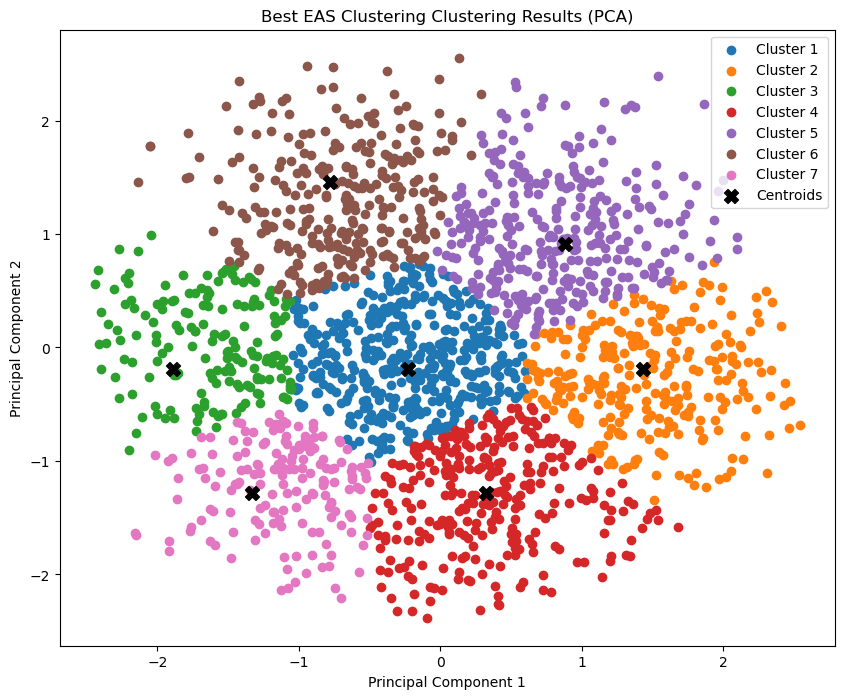

array([5, 4, 5, ..., 2, 6, 6], dtype=int64)

In [68]:
best_results = evaluate_clustering(X_scaled, best_labels, "Best EAS")
results.append(best_results)
visualize_clusters(X_scaled, best_labels, best_centroids, "Best EAS Clustering")

In [71]:
def ras_clustering(X, n_clusters, n_ants=30, n_iterations=100, alpha=1.0, beta=2.0, evaporation_rate=0.5, n_elites=10):
    """Rank-Based Ant System (RAS) for clustering"""
    n_samples, n_features = X.shape
    X_min, X_max = np.min(X, axis=0), np.max(X, axis=0)

    grid_size = 10
    grid_points = [np.linspace(X_min[f], X_max[f], grid_size) for f in range(n_features)]

    pheromone = np.ones([grid_size] * n_features)
    heuristic = np.ones([grid_size] * n_features)

    for point in X:
        grid_idx = [np.argmin(np.abs(grid_points[f] - point[f])) for f in range(n_features)]
        heuristic[tuple(grid_idx)] += 1
    heuristic = heuristic / np.sum(heuristic)

    best_centroids = None
    best_fitness = float('inf')

    for iteration in tqdm(range(n_iterations), desc="RAS Progress"):
        all_centroids = []
        all_fitness = []

        for ant in range(n_ants):
            centroids = []
            for _ in range(n_clusters):
                prob = (pheromone ** alpha) * (heuristic ** beta)
                prob /= np.sum(prob)
                flat_prob = prob.flatten()
                choice = np.random.choice(len(flat_prob), p=flat_prob)
                idx = np.unravel_index(choice, prob.shape)
                centroid = np.array([grid_points[f][idx[f]] for f in range(n_features)])
                centroids.append(centroid)
            centroids = np.array(centroids)

            fitness = calculate_fitness(X, centroids)
            all_centroids.append(centroids)
            all_fitness.append(fitness)

            if fitness < best_fitness:
                best_fitness = fitness
                best_centroids = centroids.copy()

        # ترتيب النمل حسب جودة الحل (fitness)
        sorted_indices = np.argsort(all_fitness)
        ranked_centroids = [all_centroids[i] for i in sorted_indices]
        ranked_fitness = [all_fitness[i] for i in sorted_indices]

        # تبخر الفيرومون
        pheromone = (1 - evaporation_rate) * pheromone

        # تحديث الفيرومون باستخدام أفضل n_elites نملة
        for rank in range(min(n_elites, n_ants)):
            weight = n_elites - rank
            fitness = ranked_fitness[rank]
            for centroid in ranked_centroids[rank]:
                grid_idx = [np.argmin(np.abs(grid_points[f] - centroid[f])) for f in range(n_features)]
                pheromone[tuple(grid_idx)] += weight * (1.0 / (fitness + 1e-10))

    final_labels = assign_clusters(X, best_centroids)
    return best_centroids, final_labels


In [73]:
from sklearn.metrics import silhouette_score
import itertools

def grid_search_ras(X, k, param_grid, n_iterations=100):
    best_score = -1
    best_params = None
    best_centroids = None
    best_labels = None

    # توليد جميع التركيبات الممكنة من القيم
    combinations = list(itertools.product(
        param_grid['n_ants'],
        param_grid['alpha'],
        param_grid['beta'],
        param_grid['evaporation_rate'],
        param_grid['n_elites']
    ))

    print(f"🔍 Total combinations to try: {len(combinations)}\n")

    for i, (n_ants, alpha, beta, evap, n_elites) in enumerate(combinations):
        print(f"▶️ Trying combination {i+1}/{len(combinations)}: "
              f"n_ants={n_ants}, alpha={alpha}, beta={beta}, evap={evap}, n_elites={n_elites}")

        centroids, labels = ras_clustering(
            X, k,
            n_ants=n_ants,
            n_iterations=n_iterations,
            alpha=alpha,
            beta=beta,
            evaporation_rate=evap,
            n_elites=n_elites
        )

        score = silhouette_score(X, labels)
        print(f"→ Silhouette Score: {score:.4f}\n")

        if score > best_score:
            best_score = score
            best_params = {
                'n_ants': n_ants,
                'alpha': alpha,
                'beta': beta,
                'evaporation_rate': evap,
                'n_elites': n_elites
            }
            best_centroids = centroids
            best_labels = labels

    print("✅ Best Parameters Found:")
    print(best_params)
    print(f"Best Silhouette Score: {best_score:.4f}")

    return best_centroids, best_labels, best_params


In [77]:
param_grid = {
    'n_ants': [20,40,60,80,100],
    'alpha': [0.5, 1.0, 2.0,3.0],
    'beta': [1.0, 2.0, 3.0],
    'evaporation_rate': [0.3, 0.5, 0.7,1.0],
    'n_elites': [5,10,15]
}

best_centroids, best_labels, best_params = grid_search_ras(
    X_scaled,
    optimal_k,
    param_grid,
    n_iterations=100  # مؤقتًا لتسريع التجربة
)



🔍 Total combinations to try: 720

▶️ Trying combination 1/720: n_ants=20, alpha=0.5, beta=1.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.10it/s]


→ Silhouette Score: 0.3351

▶️ Trying combination 2/720: n_ants=20, alpha=0.5, beta=1.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.62it/s]


→ Silhouette Score: 0.3134

▶️ Trying combination 3/720: n_ants=20, alpha=0.5, beta=1.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.13it/s]


→ Silhouette Score: 0.3175

▶️ Trying combination 4/720: n_ants=20, alpha=0.5, beta=1.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.75it/s]


→ Silhouette Score: 0.3228

▶️ Trying combination 5/720: n_ants=20, alpha=0.5, beta=1.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.34it/s]


→ Silhouette Score: 0.3317

▶️ Trying combination 6/720: n_ants=20, alpha=0.5, beta=1.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.47it/s]


→ Silhouette Score: 0.3071

▶️ Trying combination 7/720: n_ants=20, alpha=0.5, beta=1.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.64it/s]


→ Silhouette Score: 0.3078

▶️ Trying combination 8/720: n_ants=20, alpha=0.5, beta=1.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.95it/s]


→ Silhouette Score: 0.2895

▶️ Trying combination 9/720: n_ants=20, alpha=0.5, beta=1.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:04<00:00, 21.09it/s]


→ Silhouette Score: 0.3115

▶️ Trying combination 10/720: n_ants=20, alpha=0.5, beta=1.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.46it/s]


→ Silhouette Score: 0.2856

▶️ Trying combination 11/720: n_ants=20, alpha=0.5, beta=1.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.97it/s]


→ Silhouette Score: 0.2961

▶️ Trying combination 12/720: n_ants=20, alpha=0.5, beta=1.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.20it/s]


→ Silhouette Score: 0.2839

▶️ Trying combination 13/720: n_ants=20, alpha=0.5, beta=2.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.24it/s]


→ Silhouette Score: 0.3168

▶️ Trying combination 14/720: n_ants=20, alpha=0.5, beta=2.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.65it/s]


→ Silhouette Score: 0.2971

▶️ Trying combination 15/720: n_ants=20, alpha=0.5, beta=2.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.21it/s]


→ Silhouette Score: 0.3146

▶️ Trying combination 16/720: n_ants=20, alpha=0.5, beta=2.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.86it/s]


→ Silhouette Score: 0.2987

▶️ Trying combination 17/720: n_ants=20, alpha=0.5, beta=2.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.53it/s]


→ Silhouette Score: 0.2814

▶️ Trying combination 18/720: n_ants=20, alpha=0.5, beta=2.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 30.11it/s]


→ Silhouette Score: 0.2963

▶️ Trying combination 19/720: n_ants=20, alpha=0.5, beta=2.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.05it/s]


→ Silhouette Score: 0.2845

▶️ Trying combination 20/720: n_ants=20, alpha=0.5, beta=2.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.95it/s]


→ Silhouette Score: 0.3112

▶️ Trying combination 21/720: n_ants=20, alpha=0.5, beta=2.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:04<00:00, 20.15it/s]


→ Silhouette Score: 0.3238

▶️ Trying combination 22/720: n_ants=20, alpha=0.5, beta=2.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.64it/s]


→ Silhouette Score: 0.2739

▶️ Trying combination 23/720: n_ants=20, alpha=0.5, beta=2.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.15it/s]


→ Silhouette Score: 0.2953

▶️ Trying combination 24/720: n_ants=20, alpha=0.5, beta=2.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.00it/s]


→ Silhouette Score: 0.2737

▶️ Trying combination 25/720: n_ants=20, alpha=0.5, beta=3.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.83it/s]


→ Silhouette Score: 0.2951

▶️ Trying combination 26/720: n_ants=20, alpha=0.5, beta=3.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 32.15it/s]


→ Silhouette Score: 0.3217

▶️ Trying combination 27/720: n_ants=20, alpha=0.5, beta=3.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.77it/s]


→ Silhouette Score: 0.2513

▶️ Trying combination 28/720: n_ants=20, alpha=0.5, beta=3.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.48it/s]


→ Silhouette Score: 0.2913

▶️ Trying combination 29/720: n_ants=20, alpha=0.5, beta=3.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.96it/s]


→ Silhouette Score: 0.3229

▶️ Trying combination 30/720: n_ants=20, alpha=0.5, beta=3.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.18it/s]


→ Silhouette Score: 0.2964

▶️ Trying combination 31/720: n_ants=20, alpha=0.5, beta=3.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


→ Silhouette Score: 0.2499

▶️ Trying combination 32/720: n_ants=20, alpha=0.5, beta=3.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 30.35it/s]


→ Silhouette Score: 0.2870

▶️ Trying combination 33/720: n_ants=20, alpha=0.5, beta=3.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 31.18it/s]


→ Silhouette Score: 0.2861

▶️ Trying combination 34/720: n_ants=20, alpha=0.5, beta=3.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.53it/s]


→ Silhouette Score: 0.2859

▶️ Trying combination 35/720: n_ants=20, alpha=0.5, beta=3.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.24it/s]


→ Silhouette Score: 0.2390

▶️ Trying combination 36/720: n_ants=20, alpha=0.5, beta=3.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.30it/s]


→ Silhouette Score: 0.2618

▶️ Trying combination 37/720: n_ants=20, alpha=1.0, beta=1.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.60it/s]


→ Silhouette Score: 0.2850

▶️ Trying combination 38/720: n_ants=20, alpha=1.0, beta=1.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:04<00:00, 22.89it/s]


→ Silhouette Score: 0.3091

▶️ Trying combination 39/720: n_ants=20, alpha=1.0, beta=1.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.34it/s]


→ Silhouette Score: 0.3211

▶️ Trying combination 40/720: n_ants=20, alpha=1.0, beta=1.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.60it/s]


→ Silhouette Score: 0.3133

▶️ Trying combination 41/720: n_ants=20, alpha=1.0, beta=1.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


→ Silhouette Score: 0.3091

▶️ Trying combination 42/720: n_ants=20, alpha=1.0, beta=1.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 30.77it/s]


→ Silhouette Score: 0.3412

▶️ Trying combination 43/720: n_ants=20, alpha=1.0, beta=1.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.34it/s]


→ Silhouette Score: 0.3345

▶️ Trying combination 44/720: n_ants=20, alpha=1.0, beta=1.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 25.03it/s]


→ Silhouette Score: 0.2731

▶️ Trying combination 45/720: n_ants=20, alpha=1.0, beta=1.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.46it/s]


→ Silhouette Score: 0.2785

▶️ Trying combination 46/720: n_ants=20, alpha=1.0, beta=1.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.79it/s]


→ Silhouette Score: 0.3114

▶️ Trying combination 47/720: n_ants=20, alpha=1.0, beta=1.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 31.07it/s]


→ Silhouette Score: 0.3056

▶️ Trying combination 48/720: n_ants=20, alpha=1.0, beta=1.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.87it/s]


→ Silhouette Score: 0.3039

▶️ Trying combination 49/720: n_ants=20, alpha=1.0, beta=2.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.59it/s]


→ Silhouette Score: 0.3070

▶️ Trying combination 50/720: n_ants=20, alpha=1.0, beta=2.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 27.98it/s]


→ Silhouette Score: 0.3416

▶️ Trying combination 51/720: n_ants=20, alpha=1.0, beta=2.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.34it/s]


→ Silhouette Score: 0.2791

▶️ Trying combination 52/720: n_ants=20, alpha=1.0, beta=2.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.08it/s]


→ Silhouette Score: 0.3415

▶️ Trying combination 53/720: n_ants=20, alpha=1.0, beta=2.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.34it/s]


→ Silhouette Score: 0.2855

▶️ Trying combination 54/720: n_ants=20, alpha=1.0, beta=2.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:04<00:00, 24.76it/s]


→ Silhouette Score: 0.2747

▶️ Trying combination 55/720: n_ants=20, alpha=1.0, beta=2.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.60it/s]


→ Silhouette Score: 0.3091

▶️ Trying combination 56/720: n_ants=20, alpha=1.0, beta=2.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.66it/s]


→ Silhouette Score: 0.3158

▶️ Trying combination 57/720: n_ants=20, alpha=1.0, beta=2.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 29.02it/s]


→ Silhouette Score: 0.2869

▶️ Trying combination 58/720: n_ants=20, alpha=1.0, beta=2.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 33.33it/s]


→ Silhouette Score: 0.2605

▶️ Trying combination 59/720: n_ants=20, alpha=1.0, beta=2.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:02<00:00, 34.34it/s]


→ Silhouette Score: 0.2638

▶️ Trying combination 60/720: n_ants=20, alpha=1.0, beta=2.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 30.35it/s]


→ Silhouette Score: 0.3052

▶️ Trying combination 61/720: n_ants=20, alpha=1.0, beta=3.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 31.49it/s]


→ Silhouette Score: 0.3162

▶️ Trying combination 62/720: n_ants=20, alpha=1.0, beta=3.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 30.46it/s]


→ Silhouette Score: 0.3018

▶️ Trying combination 63/720: n_ants=20, alpha=1.0, beta=3.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 31.36it/s]


→ Silhouette Score: 0.2801

▶️ Trying combination 64/720: n_ants=20, alpha=1.0, beta=3.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 32.65it/s]


→ Silhouette Score: 0.3015

▶️ Trying combination 65/720: n_ants=20, alpha=1.0, beta=3.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 31.93it/s]


→ Silhouette Score: 0.2696

▶️ Trying combination 66/720: n_ants=20, alpha=1.0, beta=3.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 32.76it/s]


→ Silhouette Score: 0.2773

▶️ Trying combination 67/720: n_ants=20, alpha=1.0, beta=3.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:02<00:00, 33.89it/s]


→ Silhouette Score: 0.2806

▶️ Trying combination 68/720: n_ants=20, alpha=1.0, beta=3.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 33.33it/s]


→ Silhouette Score: 0.2563

▶️ Trying combination 69/720: n_ants=20, alpha=1.0, beta=3.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 31.58it/s]


→ Silhouette Score: 0.2719

▶️ Trying combination 70/720: n_ants=20, alpha=1.0, beta=3.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 31.64it/s]


→ Silhouette Score: 0.2676

▶️ Trying combination 71/720: n_ants=20, alpha=1.0, beta=3.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 30.87it/s]


→ Silhouette Score: 0.2387

▶️ Trying combination 72/720: n_ants=20, alpha=1.0, beta=3.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 30.93it/s]


→ Silhouette Score: 0.2728

▶️ Trying combination 73/720: n_ants=20, alpha=2.0, beta=1.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 32.78it/s]


→ Silhouette Score: 0.2896

▶️ Trying combination 74/720: n_ants=20, alpha=2.0, beta=1.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 32.74it/s]


→ Silhouette Score: 0.2911

▶️ Trying combination 75/720: n_ants=20, alpha=2.0, beta=1.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 32.11it/s]


→ Silhouette Score: 0.2494

▶️ Trying combination 76/720: n_ants=20, alpha=2.0, beta=1.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:02<00:00, 37.08it/s]


→ Silhouette Score: 0.2761

▶️ Trying combination 77/720: n_ants=20, alpha=2.0, beta=1.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:02<00:00, 33.79it/s]


→ Silhouette Score: 0.2711

▶️ Trying combination 78/720: n_ants=20, alpha=2.0, beta=1.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:02<00:00, 34.66it/s]


→ Silhouette Score: 0.2299

▶️ Trying combination 79/720: n_ants=20, alpha=2.0, beta=1.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:02<00:00, 36.00it/s]


→ Silhouette Score: 0.3121

▶️ Trying combination 80/720: n_ants=20, alpha=2.0, beta=1.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:02<00:00, 33.60it/s]


→ Silhouette Score: 0.2827

▶️ Trying combination 81/720: n_ants=20, alpha=2.0, beta=1.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:02<00:00, 34.54it/s]


→ Silhouette Score: 0.2952

▶️ Trying combination 82/720: n_ants=20, alpha=2.0, beta=1.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:02<00:00, 36.46it/s]


→ Silhouette Score: 0.2766

▶️ Trying combination 83/720: n_ants=20, alpha=2.0, beta=1.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:02<00:00, 35.58it/s]


→ Silhouette Score: 0.3120

▶️ Trying combination 84/720: n_ants=20, alpha=2.0, beta=1.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 32.66it/s]


→ Silhouette Score: 0.3056

▶️ Trying combination 85/720: n_ants=20, alpha=2.0, beta=2.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:02<00:00, 34.45it/s]


→ Silhouette Score: 0.2743

▶️ Trying combination 86/720: n_ants=20, alpha=2.0, beta=2.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:02<00:00, 34.72it/s]


→ Silhouette Score: 0.2775

▶️ Trying combination 87/720: n_ants=20, alpha=2.0, beta=2.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 33.21it/s]


→ Silhouette Score: 0.2955

▶️ Trying combination 88/720: n_ants=20, alpha=2.0, beta=2.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:02<00:00, 36.17it/s]


→ Silhouette Score: 0.2965

▶️ Trying combination 89/720: n_ants=20, alpha=2.0, beta=2.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:02<00:00, 35.24it/s]


→ Silhouette Score: 0.3068

▶️ Trying combination 90/720: n_ants=20, alpha=2.0, beta=2.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 32.18it/s]


→ Silhouette Score: 0.3009

▶️ Trying combination 91/720: n_ants=20, alpha=2.0, beta=2.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:02<00:00, 33.83it/s]


→ Silhouette Score: 0.3196

▶️ Trying combination 92/720: n_ants=20, alpha=2.0, beta=2.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:02<00:00, 36.15it/s]


→ Silhouette Score: 0.2860

▶️ Trying combination 93/720: n_ants=20, alpha=2.0, beta=2.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:02<00:00, 35.59it/s]


→ Silhouette Score: 0.2819

▶️ Trying combination 94/720: n_ants=20, alpha=2.0, beta=2.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:02<00:00, 35.90it/s]


→ Silhouette Score: 0.2972

▶️ Trying combination 95/720: n_ants=20, alpha=2.0, beta=2.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:02<00:00, 37.95it/s]


→ Silhouette Score: 0.2628

▶️ Trying combination 96/720: n_ants=20, alpha=2.0, beta=2.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:02<00:00, 34.41it/s]


→ Silhouette Score: 0.2719

▶️ Trying combination 97/720: n_ants=20, alpha=2.0, beta=3.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 33.02it/s]


→ Silhouette Score: 0.2685

▶️ Trying combination 98/720: n_ants=20, alpha=2.0, beta=3.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 31.62it/s]


→ Silhouette Score: 0.2835

▶️ Trying combination 99/720: n_ants=20, alpha=2.0, beta=3.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:02<00:00, 33.80it/s]


→ Silhouette Score: 0.2779

▶️ Trying combination 100/720: n_ants=20, alpha=2.0, beta=3.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:02<00:00, 34.76it/s]


→ Silhouette Score: 0.2604

▶️ Trying combination 101/720: n_ants=20, alpha=2.0, beta=3.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 30.21it/s]


→ Silhouette Score: 0.2984

▶️ Trying combination 102/720: n_ants=20, alpha=2.0, beta=3.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 30.75it/s]


→ Silhouette Score: 0.2981

▶️ Trying combination 103/720: n_ants=20, alpha=2.0, beta=3.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.25it/s]


→ Silhouette Score: 0.2938

▶️ Trying combination 104/720: n_ants=20, alpha=2.0, beta=3.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 32.90it/s]


→ Silhouette Score: 0.2629

▶️ Trying combination 105/720: n_ants=20, alpha=2.0, beta=3.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 31.31it/s]


→ Silhouette Score: 0.2764

▶️ Trying combination 106/720: n_ants=20, alpha=2.0, beta=3.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:02<00:00, 33.85it/s]


→ Silhouette Score: 0.2592

▶️ Trying combination 107/720: n_ants=20, alpha=2.0, beta=3.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:02<00:00, 33.59it/s]


→ Silhouette Score: 0.2730

▶️ Trying combination 108/720: n_ants=20, alpha=2.0, beta=3.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:02<00:00, 34.37it/s]


→ Silhouette Score: 0.2803

▶️ Trying combination 109/720: n_ants=20, alpha=3.0, beta=1.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 31.76it/s]


→ Silhouette Score: 0.3029

▶️ Trying combination 110/720: n_ants=20, alpha=3.0, beta=1.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 31.84it/s]


→ Silhouette Score: 0.3093

▶️ Trying combination 111/720: n_ants=20, alpha=3.0, beta=1.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:02<00:00, 33.65it/s]


→ Silhouette Score: 0.2898

▶️ Trying combination 112/720: n_ants=20, alpha=3.0, beta=1.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:02<00:00, 33.90it/s]


→ Silhouette Score: 0.2650

▶️ Trying combination 113/720: n_ants=20, alpha=3.0, beta=1.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.13it/s]


→ Silhouette Score: 0.3101

▶️ Trying combination 114/720: n_ants=20, alpha=3.0, beta=1.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.49it/s]


→ Silhouette Score: 0.2901

▶️ Trying combination 115/720: n_ants=20, alpha=3.0, beta=1.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:02<00:00, 33.36it/s]


→ Silhouette Score: 0.2687

▶️ Trying combination 116/720: n_ants=20, alpha=3.0, beta=1.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:02<00:00, 34.19it/s]


→ Silhouette Score: 0.2836

▶️ Trying combination 117/720: n_ants=20, alpha=3.0, beta=1.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:02<00:00, 33.52it/s]


→ Silhouette Score: 0.2978

▶️ Trying combination 118/720: n_ants=20, alpha=3.0, beta=1.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:02<00:00, 35.56it/s]


→ Silhouette Score: 0.3282

▶️ Trying combination 119/720: n_ants=20, alpha=3.0, beta=1.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:02<00:00, 33.75it/s]


→ Silhouette Score: 0.2565

▶️ Trying combination 120/720: n_ants=20, alpha=3.0, beta=1.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:02<00:00, 34.71it/s]


→ Silhouette Score: 0.2962

▶️ Trying combination 121/720: n_ants=20, alpha=3.0, beta=2.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:02<00:00, 35.15it/s]


→ Silhouette Score: 0.2952

▶️ Trying combination 122/720: n_ants=20, alpha=3.0, beta=2.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:02<00:00, 34.88it/s]


→ Silhouette Score: 0.3122

▶️ Trying combination 123/720: n_ants=20, alpha=3.0, beta=2.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 32.83it/s]


→ Silhouette Score: 0.2719

▶️ Trying combination 124/720: n_ants=20, alpha=3.0, beta=2.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 32.43it/s]


→ Silhouette Score: 0.3098

▶️ Trying combination 125/720: n_ants=20, alpha=3.0, beta=2.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 32.29it/s]


→ Silhouette Score: 0.2723

▶️ Trying combination 126/720: n_ants=20, alpha=3.0, beta=2.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:02<00:00, 33.47it/s]


→ Silhouette Score: 0.2952

▶️ Trying combination 127/720: n_ants=20, alpha=3.0, beta=2.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 31.40it/s]


→ Silhouette Score: 0.2685

▶️ Trying combination 128/720: n_ants=20, alpha=3.0, beta=2.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 32.88it/s]


→ Silhouette Score: 0.2804

▶️ Trying combination 129/720: n_ants=20, alpha=3.0, beta=2.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 31.96it/s]


→ Silhouette Score: 0.3068

▶️ Trying combination 130/720: n_ants=20, alpha=3.0, beta=2.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:02<00:00, 34.07it/s]


→ Silhouette Score: 0.2619

▶️ Trying combination 131/720: n_ants=20, alpha=3.0, beta=2.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 31.48it/s]


→ Silhouette Score: 0.2965

▶️ Trying combination 132/720: n_ants=20, alpha=3.0, beta=2.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 31.70it/s]


→ Silhouette Score: 0.2779

▶️ Trying combination 133/720: n_ants=20, alpha=3.0, beta=3.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 26.02it/s]


→ Silhouette Score: 0.2586

▶️ Trying combination 134/720: n_ants=20, alpha=3.0, beta=3.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 28.87it/s]


→ Silhouette Score: 0.2623

▶️ Trying combination 135/720: n_ants=20, alpha=3.0, beta=3.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 30.48it/s]


→ Silhouette Score: 0.2599

▶️ Trying combination 136/720: n_ants=20, alpha=3.0, beta=3.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 32.28it/s]


→ Silhouette Score: 0.3160

▶️ Trying combination 137/720: n_ants=20, alpha=3.0, beta=3.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 31.98it/s]


→ Silhouette Score: 0.2747

▶️ Trying combination 138/720: n_ants=20, alpha=3.0, beta=3.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 31.50it/s]


→ Silhouette Score: 0.2684

▶️ Trying combination 139/720: n_ants=20, alpha=3.0, beta=3.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 32.13it/s]


→ Silhouette Score: 0.2601

▶️ Trying combination 140/720: n_ants=20, alpha=3.0, beta=3.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 31.75it/s]


→ Silhouette Score: 0.2483

▶️ Trying combination 141/720: n_ants=20, alpha=3.0, beta=3.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:02<00:00, 33.33it/s]


→ Silhouette Score: 0.2632

▶️ Trying combination 142/720: n_ants=20, alpha=3.0, beta=3.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 33.17it/s]


→ Silhouette Score: 0.2739

▶️ Trying combination 143/720: n_ants=20, alpha=3.0, beta=3.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 31.94it/s]


→ Silhouette Score: 0.2950

▶️ Trying combination 144/720: n_ants=20, alpha=3.0, beta=3.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:03<00:00, 32.90it/s]


→ Silhouette Score: 0.2922

▶️ Trying combination 145/720: n_ants=40, alpha=0.5, beta=1.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.49it/s]


→ Silhouette Score: 0.3389

▶️ Trying combination 146/720: n_ants=40, alpha=0.5, beta=1.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.19it/s]


→ Silhouette Score: 0.3345

▶️ Trying combination 147/720: n_ants=40, alpha=0.5, beta=1.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.28it/s]


→ Silhouette Score: 0.3369

▶️ Trying combination 148/720: n_ants=40, alpha=0.5, beta=1.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.71it/s]


→ Silhouette Score: 0.3178

▶️ Trying combination 149/720: n_ants=40, alpha=0.5, beta=1.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.17it/s]


→ Silhouette Score: 0.3047

▶️ Trying combination 150/720: n_ants=40, alpha=0.5, beta=1.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.87it/s]


→ Silhouette Score: 0.3092

▶️ Trying combination 151/720: n_ants=40, alpha=0.5, beta=1.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.45it/s]


→ Silhouette Score: 0.3196

▶️ Trying combination 152/720: n_ants=40, alpha=0.5, beta=1.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.89it/s]


→ Silhouette Score: 0.3100

▶️ Trying combination 153/720: n_ants=40, alpha=0.5, beta=1.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.83it/s]


→ Silhouette Score: 0.3261

▶️ Trying combination 154/720: n_ants=40, alpha=0.5, beta=1.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.88it/s]


→ Silhouette Score: 0.2928

▶️ Trying combination 155/720: n_ants=40, alpha=0.5, beta=1.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.97it/s]


→ Silhouette Score: 0.2920

▶️ Trying combination 156/720: n_ants=40, alpha=0.5, beta=1.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.00it/s]


→ Silhouette Score: 0.3043

▶️ Trying combination 157/720: n_ants=40, alpha=0.5, beta=2.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.30it/s]


→ Silhouette Score: 0.3250

▶️ Trying combination 158/720: n_ants=40, alpha=0.5, beta=2.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.01it/s]


→ Silhouette Score: 0.3268

▶️ Trying combination 159/720: n_ants=40, alpha=0.5, beta=2.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.67it/s]


→ Silhouette Score: 0.2959

▶️ Trying combination 160/720: n_ants=40, alpha=0.5, beta=2.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.42it/s]


→ Silhouette Score: 0.3448

▶️ Trying combination 161/720: n_ants=40, alpha=0.5, beta=2.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.40it/s]


→ Silhouette Score: 0.3162

▶️ Trying combination 162/720: n_ants=40, alpha=0.5, beta=2.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.84it/s]


→ Silhouette Score: 0.2989

▶️ Trying combination 163/720: n_ants=40, alpha=0.5, beta=2.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.88it/s]


→ Silhouette Score: 0.3021

▶️ Trying combination 164/720: n_ants=40, alpha=0.5, beta=2.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.70it/s]


→ Silhouette Score: 0.3306

▶️ Trying combination 165/720: n_ants=40, alpha=0.5, beta=2.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.91it/s]


→ Silhouette Score: 0.3109

▶️ Trying combination 166/720: n_ants=40, alpha=0.5, beta=2.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.43it/s]


→ Silhouette Score: 0.2271

▶️ Trying combination 167/720: n_ants=40, alpha=0.5, beta=2.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.54it/s]


→ Silhouette Score: 0.3041

▶️ Trying combination 168/720: n_ants=40, alpha=0.5, beta=2.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.86it/s]


→ Silhouette Score: 0.2754

▶️ Trying combination 169/720: n_ants=40, alpha=0.5, beta=3.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.15it/s]


→ Silhouette Score: 0.2889

▶️ Trying combination 170/720: n_ants=40, alpha=0.5, beta=3.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.01it/s]


→ Silhouette Score: 0.3166

▶️ Trying combination 171/720: n_ants=40, alpha=0.5, beta=3.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.21it/s]


→ Silhouette Score: 0.2652

▶️ Trying combination 172/720: n_ants=40, alpha=0.5, beta=3.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.42it/s]


→ Silhouette Score: 0.3031

▶️ Trying combination 173/720: n_ants=40, alpha=0.5, beta=3.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.43it/s]


→ Silhouette Score: 0.2817

▶️ Trying combination 174/720: n_ants=40, alpha=0.5, beta=3.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.51it/s]


→ Silhouette Score: 0.3103

▶️ Trying combination 175/720: n_ants=40, alpha=0.5, beta=3.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.82it/s]


→ Silhouette Score: 0.2680

▶️ Trying combination 176/720: n_ants=40, alpha=0.5, beta=3.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.51it/s]


→ Silhouette Score: 0.2994

▶️ Trying combination 177/720: n_ants=40, alpha=0.5, beta=3.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.98it/s]


→ Silhouette Score: 0.3096

▶️ Trying combination 178/720: n_ants=40, alpha=0.5, beta=3.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.71it/s]


→ Silhouette Score: 0.2830

▶️ Trying combination 179/720: n_ants=40, alpha=0.5, beta=3.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.99it/s]


→ Silhouette Score: 0.2780

▶️ Trying combination 180/720: n_ants=40, alpha=0.5, beta=3.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 14.28it/s]


→ Silhouette Score: 0.2762

▶️ Trying combination 181/720: n_ants=40, alpha=1.0, beta=1.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.21it/s]


→ Silhouette Score: 0.3314

▶️ Trying combination 182/720: n_ants=40, alpha=1.0, beta=1.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.35it/s]


→ Silhouette Score: 0.3322

▶️ Trying combination 183/720: n_ants=40, alpha=1.0, beta=1.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 19.09it/s]


→ Silhouette Score: 0.3052

▶️ Trying combination 184/720: n_ants=40, alpha=1.0, beta=1.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.69it/s]


→ Silhouette Score: 0.3141

▶️ Trying combination 185/720: n_ants=40, alpha=1.0, beta=1.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.92it/s]


→ Silhouette Score: 0.3144

▶️ Trying combination 186/720: n_ants=40, alpha=1.0, beta=1.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.16it/s]


→ Silhouette Score: 0.3105

▶️ Trying combination 187/720: n_ants=40, alpha=1.0, beta=1.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.91it/s]


→ Silhouette Score: 0.2812

▶️ Trying combination 188/720: n_ants=40, alpha=1.0, beta=1.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.38it/s]


→ Silhouette Score: 0.3129

▶️ Trying combination 189/720: n_ants=40, alpha=1.0, beta=1.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.39it/s]


→ Silhouette Score: 0.2917

▶️ Trying combination 190/720: n_ants=40, alpha=1.0, beta=1.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.58it/s]


→ Silhouette Score: 0.3113

▶️ Trying combination 191/720: n_ants=40, alpha=1.0, beta=1.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.62it/s]


→ Silhouette Score: 0.2926

▶️ Trying combination 192/720: n_ants=40, alpha=1.0, beta=1.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.43it/s]


→ Silhouette Score: 0.2921

▶️ Trying combination 193/720: n_ants=40, alpha=1.0, beta=2.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.02it/s]


→ Silhouette Score: 0.3229

▶️ Trying combination 194/720: n_ants=40, alpha=1.0, beta=2.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.80it/s]


→ Silhouette Score: 0.3263

▶️ Trying combination 195/720: n_ants=40, alpha=1.0, beta=2.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.22it/s]


→ Silhouette Score: 0.3070

▶️ Trying combination 196/720: n_ants=40, alpha=1.0, beta=2.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.42it/s]


→ Silhouette Score: 0.3285

▶️ Trying combination 197/720: n_ants=40, alpha=1.0, beta=2.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.56it/s]


→ Silhouette Score: 0.2960

▶️ Trying combination 198/720: n_ants=40, alpha=1.0, beta=2.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.77it/s]


→ Silhouette Score: 0.3206

▶️ Trying combination 199/720: n_ants=40, alpha=1.0, beta=2.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.58it/s]


→ Silhouette Score: 0.2899

▶️ Trying combination 200/720: n_ants=40, alpha=1.0, beta=2.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:06<00:00, 15.29it/s]


→ Silhouette Score: 0.3385

▶️ Trying combination 201/720: n_ants=40, alpha=1.0, beta=2.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.44it/s]


→ Silhouette Score: 0.2796

▶️ Trying combination 202/720: n_ants=40, alpha=1.0, beta=2.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.40it/s]


→ Silhouette Score: 0.2889

▶️ Trying combination 203/720: n_ants=40, alpha=1.0, beta=2.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.73it/s]


→ Silhouette Score: 0.2924

▶️ Trying combination 204/720: n_ants=40, alpha=1.0, beta=2.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 19.17it/s]


→ Silhouette Score: 0.2714

▶️ Trying combination 205/720: n_ants=40, alpha=1.0, beta=3.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.82it/s]


→ Silhouette Score: 0.3105

▶️ Trying combination 206/720: n_ants=40, alpha=1.0, beta=3.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 16.87it/s]


→ Silhouette Score: 0.3259

▶️ Trying combination 207/720: n_ants=40, alpha=1.0, beta=3.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 19.59it/s]


→ Silhouette Score: 0.2714

▶️ Trying combination 208/720: n_ants=40, alpha=1.0, beta=3.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.06it/s]


→ Silhouette Score: 0.2945

▶️ Trying combination 209/720: n_ants=40, alpha=1.0, beta=3.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.57it/s]


→ Silhouette Score: 0.2552

▶️ Trying combination 210/720: n_ants=40, alpha=1.0, beta=3.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.31it/s]


→ Silhouette Score: 0.2525

▶️ Trying combination 211/720: n_ants=40, alpha=1.0, beta=3.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.56it/s]


→ Silhouette Score: 0.2860

▶️ Trying combination 212/720: n_ants=40, alpha=1.0, beta=3.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.67it/s]


→ Silhouette Score: 0.2674

▶️ Trying combination 213/720: n_ants=40, alpha=1.0, beta=3.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.76it/s]


→ Silhouette Score: 0.3129

▶️ Trying combination 214/720: n_ants=40, alpha=1.0, beta=3.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 19.19it/s]


→ Silhouette Score: 0.3049

▶️ Trying combination 215/720: n_ants=40, alpha=1.0, beta=3.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 19.51it/s]


→ Silhouette Score: 0.2550

▶️ Trying combination 216/720: n_ants=40, alpha=1.0, beta=3.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.16it/s]


→ Silhouette Score: 0.2715

▶️ Trying combination 217/720: n_ants=40, alpha=2.0, beta=1.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.75it/s]


→ Silhouette Score: 0.3216

▶️ Trying combination 218/720: n_ants=40, alpha=2.0, beta=1.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 19.33it/s]


→ Silhouette Score: 0.3044

▶️ Trying combination 219/720: n_ants=40, alpha=2.0, beta=1.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:04<00:00, 20.68it/s]


→ Silhouette Score: 0.2967

▶️ Trying combination 220/720: n_ants=40, alpha=2.0, beta=1.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.44it/s]


→ Silhouette Score: 0.3417

▶️ Trying combination 221/720: n_ants=40, alpha=2.0, beta=1.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.74it/s]


→ Silhouette Score: 0.2588

▶️ Trying combination 222/720: n_ants=40, alpha=2.0, beta=1.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.05it/s]


→ Silhouette Score: 0.2659

▶️ Trying combination 223/720: n_ants=40, alpha=2.0, beta=1.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 19.29it/s]


→ Silhouette Score: 0.2936

▶️ Trying combination 224/720: n_ants=40, alpha=2.0, beta=1.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:04<00:00, 20.17it/s]


→ Silhouette Score: 0.2753

▶️ Trying combination 225/720: n_ants=40, alpha=2.0, beta=1.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:04<00:00, 20.64it/s]


→ Silhouette Score: 0.2864

▶️ Trying combination 226/720: n_ants=40, alpha=2.0, beta=1.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:04<00:00, 22.25it/s]


→ Silhouette Score: 0.2563

▶️ Trying combination 227/720: n_ants=40, alpha=2.0, beta=1.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:04<00:00, 20.26it/s]


→ Silhouette Score: 0.3021

▶️ Trying combination 228/720: n_ants=40, alpha=2.0, beta=1.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:04<00:00, 20.99it/s]


→ Silhouette Score: 0.2524

▶️ Trying combination 229/720: n_ants=40, alpha=2.0, beta=2.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 19.99it/s]


→ Silhouette Score: 0.2968

▶️ Trying combination 230/720: n_ants=40, alpha=2.0, beta=2.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:04<00:00, 20.91it/s]


→ Silhouette Score: 0.2916

▶️ Trying combination 231/720: n_ants=40, alpha=2.0, beta=2.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.92it/s]


→ Silhouette Score: 0.2989

▶️ Trying combination 232/720: n_ants=40, alpha=2.0, beta=2.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:04<00:00, 20.54it/s]


→ Silhouette Score: 0.3196

▶️ Trying combination 233/720: n_ants=40, alpha=2.0, beta=2.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 19.55it/s]


→ Silhouette Score: 0.2975

▶️ Trying combination 234/720: n_ants=40, alpha=2.0, beta=2.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.35it/s]


→ Silhouette Score: 0.2706

▶️ Trying combination 235/720: n_ants=40, alpha=2.0, beta=2.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.40it/s]


→ Silhouette Score: 0.2821

▶️ Trying combination 236/720: n_ants=40, alpha=2.0, beta=2.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 19.82it/s]


→ Silhouette Score: 0.2831

▶️ Trying combination 237/720: n_ants=40, alpha=2.0, beta=2.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:04<00:00, 20.06it/s]


→ Silhouette Score: 0.2868

▶️ Trying combination 238/720: n_ants=40, alpha=2.0, beta=2.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 19.30it/s]


→ Silhouette Score: 0.2792

▶️ Trying combination 239/720: n_ants=40, alpha=2.0, beta=2.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:04<00:00, 20.89it/s]


→ Silhouette Score: 0.2578

▶️ Trying combination 240/720: n_ants=40, alpha=2.0, beta=2.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:04<00:00, 20.59it/s]


→ Silhouette Score: 0.2932

▶️ Trying combination 241/720: n_ants=40, alpha=2.0, beta=3.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 19.21it/s]


→ Silhouette Score: 0.2818

▶️ Trying combination 242/720: n_ants=40, alpha=2.0, beta=3.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.02it/s]


→ Silhouette Score: 0.2666

▶️ Trying combination 243/720: n_ants=40, alpha=2.0, beta=3.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:04<00:00, 20.05it/s]


→ Silhouette Score: 0.2952

▶️ Trying combination 244/720: n_ants=40, alpha=2.0, beta=3.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.89it/s]


→ Silhouette Score: 0.2761

▶️ Trying combination 245/720: n_ants=40, alpha=2.0, beta=3.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:04<00:00, 20.09it/s]


→ Silhouette Score: 0.2823

▶️ Trying combination 246/720: n_ants=40, alpha=2.0, beta=3.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.92it/s]


→ Silhouette Score: 0.2909

▶️ Trying combination 247/720: n_ants=40, alpha=2.0, beta=3.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 19.69it/s]


→ Silhouette Score: 0.2758

▶️ Trying combination 248/720: n_ants=40, alpha=2.0, beta=3.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.30it/s]


→ Silhouette Score: 0.2970

▶️ Trying combination 249/720: n_ants=40, alpha=2.0, beta=3.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.54it/s]


→ Silhouette Score: 0.3106

▶️ Trying combination 250/720: n_ants=40, alpha=2.0, beta=3.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.29it/s]


→ Silhouette Score: 0.2944

▶️ Trying combination 251/720: n_ants=40, alpha=2.0, beta=3.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.53it/s]


→ Silhouette Score: 0.2159

▶️ Trying combination 252/720: n_ants=40, alpha=2.0, beta=3.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.82it/s]


→ Silhouette Score: 0.2494

▶️ Trying combination 253/720: n_ants=40, alpha=3.0, beta=1.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.64it/s]


→ Silhouette Score: 0.2989

▶️ Trying combination 254/720: n_ants=40, alpha=3.0, beta=1.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.73it/s]


→ Silhouette Score: 0.3409

▶️ Trying combination 255/720: n_ants=40, alpha=3.0, beta=1.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.76it/s]


→ Silhouette Score: 0.2893

▶️ Trying combination 256/720: n_ants=40, alpha=3.0, beta=1.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:04<00:00, 20.93it/s]


→ Silhouette Score: 0.2884

▶️ Trying combination 257/720: n_ants=40, alpha=3.0, beta=1.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:04<00:00, 20.16it/s]


→ Silhouette Score: 0.2992

▶️ Trying combination 258/720: n_ants=40, alpha=3.0, beta=1.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:04<00:00, 20.04it/s]


→ Silhouette Score: 0.2868

▶️ Trying combination 259/720: n_ants=40, alpha=3.0, beta=1.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 19.72it/s]


→ Silhouette Score: 0.3053

▶️ Trying combination 260/720: n_ants=40, alpha=3.0, beta=1.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.76it/s]


→ Silhouette Score: 0.3267

▶️ Trying combination 261/720: n_ants=40, alpha=3.0, beta=1.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 19.02it/s]


→ Silhouette Score: 0.2637

▶️ Trying combination 262/720: n_ants=40, alpha=3.0, beta=1.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:04<00:00, 21.94it/s]


→ Silhouette Score: 0.2949

▶️ Trying combination 263/720: n_ants=40, alpha=3.0, beta=1.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:04<00:00, 21.28it/s]


→ Silhouette Score: 0.2554

▶️ Trying combination 264/720: n_ants=40, alpha=3.0, beta=1.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.64it/s]


→ Silhouette Score: 0.2876

▶️ Trying combination 265/720: n_ants=40, alpha=3.0, beta=2.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.82it/s]


→ Silhouette Score: 0.3024

▶️ Trying combination 266/720: n_ants=40, alpha=3.0, beta=2.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.34it/s]


→ Silhouette Score: 0.3199

▶️ Trying combination 267/720: n_ants=40, alpha=3.0, beta=2.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.93it/s]


→ Silhouette Score: 0.3082

▶️ Trying combination 268/720: n_ants=40, alpha=3.0, beta=2.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:04<00:00, 20.73it/s]


→ Silhouette Score: 0.2842

▶️ Trying combination 269/720: n_ants=40, alpha=3.0, beta=2.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 19.21it/s]


→ Silhouette Score: 0.2976

▶️ Trying combination 270/720: n_ants=40, alpha=3.0, beta=2.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.41it/s]


→ Silhouette Score: 0.2561

▶️ Trying combination 271/720: n_ants=40, alpha=3.0, beta=2.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 19.38it/s]


→ Silhouette Score: 0.2985

▶️ Trying combination 272/720: n_ants=40, alpha=3.0, beta=2.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 19.93it/s]


→ Silhouette Score: 0.3123

▶️ Trying combination 273/720: n_ants=40, alpha=3.0, beta=2.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:04<00:00, 20.08it/s]


→ Silhouette Score: 0.3108

▶️ Trying combination 274/720: n_ants=40, alpha=3.0, beta=2.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:04<00:00, 20.76it/s]


→ Silhouette Score: 0.2953

▶️ Trying combination 275/720: n_ants=40, alpha=3.0, beta=2.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 19.16it/s]


→ Silhouette Score: 0.3153

▶️ Trying combination 276/720: n_ants=40, alpha=3.0, beta=2.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 19.23it/s]


→ Silhouette Score: 0.2809

▶️ Trying combination 277/720: n_ants=40, alpha=3.0, beta=3.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:06<00:00, 16.62it/s]


→ Silhouette Score: 0.3099

▶️ Trying combination 278/720: n_ants=40, alpha=3.0, beta=3.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.94it/s]


→ Silhouette Score: 0.3211

▶️ Trying combination 279/720: n_ants=40, alpha=3.0, beta=3.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.42it/s]


→ Silhouette Score: 0.2761

▶️ Trying combination 280/720: n_ants=40, alpha=3.0, beta=3.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 19.07it/s]


→ Silhouette Score: 0.2950

▶️ Trying combination 281/720: n_ants=40, alpha=3.0, beta=3.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.68it/s]


→ Silhouette Score: 0.2717

▶️ Trying combination 282/720: n_ants=40, alpha=3.0, beta=3.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 19.35it/s]


→ Silhouette Score: 0.2776

▶️ Trying combination 283/720: n_ants=40, alpha=3.0, beta=3.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 19.80it/s]


→ Silhouette Score: 0.2763

▶️ Trying combination 284/720: n_ants=40, alpha=3.0, beta=3.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:04<00:00, 20.31it/s]


→ Silhouette Score: 0.2910

▶️ Trying combination 285/720: n_ants=40, alpha=3.0, beta=3.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 19.46it/s]


→ Silhouette Score: 0.3086

▶️ Trying combination 286/720: n_ants=40, alpha=3.0, beta=3.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 19.41it/s]


→ Silhouette Score: 0.2874

▶️ Trying combination 287/720: n_ants=40, alpha=3.0, beta=3.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 17.46it/s]


→ Silhouette Score: 0.3042

▶️ Trying combination 288/720: n_ants=40, alpha=3.0, beta=3.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:05<00:00, 18.61it/s]


→ Silhouette Score: 0.2495

▶️ Trying combination 289/720: n_ants=60, alpha=0.5, beta=1.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.93it/s]


→ Silhouette Score: 0.3328

▶️ Trying combination 290/720: n_ants=60, alpha=0.5, beta=1.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.69it/s]


→ Silhouette Score: 0.3101

▶️ Trying combination 291/720: n_ants=60, alpha=0.5, beta=1.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.05it/s]


→ Silhouette Score: 0.3200

▶️ Trying combination 292/720: n_ants=60, alpha=0.5, beta=1.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.41it/s]


→ Silhouette Score: 0.3237

▶️ Trying combination 293/720: n_ants=60, alpha=0.5, beta=1.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.12it/s]


→ Silhouette Score: 0.3180

▶️ Trying combination 294/720: n_ants=60, alpha=0.5, beta=1.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.91it/s]


→ Silhouette Score: 0.3160

▶️ Trying combination 295/720: n_ants=60, alpha=0.5, beta=1.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.66it/s]


→ Silhouette Score: 0.3275

▶️ Trying combination 296/720: n_ants=60, alpha=0.5, beta=1.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.19it/s]


→ Silhouette Score: 0.3187

▶️ Trying combination 297/720: n_ants=60, alpha=0.5, beta=1.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.91it/s]


→ Silhouette Score: 0.3320

▶️ Trying combination 298/720: n_ants=60, alpha=0.5, beta=1.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.21it/s]


→ Silhouette Score: 0.3172

▶️ Trying combination 299/720: n_ants=60, alpha=0.5, beta=1.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.65it/s]


→ Silhouette Score: 0.3160

▶️ Trying combination 300/720: n_ants=60, alpha=0.5, beta=1.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.70it/s]


→ Silhouette Score: 0.3108

▶️ Trying combination 301/720: n_ants=60, alpha=0.5, beta=2.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.25it/s]


→ Silhouette Score: 0.3126

▶️ Trying combination 302/720: n_ants=60, alpha=0.5, beta=2.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.54it/s]


→ Silhouette Score: 0.3145

▶️ Trying combination 303/720: n_ants=60, alpha=0.5, beta=2.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.16it/s]


→ Silhouette Score: 0.3046

▶️ Trying combination 304/720: n_ants=60, alpha=0.5, beta=2.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.65it/s]


→ Silhouette Score: 0.3107

▶️ Trying combination 305/720: n_ants=60, alpha=0.5, beta=2.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.15it/s]


→ Silhouette Score: 0.3105

▶️ Trying combination 306/720: n_ants=60, alpha=0.5, beta=2.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.35it/s]


→ Silhouette Score: 0.3165

▶️ Trying combination 307/720: n_ants=60, alpha=0.5, beta=2.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.68it/s]


→ Silhouette Score: 0.3103

▶️ Trying combination 308/720: n_ants=60, alpha=0.5, beta=2.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.96it/s]


→ Silhouette Score: 0.3091

▶️ Trying combination 309/720: n_ants=60, alpha=0.5, beta=2.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.12it/s]


→ Silhouette Score: 0.2987

▶️ Trying combination 310/720: n_ants=60, alpha=0.5, beta=2.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.15it/s]


→ Silhouette Score: 0.2979

▶️ Trying combination 311/720: n_ants=60, alpha=0.5, beta=2.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.34it/s]


→ Silhouette Score: 0.3076

▶️ Trying combination 312/720: n_ants=60, alpha=0.5, beta=2.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.77it/s]


→ Silhouette Score: 0.3011

▶️ Trying combination 313/720: n_ants=60, alpha=0.5, beta=3.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.78it/s]


→ Silhouette Score: 0.2880

▶️ Trying combination 314/720: n_ants=60, alpha=0.5, beta=3.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.24it/s]


→ Silhouette Score: 0.2954

▶️ Trying combination 315/720: n_ants=60, alpha=0.5, beta=3.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.72it/s]


→ Silhouette Score: 0.2943

▶️ Trying combination 316/720: n_ants=60, alpha=0.5, beta=3.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.88it/s]


→ Silhouette Score: 0.3110

▶️ Trying combination 317/720: n_ants=60, alpha=0.5, beta=3.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.48it/s]


→ Silhouette Score: 0.3075

▶️ Trying combination 318/720: n_ants=60, alpha=0.5, beta=3.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.96it/s]


→ Silhouette Score: 0.2856

▶️ Trying combination 319/720: n_ants=60, alpha=0.5, beta=3.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.73it/s]


→ Silhouette Score: 0.2875

▶️ Trying combination 320/720: n_ants=60, alpha=0.5, beta=3.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.54it/s]


→ Silhouette Score: 0.3183

▶️ Trying combination 321/720: n_ants=60, alpha=0.5, beta=3.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.02it/s]


→ Silhouette Score: 0.2962

▶️ Trying combination 322/720: n_ants=60, alpha=0.5, beta=3.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.33it/s]


→ Silhouette Score: 0.2451

▶️ Trying combination 323/720: n_ants=60, alpha=0.5, beta=3.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.91it/s]


→ Silhouette Score: 0.2852

▶️ Trying combination 324/720: n_ants=60, alpha=0.5, beta=3.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.60it/s]


→ Silhouette Score: 0.2881

▶️ Trying combination 325/720: n_ants=60, alpha=1.0, beta=1.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.24it/s]


→ Silhouette Score: 0.3336

▶️ Trying combination 326/720: n_ants=60, alpha=1.0, beta=1.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.63it/s]


→ Silhouette Score: 0.3200

▶️ Trying combination 327/720: n_ants=60, alpha=1.0, beta=1.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.79it/s]


→ Silhouette Score: 0.3473

▶️ Trying combination 328/720: n_ants=60, alpha=1.0, beta=1.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.78it/s]


→ Silhouette Score: 0.3463

▶️ Trying combination 329/720: n_ants=60, alpha=1.0, beta=1.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.95it/s]


→ Silhouette Score: 0.3275

▶️ Trying combination 330/720: n_ants=60, alpha=1.0, beta=1.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.24it/s]


→ Silhouette Score: 0.3150

▶️ Trying combination 331/720: n_ants=60, alpha=1.0, beta=1.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.26it/s]


→ Silhouette Score: 0.2895

▶️ Trying combination 332/720: n_ants=60, alpha=1.0, beta=1.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.27it/s]


→ Silhouette Score: 0.2659

▶️ Trying combination 333/720: n_ants=60, alpha=1.0, beta=1.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.36it/s]


→ Silhouette Score: 0.3091

▶️ Trying combination 334/720: n_ants=60, alpha=1.0, beta=1.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 11.08it/s]


→ Silhouette Score: 0.2920

▶️ Trying combination 335/720: n_ants=60, alpha=1.0, beta=1.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.75it/s]


→ Silhouette Score: 0.2830

▶️ Trying combination 336/720: n_ants=60, alpha=1.0, beta=1.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.42it/s]


→ Silhouette Score: 0.3263

▶️ Trying combination 337/720: n_ants=60, alpha=1.0, beta=2.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.91it/s]


→ Silhouette Score: 0.3275

▶️ Trying combination 338/720: n_ants=60, alpha=1.0, beta=2.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 11.01it/s]


→ Silhouette Score: 0.3109

▶️ Trying combination 339/720: n_ants=60, alpha=1.0, beta=2.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.35it/s]


→ Silhouette Score: 0.3075

▶️ Trying combination 340/720: n_ants=60, alpha=1.0, beta=2.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.81it/s]


→ Silhouette Score: 0.2843

▶️ Trying combination 341/720: n_ants=60, alpha=1.0, beta=2.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.65it/s]


→ Silhouette Score: 0.2814

▶️ Trying combination 342/720: n_ants=60, alpha=1.0, beta=2.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.70it/s]


→ Silhouette Score: 0.2897

▶️ Trying combination 343/720: n_ants=60, alpha=1.0, beta=2.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.82it/s]


→ Silhouette Score: 0.3091

▶️ Trying combination 344/720: n_ants=60, alpha=1.0, beta=2.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.36it/s]


→ Silhouette Score: 0.3043

▶️ Trying combination 345/720: n_ants=60, alpha=1.0, beta=2.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.22it/s]


→ Silhouette Score: 0.3162

▶️ Trying combination 346/720: n_ants=60, alpha=1.0, beta=2.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.84it/s]


→ Silhouette Score: 0.2722

▶️ Trying combination 347/720: n_ants=60, alpha=1.0, beta=2.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.48it/s]


→ Silhouette Score: 0.2812

▶️ Trying combination 348/720: n_ants=60, alpha=1.0, beta=2.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.56it/s]


→ Silhouette Score: 0.2797

▶️ Trying combination 349/720: n_ants=60, alpha=1.0, beta=3.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.20it/s]


→ Silhouette Score: 0.2781

▶️ Trying combination 350/720: n_ants=60, alpha=1.0, beta=3.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.71it/s]


→ Silhouette Score: 0.3145

▶️ Trying combination 351/720: n_ants=60, alpha=1.0, beta=3.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.28it/s]


→ Silhouette Score: 0.2729

▶️ Trying combination 352/720: n_ants=60, alpha=1.0, beta=3.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.34it/s]


→ Silhouette Score: 0.3087

▶️ Trying combination 353/720: n_ants=60, alpha=1.0, beta=3.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.40it/s]


→ Silhouette Score: 0.2937

▶️ Trying combination 354/720: n_ants=60, alpha=1.0, beta=3.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 11.03it/s]


→ Silhouette Score: 0.3017

▶️ Trying combination 355/720: n_ants=60, alpha=1.0, beta=3.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.10it/s]


→ Silhouette Score: 0.2907

▶️ Trying combination 356/720: n_ants=60, alpha=1.0, beta=3.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.24it/s]


→ Silhouette Score: 0.2599

▶️ Trying combination 357/720: n_ants=60, alpha=1.0, beta=3.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.63it/s]


→ Silhouette Score: 0.2607

▶️ Trying combination 358/720: n_ants=60, alpha=1.0, beta=3.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.28it/s]


→ Silhouette Score: 0.2966

▶️ Trying combination 359/720: n_ants=60, alpha=1.0, beta=3.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.53it/s]


→ Silhouette Score: 0.2410

▶️ Trying combination 360/720: n_ants=60, alpha=1.0, beta=3.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.95it/s]


→ Silhouette Score: 0.2610

▶️ Trying combination 361/720: n_ants=60, alpha=2.0, beta=1.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.07it/s]


→ Silhouette Score: 0.3238

▶️ Trying combination 362/720: n_ants=60, alpha=2.0, beta=1.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.96it/s]


→ Silhouette Score: 0.3173

▶️ Trying combination 363/720: n_ants=60, alpha=2.0, beta=1.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.90it/s]


→ Silhouette Score: 0.3230

▶️ Trying combination 364/720: n_ants=60, alpha=2.0, beta=1.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.05it/s]


→ Silhouette Score: 0.2828

▶️ Trying combination 365/720: n_ants=60, alpha=2.0, beta=1.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.95it/s]


→ Silhouette Score: 0.3004

▶️ Trying combination 366/720: n_ants=60, alpha=2.0, beta=1.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.09it/s]


→ Silhouette Score: 0.2774

▶️ Trying combination 367/720: n_ants=60, alpha=2.0, beta=1.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.95it/s]


→ Silhouette Score: 0.3010

▶️ Trying combination 368/720: n_ants=60, alpha=2.0, beta=1.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.85it/s]


→ Silhouette Score: 0.2784

▶️ Trying combination 369/720: n_ants=60, alpha=2.0, beta=1.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.89it/s]


→ Silhouette Score: 0.3018

▶️ Trying combination 370/720: n_ants=60, alpha=2.0, beta=1.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.74it/s]


→ Silhouette Score: 0.2531

▶️ Trying combination 371/720: n_ants=60, alpha=2.0, beta=1.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.43it/s]


→ Silhouette Score: 0.2751

▶️ Trying combination 372/720: n_ants=60, alpha=2.0, beta=1.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.30it/s]


→ Silhouette Score: 0.2956

▶️ Trying combination 373/720: n_ants=60, alpha=2.0, beta=2.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.57it/s]


→ Silhouette Score: 0.3131

▶️ Trying combination 374/720: n_ants=60, alpha=2.0, beta=2.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.72it/s]


→ Silhouette Score: 0.3209

▶️ Trying combination 375/720: n_ants=60, alpha=2.0, beta=2.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.20it/s]


→ Silhouette Score: 0.2984

▶️ Trying combination 376/720: n_ants=60, alpha=2.0, beta=2.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.13it/s]


→ Silhouette Score: 0.3181

▶️ Trying combination 377/720: n_ants=60, alpha=2.0, beta=2.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.76it/s]


→ Silhouette Score: 0.2937

▶️ Trying combination 378/720: n_ants=60, alpha=2.0, beta=2.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.67it/s]


→ Silhouette Score: 0.3104

▶️ Trying combination 379/720: n_ants=60, alpha=2.0, beta=2.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.15it/s]


→ Silhouette Score: 0.3050

▶️ Trying combination 380/720: n_ants=60, alpha=2.0, beta=2.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.44it/s]


→ Silhouette Score: 0.3285

▶️ Trying combination 381/720: n_ants=60, alpha=2.0, beta=2.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.54it/s]


→ Silhouette Score: 0.2932

▶️ Trying combination 382/720: n_ants=60, alpha=2.0, beta=2.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.42it/s]


→ Silhouette Score: 0.2845

▶️ Trying combination 383/720: n_ants=60, alpha=2.0, beta=2.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.24it/s]


→ Silhouette Score: 0.2849

▶️ Trying combination 384/720: n_ants=60, alpha=2.0, beta=2.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 11.05it/s]


→ Silhouette Score: 0.3000

▶️ Trying combination 385/720: n_ants=60, alpha=2.0, beta=3.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.91it/s]


→ Silhouette Score: 0.2707

▶️ Trying combination 386/720: n_ants=60, alpha=2.0, beta=3.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.90it/s]


→ Silhouette Score: 0.3106

▶️ Trying combination 387/720: n_ants=60, alpha=2.0, beta=3.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.24it/s]


→ Silhouette Score: 0.2763

▶️ Trying combination 388/720: n_ants=60, alpha=2.0, beta=3.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.10it/s]


→ Silhouette Score: 0.2844

▶️ Trying combination 389/720: n_ants=60, alpha=2.0, beta=3.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.09it/s]


→ Silhouette Score: 0.2940

▶️ Trying combination 390/720: n_ants=60, alpha=2.0, beta=3.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.34it/s]


→ Silhouette Score: 0.2891

▶️ Trying combination 391/720: n_ants=60, alpha=2.0, beta=3.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.85it/s]


→ Silhouette Score: 0.2759

▶️ Trying combination 392/720: n_ants=60, alpha=2.0, beta=3.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.73it/s]


→ Silhouette Score: 0.2887

▶️ Trying combination 393/720: n_ants=60, alpha=2.0, beta=3.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.16it/s]


→ Silhouette Score: 0.2592

▶️ Trying combination 394/720: n_ants=60, alpha=2.0, beta=3.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.01it/s]


→ Silhouette Score: 0.2810

▶️ Trying combination 395/720: n_ants=60, alpha=2.0, beta=3.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.05it/s]


→ Silhouette Score: 0.2634

▶️ Trying combination 396/720: n_ants=60, alpha=2.0, beta=3.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.02it/s]


→ Silhouette Score: 0.2702

▶️ Trying combination 397/720: n_ants=60, alpha=3.0, beta=1.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.19it/s]


→ Silhouette Score: 0.2945

▶️ Trying combination 398/720: n_ants=60, alpha=3.0, beta=1.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.68it/s]


→ Silhouette Score: 0.3148

▶️ Trying combination 399/720: n_ants=60, alpha=3.0, beta=1.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.70it/s]


→ Silhouette Score: 0.2915

▶️ Trying combination 400/720: n_ants=60, alpha=3.0, beta=1.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.43it/s]


→ Silhouette Score: 0.2692

▶️ Trying combination 401/720: n_ants=60, alpha=3.0, beta=1.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.81it/s]


→ Silhouette Score: 0.2935

▶️ Trying combination 402/720: n_ants=60, alpha=3.0, beta=1.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.75it/s]


→ Silhouette Score: 0.2916

▶️ Trying combination 403/720: n_ants=60, alpha=3.0, beta=1.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.23it/s]


→ Silhouette Score: 0.3029

▶️ Trying combination 404/720: n_ants=60, alpha=3.0, beta=1.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.77it/s]


→ Silhouette Score: 0.2991

▶️ Trying combination 405/720: n_ants=60, alpha=3.0, beta=1.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.18it/s]


→ Silhouette Score: 0.2679

▶️ Trying combination 406/720: n_ants=60, alpha=3.0, beta=1.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.74it/s]


→ Silhouette Score: 0.3032

▶️ Trying combination 407/720: n_ants=60, alpha=3.0, beta=1.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.11it/s]


→ Silhouette Score: 0.2660

▶️ Trying combination 408/720: n_ants=60, alpha=3.0, beta=1.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.71it/s]


→ Silhouette Score: 0.2945

▶️ Trying combination 409/720: n_ants=60, alpha=3.0, beta=2.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.80it/s]


→ Silhouette Score: 0.3204

▶️ Trying combination 410/720: n_ants=60, alpha=3.0, beta=2.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.95it/s]


→ Silhouette Score: 0.2970

▶️ Trying combination 411/720: n_ants=60, alpha=3.0, beta=2.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.77it/s]


→ Silhouette Score: 0.3317

▶️ Trying combination 412/720: n_ants=60, alpha=3.0, beta=2.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.38it/s]


→ Silhouette Score: 0.2901

▶️ Trying combination 413/720: n_ants=60, alpha=3.0, beta=2.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.18it/s]


→ Silhouette Score: 0.3009

▶️ Trying combination 414/720: n_ants=60, alpha=3.0, beta=2.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.18it/s]


→ Silhouette Score: 0.2872

▶️ Trying combination 415/720: n_ants=60, alpha=3.0, beta=2.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.84it/s]


→ Silhouette Score: 0.2930

▶️ Trying combination 416/720: n_ants=60, alpha=3.0, beta=2.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.63it/s]


→ Silhouette Score: 0.2643

▶️ Trying combination 417/720: n_ants=60, alpha=3.0, beta=2.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.05it/s]


→ Silhouette Score: 0.2946

▶️ Trying combination 418/720: n_ants=60, alpha=3.0, beta=2.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.56it/s]


→ Silhouette Score: 0.2850

▶️ Trying combination 419/720: n_ants=60, alpha=3.0, beta=2.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:06<00:00, 14.45it/s]


→ Silhouette Score: 0.3126

▶️ Trying combination 420/720: n_ants=60, alpha=3.0, beta=2.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.24it/s]


→ Silhouette Score: 0.2978

▶️ Trying combination 421/720: n_ants=60, alpha=3.0, beta=3.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.62it/s]


→ Silhouette Score: 0.2851

▶️ Trying combination 422/720: n_ants=60, alpha=3.0, beta=3.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 13.03it/s]


→ Silhouette Score: 0.2969

▶️ Trying combination 423/720: n_ants=60, alpha=3.0, beta=3.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.25it/s]


→ Silhouette Score: 0.2816

▶️ Trying combination 424/720: n_ants=60, alpha=3.0, beta=3.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.24it/s]


→ Silhouette Score: 0.2751

▶️ Trying combination 425/720: n_ants=60, alpha=3.0, beta=3.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.89it/s]


→ Silhouette Score: 0.2924

▶️ Trying combination 426/720: n_ants=60, alpha=3.0, beta=3.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.51it/s]


→ Silhouette Score: 0.2680

▶️ Trying combination 427/720: n_ants=60, alpha=3.0, beta=3.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.68it/s]


→ Silhouette Score: 0.2827

▶️ Trying combination 428/720: n_ants=60, alpha=3.0, beta=3.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.69it/s]


→ Silhouette Score: 0.2730

▶️ Trying combination 429/720: n_ants=60, alpha=3.0, beta=3.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.53it/s]


→ Silhouette Score: 0.2495

▶️ Trying combination 430/720: n_ants=60, alpha=3.0, beta=3.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.29it/s]


→ Silhouette Score: 0.2814

▶️ Trying combination 431/720: n_ants=60, alpha=3.0, beta=3.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.83it/s]


→ Silhouette Score: 0.2930

▶️ Trying combination 432/720: n_ants=60, alpha=3.0, beta=3.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.94it/s]


→ Silhouette Score: 0.2810

▶️ Trying combination 433/720: n_ants=80, alpha=0.5, beta=1.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:12<00:00,  8.25it/s]


→ Silhouette Score: 0.3479

▶️ Trying combination 434/720: n_ants=80, alpha=0.5, beta=1.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  8.45it/s]


→ Silhouette Score: 0.3242

▶️ Trying combination 435/720: n_ants=80, alpha=0.5, beta=1.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  9.00it/s]


→ Silhouette Score: 0.3038

▶️ Trying combination 436/720: n_ants=80, alpha=0.5, beta=1.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.26it/s]


→ Silhouette Score: 0.3525

▶️ Trying combination 437/720: n_ants=80, alpha=0.5, beta=1.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  8.45it/s]


→ Silhouette Score: 0.3349

▶️ Trying combination 438/720: n_ants=80, alpha=0.5, beta=1.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.60it/s]


→ Silhouette Score: 0.3450

▶️ Trying combination 439/720: n_ants=80, alpha=0.5, beta=1.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.74it/s]


→ Silhouette Score: 0.3390

▶️ Trying combination 440/720: n_ants=80, alpha=0.5, beta=1.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  8.90it/s]


→ Silhouette Score: 0.3382

▶️ Trying combination 441/720: n_ants=80, alpha=0.5, beta=1.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:12<00:00,  7.84it/s]


→ Silhouette Score: 0.3219

▶️ Trying combination 442/720: n_ants=80, alpha=0.5, beta=1.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.49it/s]


→ Silhouette Score: 0.3310

▶️ Trying combination 443/720: n_ants=80, alpha=0.5, beta=1.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  8.68it/s]


→ Silhouette Score: 0.3260

▶️ Trying combination 444/720: n_ants=80, alpha=0.5, beta=1.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  9.01it/s]


→ Silhouette Score: 0.3332

▶️ Trying combination 445/720: n_ants=80, alpha=0.5, beta=2.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  8.66it/s]


→ Silhouette Score: 0.3249

▶️ Trying combination 446/720: n_ants=80, alpha=0.5, beta=2.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  8.61it/s]


→ Silhouette Score: 0.3095

▶️ Trying combination 447/720: n_ants=80, alpha=0.5, beta=2.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  8.56it/s]


→ Silhouette Score: 0.3108

▶️ Trying combination 448/720: n_ants=80, alpha=0.5, beta=2.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


→ Silhouette Score: 0.3096

▶️ Trying combination 449/720: n_ants=80, alpha=0.5, beta=2.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  8.68it/s]


→ Silhouette Score: 0.3156

▶️ Trying combination 450/720: n_ants=80, alpha=0.5, beta=2.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:12<00:00,  7.96it/s]


→ Silhouette Score: 0.3334

▶️ Trying combination 451/720: n_ants=80, alpha=0.5, beta=2.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  8.38it/s]


→ Silhouette Score: 0.3148

▶️ Trying combination 452/720: n_ants=80, alpha=0.5, beta=2.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


→ Silhouette Score: 0.2848

▶️ Trying combination 453/720: n_ants=80, alpha=0.5, beta=2.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  9.07it/s]


→ Silhouette Score: 0.3159

▶️ Trying combination 454/720: n_ants=80, alpha=0.5, beta=2.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.50it/s]


→ Silhouette Score: 0.3207

▶️ Trying combination 455/720: n_ants=80, alpha=0.5, beta=2.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.35it/s]


→ Silhouette Score: 0.2662

▶️ Trying combination 456/720: n_ants=80, alpha=0.5, beta=2.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:12<00:00,  8.25it/s]


→ Silhouette Score: 0.3145

▶️ Trying combination 457/720: n_ants=80, alpha=0.5, beta=3.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  8.92it/s]


→ Silhouette Score: 0.3021

▶️ Trying combination 458/720: n_ants=80, alpha=0.5, beta=3.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  8.63it/s]


→ Silhouette Score: 0.3034

▶️ Trying combination 459/720: n_ants=80, alpha=0.5, beta=3.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.26it/s]


→ Silhouette Score: 0.2920

▶️ Trying combination 460/720: n_ants=80, alpha=0.5, beta=3.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.39it/s]


→ Silhouette Score: 0.2985

▶️ Trying combination 461/720: n_ants=80, alpha=0.5, beta=3.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  8.48it/s]


→ Silhouette Score: 0.2861

▶️ Trying combination 462/720: n_ants=80, alpha=0.5, beta=3.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  8.47it/s]


→ Silhouette Score: 0.3467

▶️ Trying combination 463/720: n_ants=80, alpha=0.5, beta=3.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  8.66it/s]


→ Silhouette Score: 0.2922

▶️ Trying combination 464/720: n_ants=80, alpha=0.5, beta=3.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  9.07it/s]


→ Silhouette Score: 0.3041

▶️ Trying combination 465/720: n_ants=80, alpha=0.5, beta=3.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  8.34it/s]


→ Silhouette Score: 0.3186

▶️ Trying combination 466/720: n_ants=80, alpha=0.5, beta=3.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  8.53it/s]


→ Silhouette Score: 0.2677

▶️ Trying combination 467/720: n_ants=80, alpha=0.5, beta=3.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  8.86it/s]


→ Silhouette Score: 0.2928

▶️ Trying combination 468/720: n_ants=80, alpha=0.5, beta=3.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  8.59it/s]


→ Silhouette Score: 0.2891

▶️ Trying combination 469/720: n_ants=80, alpha=1.0, beta=1.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  8.34it/s]


→ Silhouette Score: 0.3384

▶️ Trying combination 470/720: n_ants=80, alpha=1.0, beta=1.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.77it/s]


→ Silhouette Score: 0.3542

▶️ Trying combination 471/720: n_ants=80, alpha=1.0, beta=1.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  8.74it/s]


→ Silhouette Score: 0.3473

▶️ Trying combination 472/720: n_ants=80, alpha=1.0, beta=1.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.29it/s]


→ Silhouette Score: 0.3463

▶️ Trying combination 473/720: n_ants=80, alpha=1.0, beta=1.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  8.62it/s]


→ Silhouette Score: 0.3157

▶️ Trying combination 474/720: n_ants=80, alpha=1.0, beta=1.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.14it/s]


→ Silhouette Score: 0.3275

▶️ Trying combination 475/720: n_ants=80, alpha=1.0, beta=1.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.38it/s]


→ Silhouette Score: 0.3384

▶️ Trying combination 476/720: n_ants=80, alpha=1.0, beta=1.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.44it/s]


→ Silhouette Score: 0.3467

▶️ Trying combination 477/720: n_ants=80, alpha=1.0, beta=1.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  8.71it/s]


→ Silhouette Score: 0.3249

▶️ Trying combination 478/720: n_ants=80, alpha=1.0, beta=1.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.82it/s]


→ Silhouette Score: 0.2968

▶️ Trying combination 479/720: n_ants=80, alpha=1.0, beta=1.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.37it/s]


→ Silhouette Score: 0.2861

▶️ Trying combination 480/720: n_ants=80, alpha=1.0, beta=1.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.18it/s]


→ Silhouette Score: 0.3052

▶️ Trying combination 481/720: n_ants=80, alpha=1.0, beta=2.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.66it/s]


→ Silhouette Score: 0.3102

▶️ Trying combination 482/720: n_ants=80, alpha=1.0, beta=2.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.36it/s]


→ Silhouette Score: 0.3041

▶️ Trying combination 483/720: n_ants=80, alpha=1.0, beta=2.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.77it/s]


→ Silhouette Score: 0.3328

▶️ Trying combination 484/720: n_ants=80, alpha=1.0, beta=2.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.25it/s]


→ Silhouette Score: 0.2903

▶️ Trying combination 485/720: n_ants=80, alpha=1.0, beta=2.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.24it/s]


→ Silhouette Score: 0.3280

▶️ Trying combination 486/720: n_ants=80, alpha=1.0, beta=2.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  8.84it/s]


→ Silhouette Score: 0.3304

▶️ Trying combination 487/720: n_ants=80, alpha=1.0, beta=2.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.30it/s]


→ Silhouette Score: 0.2827

▶️ Trying combination 488/720: n_ants=80, alpha=1.0, beta=2.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  8.56it/s]


→ Silhouette Score: 0.2692

▶️ Trying combination 489/720: n_ants=80, alpha=1.0, beta=2.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.69it/s]


→ Silhouette Score: 0.2979

▶️ Trying combination 490/720: n_ants=80, alpha=1.0, beta=2.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.95it/s]


→ Silhouette Score: 0.3120

▶️ Trying combination 491/720: n_ants=80, alpha=1.0, beta=2.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  8.76it/s]


→ Silhouette Score: 0.3149

▶️ Trying combination 492/720: n_ants=80, alpha=1.0, beta=2.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  9.03it/s]


→ Silhouette Score: 0.2786

▶️ Trying combination 493/720: n_ants=80, alpha=1.0, beta=3.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  8.49it/s]


→ Silhouette Score: 0.3022

▶️ Trying combination 494/720: n_ants=80, alpha=1.0, beta=3.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.25it/s]


→ Silhouette Score: 0.2914

▶️ Trying combination 495/720: n_ants=80, alpha=1.0, beta=3.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  9.06it/s]


→ Silhouette Score: 0.2940

▶️ Trying combination 496/720: n_ants=80, alpha=1.0, beta=3.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.35it/s]


→ Silhouette Score: 0.2829

▶️ Trying combination 497/720: n_ants=80, alpha=1.0, beta=3.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  8.81it/s]


→ Silhouette Score: 0.2832

▶️ Trying combination 498/720: n_ants=80, alpha=1.0, beta=3.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  8.92it/s]


→ Silhouette Score: 0.2880

▶️ Trying combination 499/720: n_ants=80, alpha=1.0, beta=3.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  9.09it/s]


→ Silhouette Score: 0.2713

▶️ Trying combination 500/720: n_ants=80, alpha=1.0, beta=3.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.63it/s]


→ Silhouette Score: 0.3051

▶️ Trying combination 501/720: n_ants=80, alpha=1.0, beta=3.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.51it/s]


→ Silhouette Score: 0.2941

▶️ Trying combination 502/720: n_ants=80, alpha=1.0, beta=3.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.28it/s]


→ Silhouette Score: 0.2687

▶️ Trying combination 503/720: n_ants=80, alpha=1.0, beta=3.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.97it/s]


→ Silhouette Score: 0.2255

▶️ Trying combination 504/720: n_ants=80, alpha=1.0, beta=3.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  8.64it/s]


→ Silhouette Score: 0.2843

▶️ Trying combination 505/720: n_ants=80, alpha=2.0, beta=1.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.19it/s]


→ Silhouette Score: 0.3276

▶️ Trying combination 506/720: n_ants=80, alpha=2.0, beta=1.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.61it/s]


→ Silhouette Score: 0.3340

▶️ Trying combination 507/720: n_ants=80, alpha=2.0, beta=1.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.91it/s]


→ Silhouette Score: 0.3235

▶️ Trying combination 508/720: n_ants=80, alpha=2.0, beta=1.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.77it/s]


→ Silhouette Score: 0.2863

▶️ Trying combination 509/720: n_ants=80, alpha=2.0, beta=1.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.40it/s]


→ Silhouette Score: 0.3176

▶️ Trying combination 510/720: n_ants=80, alpha=2.0, beta=1.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.70it/s]


→ Silhouette Score: 0.2947

▶️ Trying combination 511/720: n_ants=80, alpha=2.0, beta=1.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.93it/s]


→ Silhouette Score: 0.3450

▶️ Trying combination 512/720: n_ants=80, alpha=2.0, beta=1.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.77it/s]


→ Silhouette Score: 0.3381

▶️ Trying combination 513/720: n_ants=80, alpha=2.0, beta=1.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.97it/s]


→ Silhouette Score: 0.3057

▶️ Trying combination 514/720: n_ants=80, alpha=2.0, beta=1.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.69it/s]


→ Silhouette Score: 0.3252

▶️ Trying combination 515/720: n_ants=80, alpha=2.0, beta=1.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 11.02it/s]


→ Silhouette Score: 0.3364

▶️ Trying combination 516/720: n_ants=80, alpha=2.0, beta=1.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.88it/s]


→ Silhouette Score: 0.2582

▶️ Trying combination 517/720: n_ants=80, alpha=2.0, beta=2.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.99it/s]


→ Silhouette Score: 0.3170

▶️ Trying combination 518/720: n_ants=80, alpha=2.0, beta=2.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.67it/s]


→ Silhouette Score: 0.3032

▶️ Trying combination 519/720: n_ants=80, alpha=2.0, beta=2.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.43it/s]


→ Silhouette Score: 0.3159

▶️ Trying combination 520/720: n_ants=80, alpha=2.0, beta=2.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.72it/s]


→ Silhouette Score: 0.2967

▶️ Trying combination 521/720: n_ants=80, alpha=2.0, beta=2.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.58it/s]


→ Silhouette Score: 0.3061

▶️ Trying combination 522/720: n_ants=80, alpha=2.0, beta=2.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.93it/s]


→ Silhouette Score: 0.2920

▶️ Trying combination 523/720: n_ants=80, alpha=2.0, beta=2.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.24it/s]


→ Silhouette Score: 0.3290

▶️ Trying combination 524/720: n_ants=80, alpha=2.0, beta=2.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.44it/s]


→ Silhouette Score: 0.2823

▶️ Trying combination 525/720: n_ants=80, alpha=2.0, beta=2.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.51it/s]


→ Silhouette Score: 0.2665

▶️ Trying combination 526/720: n_ants=80, alpha=2.0, beta=2.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.10it/s]


→ Silhouette Score: 0.3123

▶️ Trying combination 527/720: n_ants=80, alpha=2.0, beta=2.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.44it/s]


→ Silhouette Score: 0.2878

▶️ Trying combination 528/720: n_ants=80, alpha=2.0, beta=2.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.62it/s]


→ Silhouette Score: 0.3190

▶️ Trying combination 529/720: n_ants=80, alpha=2.0, beta=3.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  9.06it/s]


→ Silhouette Score: 0.3037

▶️ Trying combination 530/720: n_ants=80, alpha=2.0, beta=3.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.40it/s]


→ Silhouette Score: 0.2964

▶️ Trying combination 531/720: n_ants=80, alpha=2.0, beta=3.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.94it/s]


→ Silhouette Score: 0.2969

▶️ Trying combination 532/720: n_ants=80, alpha=2.0, beta=3.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  8.81it/s]


→ Silhouette Score: 0.2667

▶️ Trying combination 533/720: n_ants=80, alpha=2.0, beta=3.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.46it/s]


→ Silhouette Score: 0.2824

▶️ Trying combination 534/720: n_ants=80, alpha=2.0, beta=3.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.42it/s]


→ Silhouette Score: 0.2773

▶️ Trying combination 535/720: n_ants=80, alpha=2.0, beta=3.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.34it/s]


→ Silhouette Score: 0.2898

▶️ Trying combination 536/720: n_ants=80, alpha=2.0, beta=3.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:10<00:00, 10.00it/s]


→ Silhouette Score: 0.3035

▶️ Trying combination 537/720: n_ants=80, alpha=2.0, beta=3.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  8.88it/s]


→ Silhouette Score: 0.2846

▶️ Trying combination 538/720: n_ants=80, alpha=2.0, beta=3.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.54it/s]


→ Silhouette Score: 0.2825

▶️ Trying combination 539/720: n_ants=80, alpha=2.0, beta=3.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.96it/s]


→ Silhouette Score: 0.3069

▶️ Trying combination 540/720: n_ants=80, alpha=2.0, beta=3.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.79it/s]


→ Silhouette Score: 0.2679

▶️ Trying combination 541/720: n_ants=80, alpha=3.0, beta=1.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.77it/s]


→ Silhouette Score: 0.3006

▶️ Trying combination 542/720: n_ants=80, alpha=3.0, beta=1.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.72it/s]


→ Silhouette Score: 0.3146

▶️ Trying combination 543/720: n_ants=80, alpha=3.0, beta=1.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  8.90it/s]


→ Silhouette Score: 0.2852

▶️ Trying combination 544/720: n_ants=80, alpha=3.0, beta=1.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.39it/s]


→ Silhouette Score: 0.3311

▶️ Trying combination 545/720: n_ants=80, alpha=3.0, beta=1.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.33it/s]


→ Silhouette Score: 0.3012

▶️ Trying combination 546/720: n_ants=80, alpha=3.0, beta=1.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.97it/s]


→ Silhouette Score: 0.2743

▶️ Trying combination 547/720: n_ants=80, alpha=3.0, beta=1.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.14it/s]


→ Silhouette Score: 0.2875

▶️ Trying combination 548/720: n_ants=80, alpha=3.0, beta=1.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.35it/s]


→ Silhouette Score: 0.2949

▶️ Trying combination 549/720: n_ants=80, alpha=3.0, beta=1.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.61it/s]


→ Silhouette Score: 0.2959

▶️ Trying combination 550/720: n_ants=80, alpha=3.0, beta=1.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.19it/s]


→ Silhouette Score: 0.2897

▶️ Trying combination 551/720: n_ants=80, alpha=3.0, beta=1.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 11.11it/s]


→ Silhouette Score: 0.2683

▶️ Trying combination 552/720: n_ants=80, alpha=3.0, beta=1.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.88it/s]


→ Silhouette Score: 0.2868

▶️ Trying combination 553/720: n_ants=80, alpha=3.0, beta=2.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.53it/s]


→ Silhouette Score: 0.2763

▶️ Trying combination 554/720: n_ants=80, alpha=3.0, beta=2.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.01it/s]


→ Silhouette Score: 0.3369

▶️ Trying combination 555/720: n_ants=80, alpha=3.0, beta=2.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.60it/s]


→ Silhouette Score: 0.3067

▶️ Trying combination 556/720: n_ants=80, alpha=3.0, beta=2.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.21it/s]


→ Silhouette Score: 0.3448

▶️ Trying combination 557/720: n_ants=80, alpha=3.0, beta=2.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.41it/s]


→ Silhouette Score: 0.3178

▶️ Trying combination 558/720: n_ants=80, alpha=3.0, beta=2.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.72it/s]


→ Silhouette Score: 0.3204

▶️ Trying combination 559/720: n_ants=80, alpha=3.0, beta=2.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.48it/s]


→ Silhouette Score: 0.3543

▶️ Trying combination 560/720: n_ants=80, alpha=3.0, beta=2.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.09it/s]


→ Silhouette Score: 0.3027

▶️ Trying combination 561/720: n_ants=80, alpha=3.0, beta=2.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.70it/s]


→ Silhouette Score: 0.2885

▶️ Trying combination 562/720: n_ants=80, alpha=3.0, beta=2.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 11.07it/s]


→ Silhouette Score: 0.3115

▶️ Trying combination 563/720: n_ants=80, alpha=3.0, beta=2.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.85it/s]


→ Silhouette Score: 0.2700

▶️ Trying combination 564/720: n_ants=80, alpha=3.0, beta=2.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:12<00:00,  7.87it/s]


→ Silhouette Score: 0.2948

▶️ Trying combination 565/720: n_ants=80, alpha=3.0, beta=3.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  8.92it/s]


→ Silhouette Score: 0.3099

▶️ Trying combination 566/720: n_ants=80, alpha=3.0, beta=3.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  8.75it/s]


→ Silhouette Score: 0.2958

▶️ Trying combination 567/720: n_ants=80, alpha=3.0, beta=3.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  8.65it/s]


→ Silhouette Score: 0.2584

▶️ Trying combination 568/720: n_ants=80, alpha=3.0, beta=3.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.37it/s]


→ Silhouette Score: 0.3065

▶️ Trying combination 569/720: n_ants=80, alpha=3.0, beta=3.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:12<00:00,  8.30it/s]


→ Silhouette Score: 0.2595

▶️ Trying combination 570/720: n_ants=80, alpha=3.0, beta=3.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.49it/s]


→ Silhouette Score: 0.3195

▶️ Trying combination 571/720: n_ants=80, alpha=3.0, beta=3.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.54it/s]


→ Silhouette Score: 0.2820

▶️ Trying combination 572/720: n_ants=80, alpha=3.0, beta=3.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  8.92it/s]


→ Silhouette Score: 0.3507

▶️ Trying combination 573/720: n_ants=80, alpha=3.0, beta=3.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  8.92it/s]


→ Silhouette Score: 0.3209

▶️ Trying combination 574/720: n_ants=80, alpha=3.0, beta=3.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.12it/s]


→ Silhouette Score: 0.2833

▶️ Trying combination 575/720: n_ants=80, alpha=3.0, beta=3.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  8.45it/s]


→ Silhouette Score: 0.2497

▶️ Trying combination 576/720: n_ants=80, alpha=3.0, beta=3.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  9.04it/s]


→ Silhouette Score: 0.2384

▶️ Trying combination 577/720: n_ants=100, alpha=0.5, beta=1.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


→ Silhouette Score: 0.3336

▶️ Trying combination 578/720: n_ants=100, alpha=0.5, beta=1.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


→ Silhouette Score: 0.3123

▶️ Trying combination 579/720: n_ants=100, alpha=0.5, beta=1.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.28it/s]


→ Silhouette Score: 0.3122

▶️ Trying combination 580/720: n_ants=100, alpha=0.5, beta=1.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


→ Silhouette Score: 0.3222

▶️ Trying combination 581/720: n_ants=100, alpha=0.5, beta=1.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


→ Silhouette Score: 0.3158

▶️ Trying combination 582/720: n_ants=100, alpha=0.5, beta=1.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


→ Silhouette Score: 0.3413

▶️ Trying combination 583/720: n_ants=100, alpha=0.5, beta=1.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.56it/s]


→ Silhouette Score: 0.3415

▶️ Trying combination 584/720: n_ants=100, alpha=0.5, beta=1.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


→ Silhouette Score: 0.3233

▶️ Trying combination 585/720: n_ants=100, alpha=0.5, beta=1.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


→ Silhouette Score: 0.3286

▶️ Trying combination 586/720: n_ants=100, alpha=0.5, beta=1.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


→ Silhouette Score: 0.3211

▶️ Trying combination 587/720: n_ants=100, alpha=0.5, beta=1.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


→ Silhouette Score: 0.3197

▶️ Trying combination 588/720: n_ants=100, alpha=0.5, beta=1.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


→ Silhouette Score: 0.3221

▶️ Trying combination 589/720: n_ants=100, alpha=0.5, beta=2.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


→ Silhouette Score: 0.3058

▶️ Trying combination 590/720: n_ants=100, alpha=0.5, beta=2.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


→ Silhouette Score: 0.3331

▶️ Trying combination 591/720: n_ants=100, alpha=0.5, beta=2.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


→ Silhouette Score: 0.2878

▶️ Trying combination 592/720: n_ants=100, alpha=0.5, beta=2.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


→ Silhouette Score: 0.3426

▶️ Trying combination 593/720: n_ants=100, alpha=0.5, beta=2.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


→ Silhouette Score: 0.3275

▶️ Trying combination 594/720: n_ants=100, alpha=0.5, beta=2.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


→ Silhouette Score: 0.3146

▶️ Trying combination 595/720: n_ants=100, alpha=0.5, beta=2.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.52it/s]


→ Silhouette Score: 0.3473

▶️ Trying combination 596/720: n_ants=100, alpha=0.5, beta=2.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.72it/s]


→ Silhouette Score: 0.3373

▶️ Trying combination 597/720: n_ants=100, alpha=0.5, beta=2.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.55it/s]


→ Silhouette Score: 0.3255

▶️ Trying combination 598/720: n_ants=100, alpha=0.5, beta=2.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


→ Silhouette Score: 0.2870

▶️ Trying combination 599/720: n_ants=100, alpha=0.5, beta=2.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:13<00:00,  7.22it/s]


→ Silhouette Score: 0.2805

▶️ Trying combination 600/720: n_ants=100, alpha=0.5, beta=2.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:13<00:00,  7.34it/s]


→ Silhouette Score: 0.3096

▶️ Trying combination 601/720: n_ants=100, alpha=0.5, beta=3.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


→ Silhouette Score: 0.3151

▶️ Trying combination 602/720: n_ants=100, alpha=0.5, beta=3.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.14it/s]


→ Silhouette Score: 0.3215

▶️ Trying combination 603/720: n_ants=100, alpha=0.5, beta=3.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.22it/s]


→ Silhouette Score: 0.3097

▶️ Trying combination 604/720: n_ants=100, alpha=0.5, beta=3.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


→ Silhouette Score: 0.3364

▶️ Trying combination 605/720: n_ants=100, alpha=0.5, beta=3.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.45it/s]


→ Silhouette Score: 0.3075

▶️ Trying combination 606/720: n_ants=100, alpha=0.5, beta=3.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s]


→ Silhouette Score: 0.2795

▶️ Trying combination 607/720: n_ants=100, alpha=0.5, beta=3.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


→ Silhouette Score: 0.3075

▶️ Trying combination 608/720: n_ants=100, alpha=0.5, beta=3.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


→ Silhouette Score: 0.2972

▶️ Trying combination 609/720: n_ants=100, alpha=0.5, beta=3.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.09it/s]


→ Silhouette Score: 0.2914

▶️ Trying combination 610/720: n_ants=100, alpha=0.5, beta=3.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


→ Silhouette Score: 0.2698

▶️ Trying combination 611/720: n_ants=100, alpha=0.5, beta=3.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.03it/s]


→ Silhouette Score: 0.2974

▶️ Trying combination 612/720: n_ants=100, alpha=0.5, beta=3.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.08it/s]


→ Silhouette Score: 0.2883

▶️ Trying combination 613/720: n_ants=100, alpha=1.0, beta=1.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


→ Silhouette Score: 0.3342

▶️ Trying combination 614/720: n_ants=100, alpha=1.0, beta=1.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:18<00:00,  5.49it/s]


→ Silhouette Score: 0.3246

▶️ Trying combination 615/720: n_ants=100, alpha=1.0, beta=1.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:16<00:00,  5.98it/s]


→ Silhouette Score: 0.3463

▶️ Trying combination 616/720: n_ants=100, alpha=1.0, beta=1.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


→ Silhouette Score: 0.3503

▶️ Trying combination 617/720: n_ants=100, alpha=1.0, beta=1.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


→ Silhouette Score: 0.3340

▶️ Trying combination 618/720: n_ants=100, alpha=1.0, beta=1.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


→ Silhouette Score: 0.3473

▶️ Trying combination 619/720: n_ants=100, alpha=1.0, beta=1.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:16<00:00,  5.98it/s]


→ Silhouette Score: 0.3406

▶️ Trying combination 620/720: n_ants=100, alpha=1.0, beta=1.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


→ Silhouette Score: 0.3275

▶️ Trying combination 621/720: n_ants=100, alpha=1.0, beta=1.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


→ Silhouette Score: 0.3116

▶️ Trying combination 622/720: n_ants=100, alpha=1.0, beta=1.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


→ Silhouette Score: 0.3191

▶️ Trying combination 623/720: n_ants=100, alpha=1.0, beta=1.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


→ Silhouette Score: 0.2885

▶️ Trying combination 624/720: n_ants=100, alpha=1.0, beta=1.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


→ Silhouette Score: 0.3473

▶️ Trying combination 625/720: n_ants=100, alpha=1.0, beta=2.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.85it/s]


→ Silhouette Score: 0.3144

▶️ Trying combination 626/720: n_ants=100, alpha=1.0, beta=2.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.67it/s]


→ Silhouette Score: 0.3473

▶️ Trying combination 627/720: n_ants=100, alpha=1.0, beta=2.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.55it/s]


→ Silhouette Score: 0.3091

▶️ Trying combination 628/720: n_ants=100, alpha=1.0, beta=2.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.98it/s]


→ Silhouette Score: 0.3222

▶️ Trying combination 629/720: n_ants=100, alpha=1.0, beta=2.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.95it/s]


→ Silhouette Score: 0.2935

▶️ Trying combination 630/720: n_ants=100, alpha=1.0, beta=2.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.51it/s]


→ Silhouette Score: 0.3146

▶️ Trying combination 631/720: n_ants=100, alpha=1.0, beta=2.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.50it/s]


→ Silhouette Score: 0.3311

▶️ Trying combination 632/720: n_ants=100, alpha=1.0, beta=2.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.35it/s]


→ Silhouette Score: 0.3137

▶️ Trying combination 633/720: n_ants=100, alpha=1.0, beta=2.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.48it/s]


→ Silhouette Score: 0.2903

▶️ Trying combination 634/720: n_ants=100, alpha=1.0, beta=2.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.45it/s]


→ Silhouette Score: 0.3157

▶️ Trying combination 635/720: n_ants=100, alpha=1.0, beta=2.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.34it/s]


→ Silhouette Score: 0.3170

▶️ Trying combination 636/720: n_ants=100, alpha=1.0, beta=2.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.20it/s]


→ Silhouette Score: 0.2877

▶️ Trying combination 637/720: n_ants=100, alpha=1.0, beta=3.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.88it/s]


→ Silhouette Score: 0.3104

▶️ Trying combination 638/720: n_ants=100, alpha=1.0, beta=3.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 11.08it/s]


→ Silhouette Score: 0.3153

▶️ Trying combination 639/720: n_ants=100, alpha=1.0, beta=3.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 11.11it/s]


→ Silhouette Score: 0.2957

▶️ Trying combination 640/720: n_ants=100, alpha=1.0, beta=3.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.41it/s]


→ Silhouette Score: 0.2956

▶️ Trying combination 641/720: n_ants=100, alpha=1.0, beta=3.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.30it/s]


→ Silhouette Score: 0.2987

▶️ Trying combination 642/720: n_ants=100, alpha=1.0, beta=3.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.57it/s]


→ Silhouette Score: 0.2729

▶️ Trying combination 643/720: n_ants=100, alpha=1.0, beta=3.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.77it/s]


→ Silhouette Score: 0.3041

▶️ Trying combination 644/720: n_ants=100, alpha=1.0, beta=3.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.92it/s]


→ Silhouette Score: 0.3088

▶️ Trying combination 645/720: n_ants=100, alpha=1.0, beta=3.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.97it/s]


→ Silhouette Score: 0.3006

▶️ Trying combination 646/720: n_ants=100, alpha=1.0, beta=3.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.67it/s]


→ Silhouette Score: 0.2617

▶️ Trying combination 647/720: n_ants=100, alpha=1.0, beta=3.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.29it/s]


→ Silhouette Score: 0.2774

▶️ Trying combination 648/720: n_ants=100, alpha=1.0, beta=3.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.28it/s]


→ Silhouette Score: 0.2892

▶️ Trying combination 649/720: n_ants=100, alpha=2.0, beta=1.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.91it/s]


→ Silhouette Score: 0.3059

▶️ Trying combination 650/720: n_ants=100, alpha=2.0, beta=1.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.99it/s]


→ Silhouette Score: 0.3091

▶️ Trying combination 651/720: n_ants=100, alpha=2.0, beta=1.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.13it/s]


→ Silhouette Score: 0.3208

▶️ Trying combination 652/720: n_ants=100, alpha=2.0, beta=1.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.92it/s]


→ Silhouette Score: 0.3253

▶️ Trying combination 653/720: n_ants=100, alpha=2.0, beta=1.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.38it/s]


→ Silhouette Score: 0.3083

▶️ Trying combination 654/720: n_ants=100, alpha=2.0, beta=1.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.09it/s]


→ Silhouette Score: 0.3275

▶️ Trying combination 655/720: n_ants=100, alpha=2.0, beta=1.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.87it/s]


→ Silhouette Score: 0.3148

▶️ Trying combination 656/720: n_ants=100, alpha=2.0, beta=1.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.81it/s]


→ Silhouette Score: 0.3116

▶️ Trying combination 657/720: n_ants=100, alpha=2.0, beta=1.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.57it/s]


→ Silhouette Score: 0.3542

▶️ Trying combination 658/720: n_ants=100, alpha=2.0, beta=1.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.13it/s]


→ Silhouette Score: 0.3172

▶️ Trying combination 659/720: n_ants=100, alpha=2.0, beta=1.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.44it/s]


→ Silhouette Score: 0.2981

▶️ Trying combination 660/720: n_ants=100, alpha=2.0, beta=1.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.47it/s]


→ Silhouette Score: 0.3013

▶️ Trying combination 661/720: n_ants=100, alpha=2.0, beta=2.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.02it/s]


→ Silhouette Score: 0.3438

▶️ Trying combination 662/720: n_ants=100, alpha=2.0, beta=2.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.96it/s]


→ Silhouette Score: 0.3181

▶️ Trying combination 663/720: n_ants=100, alpha=2.0, beta=2.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.76it/s]


→ Silhouette Score: 0.3540

▶️ Trying combination 664/720: n_ants=100, alpha=2.0, beta=2.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.43it/s]


→ Silhouette Score: 0.3294

▶️ Trying combination 665/720: n_ants=100, alpha=2.0, beta=2.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.35it/s]


→ Silhouette Score: 0.3035

▶️ Trying combination 666/720: n_ants=100, alpha=2.0, beta=2.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.29it/s]


→ Silhouette Score: 0.3122

▶️ Trying combination 667/720: n_ants=100, alpha=2.0, beta=2.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.80it/s]


→ Silhouette Score: 0.3394

▶️ Trying combination 668/720: n_ants=100, alpha=2.0, beta=2.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.27it/s]


→ Silhouette Score: 0.3012

▶️ Trying combination 669/720: n_ants=100, alpha=2.0, beta=2.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.33it/s]


→ Silhouette Score: 0.3210

▶️ Trying combination 670/720: n_ants=100, alpha=2.0, beta=2.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.77it/s]


→ Silhouette Score: 0.3041

▶️ Trying combination 671/720: n_ants=100, alpha=2.0, beta=2.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.90it/s]


→ Silhouette Score: 0.2401

▶️ Trying combination 672/720: n_ants=100, alpha=2.0, beta=2.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:07<00:00, 12.51it/s]


→ Silhouette Score: 0.3234

▶️ Trying combination 673/720: n_ants=100, alpha=2.0, beta=3.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.86it/s]


→ Silhouette Score: 0.2935

▶️ Trying combination 674/720: n_ants=100, alpha=2.0, beta=3.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.75it/s]


→ Silhouette Score: 0.2948

▶️ Trying combination 675/720: n_ants=100, alpha=2.0, beta=3.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.90it/s]


→ Silhouette Score: 0.3076

▶️ Trying combination 676/720: n_ants=100, alpha=2.0, beta=3.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.94it/s]


→ Silhouette Score: 0.2957

▶️ Trying combination 677/720: n_ants=100, alpha=2.0, beta=3.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.36it/s]


→ Silhouette Score: 0.3059

▶️ Trying combination 678/720: n_ants=100, alpha=2.0, beta=3.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.60it/s]


→ Silhouette Score: 0.2906

▶️ Trying combination 679/720: n_ants=100, alpha=2.0, beta=3.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.05it/s]


→ Silhouette Score: 0.3055

▶️ Trying combination 680/720: n_ants=100, alpha=2.0, beta=3.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.05it/s]


→ Silhouette Score: 0.3133

▶️ Trying combination 681/720: n_ants=100, alpha=2.0, beta=3.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.88it/s]


→ Silhouette Score: 0.3067

▶️ Trying combination 682/720: n_ants=100, alpha=2.0, beta=3.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.87it/s]


→ Silhouette Score: 0.2888

▶️ Trying combination 683/720: n_ants=100, alpha=2.0, beta=3.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.52it/s]


→ Silhouette Score: 0.2450

▶️ Trying combination 684/720: n_ants=100, alpha=2.0, beta=3.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.45it/s]


→ Silhouette Score: 0.2696

▶️ Trying combination 685/720: n_ants=100, alpha=3.0, beta=1.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 10.88it/s]


→ Silhouette Score: 0.3046

▶️ Trying combination 686/720: n_ants=100, alpha=3.0, beta=1.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.64it/s]


→ Silhouette Score: 0.3052

▶️ Trying combination 687/720: n_ants=100, alpha=3.0, beta=1.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


→ Silhouette Score: 0.3026

▶️ Trying combination 688/720: n_ants=100, alpha=3.0, beta=1.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:11<00:00,  9.07it/s]


→ Silhouette Score: 0.2900

▶️ Trying combination 689/720: n_ants=100, alpha=3.0, beta=1.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:10<00:00,  9.13it/s]


→ Silhouette Score: 0.2886

▶️ Trying combination 690/720: n_ants=100, alpha=3.0, beta=1.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.47it/s]


→ Silhouette Score: 0.2756

▶️ Trying combination 691/720: n_ants=100, alpha=3.0, beta=1.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.69it/s]


→ Silhouette Score: 0.2877

▶️ Trying combination 692/720: n_ants=100, alpha=3.0, beta=1.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.86it/s]


→ Silhouette Score: 0.3041

▶️ Trying combination 693/720: n_ants=100, alpha=3.0, beta=1.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.85it/s]


→ Silhouette Score: 0.3462

▶️ Trying combination 694/720: n_ants=100, alpha=3.0, beta=1.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.20it/s]


→ Silhouette Score: 0.2965

▶️ Trying combination 695/720: n_ants=100, alpha=3.0, beta=1.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.15it/s]


→ Silhouette Score: 0.2702

▶️ Trying combination 696/720: n_ants=100, alpha=3.0, beta=1.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.86it/s]


→ Silhouette Score: 0.3043

▶️ Trying combination 697/720: n_ants=100, alpha=3.0, beta=2.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.16it/s]


→ Silhouette Score: 0.3113

▶️ Trying combination 698/720: n_ants=100, alpha=3.0, beta=2.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.50it/s]


→ Silhouette Score: 0.2731

▶️ Trying combination 699/720: n_ants=100, alpha=3.0, beta=2.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.89it/s]


→ Silhouette Score: 0.3074

▶️ Trying combination 700/720: n_ants=100, alpha=3.0, beta=2.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.98it/s]


→ Silhouette Score: 0.3024

▶️ Trying combination 701/720: n_ants=100, alpha=3.0, beta=2.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.91it/s]


→ Silhouette Score: 0.3107

▶️ Trying combination 702/720: n_ants=100, alpha=3.0, beta=2.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.96it/s]


→ Silhouette Score: 0.3122

▶️ Trying combination 703/720: n_ants=100, alpha=3.0, beta=2.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.48it/s]


→ Silhouette Score: 0.2808

▶️ Trying combination 704/720: n_ants=100, alpha=3.0, beta=2.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.66it/s]


→ Silhouette Score: 0.2905

▶️ Trying combination 705/720: n_ants=100, alpha=3.0, beta=2.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.65it/s]


→ Silhouette Score: 0.3255

▶️ Trying combination 706/720: n_ants=100, alpha=3.0, beta=2.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.24it/s]


→ Silhouette Score: 0.3116

▶️ Trying combination 707/720: n_ants=100, alpha=3.0, beta=2.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.28it/s]


→ Silhouette Score: 0.2858

▶️ Trying combination 708/720: n_ants=100, alpha=3.0, beta=2.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 12.22it/s]


→ Silhouette Score: 0.2746

▶️ Trying combination 709/720: n_ants=100, alpha=3.0, beta=3.0, evap=0.3, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.68it/s]


→ Silhouette Score: 0.2974

▶️ Trying combination 710/720: n_ants=100, alpha=3.0, beta=3.0, evap=0.3, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.26it/s]


→ Silhouette Score: 0.3042

▶️ Trying combination 711/720: n_ants=100, alpha=3.0, beta=3.0, evap=0.3, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.21it/s]


→ Silhouette Score: 0.3184

▶️ Trying combination 712/720: n_ants=100, alpha=3.0, beta=3.0, evap=0.5, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:09<00:00, 11.03it/s]


→ Silhouette Score: 0.3228

▶️ Trying combination 713/720: n_ants=100, alpha=3.0, beta=3.0, evap=0.5, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.63it/s]


→ Silhouette Score: 0.2952

▶️ Trying combination 714/720: n_ants=100, alpha=3.0, beta=3.0, evap=0.5, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.66it/s]


→ Silhouette Score: 0.2814

▶️ Trying combination 715/720: n_ants=100, alpha=3.0, beta=3.0, evap=0.7, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.60it/s]


→ Silhouette Score: 0.3032

▶️ Trying combination 716/720: n_ants=100, alpha=3.0, beta=3.0, evap=0.7, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.48it/s]


→ Silhouette Score: 0.3116

▶️ Trying combination 717/720: n_ants=100, alpha=3.0, beta=3.0, evap=0.7, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.17it/s]


→ Silhouette Score: 0.2920

▶️ Trying combination 718/720: n_ants=100, alpha=3.0, beta=3.0, evap=1.0, n_elites=5


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.56it/s]


→ Silhouette Score: 0.2826

▶️ Trying combination 719/720: n_ants=100, alpha=3.0, beta=3.0, evap=1.0, n_elites=10


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.77it/s]


→ Silhouette Score: 0.2680

▶️ Trying combination 720/720: n_ants=100, alpha=3.0, beta=3.0, evap=1.0, n_elites=15


RAS Progress: 100%|██████████| 100/100 [00:08<00:00, 11.87it/s]


→ Silhouette Score: 0.3230

✅ Best Parameters Found:
{'n_ants': 80, 'alpha': 3.0, 'beta': 2.0, 'evaporation_rate': 0.7, 'n_elites': 5}
Best Silhouette Score: 0.3543



Best RAS Clustering Evaluation:
Silhouette Score: 0.3543
Davies-Bouldin Index: 0.8016
Calinski-Harabasz Index: 1499.3862


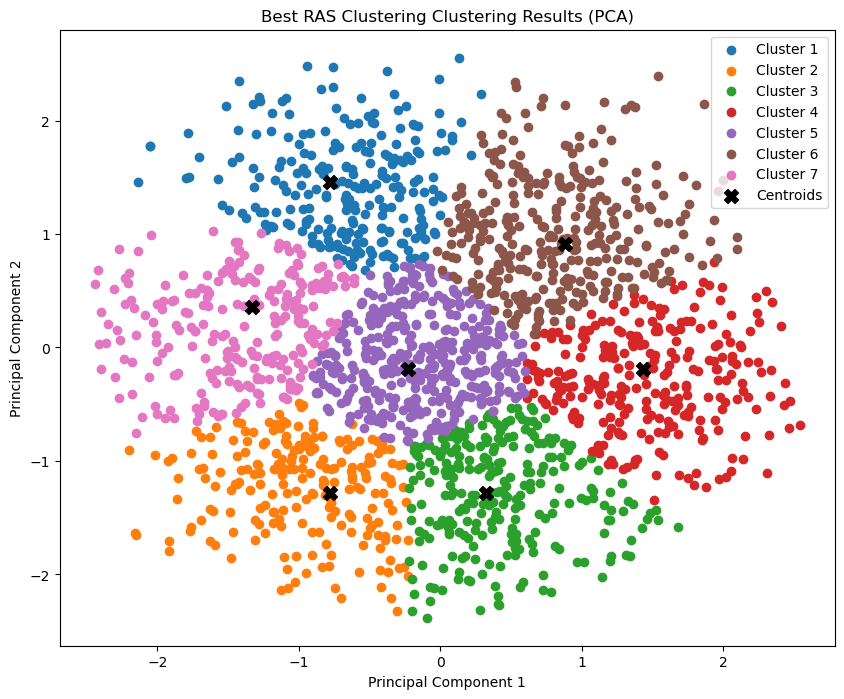

array([0, 5, 0, ..., 6, 1, 1], dtype=int64)

In [78]:
# التقييم والعرض للنتيجة الأفضل
best_results = evaluate_clustering(X_scaled, best_labels, "Best RAS")
results.append(best_results)
visualize_clusters(X_scaled, best_labels, best_centroids, "Best RAS Clustering")


In [79]:
def paco_clustering(X, n_clusters, n_ants=40, n_iterations=100, n_colonies=4, alpha=1.0, beta=2.0, evaporation_rate=0.5):
    """Parallel Ant Colony Optimization (PACO) for clustering"""
    n_samples, n_features = X.shape
    X_min, X_max = np.min(X, axis=0), np.max(X, axis=0)
    grid_size = 10

    # إعداد النقاط الشبكية (Grid)
    grid_points = [np.linspace(X_min[f], X_max[f], grid_size) for f in range(n_features)]

    # كل مستعمرة لديها مصفوفة فيرومون و Heuristic خاصة
    colonies = []
    for _ in range(n_colonies):
        pheromone = np.ones([grid_size] * n_features)
        heuristic = np.ones([grid_size] * n_features)
        for point in X:
            idx = [np.argmin(np.abs(grid_points[f] - point[f])) for f in range(n_features)]
            heuristic[tuple(idx)] += 1
        heuristic = heuristic / np.sum(heuristic)
        colonies.append({'pheromone': pheromone, 'heuristic': heuristic})

    global_best_centroids = None
    global_best_fitness = float('inf')

    for iteration in tqdm(range(n_iterations), desc="PACO Progress"):
        colony_bests = []

        for colony in colonies:
            pheromone = colony['pheromone']
            heuristic = colony['heuristic']

            best_colony_centroids = None
            best_colony_fitness = float('inf')

            for ant in range(n_ants // n_colonies):
                centroids = []
                for _ in range(n_clusters):
                    prob = (pheromone ** alpha) * (heuristic ** beta)
                    prob /= np.sum(prob)
                    flat_prob = prob.flatten()
                    choice = np.random.choice(len(flat_prob), p=flat_prob)
                    idx = np.unravel_index(choice, prob.shape)
                    centroid = np.array([grid_points[f][idx[f]] for f in range(n_features)])
                    centroids.append(centroid)
                centroids = np.array(centroids)

                fitness = calculate_fitness(X, centroids)
                if fitness < best_colony_fitness:
                    best_colony_fitness = fitness
                    best_colony_centroids = centroids.copy()

                # تبخر وتحديث الفيرومون المحلي
                pheromone *= (1 - evaporation_rate)
                for centroid in centroids:
                    idx = [np.argmin(np.abs(grid_points[f] - centroid[f])) for f in range(n_features)]
                    pheromone[tuple(idx)] += 1.0 / (fitness + 1e-10)

            # تحديث بيانات المستعمرة
            colony['pheromone'] = pheromone
            colony_bests.append((best_colony_centroids, best_colony_fitness))

            # تحديث الحل العالمي
            if best_colony_fitness < global_best_fitness:
                global_best_fitness = best_colony_fitness
                global_best_centroids = best_colony_centroids.copy()

        # تبادل المعرفة بين المستعمرات: مشاركة أفضل نملة عالمية
        for colony in colonies:
            for centroid in global_best_centroids:
                idx = [np.argmin(np.abs(grid_points[f] - centroid[f])) for f in range(n_features)]
                colony['pheromone'][tuple(idx)] += 2.0 / (global_best_fitness + 1e-10)

    final_labels = assign_clusters(X, global_best_centroids)
    return global_best_centroids, final_labels


In [80]:
from sklearn.metrics import silhouette_score
import itertools

def grid_search_paco(X, k, param_grid, n_iterations=100):
    best_score = -1
    best_params = None
    best_centroids = None
    best_labels = None

    # توليد جميع التركيبات الممكنة من القيم
    combinations = list(itertools.product(
        param_grid['n_ants'],
        param_grid['n_colonies'],
        param_grid['alpha'],
        param_grid['beta'],
        param_grid['evaporation_rate']
    ))

    print(f"🔍 Total combinations to try: {len(combinations)}\n")

    for i, (n_ants, n_colonies, alpha, beta, evap) in enumerate(combinations):
        print(f"▶️ Trying combination {i+1}/{len(combinations)}: "
              f"n_ants={n_ants}, n_colonies={n_colonies}, alpha={alpha}, beta={beta}, evaporation_rate={evap}")

        # تخطي التركيبات غير المنطقية (مثل أكثر مستعمرات من النمل)
        if n_colonies > n_ants:
            print("⚠️ Skipping: n_colonies > n_ants is invalid.\n")
            continue

        centroids, labels = paco_clustering(
            X, k,
            n_ants=n_ants,
            n_iterations=n_iterations,
            n_colonies=n_colonies,
            alpha=alpha,
            beta=beta,
            evaporation_rate=evap
        )

        score = silhouette_score(X, labels)
        print(f"→ Silhouette Score: {score:.4f}\n")

        if score > best_score:
            best_score = score
            best_params = {
                'n_ants': n_ants,
                'n_colonies': n_colonies,
                'alpha': alpha,
                'beta': beta,
                'evaporation_rate': evap
            }
            best_centroids = centroids
            best_labels = labels

    print("✅ Best Parameters Found:")
    print(best_params)
    print(f"Best Silhouette Score: {best_score:.4f}")

    return best_centroids, best_labels, best_params


In [81]:
param_grid = {
    'n_ants': [20,40,60,80,100],
    'n_colonies': [2, 4,6],
    'alpha': [0.5, 1.0, 2.0,3.0],
    'beta': [1.0, 2.0, 3.0],
    'evaporation_rate': [0.3, 0.5, 0.7,1.0]
}

best_centroids, best_labels, best_params = grid_search_paco(
    X_scaled,
    optimal_k,
    param_grid,
    n_iterations=100  
)

🔍 Total combinations to try: 720

▶️ Trying combination 1/720: n_ants=20, n_colonies=2, alpha=0.5, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:02<00:00, 49.87it/s]


→ Silhouette Score: 0.2961

▶️ Trying combination 2/720: n_ants=20, n_colonies=2, alpha=0.5, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 51.76it/s]


→ Silhouette Score: 0.3202

▶️ Trying combination 3/720: n_ants=20, n_colonies=2, alpha=0.5, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 50.42it/s]


→ Silhouette Score: 0.2702

▶️ Trying combination 4/720: n_ants=20, n_colonies=2, alpha=0.5, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 53.58it/s]


→ Silhouette Score: 0.2782

▶️ Trying combination 5/720: n_ants=20, n_colonies=2, alpha=0.5, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 51.71it/s]


→ Silhouette Score: 0.2989

▶️ Trying combination 6/720: n_ants=20, n_colonies=2, alpha=0.5, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 51.79it/s]


→ Silhouette Score: 0.2788

▶️ Trying combination 7/720: n_ants=20, n_colonies=2, alpha=0.5, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 52.18it/s]


→ Silhouette Score: 0.2487

▶️ Trying combination 8/720: n_ants=20, n_colonies=2, alpha=0.5, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 52.52it/s]


→ Silhouette Score: 0.2370

▶️ Trying combination 9/720: n_ants=20, n_colonies=2, alpha=0.5, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 50.16it/s]


→ Silhouette Score: 0.2532

▶️ Trying combination 10/720: n_ants=20, n_colonies=2, alpha=0.5, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 50.54it/s]


→ Silhouette Score: 0.2622

▶️ Trying combination 11/720: n_ants=20, n_colonies=2, alpha=0.5, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 51.01it/s]


→ Silhouette Score: 0.2810

▶️ Trying combination 12/720: n_ants=20, n_colonies=2, alpha=0.5, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 52.52it/s]


→ Silhouette Score: 0.3070

▶️ Trying combination 13/720: n_ants=20, n_colonies=2, alpha=1.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:02<00:00, 48.34it/s]


→ Silhouette Score: 0.2650

▶️ Trying combination 14/720: n_ants=20, n_colonies=2, alpha=1.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:02<00:00, 49.70it/s]


→ Silhouette Score: 0.2875

▶️ Trying combination 15/720: n_ants=20, n_colonies=2, alpha=1.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:02<00:00, 49.39it/s]


→ Silhouette Score: 0.2828

▶️ Trying combination 16/720: n_ants=20, n_colonies=2, alpha=1.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:02<00:00, 48.32it/s]


→ Silhouette Score: 0.2651

▶️ Trying combination 17/720: n_ants=20, n_colonies=2, alpha=1.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:02<00:00, 49.23it/s]


→ Silhouette Score: 0.2983

▶️ Trying combination 18/720: n_ants=20, n_colonies=2, alpha=1.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 51.18it/s]


→ Silhouette Score: 0.2409

▶️ Trying combination 19/720: n_ants=20, n_colonies=2, alpha=1.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 53.59it/s]


→ Silhouette Score: 0.2515

▶️ Trying combination 20/720: n_ants=20, n_colonies=2, alpha=1.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 50.29it/s]


→ Silhouette Score: 0.2271

▶️ Trying combination 21/720: n_ants=20, n_colonies=2, alpha=1.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:02<00:00, 46.92it/s]


→ Silhouette Score: 0.2709

▶️ Trying combination 22/720: n_ants=20, n_colonies=2, alpha=1.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 50.57it/s]


→ Silhouette Score: 0.2893

▶️ Trying combination 23/720: n_ants=20, n_colonies=2, alpha=1.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 52.44it/s]


→ Silhouette Score: 0.2577

▶️ Trying combination 24/720: n_ants=20, n_colonies=2, alpha=1.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 52.90it/s]


→ Silhouette Score: 0.1560

▶️ Trying combination 25/720: n_ants=20, n_colonies=2, alpha=2.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 54.96it/s]


→ Silhouette Score: 0.2921

▶️ Trying combination 26/720: n_ants=20, n_colonies=2, alpha=2.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 53.71it/s]


→ Silhouette Score: 0.2261

▶️ Trying combination 27/720: n_ants=20, n_colonies=2, alpha=2.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 57.11it/s]


→ Silhouette Score: 0.2222

▶️ Trying combination 28/720: n_ants=20, n_colonies=2, alpha=2.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 60.14it/s]


→ Silhouette Score: 0.2358

▶️ Trying combination 29/720: n_ants=20, n_colonies=2, alpha=2.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 60.43it/s]


→ Silhouette Score: 0.2932

▶️ Trying combination 30/720: n_ants=20, n_colonies=2, alpha=2.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 59.08it/s]


→ Silhouette Score: 0.2354

▶️ Trying combination 31/720: n_ants=20, n_colonies=2, alpha=2.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 59.48it/s]


→ Silhouette Score: 0.2616

▶️ Trying combination 32/720: n_ants=20, n_colonies=2, alpha=2.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 59.91it/s]


→ Silhouette Score: 0.2437

▶️ Trying combination 33/720: n_ants=20, n_colonies=2, alpha=2.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 57.18it/s]


→ Silhouette Score: 0.2725

▶️ Trying combination 34/720: n_ants=20, n_colonies=2, alpha=2.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 57.83it/s]


→ Silhouette Score: 0.2864

▶️ Trying combination 35/720: n_ants=20, n_colonies=2, alpha=2.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 58.22it/s]


→ Silhouette Score: 0.3186

▶️ Trying combination 36/720: n_ants=20, n_colonies=2, alpha=2.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 57.67it/s]


→ Silhouette Score: 0.2026

▶️ Trying combination 37/720: n_ants=20, n_colonies=2, alpha=3.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 56.00it/s]


→ Silhouette Score: 0.3128

▶️ Trying combination 38/720: n_ants=20, n_colonies=2, alpha=3.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 56.78it/s]


→ Silhouette Score: 0.2427

▶️ Trying combination 39/720: n_ants=20, n_colonies=2, alpha=3.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 55.95it/s]


→ Silhouette Score: 0.2872

▶️ Trying combination 40/720: n_ants=20, n_colonies=2, alpha=3.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 58.97it/s]


→ Silhouette Score: 0.2355

▶️ Trying combination 41/720: n_ants=20, n_colonies=2, alpha=3.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 56.51it/s]


→ Silhouette Score: 0.2834

▶️ Trying combination 42/720: n_ants=20, n_colonies=2, alpha=3.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 56.46it/s]


→ Silhouette Score: 0.2839

▶️ Trying combination 43/720: n_ants=20, n_colonies=2, alpha=3.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 57.85it/s]


→ Silhouette Score: 0.2497

▶️ Trying combination 44/720: n_ants=20, n_colonies=2, alpha=3.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 58.19it/s]


→ Silhouette Score: 0.2610

▶️ Trying combination 45/720: n_ants=20, n_colonies=2, alpha=3.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 55.10it/s]


→ Silhouette Score: 0.2929

▶️ Trying combination 46/720: n_ants=20, n_colonies=2, alpha=3.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 50.86it/s]


→ Silhouette Score: 0.2449

▶️ Trying combination 47/720: n_ants=20, n_colonies=2, alpha=3.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 52.62it/s]


→ Silhouette Score: 0.2647

▶️ Trying combination 48/720: n_ants=20, n_colonies=2, alpha=3.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 55.07it/s]


→ Silhouette Score: 0.2403

▶️ Trying combination 49/720: n_ants=20, n_colonies=4, alpha=0.5, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 51.74it/s]


→ Silhouette Score: 0.3040

▶️ Trying combination 50/720: n_ants=20, n_colonies=4, alpha=0.5, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 53.32it/s]


→ Silhouette Score: 0.3017

▶️ Trying combination 51/720: n_ants=20, n_colonies=4, alpha=0.5, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 53.38it/s]


→ Silhouette Score: 0.3170

▶️ Trying combination 52/720: n_ants=20, n_colonies=4, alpha=0.5, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 54.05it/s]


→ Silhouette Score: 0.2938

▶️ Trying combination 53/720: n_ants=20, n_colonies=4, alpha=0.5, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 53.12it/s]


→ Silhouette Score: 0.2683

▶️ Trying combination 54/720: n_ants=20, n_colonies=4, alpha=0.5, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 53.32it/s]


→ Silhouette Score: 0.2532

▶️ Trying combination 55/720: n_ants=20, n_colonies=4, alpha=0.5, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 55.53it/s]


→ Silhouette Score: 0.2732

▶️ Trying combination 56/720: n_ants=20, n_colonies=4, alpha=0.5, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 57.49it/s]


→ Silhouette Score: 0.2705

▶️ Trying combination 57/720: n_ants=20, n_colonies=4, alpha=0.5, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 52.93it/s]


→ Silhouette Score: 0.2829

▶️ Trying combination 58/720: n_ants=20, n_colonies=4, alpha=0.5, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 53.92it/s]


→ Silhouette Score: 0.2982

▶️ Trying combination 59/720: n_ants=20, n_colonies=4, alpha=0.5, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 54.25it/s]


→ Silhouette Score: 0.2490

▶️ Trying combination 60/720: n_ants=20, n_colonies=4, alpha=0.5, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 54.35it/s]


→ Silhouette Score: 0.2310

▶️ Trying combination 61/720: n_ants=20, n_colonies=4, alpha=1.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 55.36it/s]


→ Silhouette Score: 0.2943

▶️ Trying combination 62/720: n_ants=20, n_colonies=4, alpha=1.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 54.62it/s]


→ Silhouette Score: 0.3140

▶️ Trying combination 63/720: n_ants=20, n_colonies=4, alpha=1.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 56.28it/s]


→ Silhouette Score: 0.2484

▶️ Trying combination 64/720: n_ants=20, n_colonies=4, alpha=1.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 57.15it/s]


→ Silhouette Score: 0.2387

▶️ Trying combination 65/720: n_ants=20, n_colonies=4, alpha=1.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 55.29it/s]


→ Silhouette Score: 0.2930

▶️ Trying combination 66/720: n_ants=20, n_colonies=4, alpha=1.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 55.55it/s]


→ Silhouette Score: 0.3055

▶️ Trying combination 67/720: n_ants=20, n_colonies=4, alpha=1.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 56.05it/s]


→ Silhouette Score: 0.3129

▶️ Trying combination 68/720: n_ants=20, n_colonies=4, alpha=1.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 58.27it/s]


→ Silhouette Score: 0.2380

▶️ Trying combination 69/720: n_ants=20, n_colonies=4, alpha=1.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 55.48it/s]


→ Silhouette Score: 0.3118

▶️ Trying combination 70/720: n_ants=20, n_colonies=4, alpha=1.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 53.41it/s]


→ Silhouette Score: 0.2481

▶️ Trying combination 71/720: n_ants=20, n_colonies=4, alpha=1.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 54.51it/s]


→ Silhouette Score: 0.2830

▶️ Trying combination 72/720: n_ants=20, n_colonies=4, alpha=1.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 55.97it/s]


→ Silhouette Score: 0.2572

▶️ Trying combination 73/720: n_ants=20, n_colonies=4, alpha=2.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 56.34it/s]


→ Silhouette Score: 0.2499

▶️ Trying combination 74/720: n_ants=20, n_colonies=4, alpha=2.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 57.74it/s]


→ Silhouette Score: 0.2829

▶️ Trying combination 75/720: n_ants=20, n_colonies=4, alpha=2.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 57.80it/s]


→ Silhouette Score: 0.2852

▶️ Trying combination 76/720: n_ants=20, n_colonies=4, alpha=2.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 57.51it/s]


→ Silhouette Score: 0.1963

▶️ Trying combination 77/720: n_ants=20, n_colonies=4, alpha=2.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 53.10it/s]


→ Silhouette Score: 0.2822

▶️ Trying combination 78/720: n_ants=20, n_colonies=4, alpha=2.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 55.19it/s]


→ Silhouette Score: 0.3000

▶️ Trying combination 79/720: n_ants=20, n_colonies=4, alpha=2.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 56.25it/s]


→ Silhouette Score: 0.2901

▶️ Trying combination 80/720: n_ants=20, n_colonies=4, alpha=2.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 56.67it/s]


→ Silhouette Score: 0.2614

▶️ Trying combination 81/720: n_ants=20, n_colonies=4, alpha=2.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 53.94it/s]


→ Silhouette Score: 0.2982

▶️ Trying combination 82/720: n_ants=20, n_colonies=4, alpha=2.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 55.62it/s]


→ Silhouette Score: 0.2413

▶️ Trying combination 83/720: n_ants=20, n_colonies=4, alpha=2.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 54.51it/s]


→ Silhouette Score: 0.2405

▶️ Trying combination 84/720: n_ants=20, n_colonies=4, alpha=2.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 50.98it/s]


→ Silhouette Score: 0.2373

▶️ Trying combination 85/720: n_ants=20, n_colonies=4, alpha=3.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 55.23it/s]


→ Silhouette Score: 0.3040

▶️ Trying combination 86/720: n_ants=20, n_colonies=4, alpha=3.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 54.97it/s]


→ Silhouette Score: 0.2949

▶️ Trying combination 87/720: n_ants=20, n_colonies=4, alpha=3.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 55.71it/s]


→ Silhouette Score: 0.2861

▶️ Trying combination 88/720: n_ants=20, n_colonies=4, alpha=3.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 58.45it/s]


→ Silhouette Score: 0.2519

▶️ Trying combination 89/720: n_ants=20, n_colonies=4, alpha=3.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 55.92it/s]


→ Silhouette Score: 0.2787

▶️ Trying combination 90/720: n_ants=20, n_colonies=4, alpha=3.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 56.16it/s]


→ Silhouette Score: 0.2731

▶️ Trying combination 91/720: n_ants=20, n_colonies=4, alpha=3.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 54.93it/s]


→ Silhouette Score: 0.2563

▶️ Trying combination 92/720: n_ants=20, n_colonies=4, alpha=3.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 57.76it/s]


→ Silhouette Score: 0.2554

▶️ Trying combination 93/720: n_ants=20, n_colonies=4, alpha=3.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 55.01it/s]


→ Silhouette Score: 0.2802

▶️ Trying combination 94/720: n_ants=20, n_colonies=4, alpha=3.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 54.55it/s]


→ Silhouette Score: 0.2754

▶️ Trying combination 95/720: n_ants=20, n_colonies=4, alpha=3.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 54.07it/s]


→ Silhouette Score: 0.2780

▶️ Trying combination 96/720: n_ants=20, n_colonies=4, alpha=3.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 55.89it/s]


→ Silhouette Score: 0.2014

▶️ Trying combination 97/720: n_ants=20, n_colonies=6, alpha=0.5, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 59.97it/s]


→ Silhouette Score: 0.3250

▶️ Trying combination 98/720: n_ants=20, n_colonies=6, alpha=0.5, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 60.20it/s]


→ Silhouette Score: 0.3222

▶️ Trying combination 99/720: n_ants=20, n_colonies=6, alpha=0.5, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 59.49it/s]


→ Silhouette Score: 0.2857

▶️ Trying combination 100/720: n_ants=20, n_colonies=6, alpha=0.5, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 61.74it/s]


→ Silhouette Score: 0.1905

▶️ Trying combination 101/720: n_ants=20, n_colonies=6, alpha=0.5, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 59.40it/s]


→ Silhouette Score: 0.2734

▶️ Trying combination 102/720: n_ants=20, n_colonies=6, alpha=0.5, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 59.29it/s]


→ Silhouette Score: 0.3029

▶️ Trying combination 103/720: n_ants=20, n_colonies=6, alpha=0.5, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 61.02it/s]


→ Silhouette Score: 0.3040

▶️ Trying combination 104/720: n_ants=20, n_colonies=6, alpha=0.5, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 61.75it/s]


→ Silhouette Score: 0.2251

▶️ Trying combination 105/720: n_ants=20, n_colonies=6, alpha=0.5, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 57.72it/s]


→ Silhouette Score: 0.3097

▶️ Trying combination 106/720: n_ants=20, n_colonies=6, alpha=0.5, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 59.23it/s]


→ Silhouette Score: 0.2764

▶️ Trying combination 107/720: n_ants=20, n_colonies=6, alpha=0.5, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 59.42it/s]


→ Silhouette Score: 0.2914

▶️ Trying combination 108/720: n_ants=20, n_colonies=6, alpha=0.5, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 56.66it/s]


→ Silhouette Score: 0.2416

▶️ Trying combination 109/720: n_ants=20, n_colonies=6, alpha=1.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 56.61it/s]


→ Silhouette Score: 0.2647

▶️ Trying combination 110/720: n_ants=20, n_colonies=6, alpha=1.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 56.95it/s]


→ Silhouette Score: 0.2846

▶️ Trying combination 111/720: n_ants=20, n_colonies=6, alpha=1.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 57.77it/s]


→ Silhouette Score: 0.2685

▶️ Trying combination 112/720: n_ants=20, n_colonies=6, alpha=1.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 59.92it/s]


→ Silhouette Score: 0.2385

▶️ Trying combination 113/720: n_ants=20, n_colonies=6, alpha=1.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 57.72it/s]


→ Silhouette Score: 0.2969

▶️ Trying combination 114/720: n_ants=20, n_colonies=6, alpha=1.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 59.23it/s]


→ Silhouette Score: 0.2664

▶️ Trying combination 115/720: n_ants=20, n_colonies=6, alpha=1.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 58.75it/s]


→ Silhouette Score: 0.2489

▶️ Trying combination 116/720: n_ants=20, n_colonies=6, alpha=1.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 60.61it/s]


→ Silhouette Score: 0.2517

▶️ Trying combination 117/720: n_ants=20, n_colonies=6, alpha=1.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 57.23it/s]


→ Silhouette Score: 0.2633

▶️ Trying combination 118/720: n_ants=20, n_colonies=6, alpha=1.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 58.01it/s]


→ Silhouette Score: 0.2670

▶️ Trying combination 119/720: n_ants=20, n_colonies=6, alpha=1.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 60.62it/s]


→ Silhouette Score: 0.2847

▶️ Trying combination 120/720: n_ants=20, n_colonies=6, alpha=1.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 60.91it/s]


→ Silhouette Score: 0.2368

▶️ Trying combination 121/720: n_ants=20, n_colonies=6, alpha=2.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 62.27it/s]


→ Silhouette Score: 0.2788

▶️ Trying combination 122/720: n_ants=20, n_colonies=6, alpha=2.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 62.09it/s]


→ Silhouette Score: 0.2606

▶️ Trying combination 123/720: n_ants=20, n_colonies=6, alpha=2.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 62.24it/s]


→ Silhouette Score: 0.2675

▶️ Trying combination 124/720: n_ants=20, n_colonies=6, alpha=2.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 61.33it/s]


→ Silhouette Score: 0.2352

▶️ Trying combination 125/720: n_ants=20, n_colonies=6, alpha=2.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 62.95it/s]


→ Silhouette Score: 0.3032

▶️ Trying combination 126/720: n_ants=20, n_colonies=6, alpha=2.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 62.19it/s]


→ Silhouette Score: 0.3117

▶️ Trying combination 127/720: n_ants=20, n_colonies=6, alpha=2.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 63.02it/s]


→ Silhouette Score: 0.3073

▶️ Trying combination 128/720: n_ants=20, n_colonies=6, alpha=2.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 62.31it/s]


→ Silhouette Score: 0.2359

▶️ Trying combination 129/720: n_ants=20, n_colonies=6, alpha=2.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 55.05it/s]


→ Silhouette Score: 0.2310

▶️ Trying combination 130/720: n_ants=20, n_colonies=6, alpha=2.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 60.61it/s]


→ Silhouette Score: 0.2293

▶️ Trying combination 131/720: n_ants=20, n_colonies=6, alpha=2.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 59.81it/s]


→ Silhouette Score: 0.2915

▶️ Trying combination 132/720: n_ants=20, n_colonies=6, alpha=2.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 61.10it/s]


→ Silhouette Score: 0.3244

▶️ Trying combination 133/720: n_ants=20, n_colonies=6, alpha=3.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 62.39it/s]


→ Silhouette Score: 0.3244

▶️ Trying combination 134/720: n_ants=20, n_colonies=6, alpha=3.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 60.34it/s]


→ Silhouette Score: 0.2612

▶️ Trying combination 135/720: n_ants=20, n_colonies=6, alpha=3.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 52.75it/s]


→ Silhouette Score: 0.2505

▶️ Trying combination 136/720: n_ants=20, n_colonies=6, alpha=3.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 57.37it/s]


→ Silhouette Score: 0.2627

▶️ Trying combination 137/720: n_ants=20, n_colonies=6, alpha=3.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:02<00:00, 43.01it/s]


→ Silhouette Score: 0.2786

▶️ Trying combination 138/720: n_ants=20, n_colonies=6, alpha=3.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 56.23it/s]


→ Silhouette Score: 0.2934

▶️ Trying combination 139/720: n_ants=20, n_colonies=6, alpha=3.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 58.41it/s]


→ Silhouette Score: 0.2474

▶️ Trying combination 140/720: n_ants=20, n_colonies=6, alpha=3.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 61.73it/s]


→ Silhouette Score: 0.3064

▶️ Trying combination 141/720: n_ants=20, n_colonies=6, alpha=3.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:02<00:00, 49.83it/s]


→ Silhouette Score: 0.2807

▶️ Trying combination 142/720: n_ants=20, n_colonies=6, alpha=3.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 53.22it/s]


→ Silhouette Score: 0.2869

▶️ Trying combination 143/720: n_ants=20, n_colonies=6, alpha=3.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:02<00:00, 47.81it/s]


→ Silhouette Score: 0.2401

▶️ Trying combination 144/720: n_ants=20, n_colonies=6, alpha=3.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:01<00:00, 54.90it/s]


→ Silhouette Score: 0.2541

▶️ Trying combination 145/720: n_ants=40, n_colonies=2, alpha=0.5, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:04<00:00, 23.91it/s]


→ Silhouette Score: 0.2934

▶️ Trying combination 146/720: n_ants=40, n_colonies=2, alpha=0.5, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


→ Silhouette Score: 0.2680

▶️ Trying combination 147/720: n_ants=40, n_colonies=2, alpha=0.5, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 25.30it/s]


→ Silhouette Score: 0.2650

▶️ Trying combination 148/720: n_ants=40, n_colonies=2, alpha=0.5, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 28.41it/s]


→ Silhouette Score: 0.3007

▶️ Trying combination 149/720: n_ants=40, n_colonies=2, alpha=0.5, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


→ Silhouette Score: 0.2799

▶️ Trying combination 150/720: n_ants=40, n_colonies=2, alpha=0.5, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 26.84it/s]


→ Silhouette Score: 0.3504

▶️ Trying combination 151/720: n_ants=40, n_colonies=2, alpha=0.5, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 25.45it/s]


→ Silhouette Score: 0.2889

▶️ Trying combination 152/720: n_ants=40, n_colonies=2, alpha=0.5, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 27.36it/s]


→ Silhouette Score: 0.2591

▶️ Trying combination 153/720: n_ants=40, n_colonies=2, alpha=0.5, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:04<00:00, 23.38it/s]


→ Silhouette Score: 0.2619

▶️ Trying combination 154/720: n_ants=40, n_colonies=2, alpha=0.5, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:04<00:00, 24.20it/s]


→ Silhouette Score: 0.2581

▶️ Trying combination 155/720: n_ants=40, n_colonies=2, alpha=0.5, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:04<00:00, 24.73it/s]


→ Silhouette Score: 0.2530

▶️ Trying combination 156/720: n_ants=40, n_colonies=2, alpha=0.5, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 29.11it/s]


→ Silhouette Score: 0.2710

▶️ Trying combination 157/720: n_ants=40, n_colonies=2, alpha=1.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 29.10it/s]


→ Silhouette Score: 0.3221

▶️ Trying combination 158/720: n_ants=40, n_colonies=2, alpha=1.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 27.33it/s]


→ Silhouette Score: 0.2936

▶️ Trying combination 159/720: n_ants=40, n_colonies=2, alpha=1.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 28.80it/s]


→ Silhouette Score: 0.3015

▶️ Trying combination 160/720: n_ants=40, n_colonies=2, alpha=1.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 29.61it/s]


→ Silhouette Score: 0.2478

▶️ Trying combination 161/720: n_ants=40, n_colonies=2, alpha=1.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 28.51it/s]


→ Silhouette Score: 0.2953

▶️ Trying combination 162/720: n_ants=40, n_colonies=2, alpha=1.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 29.21it/s]


→ Silhouette Score: 0.2411

▶️ Trying combination 163/720: n_ants=40, n_colonies=2, alpha=1.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 30.01it/s]


→ Silhouette Score: 0.2816

▶️ Trying combination 164/720: n_ants=40, n_colonies=2, alpha=1.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 30.16it/s]


→ Silhouette Score: 0.2473

▶️ Trying combination 165/720: n_ants=40, n_colonies=2, alpha=1.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 28.98it/s]


→ Silhouette Score: 0.2938

▶️ Trying combination 166/720: n_ants=40, n_colonies=2, alpha=1.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 29.08it/s]


→ Silhouette Score: 0.2423

▶️ Trying combination 167/720: n_ants=40, n_colonies=2, alpha=1.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 29.50it/s]


→ Silhouette Score: 0.2486

▶️ Trying combination 168/720: n_ants=40, n_colonies=2, alpha=1.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 29.51it/s]


→ Silhouette Score: 0.2838

▶️ Trying combination 169/720: n_ants=40, n_colonies=2, alpha=2.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 30.64it/s]


→ Silhouette Score: 0.3011

▶️ Trying combination 170/720: n_ants=40, n_colonies=2, alpha=2.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 30.50it/s]


→ Silhouette Score: 0.2661

▶️ Trying combination 171/720: n_ants=40, n_colonies=2, alpha=2.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 30.34it/s]


→ Silhouette Score: 0.2526

▶️ Trying combination 172/720: n_ants=40, n_colonies=2, alpha=2.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 30.04it/s]


→ Silhouette Score: 0.2622

▶️ Trying combination 173/720: n_ants=40, n_colonies=2, alpha=2.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 30.35it/s]


→ Silhouette Score: 0.2761

▶️ Trying combination 174/720: n_ants=40, n_colonies=2, alpha=2.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 30.99it/s]


→ Silhouette Score: 0.2111

▶️ Trying combination 175/720: n_ants=40, n_colonies=2, alpha=2.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 28.70it/s]


→ Silhouette Score: 0.2677

▶️ Trying combination 176/720: n_ants=40, n_colonies=2, alpha=2.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 29.36it/s]


→ Silhouette Score: 0.2309

▶️ Trying combination 177/720: n_ants=40, n_colonies=2, alpha=2.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 26.88it/s]


→ Silhouette Score: 0.2732

▶️ Trying combination 178/720: n_ants=40, n_colonies=2, alpha=2.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 26.33it/s]


→ Silhouette Score: 0.2701

▶️ Trying combination 179/720: n_ants=40, n_colonies=2, alpha=2.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:04<00:00, 22.08it/s]


→ Silhouette Score: 0.2574

▶️ Trying combination 180/720: n_ants=40, n_colonies=2, alpha=2.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:04<00:00, 23.84it/s]


→ Silhouette Score: 0.2263

▶️ Trying combination 181/720: n_ants=40, n_colonies=2, alpha=3.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:04<00:00, 23.79it/s]


→ Silhouette Score: 0.3063

▶️ Trying combination 182/720: n_ants=40, n_colonies=2, alpha=3.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 25.61it/s]


→ Silhouette Score: 0.2009

▶️ Trying combination 183/720: n_ants=40, n_colonies=2, alpha=3.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:04<00:00, 21.91it/s]


→ Silhouette Score: 0.2723

▶️ Trying combination 184/720: n_ants=40, n_colonies=2, alpha=3.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 26.06it/s]


→ Silhouette Score: 0.2804

▶️ Trying combination 185/720: n_ants=40, n_colonies=2, alpha=3.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 27.75it/s]


→ Silhouette Score: 0.2301

▶️ Trying combination 186/720: n_ants=40, n_colonies=2, alpha=3.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 28.40it/s]


→ Silhouette Score: 0.2345

▶️ Trying combination 187/720: n_ants=40, n_colonies=2, alpha=3.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 28.35it/s]


→ Silhouette Score: 0.2481

▶️ Trying combination 188/720: n_ants=40, n_colonies=2, alpha=3.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 26.09it/s]


→ Silhouette Score: 0.2699

▶️ Trying combination 189/720: n_ants=40, n_colonies=2, alpha=3.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:04<00:00, 20.85it/s]


→ Silhouette Score: 0.3142

▶️ Trying combination 190/720: n_ants=40, n_colonies=2, alpha=3.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:04<00:00, 21.35it/s]


→ Silhouette Score: 0.2336

▶️ Trying combination 191/720: n_ants=40, n_colonies=2, alpha=3.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:04<00:00, 23.47it/s]


→ Silhouette Score: 0.2527

▶️ Trying combination 192/720: n_ants=40, n_colonies=2, alpha=3.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 26.13it/s]


→ Silhouette Score: 0.2607

▶️ Trying combination 193/720: n_ants=40, n_colonies=4, alpha=0.5, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:04<00:00, 23.61it/s]


→ Silhouette Score: 0.2988

▶️ Trying combination 194/720: n_ants=40, n_colonies=4, alpha=0.5, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:04<00:00, 23.09it/s]


→ Silhouette Score: 0.2993

▶️ Trying combination 195/720: n_ants=40, n_colonies=4, alpha=0.5, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:04<00:00, 24.48it/s]


→ Silhouette Score: 0.2884

▶️ Trying combination 196/720: n_ants=40, n_colonies=4, alpha=0.5, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 27.70it/s]


→ Silhouette Score: 0.2702

▶️ Trying combination 197/720: n_ants=40, n_colonies=4, alpha=0.5, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 25.78it/s]


→ Silhouette Score: 0.3088

▶️ Trying combination 198/720: n_ants=40, n_colonies=4, alpha=0.5, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 26.20it/s]


→ Silhouette Score: 0.2888

▶️ Trying combination 199/720: n_ants=40, n_colonies=4, alpha=0.5, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 26.08it/s]


→ Silhouette Score: 0.2841

▶️ Trying combination 200/720: n_ants=40, n_colonies=4, alpha=0.5, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 27.32it/s]


→ Silhouette Score: 0.2801

▶️ Trying combination 201/720: n_ants=40, n_colonies=4, alpha=0.5, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 25.49it/s]


→ Silhouette Score: 0.2424

▶️ Trying combination 202/720: n_ants=40, n_colonies=4, alpha=0.5, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:04<00:00, 24.70it/s]


→ Silhouette Score: 0.3049

▶️ Trying combination 203/720: n_ants=40, n_colonies=4, alpha=0.5, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:04<00:00, 22.57it/s]


→ Silhouette Score: 0.2302

▶️ Trying combination 204/720: n_ants=40, n_colonies=4, alpha=0.5, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:04<00:00, 24.13it/s]


→ Silhouette Score: 0.2548

▶️ Trying combination 205/720: n_ants=40, n_colonies=4, alpha=1.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:04<00:00, 24.61it/s]


→ Silhouette Score: 0.2843

▶️ Trying combination 206/720: n_ants=40, n_colonies=4, alpha=1.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 25.67it/s]


→ Silhouette Score: 0.2807

▶️ Trying combination 207/720: n_ants=40, n_colonies=4, alpha=1.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 26.55it/s]


→ Silhouette Score: 0.2611

▶️ Trying combination 208/720: n_ants=40, n_colonies=4, alpha=1.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 26.77it/s]


→ Silhouette Score: 0.3112

▶️ Trying combination 209/720: n_ants=40, n_colonies=4, alpha=1.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 26.62it/s]


→ Silhouette Score: 0.2665

▶️ Trying combination 210/720: n_ants=40, n_colonies=4, alpha=1.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 29.13it/s]


→ Silhouette Score: 0.2800

▶️ Trying combination 211/720: n_ants=40, n_colonies=4, alpha=1.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 29.66it/s]


→ Silhouette Score: 0.2811

▶️ Trying combination 212/720: n_ants=40, n_colonies=4, alpha=1.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 29.62it/s]


→ Silhouette Score: 0.2788

▶️ Trying combination 213/720: n_ants=40, n_colonies=4, alpha=1.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 27.35it/s]


→ Silhouette Score: 0.2886

▶️ Trying combination 214/720: n_ants=40, n_colonies=4, alpha=1.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 26.18it/s]


→ Silhouette Score: 0.2834

▶️ Trying combination 215/720: n_ants=40, n_colonies=4, alpha=1.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 27.78it/s]


→ Silhouette Score: 0.2560

▶️ Trying combination 216/720: n_ants=40, n_colonies=4, alpha=1.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


→ Silhouette Score: 0.1985

▶️ Trying combination 217/720: n_ants=40, n_colonies=4, alpha=2.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 29.03it/s]


→ Silhouette Score: 0.2926

▶️ Trying combination 218/720: n_ants=40, n_colonies=4, alpha=2.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 28.86it/s]


→ Silhouette Score: 0.2617

▶️ Trying combination 219/720: n_ants=40, n_colonies=4, alpha=2.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 28.00it/s]


→ Silhouette Score: 0.2835

▶️ Trying combination 220/720: n_ants=40, n_colonies=4, alpha=2.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 27.71it/s]


→ Silhouette Score: 0.2189

▶️ Trying combination 221/720: n_ants=40, n_colonies=4, alpha=2.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 27.65it/s]


→ Silhouette Score: 0.3004

▶️ Trying combination 222/720: n_ants=40, n_colonies=4, alpha=2.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 27.73it/s]


→ Silhouette Score: 0.3064

▶️ Trying combination 223/720: n_ants=40, n_colonies=4, alpha=2.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 27.57it/s]


→ Silhouette Score: 0.2708

▶️ Trying combination 224/720: n_ants=40, n_colonies=4, alpha=2.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 29.19it/s]


→ Silhouette Score: 0.2704

▶️ Trying combination 225/720: n_ants=40, n_colonies=4, alpha=2.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


→ Silhouette Score: 0.2923

▶️ Trying combination 226/720: n_ants=40, n_colonies=4, alpha=2.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 27.90it/s]


→ Silhouette Score: 0.2576

▶️ Trying combination 227/720: n_ants=40, n_colonies=4, alpha=2.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 27.78it/s]


→ Silhouette Score: 0.2809

▶️ Trying combination 228/720: n_ants=40, n_colonies=4, alpha=2.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 28.36it/s]


→ Silhouette Score: 0.2596

▶️ Trying combination 229/720: n_ants=40, n_colonies=4, alpha=3.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 28.06it/s]


→ Silhouette Score: 0.2881

▶️ Trying combination 230/720: n_ants=40, n_colonies=4, alpha=3.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 26.73it/s]


→ Silhouette Score: 0.2832

▶️ Trying combination 231/720: n_ants=40, n_colonies=4, alpha=3.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 27.54it/s]


→ Silhouette Score: 0.2935

▶️ Trying combination 232/720: n_ants=40, n_colonies=4, alpha=3.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 29.57it/s]


→ Silhouette Score: 0.2439

▶️ Trying combination 233/720: n_ants=40, n_colonies=4, alpha=3.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 27.16it/s]


→ Silhouette Score: 0.2743

▶️ Trying combination 234/720: n_ants=40, n_colonies=4, alpha=3.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 27.00it/s]


→ Silhouette Score: 0.3058

▶️ Trying combination 235/720: n_ants=40, n_colonies=4, alpha=3.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 28.34it/s]


→ Silhouette Score: 0.2882

▶️ Trying combination 236/720: n_ants=40, n_colonies=4, alpha=3.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 28.94it/s]


→ Silhouette Score: 0.2771

▶️ Trying combination 237/720: n_ants=40, n_colonies=4, alpha=3.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 26.17it/s]


→ Silhouette Score: 0.2873

▶️ Trying combination 238/720: n_ants=40, n_colonies=4, alpha=3.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 26.20it/s]


→ Silhouette Score: 0.2422

▶️ Trying combination 239/720: n_ants=40, n_colonies=4, alpha=3.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 26.27it/s]


→ Silhouette Score: 0.2889

▶️ Trying combination 240/720: n_ants=40, n_colonies=4, alpha=3.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 28.32it/s]


→ Silhouette Score: 0.2761

▶️ Trying combination 241/720: n_ants=40, n_colonies=6, alpha=0.5, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 26.92it/s]


→ Silhouette Score: 0.3166

▶️ Trying combination 242/720: n_ants=40, n_colonies=6, alpha=0.5, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 29.89it/s]


→ Silhouette Score: 0.2873

▶️ Trying combination 243/720: n_ants=40, n_colonies=6, alpha=0.5, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 28.23it/s]


→ Silhouette Score: 0.3084

▶️ Trying combination 244/720: n_ants=40, n_colonies=6, alpha=0.5, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 31.85it/s]


→ Silhouette Score: 0.2759

▶️ Trying combination 245/720: n_ants=40, n_colonies=6, alpha=0.5, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 31.36it/s]


→ Silhouette Score: 0.3313

▶️ Trying combination 246/720: n_ants=40, n_colonies=6, alpha=0.5, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 31.25it/s]


→ Silhouette Score: 0.3221

▶️ Trying combination 247/720: n_ants=40, n_colonies=6, alpha=0.5, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 29.34it/s]


→ Silhouette Score: 0.2869

▶️ Trying combination 248/720: n_ants=40, n_colonies=6, alpha=0.5, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 30.72it/s]


→ Silhouette Score: 0.2769

▶️ Trying combination 249/720: n_ants=40, n_colonies=6, alpha=0.5, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 28.31it/s]


→ Silhouette Score: 0.2814

▶️ Trying combination 250/720: n_ants=40, n_colonies=6, alpha=0.5, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 28.30it/s]


→ Silhouette Score: 0.2869

▶️ Trying combination 251/720: n_ants=40, n_colonies=6, alpha=0.5, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 28.87it/s]


→ Silhouette Score: 0.2720

▶️ Trying combination 252/720: n_ants=40, n_colonies=6, alpha=0.5, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 29.63it/s]


→ Silhouette Score: 0.2987

▶️ Trying combination 253/720: n_ants=40, n_colonies=6, alpha=1.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


→ Silhouette Score: 0.3028

▶️ Trying combination 254/720: n_ants=40, n_colonies=6, alpha=1.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 27.73it/s]


→ Silhouette Score: 0.3038

▶️ Trying combination 255/720: n_ants=40, n_colonies=6, alpha=1.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 29.03it/s]


→ Silhouette Score: 0.3004

▶️ Trying combination 256/720: n_ants=40, n_colonies=6, alpha=1.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 29.61it/s]


→ Silhouette Score: 0.2543

▶️ Trying combination 257/720: n_ants=40, n_colonies=6, alpha=1.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


→ Silhouette Score: 0.3096

▶️ Trying combination 258/720: n_ants=40, n_colonies=6, alpha=1.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 30.42it/s]


→ Silhouette Score: 0.2786

▶️ Trying combination 259/720: n_ants=40, n_colonies=6, alpha=1.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 30.96it/s]


→ Silhouette Score: 0.2764

▶️ Trying combination 260/720: n_ants=40, n_colonies=6, alpha=1.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 28.30it/s]


→ Silhouette Score: 0.2822

▶️ Trying combination 261/720: n_ants=40, n_colonies=6, alpha=1.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 26.24it/s]


→ Silhouette Score: 0.2786

▶️ Trying combination 262/720: n_ants=40, n_colonies=6, alpha=1.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 25.55it/s]


→ Silhouette Score: 0.3091

▶️ Trying combination 263/720: n_ants=40, n_colonies=6, alpha=1.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 30.75it/s]


→ Silhouette Score: 0.2878

▶️ Trying combination 264/720: n_ants=40, n_colonies=6, alpha=1.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 32.02it/s]


→ Silhouette Score: 0.2797

▶️ Trying combination 265/720: n_ants=40, n_colonies=6, alpha=2.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 32.72it/s]


→ Silhouette Score: 0.2927

▶️ Trying combination 266/720: n_ants=40, n_colonies=6, alpha=2.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 32.33it/s]


→ Silhouette Score: 0.3236

▶️ Trying combination 267/720: n_ants=40, n_colonies=6, alpha=2.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 32.74it/s]


→ Silhouette Score: 0.2939

▶️ Trying combination 268/720: n_ants=40, n_colonies=6, alpha=2.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 31.20it/s]


→ Silhouette Score: 0.2935

▶️ Trying combination 269/720: n_ants=40, n_colonies=6, alpha=2.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 32.35it/s]


→ Silhouette Score: 0.2857

▶️ Trying combination 270/720: n_ants=40, n_colonies=6, alpha=2.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 27.62it/s]


→ Silhouette Score: 0.2849

▶️ Trying combination 271/720: n_ants=40, n_colonies=6, alpha=2.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 28.14it/s]


→ Silhouette Score: 0.2784

▶️ Trying combination 272/720: n_ants=40, n_colonies=6, alpha=2.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 30.54it/s]


→ Silhouette Score: 0.2691

▶️ Trying combination 273/720: n_ants=40, n_colonies=6, alpha=2.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 30.72it/s]


→ Silhouette Score: 0.3166

▶️ Trying combination 274/720: n_ants=40, n_colonies=6, alpha=2.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 29.51it/s]


→ Silhouette Score: 0.2541

▶️ Trying combination 275/720: n_ants=40, n_colonies=6, alpha=2.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 26.62it/s]


→ Silhouette Score: 0.2496

▶️ Trying combination 276/720: n_ants=40, n_colonies=6, alpha=2.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 31.53it/s]


→ Silhouette Score: 0.2768

▶️ Trying combination 277/720: n_ants=40, n_colonies=6, alpha=3.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 31.61it/s]


→ Silhouette Score: 0.3152

▶️ Trying combination 278/720: n_ants=40, n_colonies=6, alpha=3.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 30.60it/s]


→ Silhouette Score: 0.2964

▶️ Trying combination 279/720: n_ants=40, n_colonies=6, alpha=3.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 29.35it/s]


→ Silhouette Score: 0.2907

▶️ Trying combination 280/720: n_ants=40, n_colonies=6, alpha=3.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 31.59it/s]


→ Silhouette Score: 0.2681

▶️ Trying combination 281/720: n_ants=40, n_colonies=6, alpha=3.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 31.52it/s]


→ Silhouette Score: 0.3443

▶️ Trying combination 282/720: n_ants=40, n_colonies=6, alpha=3.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 32.04it/s]


→ Silhouette Score: 0.3149

▶️ Trying combination 283/720: n_ants=40, n_colonies=6, alpha=3.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 31.56it/s]


→ Silhouette Score: 0.2865

▶️ Trying combination 284/720: n_ants=40, n_colonies=6, alpha=3.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 32.64it/s]


→ Silhouette Score: 0.2638

▶️ Trying combination 285/720: n_ants=40, n_colonies=6, alpha=3.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 31.62it/s]


→ Silhouette Score: 0.3230

▶️ Trying combination 286/720: n_ants=40, n_colonies=6, alpha=3.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 31.02it/s]


→ Silhouette Score: 0.2030

▶️ Trying combination 287/720: n_ants=40, n_colonies=6, alpha=3.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 29.50it/s]


→ Silhouette Score: 0.2792

▶️ Trying combination 288/720: n_ants=40, n_colonies=6, alpha=3.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:03<00:00, 30.61it/s]


→ Silhouette Score: 0.2005

▶️ Trying combination 289/720: n_ants=60, n_colonies=2, alpha=0.5, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.88it/s]


→ Silhouette Score: 0.2781

▶️ Trying combination 290/720: n_ants=60, n_colonies=2, alpha=0.5, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.40it/s]


→ Silhouette Score: 0.3111

▶️ Trying combination 291/720: n_ants=60, n_colonies=2, alpha=0.5, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.89it/s]


→ Silhouette Score: 0.3021

▶️ Trying combination 292/720: n_ants=60, n_colonies=2, alpha=0.5, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 19.86it/s]


→ Silhouette Score: 0.2127

▶️ Trying combination 293/720: n_ants=60, n_colonies=2, alpha=0.5, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.50it/s]


→ Silhouette Score: 0.2790

▶️ Trying combination 294/720: n_ants=60, n_colonies=2, alpha=0.5, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.73it/s]


→ Silhouette Score: 0.2803

▶️ Trying combination 295/720: n_ants=60, n_colonies=2, alpha=0.5, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 19.49it/s]


→ Silhouette Score: 0.3082

▶️ Trying combination 296/720: n_ants=60, n_colonies=2, alpha=0.5, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:04<00:00, 20.16it/s]


→ Silhouette Score: 0.2245

▶️ Trying combination 297/720: n_ants=60, n_colonies=2, alpha=0.5, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.42it/s]


→ Silhouette Score: 0.2723

▶️ Trying combination 298/720: n_ants=60, n_colonies=2, alpha=0.5, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.67it/s]


→ Silhouette Score: 0.2610

▶️ Trying combination 299/720: n_ants=60, n_colonies=2, alpha=0.5, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.02it/s]


→ Silhouette Score: 0.2773

▶️ Trying combination 300/720: n_ants=60, n_colonies=2, alpha=0.5, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.65it/s]


→ Silhouette Score: 0.2924

▶️ Trying combination 301/720: n_ants=60, n_colonies=2, alpha=1.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.82it/s]


→ Silhouette Score: 0.2872

▶️ Trying combination 302/720: n_ants=60, n_colonies=2, alpha=1.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.53it/s]


→ Silhouette Score: 0.2625

▶️ Trying combination 303/720: n_ants=60, n_colonies=2, alpha=1.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.73it/s]


→ Silhouette Score: 0.3052

▶️ Trying combination 304/720: n_ants=60, n_colonies=2, alpha=1.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 19.78it/s]


→ Silhouette Score: 0.2874

▶️ Trying combination 305/720: n_ants=60, n_colonies=2, alpha=1.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.70it/s]


→ Silhouette Score: 0.3196

▶️ Trying combination 306/720: n_ants=60, n_colonies=2, alpha=1.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.87it/s]


→ Silhouette Score: 0.3005

▶️ Trying combination 307/720: n_ants=60, n_colonies=2, alpha=1.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 19.06it/s]


→ Silhouette Score: 0.3102

▶️ Trying combination 308/720: n_ants=60, n_colonies=2, alpha=1.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 19.23it/s]


→ Silhouette Score: 0.2657

▶️ Trying combination 309/720: n_ants=60, n_colonies=2, alpha=1.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.53it/s]


→ Silhouette Score: 0.2282

▶️ Trying combination 310/720: n_ants=60, n_colonies=2, alpha=1.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.66it/s]


→ Silhouette Score: 0.2881

▶️ Trying combination 311/720: n_ants=60, n_colonies=2, alpha=1.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.81it/s]


→ Silhouette Score: 0.2452

▶️ Trying combination 312/720: n_ants=60, n_colonies=2, alpha=1.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.14it/s]


→ Silhouette Score: 0.1922

▶️ Trying combination 313/720: n_ants=60, n_colonies=2, alpha=2.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 19.65it/s]


→ Silhouette Score: 0.2728

▶️ Trying combination 314/720: n_ants=60, n_colonies=2, alpha=2.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 19.98it/s]


→ Silhouette Score: 0.2631

▶️ Trying combination 315/720: n_ants=60, n_colonies=2, alpha=2.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 19.90it/s]


→ Silhouette Score: 0.2769

▶️ Trying combination 316/720: n_ants=60, n_colonies=2, alpha=2.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:04<00:00, 20.35it/s]


→ Silhouette Score: 0.2054

▶️ Trying combination 317/720: n_ants=60, n_colonies=2, alpha=2.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 19.37it/s]


→ Silhouette Score: 0.2845

▶️ Trying combination 318/720: n_ants=60, n_colonies=2, alpha=2.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:04<00:00, 20.05it/s]


→ Silhouette Score: 0.2869

▶️ Trying combination 319/720: n_ants=60, n_colonies=2, alpha=2.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:04<00:00, 20.07it/s]


→ Silhouette Score: 0.2648

▶️ Trying combination 320/720: n_ants=60, n_colonies=2, alpha=2.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 16.97it/s]


→ Silhouette Score: 0.2866

▶️ Trying combination 321/720: n_ants=60, n_colonies=2, alpha=2.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 16.84it/s]


→ Silhouette Score: 0.2881

▶️ Trying combination 322/720: n_ants=60, n_colonies=2, alpha=2.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.97it/s]


→ Silhouette Score: 0.2947

▶️ Trying combination 323/720: n_ants=60, n_colonies=2, alpha=2.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.67it/s]


→ Silhouette Score: 0.2416

▶️ Trying combination 324/720: n_ants=60, n_colonies=2, alpha=2.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.58it/s]


→ Silhouette Score: 0.2323

▶️ Trying combination 325/720: n_ants=60, n_colonies=2, alpha=3.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.03it/s]


→ Silhouette Score: 0.3067

▶️ Trying combination 326/720: n_ants=60, n_colonies=2, alpha=3.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.94it/s]


→ Silhouette Score: 0.2675

▶️ Trying combination 327/720: n_ants=60, n_colonies=2, alpha=3.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.98it/s]


→ Silhouette Score: 0.2926

▶️ Trying combination 328/720: n_ants=60, n_colonies=2, alpha=3.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.60it/s]


→ Silhouette Score: 0.2474

▶️ Trying combination 329/720: n_ants=60, n_colonies=2, alpha=3.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.55it/s]


→ Silhouette Score: 0.2747

▶️ Trying combination 330/720: n_ants=60, n_colonies=2, alpha=3.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 19.47it/s]


→ Silhouette Score: 0.2731

▶️ Trying combination 331/720: n_ants=60, n_colonies=2, alpha=3.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 19.76it/s]


→ Silhouette Score: 0.2520

▶️ Trying combination 332/720: n_ants=60, n_colonies=2, alpha=3.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.52it/s]


→ Silhouette Score: 0.2796

▶️ Trying combination 333/720: n_ants=60, n_colonies=2, alpha=3.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.09it/s]


→ Silhouette Score: 0.2789

▶️ Trying combination 334/720: n_ants=60, n_colonies=2, alpha=3.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.84it/s]


→ Silhouette Score: 0.2602

▶️ Trying combination 335/720: n_ants=60, n_colonies=2, alpha=3.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.30it/s]


→ Silhouette Score: 0.2808

▶️ Trying combination 336/720: n_ants=60, n_colonies=2, alpha=3.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.81it/s]


→ Silhouette Score: 0.2381

▶️ Trying combination 337/720: n_ants=60, n_colonies=4, alpha=0.5, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.84it/s]


→ Silhouette Score: 0.2999

▶️ Trying combination 338/720: n_ants=60, n_colonies=4, alpha=0.5, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.48it/s]


→ Silhouette Score: 0.2746

▶️ Trying combination 339/720: n_ants=60, n_colonies=4, alpha=0.5, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.73it/s]


→ Silhouette Score: 0.2764

▶️ Trying combination 340/720: n_ants=60, n_colonies=4, alpha=0.5, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.70it/s]


→ Silhouette Score: 0.2475

▶️ Trying combination 341/720: n_ants=60, n_colonies=4, alpha=0.5, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.70it/s]


→ Silhouette Score: 0.2428

▶️ Trying combination 342/720: n_ants=60, n_colonies=4, alpha=0.5, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.15it/s]


→ Silhouette Score: 0.3205

▶️ Trying combination 343/720: n_ants=60, n_colonies=4, alpha=0.5, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.83it/s]


→ Silhouette Score: 0.2570

▶️ Trying combination 344/720: n_ants=60, n_colonies=4, alpha=0.5, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.31it/s]


→ Silhouette Score: 0.2464

▶️ Trying combination 345/720: n_ants=60, n_colonies=4, alpha=0.5, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.74it/s]


→ Silhouette Score: 0.2937

▶️ Trying combination 346/720: n_ants=60, n_colonies=4, alpha=0.5, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.01it/s]


→ Silhouette Score: 0.2500

▶️ Trying combination 347/720: n_ants=60, n_colonies=4, alpha=0.5, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.51it/s]


→ Silhouette Score: 0.2808

▶️ Trying combination 348/720: n_ants=60, n_colonies=4, alpha=0.5, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.94it/s]


→ Silhouette Score: 0.1819

▶️ Trying combination 349/720: n_ants=60, n_colonies=4, alpha=1.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.98it/s]


→ Silhouette Score: 0.2824

▶️ Trying combination 350/720: n_ants=60, n_colonies=4, alpha=1.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.64it/s]


→ Silhouette Score: 0.3020

▶️ Trying combination 351/720: n_ants=60, n_colonies=4, alpha=1.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.16it/s]


→ Silhouette Score: 0.2897

▶️ Trying combination 352/720: n_ants=60, n_colonies=4, alpha=1.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 19.15it/s]


→ Silhouette Score: 0.2483

▶️ Trying combination 353/720: n_ants=60, n_colonies=4, alpha=1.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.83it/s]


→ Silhouette Score: 0.2621

▶️ Trying combination 354/720: n_ants=60, n_colonies=4, alpha=1.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.66it/s]


→ Silhouette Score: 0.2645

▶️ Trying combination 355/720: n_ants=60, n_colonies=4, alpha=1.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.35it/s]


→ Silhouette Score: 0.3056

▶️ Trying combination 356/720: n_ants=60, n_colonies=4, alpha=1.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 19.00it/s]


→ Silhouette Score: 0.2759

▶️ Trying combination 357/720: n_ants=60, n_colonies=4, alpha=1.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.90it/s]


→ Silhouette Score: 0.2365

▶️ Trying combination 358/720: n_ants=60, n_colonies=4, alpha=1.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.14it/s]


→ Silhouette Score: 0.2763

▶️ Trying combination 359/720: n_ants=60, n_colonies=4, alpha=1.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.92it/s]


→ Silhouette Score: 0.2379

▶️ Trying combination 360/720: n_ants=60, n_colonies=4, alpha=1.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 19.27it/s]


→ Silhouette Score: 0.2333

▶️ Trying combination 361/720: n_ants=60, n_colonies=4, alpha=2.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:04<00:00, 20.03it/s]


→ Silhouette Score: 0.2880

▶️ Trying combination 362/720: n_ants=60, n_colonies=4, alpha=2.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:04<00:00, 20.10it/s]


→ Silhouette Score: 0.2886

▶️ Trying combination 363/720: n_ants=60, n_colonies=4, alpha=2.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.47it/s]


→ Silhouette Score: 0.2707

▶️ Trying combination 364/720: n_ants=60, n_colonies=4, alpha=2.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 19.14it/s]


→ Silhouette Score: 0.2695

▶️ Trying combination 365/720: n_ants=60, n_colonies=4, alpha=2.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.96it/s]


→ Silhouette Score: 0.2715

▶️ Trying combination 366/720: n_ants=60, n_colonies=4, alpha=2.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 19.27it/s]


→ Silhouette Score: 0.2770

▶️ Trying combination 367/720: n_ants=60, n_colonies=4, alpha=2.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.78it/s]


→ Silhouette Score: 0.2716

▶️ Trying combination 368/720: n_ants=60, n_colonies=4, alpha=2.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.23it/s]


→ Silhouette Score: 0.2344

▶️ Trying combination 369/720: n_ants=60, n_colonies=4, alpha=2.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.25it/s]


→ Silhouette Score: 0.2514

▶️ Trying combination 370/720: n_ants=60, n_colonies=4, alpha=2.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 19.70it/s]


→ Silhouette Score: 0.2339

▶️ Trying combination 371/720: n_ants=60, n_colonies=4, alpha=2.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 19.69it/s]


→ Silhouette Score: 0.2733

▶️ Trying combination 372/720: n_ants=60, n_colonies=4, alpha=2.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 19.96it/s]


→ Silhouette Score: 0.2622

▶️ Trying combination 373/720: n_ants=60, n_colonies=4, alpha=3.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 19.21it/s]


→ Silhouette Score: 0.2918

▶️ Trying combination 374/720: n_ants=60, n_colonies=4, alpha=3.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 19.21it/s]


→ Silhouette Score: 0.3039

▶️ Trying combination 375/720: n_ants=60, n_colonies=4, alpha=3.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 19.09it/s]


→ Silhouette Score: 0.3076

▶️ Trying combination 376/720: n_ants=60, n_colonies=4, alpha=3.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 19.17it/s]


→ Silhouette Score: 0.2685

▶️ Trying combination 377/720: n_ants=60, n_colonies=4, alpha=3.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.67it/s]


→ Silhouette Score: 0.2793

▶️ Trying combination 378/720: n_ants=60, n_colonies=4, alpha=3.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.72it/s]


→ Silhouette Score: 0.2843

▶️ Trying combination 379/720: n_ants=60, n_colonies=4, alpha=3.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 19.57it/s]


→ Silhouette Score: 0.2749

▶️ Trying combination 380/720: n_ants=60, n_colonies=4, alpha=3.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:04<00:00, 20.26it/s]


→ Silhouette Score: 0.2976

▶️ Trying combination 381/720: n_ants=60, n_colonies=4, alpha=3.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.61it/s]


→ Silhouette Score: 0.2850

▶️ Trying combination 382/720: n_ants=60, n_colonies=4, alpha=3.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.53it/s]


→ Silhouette Score: 0.2604

▶️ Trying combination 383/720: n_ants=60, n_colonies=4, alpha=3.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 19.05it/s]


→ Silhouette Score: 0.2772

▶️ Trying combination 384/720: n_ants=60, n_colonies=4, alpha=3.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 19.45it/s]


→ Silhouette Score: 0.2136

▶️ Trying combination 385/720: n_ants=60, n_colonies=6, alpha=0.5, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.34it/s]


→ Silhouette Score: 0.2852

▶️ Trying combination 386/720: n_ants=60, n_colonies=6, alpha=0.5, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.29it/s]


→ Silhouette Score: 0.3041

▶️ Trying combination 387/720: n_ants=60, n_colonies=6, alpha=0.5, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.69it/s]


→ Silhouette Score: 0.2584

▶️ Trying combination 388/720: n_ants=60, n_colonies=6, alpha=0.5, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.80it/s]


→ Silhouette Score: 0.2855

▶️ Trying combination 389/720: n_ants=60, n_colonies=6, alpha=0.5, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.23it/s]


→ Silhouette Score: 0.2902

▶️ Trying combination 390/720: n_ants=60, n_colonies=6, alpha=0.5, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.71it/s]


→ Silhouette Score: 0.2875

▶️ Trying combination 391/720: n_ants=60, n_colonies=6, alpha=0.5, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.59it/s]


→ Silhouette Score: 0.2956

▶️ Trying combination 392/720: n_ants=60, n_colonies=6, alpha=0.5, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.93it/s]


→ Silhouette Score: 0.2689

▶️ Trying combination 393/720: n_ants=60, n_colonies=6, alpha=0.5, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.07it/s]


→ Silhouette Score: 0.2718

▶️ Trying combination 394/720: n_ants=60, n_colonies=6, alpha=0.5, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.38it/s]


→ Silhouette Score: 0.2854

▶️ Trying combination 395/720: n_ants=60, n_colonies=6, alpha=0.5, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.71it/s]


→ Silhouette Score: 0.2727

▶️ Trying combination 396/720: n_ants=60, n_colonies=6, alpha=0.5, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.72it/s]


→ Silhouette Score: 0.2789

▶️ Trying combination 397/720: n_ants=60, n_colonies=6, alpha=1.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.20it/s]


→ Silhouette Score: 0.3074

▶️ Trying combination 398/720: n_ants=60, n_colonies=6, alpha=1.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.41it/s]


→ Silhouette Score: 0.2894

▶️ Trying combination 399/720: n_ants=60, n_colonies=6, alpha=1.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.07it/s]


→ Silhouette Score: 0.2645

▶️ Trying combination 400/720: n_ants=60, n_colonies=6, alpha=1.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:06<00:00, 15.70it/s]


→ Silhouette Score: 0.2813

▶️ Trying combination 401/720: n_ants=60, n_colonies=6, alpha=1.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.65it/s]


→ Silhouette Score: 0.2940

▶️ Trying combination 402/720: n_ants=60, n_colonies=6, alpha=1.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 19.39it/s]


→ Silhouette Score: 0.2828

▶️ Trying combination 403/720: n_ants=60, n_colonies=6, alpha=1.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.40it/s]


→ Silhouette Score: 0.2938

▶️ Trying combination 404/720: n_ants=60, n_colonies=6, alpha=1.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.33it/s]


→ Silhouette Score: 0.2440

▶️ Trying combination 405/720: n_ants=60, n_colonies=6, alpha=1.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.98it/s]


→ Silhouette Score: 0.2609

▶️ Trying combination 406/720: n_ants=60, n_colonies=6, alpha=1.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.30it/s]


→ Silhouette Score: 0.2678

▶️ Trying combination 407/720: n_ants=60, n_colonies=6, alpha=1.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.09it/s]


→ Silhouette Score: 0.2686

▶️ Trying combination 408/720: n_ants=60, n_colonies=6, alpha=1.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.73it/s]


→ Silhouette Score: 0.2644

▶️ Trying combination 409/720: n_ants=60, n_colonies=6, alpha=2.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 19.00it/s]


→ Silhouette Score: 0.2770

▶️ Trying combination 410/720: n_ants=60, n_colonies=6, alpha=2.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.81it/s]


→ Silhouette Score: 0.3055

▶️ Trying combination 411/720: n_ants=60, n_colonies=6, alpha=2.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.74it/s]


→ Silhouette Score: 0.2784

▶️ Trying combination 412/720: n_ants=60, n_colonies=6, alpha=2.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 19.76it/s]


→ Silhouette Score: 0.2603

▶️ Trying combination 413/720: n_ants=60, n_colonies=6, alpha=2.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:04<00:00, 20.32it/s]


→ Silhouette Score: 0.2784

▶️ Trying combination 414/720: n_ants=60, n_colonies=6, alpha=2.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:04<00:00, 20.12it/s]


→ Silhouette Score: 0.2425

▶️ Trying combination 415/720: n_ants=60, n_colonies=6, alpha=2.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:04<00:00, 20.13it/s]


→ Silhouette Score: 0.2893

▶️ Trying combination 416/720: n_ants=60, n_colonies=6, alpha=2.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:04<00:00, 20.46it/s]


→ Silhouette Score: 0.3030

▶️ Trying combination 417/720: n_ants=60, n_colonies=6, alpha=2.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 19.68it/s]


→ Silhouette Score: 0.2901

▶️ Trying combination 418/720: n_ants=60, n_colonies=6, alpha=2.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 19.37it/s]


→ Silhouette Score: 0.2913

▶️ Trying combination 419/720: n_ants=60, n_colonies=6, alpha=2.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.49it/s]


→ Silhouette Score: 0.2811

▶️ Trying combination 420/720: n_ants=60, n_colonies=6, alpha=2.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.91it/s]


→ Silhouette Score: 0.1932

▶️ Trying combination 421/720: n_ants=60, n_colonies=6, alpha=3.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.44it/s]


→ Silhouette Score: 0.3108

▶️ Trying combination 422/720: n_ants=60, n_colonies=6, alpha=3.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.68it/s]


→ Silhouette Score: 0.2974

▶️ Trying combination 423/720: n_ants=60, n_colonies=6, alpha=3.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.08it/s]


→ Silhouette Score: 0.2544

▶️ Trying combination 424/720: n_ants=60, n_colonies=6, alpha=3.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.82it/s]


→ Silhouette Score: 0.2480

▶️ Trying combination 425/720: n_ants=60, n_colonies=6, alpha=3.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.38it/s]


→ Silhouette Score: 0.2898

▶️ Trying combination 426/720: n_ants=60, n_colonies=6, alpha=3.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.00it/s]


→ Silhouette Score: 0.2745

▶️ Trying combination 427/720: n_ants=60, n_colonies=6, alpha=3.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 18.07it/s]


→ Silhouette Score: 0.2762

▶️ Trying combination 428/720: n_ants=60, n_colonies=6, alpha=3.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.97it/s]


→ Silhouette Score: 0.2795

▶️ Trying combination 429/720: n_ants=60, n_colonies=6, alpha=3.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.10it/s]


→ Silhouette Score: 0.2868

▶️ Trying combination 430/720: n_ants=60, n_colonies=6, alpha=3.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 16.78it/s]


→ Silhouette Score: 0.2462

▶️ Trying combination 431/720: n_ants=60, n_colonies=6, alpha=3.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 16.89it/s]


→ Silhouette Score: 0.2651

▶️ Trying combination 432/720: n_ants=60, n_colonies=6, alpha=3.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:05<00:00, 17.83it/s]


→ Silhouette Score: 0.2418

▶️ Trying combination 433/720: n_ants=80, n_colonies=2, alpha=0.5, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.06it/s]


→ Silhouette Score: 0.2984

▶️ Trying combination 434/720: n_ants=80, n_colonies=2, alpha=0.5, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.31it/s]


→ Silhouette Score: 0.2791

▶️ Trying combination 435/720: n_ants=80, n_colonies=2, alpha=0.5, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.15it/s]


→ Silhouette Score: 0.2952

▶️ Trying combination 436/720: n_ants=80, n_colonies=2, alpha=0.5, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.15it/s]


→ Silhouette Score: 0.2078

▶️ Trying combination 437/720: n_ants=80, n_colonies=2, alpha=0.5, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.96it/s]


→ Silhouette Score: 0.2786

▶️ Trying combination 438/720: n_ants=80, n_colonies=2, alpha=0.5, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 12.16it/s]


→ Silhouette Score: 0.2667

▶️ Trying combination 439/720: n_ants=80, n_colonies=2, alpha=0.5, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 14.04it/s]


→ Silhouette Score: 0.2959

▶️ Trying combination 440/720: n_ants=80, n_colonies=2, alpha=0.5, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.90it/s]


→ Silhouette Score: 0.1661

▶️ Trying combination 441/720: n_ants=80, n_colonies=2, alpha=0.5, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 12.88it/s]


→ Silhouette Score: 0.2310

▶️ Trying combination 442/720: n_ants=80, n_colonies=2, alpha=0.5, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.33it/s]


→ Silhouette Score: 0.2577

▶️ Trying combination 443/720: n_ants=80, n_colonies=2, alpha=0.5, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.68it/s]


→ Silhouette Score: 0.2584

▶️ Trying combination 444/720: n_ants=80, n_colonies=2, alpha=0.5, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 14.00it/s]


→ Silhouette Score: 0.1966

▶️ Trying combination 445/720: n_ants=80, n_colonies=2, alpha=1.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.84it/s]


→ Silhouette Score: 0.2895

▶️ Trying combination 446/720: n_ants=80, n_colonies=2, alpha=1.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.29it/s]


→ Silhouette Score: 0.2892

▶️ Trying combination 447/720: n_ants=80, n_colonies=2, alpha=1.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 14.07it/s]


→ Silhouette Score: 0.2753

▶️ Trying combination 448/720: n_ants=80, n_colonies=2, alpha=1.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:06<00:00, 14.32it/s]


→ Silhouette Score: 0.2584

▶️ Trying combination 449/720: n_ants=80, n_colonies=2, alpha=1.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 14.09it/s]


→ Silhouette Score: 0.2858

▶️ Trying combination 450/720: n_ants=80, n_colonies=2, alpha=1.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 14.20it/s]


→ Silhouette Score: 0.2539

▶️ Trying combination 451/720: n_ants=80, n_colonies=2, alpha=1.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:06<00:00, 14.35it/s]


→ Silhouette Score: 0.2534

▶️ Trying combination 452/720: n_ants=80, n_colonies=2, alpha=1.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:06<00:00, 14.53it/s]


→ Silhouette Score: 0.2529

▶️ Trying combination 453/720: n_ants=80, n_colonies=2, alpha=1.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.77it/s]


→ Silhouette Score: 0.2367

▶️ Trying combination 454/720: n_ants=80, n_colonies=2, alpha=1.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.01it/s]


→ Silhouette Score: 0.2435

▶️ Trying combination 455/720: n_ants=80, n_colonies=2, alpha=1.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.62it/s]


→ Silhouette Score: 0.3076

▶️ Trying combination 456/720: n_ants=80, n_colonies=2, alpha=1.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.88it/s]


→ Silhouette Score: 0.2799

▶️ Trying combination 457/720: n_ants=80, n_colonies=2, alpha=2.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:06<00:00, 14.76it/s]


→ Silhouette Score: 0.2745

▶️ Trying combination 458/720: n_ants=80, n_colonies=2, alpha=2.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:06<00:00, 14.63it/s]


→ Silhouette Score: 0.3012

▶️ Trying combination 459/720: n_ants=80, n_colonies=2, alpha=2.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:06<00:00, 14.56it/s]


→ Silhouette Score: 0.2840

▶️ Trying combination 460/720: n_ants=80, n_colonies=2, alpha=2.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:06<00:00, 14.93it/s]


→ Silhouette Score: 0.2526

▶️ Trying combination 461/720: n_ants=80, n_colonies=2, alpha=2.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:06<00:00, 15.38it/s]


→ Silhouette Score: 0.2830

▶️ Trying combination 462/720: n_ants=80, n_colonies=2, alpha=2.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:06<00:00, 14.61it/s]


→ Silhouette Score: 0.2719

▶️ Trying combination 463/720: n_ants=80, n_colonies=2, alpha=2.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.60it/s]


→ Silhouette Score: 0.2583

▶️ Trying combination 464/720: n_ants=80, n_colonies=2, alpha=2.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.74it/s]


→ Silhouette Score: 0.2838

▶️ Trying combination 465/720: n_ants=80, n_colonies=2, alpha=2.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.37it/s]


→ Silhouette Score: 0.3056

▶️ Trying combination 466/720: n_ants=80, n_colonies=2, alpha=2.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 12.51it/s]


→ Silhouette Score: 0.2737

▶️ Trying combination 467/720: n_ants=80, n_colonies=2, alpha=2.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.15it/s]


→ Silhouette Score: 0.2489

▶️ Trying combination 468/720: n_ants=80, n_colonies=2, alpha=2.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.15it/s]


→ Silhouette Score: 0.2481

▶️ Trying combination 469/720: n_ants=80, n_colonies=2, alpha=3.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.57it/s]


→ Silhouette Score: 0.2893

▶️ Trying combination 470/720: n_ants=80, n_colonies=2, alpha=3.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.76it/s]


→ Silhouette Score: 0.2992

▶️ Trying combination 471/720: n_ants=80, n_colonies=2, alpha=3.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 12.41it/s]


→ Silhouette Score: 0.2422

▶️ Trying combination 472/720: n_ants=80, n_colonies=2, alpha=3.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.57it/s]


→ Silhouette Score: 0.2445

▶️ Trying combination 473/720: n_ants=80, n_colonies=2, alpha=3.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.50it/s]


→ Silhouette Score: 0.2283

▶️ Trying combination 474/720: n_ants=80, n_colonies=2, alpha=3.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.90it/s]


→ Silhouette Score: 0.2490

▶️ Trying combination 475/720: n_ants=80, n_colonies=2, alpha=3.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 14.05it/s]


→ Silhouette Score: 0.2755

▶️ Trying combination 476/720: n_ants=80, n_colonies=2, alpha=3.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:06<00:00, 14.37it/s]


→ Silhouette Score: 0.2797

▶️ Trying combination 477/720: n_ants=80, n_colonies=2, alpha=3.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 12.55it/s]


→ Silhouette Score: 0.2344

▶️ Trying combination 478/720: n_ants=80, n_colonies=2, alpha=3.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.92it/s]


→ Silhouette Score: 0.2857

▶️ Trying combination 479/720: n_ants=80, n_colonies=2, alpha=3.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.73it/s]


→ Silhouette Score: 0.2716

▶️ Trying combination 480/720: n_ants=80, n_colonies=2, alpha=3.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.95it/s]


→ Silhouette Score: 0.2622

▶️ Trying combination 481/720: n_ants=80, n_colonies=4, alpha=0.5, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.81it/s]


→ Silhouette Score: 0.2765

▶️ Trying combination 482/720: n_ants=80, n_colonies=4, alpha=0.5, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.79it/s]


→ Silhouette Score: 0.2945

▶️ Trying combination 483/720: n_ants=80, n_colonies=4, alpha=0.5, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:06<00:00, 14.37it/s]


→ Silhouette Score: 0.3114

▶️ Trying combination 484/720: n_ants=80, n_colonies=4, alpha=0.5, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:06<00:00, 14.33it/s]


→ Silhouette Score: 0.2821

▶️ Trying combination 485/720: n_ants=80, n_colonies=4, alpha=0.5, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.76it/s]


→ Silhouette Score: 0.2634

▶️ Trying combination 486/720: n_ants=80, n_colonies=4, alpha=0.5, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.81it/s]


→ Silhouette Score: 0.3103

▶️ Trying combination 487/720: n_ants=80, n_colonies=4, alpha=0.5, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.93it/s]


→ Silhouette Score: 0.3379

▶️ Trying combination 488/720: n_ants=80, n_colonies=4, alpha=0.5, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 12.87it/s]


→ Silhouette Score: 0.2521

▶️ Trying combination 489/720: n_ants=80, n_colonies=4, alpha=0.5, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.65it/s]


→ Silhouette Score: 0.2740

▶️ Trying combination 490/720: n_ants=80, n_colonies=4, alpha=0.5, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.35it/s]


→ Silhouette Score: 0.2668

▶️ Trying combination 491/720: n_ants=80, n_colonies=4, alpha=0.5, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.89it/s]


→ Silhouette Score: 0.2893

▶️ Trying combination 492/720: n_ants=80, n_colonies=4, alpha=0.5, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.92it/s]


→ Silhouette Score: 0.2342

▶️ Trying combination 493/720: n_ants=80, n_colonies=4, alpha=1.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.37it/s]


→ Silhouette Score: 0.2694

▶️ Trying combination 494/720: n_ants=80, n_colonies=4, alpha=1.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.12it/s]


→ Silhouette Score: 0.2618

▶️ Trying combination 495/720: n_ants=80, n_colonies=4, alpha=1.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.35it/s]


→ Silhouette Score: 0.2824

▶️ Trying combination 496/720: n_ants=80, n_colonies=4, alpha=1.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 12.95it/s]


→ Silhouette Score: 0.2272

▶️ Trying combination 497/720: n_ants=80, n_colonies=4, alpha=1.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.79it/s]


→ Silhouette Score: 0.3205

▶️ Trying combination 498/720: n_ants=80, n_colonies=4, alpha=1.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.01it/s]


→ Silhouette Score: 0.2906

▶️ Trying combination 499/720: n_ants=80, n_colonies=4, alpha=1.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 12.74it/s]


→ Silhouette Score: 0.2735

▶️ Trying combination 500/720: n_ants=80, n_colonies=4, alpha=1.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 12.83it/s]


→ Silhouette Score: 0.2850

▶️ Trying combination 501/720: n_ants=80, n_colonies=4, alpha=1.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.76it/s]


→ Silhouette Score: 0.2892

▶️ Trying combination 502/720: n_ants=80, n_colonies=4, alpha=1.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 12.31it/s]


→ Silhouette Score: 0.2856

▶️ Trying combination 503/720: n_ants=80, n_colonies=4, alpha=1.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 12.24it/s]


→ Silhouette Score: 0.2533

▶️ Trying combination 504/720: n_ants=80, n_colonies=4, alpha=1.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.28it/s]


→ Silhouette Score: 0.2672

▶️ Trying combination 505/720: n_ants=80, n_colonies=4, alpha=2.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:06<00:00, 14.37it/s]


→ Silhouette Score: 0.2844

▶️ Trying combination 506/720: n_ants=80, n_colonies=4, alpha=2.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:06<00:00, 14.85it/s]


→ Silhouette Score: 0.2679

▶️ Trying combination 507/720: n_ants=80, n_colonies=4, alpha=2.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:06<00:00, 14.47it/s]


→ Silhouette Score: 0.2656

▶️ Trying combination 508/720: n_ants=80, n_colonies=4, alpha=2.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 14.03it/s]


→ Silhouette Score: 0.2266

▶️ Trying combination 509/720: n_ants=80, n_colonies=4, alpha=2.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.50it/s]


→ Silhouette Score: 0.2848

▶️ Trying combination 510/720: n_ants=80, n_colonies=4, alpha=2.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 14.21it/s]


→ Silhouette Score: 0.2557

▶️ Trying combination 511/720: n_ants=80, n_colonies=4, alpha=2.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:06<00:00, 14.51it/s]


→ Silhouette Score: 0.2764

▶️ Trying combination 512/720: n_ants=80, n_colonies=4, alpha=2.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:06<00:00, 14.79it/s]


→ Silhouette Score: 0.3059

▶️ Trying combination 513/720: n_ants=80, n_colonies=4, alpha=2.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.58it/s]


→ Silhouette Score: 0.2571

▶️ Trying combination 514/720: n_ants=80, n_colonies=4, alpha=2.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:06<00:00, 14.52it/s]


→ Silhouette Score: 0.2689

▶️ Trying combination 515/720: n_ants=80, n_colonies=4, alpha=2.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:06<00:00, 14.43it/s]


→ Silhouette Score: 0.2615

▶️ Trying combination 516/720: n_ants=80, n_colonies=4, alpha=2.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 12.46it/s]


→ Silhouette Score: 0.2110

▶️ Trying combination 517/720: n_ants=80, n_colonies=4, alpha=3.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.68it/s]


→ Silhouette Score: 0.2720

▶️ Trying combination 518/720: n_ants=80, n_colonies=4, alpha=3.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.12it/s]


→ Silhouette Score: 0.3079

▶️ Trying combination 519/720: n_ants=80, n_colonies=4, alpha=3.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.80it/s]


→ Silhouette Score: 0.2896

▶️ Trying combination 520/720: n_ants=80, n_colonies=4, alpha=3.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 12.31it/s]


→ Silhouette Score: 0.2584

▶️ Trying combination 521/720: n_ants=80, n_colonies=4, alpha=3.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:06<00:00, 14.35it/s]


→ Silhouette Score: 0.3279

▶️ Trying combination 522/720: n_ants=80, n_colonies=4, alpha=3.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:06<00:00, 14.56it/s]


→ Silhouette Score: 0.2918

▶️ Trying combination 523/720: n_ants=80, n_colonies=4, alpha=3.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:06<00:00, 14.81it/s]


→ Silhouette Score: 0.2561

▶️ Trying combination 524/720: n_ants=80, n_colonies=4, alpha=3.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:06<00:00, 15.00it/s]


→ Silhouette Score: 0.3059

▶️ Trying combination 525/720: n_ants=80, n_colonies=4, alpha=3.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.30it/s]


→ Silhouette Score: 0.2427

▶️ Trying combination 526/720: n_ants=80, n_colonies=4, alpha=3.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.81it/s]


→ Silhouette Score: 0.2657

▶️ Trying combination 527/720: n_ants=80, n_colonies=4, alpha=3.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.39it/s]


→ Silhouette Score: 0.2336

▶️ Trying combination 528/720: n_ants=80, n_colonies=4, alpha=3.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:06<00:00, 14.40it/s]


→ Silhouette Score: 0.1910

▶️ Trying combination 529/720: n_ants=80, n_colonies=6, alpha=0.5, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.46it/s]


→ Silhouette Score: 0.3165

▶️ Trying combination 530/720: n_ants=80, n_colonies=6, alpha=0.5, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.85it/s]


→ Silhouette Score: 0.2969

▶️ Trying combination 531/720: n_ants=80, n_colonies=6, alpha=0.5, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.79it/s]


→ Silhouette Score: 0.3011

▶️ Trying combination 532/720: n_ants=80, n_colonies=6, alpha=0.5, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:06<00:00, 14.33it/s]


→ Silhouette Score: 0.2914

▶️ Trying combination 533/720: n_ants=80, n_colonies=6, alpha=0.5, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.18it/s]


→ Silhouette Score: 0.2933

▶️ Trying combination 534/720: n_ants=80, n_colonies=6, alpha=0.5, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.37it/s]


→ Silhouette Score: 0.2796

▶️ Trying combination 535/720: n_ants=80, n_colonies=6, alpha=0.5, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.54it/s]


→ Silhouette Score: 0.2713

▶️ Trying combination 536/720: n_ants=80, n_colonies=6, alpha=0.5, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:06<00:00, 14.47it/s]


→ Silhouette Score: 0.2188

▶️ Trying combination 537/720: n_ants=80, n_colonies=6, alpha=0.5, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.40it/s]


→ Silhouette Score: 0.2656

▶️ Trying combination 538/720: n_ants=80, n_colonies=6, alpha=0.5, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 12.86it/s]


→ Silhouette Score: 0.2903

▶️ Trying combination 539/720: n_ants=80, n_colonies=6, alpha=0.5, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.34it/s]


→ Silhouette Score: 0.2675

▶️ Trying combination 540/720: n_ants=80, n_colonies=6, alpha=0.5, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.60it/s]


→ Silhouette Score: 0.2625

▶️ Trying combination 541/720: n_ants=80, n_colonies=6, alpha=1.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 12.70it/s]


→ Silhouette Score: 0.2939

▶️ Trying combination 542/720: n_ants=80, n_colonies=6, alpha=1.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.29it/s]


→ Silhouette Score: 0.2607

▶️ Trying combination 543/720: n_ants=80, n_colonies=6, alpha=1.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 12.39it/s]


→ Silhouette Score: 0.3089

▶️ Trying combination 544/720: n_ants=80, n_colonies=6, alpha=1.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 14.28it/s]


→ Silhouette Score: 0.2828

▶️ Trying combination 545/720: n_ants=80, n_colonies=6, alpha=1.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 12.58it/s]


→ Silhouette Score: 0.2935

▶️ Trying combination 546/720: n_ants=80, n_colonies=6, alpha=1.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.26it/s]


→ Silhouette Score: 0.3099

▶️ Trying combination 547/720: n_ants=80, n_colonies=6, alpha=1.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:06<00:00, 14.38it/s]


→ Silhouette Score: 0.3004

▶️ Trying combination 548/720: n_ants=80, n_colonies=6, alpha=1.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:06<00:00, 14.86it/s]


→ Silhouette Score: 0.2756

▶️ Trying combination 549/720: n_ants=80, n_colonies=6, alpha=1.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.38it/s]


→ Silhouette Score: 0.3061

▶️ Trying combination 550/720: n_ants=80, n_colonies=6, alpha=1.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.44it/s]


→ Silhouette Score: 0.2656

▶️ Trying combination 551/720: n_ants=80, n_colonies=6, alpha=1.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.55it/s]


→ Silhouette Score: 0.2960

▶️ Trying combination 552/720: n_ants=80, n_colonies=6, alpha=1.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.58it/s]


→ Silhouette Score: 0.2320

▶️ Trying combination 553/720: n_ants=80, n_colonies=6, alpha=2.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:06<00:00, 15.06it/s]


→ Silhouette Score: 0.2832

▶️ Trying combination 554/720: n_ants=80, n_colonies=6, alpha=2.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:06<00:00, 14.92it/s]


→ Silhouette Score: 0.2826

▶️ Trying combination 555/720: n_ants=80, n_colonies=6, alpha=2.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:06<00:00, 14.74it/s]


→ Silhouette Score: 0.2738

▶️ Trying combination 556/720: n_ants=80, n_colonies=6, alpha=2.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:06<00:00, 15.09it/s]


→ Silhouette Score: 0.2377

▶️ Trying combination 557/720: n_ants=80, n_colonies=6, alpha=2.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:06<00:00, 14.63it/s]


→ Silhouette Score: 0.3201

▶️ Trying combination 558/720: n_ants=80, n_colonies=6, alpha=2.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.08it/s]


→ Silhouette Score: 0.2769

▶️ Trying combination 559/720: n_ants=80, n_colonies=6, alpha=2.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.25it/s]


→ Silhouette Score: 0.2966

▶️ Trying combination 560/720: n_ants=80, n_colonies=6, alpha=2.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 12.41it/s]


→ Silhouette Score: 0.2427

▶️ Trying combination 561/720: n_ants=80, n_colonies=6, alpha=2.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.53it/s]


→ Silhouette Score: 0.2884

▶️ Trying combination 562/720: n_ants=80, n_colonies=6, alpha=2.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 12.21it/s]


→ Silhouette Score: 0.2710

▶️ Trying combination 563/720: n_ants=80, n_colonies=6, alpha=2.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.27it/s]


→ Silhouette Score: 0.2623

▶️ Trying combination 564/720: n_ants=80, n_colonies=6, alpha=2.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.26it/s]


→ Silhouette Score: 0.2764

▶️ Trying combination 565/720: n_ants=80, n_colonies=6, alpha=3.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.90it/s]


→ Silhouette Score: 0.3166

▶️ Trying combination 566/720: n_ants=80, n_colonies=6, alpha=3.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 12.93it/s]


→ Silhouette Score: 0.2930

▶️ Trying combination 567/720: n_ants=80, n_colonies=6, alpha=3.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.45it/s]


→ Silhouette Score: 0.2853

▶️ Trying combination 568/720: n_ants=80, n_colonies=6, alpha=3.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 12.85it/s]


→ Silhouette Score: 0.2842

▶️ Trying combination 569/720: n_ants=80, n_colonies=6, alpha=3.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.90it/s]


→ Silhouette Score: 0.2635

▶️ Trying combination 570/720: n_ants=80, n_colonies=6, alpha=3.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.96it/s]


→ Silhouette Score: 0.2493

▶️ Trying combination 571/720: n_ants=80, n_colonies=6, alpha=3.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 14.04it/s]


→ Silhouette Score: 0.2703

▶️ Trying combination 572/720: n_ants=80, n_colonies=6, alpha=3.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.31it/s]


→ Silhouette Score: 0.2425

▶️ Trying combination 573/720: n_ants=80, n_colonies=6, alpha=3.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 13.24it/s]


→ Silhouette Score: 0.2931

▶️ Trying combination 574/720: n_ants=80, n_colonies=6, alpha=3.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 12.45it/s]


→ Silhouette Score: 0.2870

▶️ Trying combination 575/720: n_ants=80, n_colonies=6, alpha=3.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.62it/s]


→ Silhouette Score: 0.2696

▶️ Trying combination 576/720: n_ants=80, n_colonies=6, alpha=3.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:07<00:00, 12.67it/s]


→ Silhouette Score: 0.1860

▶️ Trying combination 577/720: n_ants=100, n_colonies=2, alpha=0.5, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:10<00:00,  9.24it/s]


→ Silhouette Score: 0.2499

▶️ Trying combination 578/720: n_ants=100, n_colonies=2, alpha=0.5, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:11<00:00,  8.90it/s]


→ Silhouette Score: 0.2915

▶️ Trying combination 579/720: n_ants=100, n_colonies=2, alpha=0.5, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:10<00:00,  9.66it/s]


→ Silhouette Score: 0.2474

▶️ Trying combination 580/720: n_ants=100, n_colonies=2, alpha=0.5, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.66it/s]


→ Silhouette Score: 0.2303

▶️ Trying combination 581/720: n_ants=100, n_colonies=2, alpha=0.5, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.40it/s]


→ Silhouette Score: 0.2846

▶️ Trying combination 582/720: n_ants=100, n_colonies=2, alpha=0.5, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.65it/s]


→ Silhouette Score: 0.2561

▶️ Trying combination 583/720: n_ants=100, n_colonies=2, alpha=0.5, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:10<00:00,  9.60it/s]


→ Silhouette Score: 0.2836

▶️ Trying combination 584/720: n_ants=100, n_colonies=2, alpha=0.5, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.42it/s]


→ Silhouette Score: 0.2661

▶️ Trying combination 585/720: n_ants=100, n_colonies=2, alpha=0.5, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:10<00:00,  9.15it/s]


→ Silhouette Score: 0.2753

▶️ Trying combination 586/720: n_ants=100, n_colonies=2, alpha=0.5, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:10<00:00,  9.72it/s]


→ Silhouette Score: 0.2362

▶️ Trying combination 587/720: n_ants=100, n_colonies=2, alpha=0.5, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.76it/s]


→ Silhouette Score: 0.2527

▶️ Trying combination 588/720: n_ants=100, n_colonies=2, alpha=0.5, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.17it/s]


→ Silhouette Score: 0.2075

▶️ Trying combination 589/720: n_ants=100, n_colonies=2, alpha=1.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.28it/s]


→ Silhouette Score: 0.2796

▶️ Trying combination 590/720: n_ants=100, n_colonies=2, alpha=1.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.15it/s]


→ Silhouette Score: 0.2869

▶️ Trying combination 591/720: n_ants=100, n_colonies=2, alpha=1.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:10<00:00,  9.97it/s]


→ Silhouette Score: 0.3006

▶️ Trying combination 592/720: n_ants=100, n_colonies=2, alpha=1.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.34it/s]


→ Silhouette Score: 0.2263

▶️ Trying combination 593/720: n_ants=100, n_colonies=2, alpha=1.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.07it/s]


→ Silhouette Score: 0.2674

▶️ Trying combination 594/720: n_ants=100, n_colonies=2, alpha=1.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.21it/s]


→ Silhouette Score: 0.2648

▶️ Trying combination 595/720: n_ants=100, n_colonies=2, alpha=1.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.01it/s]


→ Silhouette Score: 0.2946

▶️ Trying combination 596/720: n_ants=100, n_colonies=2, alpha=1.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.13it/s]


→ Silhouette Score: 0.2883

▶️ Trying combination 597/720: n_ants=100, n_colonies=2, alpha=1.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:11<00:00,  8.77it/s]


→ Silhouette Score: 0.2836

▶️ Trying combination 598/720: n_ants=100, n_colonies=2, alpha=1.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:10<00:00,  9.51it/s]


→ Silhouette Score: 0.2642

▶️ Trying combination 599/720: n_ants=100, n_colonies=2, alpha=1.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:10<00:00,  9.91it/s]


→ Silhouette Score: 0.2458

▶️ Trying combination 600/720: n_ants=100, n_colonies=2, alpha=1.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:10<00:00,  9.30it/s]


→ Silhouette Score: 0.2392

▶️ Trying combination 601/720: n_ants=100, n_colonies=2, alpha=2.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.18it/s]


→ Silhouette Score: 0.2826

▶️ Trying combination 602/720: n_ants=100, n_colonies=2, alpha=2.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.55it/s]


→ Silhouette Score: 0.2507

▶️ Trying combination 603/720: n_ants=100, n_colonies=2, alpha=2.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.04it/s]


→ Silhouette Score: 0.3065

▶️ Trying combination 604/720: n_ants=100, n_colonies=2, alpha=2.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.34it/s]


→ Silhouette Score: 0.2009

▶️ Trying combination 605/720: n_ants=100, n_colonies=2, alpha=2.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.96it/s]


→ Silhouette Score: 0.2900

▶️ Trying combination 606/720: n_ants=100, n_colonies=2, alpha=2.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 12.00it/s]


→ Silhouette Score: 0.3214

▶️ Trying combination 607/720: n_ants=100, n_colonies=2, alpha=2.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.95it/s]


→ Silhouette Score: 0.2206

▶️ Trying combination 608/720: n_ants=100, n_colonies=2, alpha=2.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 12.02it/s]


→ Silhouette Score: 0.3005

▶️ Trying combination 609/720: n_ants=100, n_colonies=2, alpha=2.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.20it/s]


→ Silhouette Score: 0.2798

▶️ Trying combination 610/720: n_ants=100, n_colonies=2, alpha=2.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 11.05it/s]


→ Silhouette Score: 0.2529

▶️ Trying combination 611/720: n_ants=100, n_colonies=2, alpha=2.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:10<00:00,  9.95it/s]


→ Silhouette Score: 0.2346

▶️ Trying combination 612/720: n_ants=100, n_colonies=2, alpha=2.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.96it/s]


→ Silhouette Score: 0.2053

▶️ Trying combination 613/720: n_ants=100, n_colonies=2, alpha=3.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:10<00:00,  9.72it/s]


→ Silhouette Score: 0.2752

▶️ Trying combination 614/720: n_ants=100, n_colonies=2, alpha=3.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:10<00:00,  9.63it/s]


→ Silhouette Score: 0.2534

▶️ Trying combination 615/720: n_ants=100, n_colonies=2, alpha=3.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.58it/s]


→ Silhouette Score: 0.3001

▶️ Trying combination 616/720: n_ants=100, n_colonies=2, alpha=3.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.85it/s]


→ Silhouette Score: 0.2650

▶️ Trying combination 617/720: n_ants=100, n_colonies=2, alpha=3.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.92it/s]


→ Silhouette Score: 0.2607

▶️ Trying combination 618/720: n_ants=100, n_colonies=2, alpha=3.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 11.03it/s]


→ Silhouette Score: 0.3023

▶️ Trying combination 619/720: n_ants=100, n_colonies=2, alpha=3.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.34it/s]


→ Silhouette Score: 0.1759

▶️ Trying combination 620/720: n_ants=100, n_colonies=2, alpha=3.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 11.04it/s]


→ Silhouette Score: 0.2775

▶️ Trying combination 621/720: n_ants=100, n_colonies=2, alpha=3.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.18it/s]


→ Silhouette Score: 0.3216

▶️ Trying combination 622/720: n_ants=100, n_colonies=2, alpha=3.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.30it/s]


→ Silhouette Score: 0.2404

▶️ Trying combination 623/720: n_ants=100, n_colonies=2, alpha=3.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.83it/s]


→ Silhouette Score: 0.2649

▶️ Trying combination 624/720: n_ants=100, n_colonies=2, alpha=3.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.95it/s]


→ Silhouette Score: 0.1310

▶️ Trying combination 625/720: n_ants=100, n_colonies=4, alpha=0.5, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.50it/s]


→ Silhouette Score: 0.3144

▶️ Trying combination 626/720: n_ants=100, n_colonies=4, alpha=0.5, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.70it/s]


→ Silhouette Score: 0.3139

▶️ Trying combination 627/720: n_ants=100, n_colonies=4, alpha=0.5, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.21it/s]


→ Silhouette Score: 0.2874

▶️ Trying combination 628/720: n_ants=100, n_colonies=4, alpha=0.5, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.85it/s]


→ Silhouette Score: 0.2450

▶️ Trying combination 629/720: n_ants=100, n_colonies=4, alpha=0.5, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.47it/s]


→ Silhouette Score: 0.2968

▶️ Trying combination 630/720: n_ants=100, n_colonies=4, alpha=0.5, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.13it/s]


→ Silhouette Score: 0.2455

▶️ Trying combination 631/720: n_ants=100, n_colonies=4, alpha=0.5, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.63it/s]


→ Silhouette Score: 0.2816

▶️ Trying combination 632/720: n_ants=100, n_colonies=4, alpha=0.5, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.32it/s]


→ Silhouette Score: 0.2760

▶️ Trying combination 633/720: n_ants=100, n_colonies=4, alpha=0.5, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.74it/s]


→ Silhouette Score: 0.2997

▶️ Trying combination 634/720: n_ants=100, n_colonies=4, alpha=0.5, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.44it/s]


→ Silhouette Score: 0.2648

▶️ Trying combination 635/720: n_ants=100, n_colonies=4, alpha=0.5, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:10<00:00,  9.95it/s]


→ Silhouette Score: 0.2981

▶️ Trying combination 636/720: n_ants=100, n_colonies=4, alpha=0.5, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.80it/s]


→ Silhouette Score: 0.3208

▶️ Trying combination 637/720: n_ants=100, n_colonies=4, alpha=1.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:10<00:00,  9.66it/s]


→ Silhouette Score: 0.3267

▶️ Trying combination 638/720: n_ants=100, n_colonies=4, alpha=1.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.12it/s]


→ Silhouette Score: 0.3052

▶️ Trying combination 639/720: n_ants=100, n_colonies=4, alpha=1.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.75it/s]


→ Silhouette Score: 0.2793

▶️ Trying combination 640/720: n_ants=100, n_colonies=4, alpha=1.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 12.22it/s]


→ Silhouette Score: 0.3038

▶️ Trying combination 641/720: n_ants=100, n_colonies=4, alpha=1.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.79it/s]


→ Silhouette Score: 0.2918

▶️ Trying combination 642/720: n_ants=100, n_colonies=4, alpha=1.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.51it/s]


→ Silhouette Score: 0.3513

▶️ Trying combination 643/720: n_ants=100, n_colonies=4, alpha=1.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.77it/s]


→ Silhouette Score: 0.3008

▶️ Trying combination 644/720: n_ants=100, n_colonies=4, alpha=1.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.88it/s]


→ Silhouette Score: 0.2846

▶️ Trying combination 645/720: n_ants=100, n_colonies=4, alpha=1.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.74it/s]


→ Silhouette Score: 0.2872

▶️ Trying combination 646/720: n_ants=100, n_colonies=4, alpha=1.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.60it/s]


→ Silhouette Score: 0.2984

▶️ Trying combination 647/720: n_ants=100, n_colonies=4, alpha=1.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.71it/s]


→ Silhouette Score: 0.2431

▶️ Trying combination 648/720: n_ants=100, n_colonies=4, alpha=1.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.54it/s]


→ Silhouette Score: 0.2483

▶️ Trying combination 649/720: n_ants=100, n_colonies=4, alpha=2.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.45it/s]


→ Silhouette Score: 0.2680

▶️ Trying combination 650/720: n_ants=100, n_colonies=4, alpha=2.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.72it/s]


→ Silhouette Score: 0.2846

▶️ Trying combination 651/720: n_ants=100, n_colonies=4, alpha=2.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 12.32it/s]


→ Silhouette Score: 0.2800

▶️ Trying combination 652/720: n_ants=100, n_colonies=4, alpha=2.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 12.28it/s]


→ Silhouette Score: 0.3060

▶️ Trying combination 653/720: n_ants=100, n_colonies=4, alpha=2.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.93it/s]


→ Silhouette Score: 0.2719

▶️ Trying combination 654/720: n_ants=100, n_colonies=4, alpha=2.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 12.05it/s]


→ Silhouette Score: 0.3208

▶️ Trying combination 655/720: n_ants=100, n_colonies=4, alpha=2.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.99it/s]


→ Silhouette Score: 0.2196

▶️ Trying combination 656/720: n_ants=100, n_colonies=4, alpha=2.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.77it/s]


→ Silhouette Score: 0.2114

▶️ Trying combination 657/720: n_ants=100, n_colonies=4, alpha=2.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.40it/s]


→ Silhouette Score: 0.2747

▶️ Trying combination 658/720: n_ants=100, n_colonies=4, alpha=2.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.72it/s]


→ Silhouette Score: 0.2272

▶️ Trying combination 659/720: n_ants=100, n_colonies=4, alpha=2.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.86it/s]


→ Silhouette Score: 0.2617

▶️ Trying combination 660/720: n_ants=100, n_colonies=4, alpha=2.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.86it/s]


→ Silhouette Score: 0.2226

▶️ Trying combination 661/720: n_ants=100, n_colonies=4, alpha=3.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.37it/s]


→ Silhouette Score: 0.3198

▶️ Trying combination 662/720: n_ants=100, n_colonies=4, alpha=3.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.59it/s]


→ Silhouette Score: 0.3153

▶️ Trying combination 663/720: n_ants=100, n_colonies=4, alpha=3.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.36it/s]


→ Silhouette Score: 0.2795

▶️ Trying combination 664/720: n_ants=100, n_colonies=4, alpha=3.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.81it/s]


→ Silhouette Score: 0.2391

▶️ Trying combination 665/720: n_ants=100, n_colonies=4, alpha=3.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.50it/s]


→ Silhouette Score: 0.2906

▶️ Trying combination 666/720: n_ants=100, n_colonies=4, alpha=3.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.87it/s]


→ Silhouette Score: 0.2766

▶️ Trying combination 667/720: n_ants=100, n_colonies=4, alpha=3.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.53it/s]


→ Silhouette Score: 0.2872

▶️ Trying combination 668/720: n_ants=100, n_colonies=4, alpha=3.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.90it/s]


→ Silhouette Score: 0.3074

▶️ Trying combination 669/720: n_ants=100, n_colonies=4, alpha=3.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.94it/s]


→ Silhouette Score: 0.2318

▶️ Trying combination 670/720: n_ants=100, n_colonies=4, alpha=3.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.08it/s]


→ Silhouette Score: 0.2520

▶️ Trying combination 671/720: n_ants=100, n_colonies=4, alpha=3.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:10<00:00,  9.82it/s]


→ Silhouette Score: 0.2717

▶️ Trying combination 672/720: n_ants=100, n_colonies=4, alpha=3.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.86it/s]


→ Silhouette Score: 0.2656

▶️ Trying combination 673/720: n_ants=100, n_colonies=6, alpha=0.5, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.39it/s]


→ Silhouette Score: 0.2708

▶️ Trying combination 674/720: n_ants=100, n_colonies=6, alpha=0.5, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.21it/s]


→ Silhouette Score: 0.2595

▶️ Trying combination 675/720: n_ants=100, n_colonies=6, alpha=0.5, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 11.08it/s]


→ Silhouette Score: 0.3123

▶️ Trying combination 676/720: n_ants=100, n_colonies=6, alpha=0.5, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.78it/s]


→ Silhouette Score: 0.2687

▶️ Trying combination 677/720: n_ants=100, n_colonies=6, alpha=0.5, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.12it/s]


→ Silhouette Score: 0.2966

▶️ Trying combination 678/720: n_ants=100, n_colonies=6, alpha=0.5, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.26it/s]


→ Silhouette Score: 0.3030

▶️ Trying combination 679/720: n_ants=100, n_colonies=6, alpha=0.5, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.69it/s]


→ Silhouette Score: 0.2701

▶️ Trying combination 680/720: n_ants=100, n_colonies=6, alpha=0.5, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.79it/s]


→ Silhouette Score: 0.2427

▶️ Trying combination 681/720: n_ants=100, n_colonies=6, alpha=0.5, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.98it/s]


→ Silhouette Score: 0.2550

▶️ Trying combination 682/720: n_ants=100, n_colonies=6, alpha=0.5, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.60it/s]


→ Silhouette Score: 0.2684

▶️ Trying combination 683/720: n_ants=100, n_colonies=6, alpha=0.5, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.52it/s]


→ Silhouette Score: 0.2618

▶️ Trying combination 684/720: n_ants=100, n_colonies=6, alpha=0.5, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.89it/s]


→ Silhouette Score: 0.2525

▶️ Trying combination 685/720: n_ants=100, n_colonies=6, alpha=1.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.27it/s]


→ Silhouette Score: 0.2862

▶️ Trying combination 686/720: n_ants=100, n_colonies=6, alpha=1.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.43it/s]


→ Silhouette Score: 0.3074

▶️ Trying combination 687/720: n_ants=100, n_colonies=6, alpha=1.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.12it/s]


→ Silhouette Score: 0.2796

▶️ Trying combination 688/720: n_ants=100, n_colonies=6, alpha=1.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.44it/s]


→ Silhouette Score: 0.2435

▶️ Trying combination 689/720: n_ants=100, n_colonies=6, alpha=1.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.15it/s]


→ Silhouette Score: 0.2615

▶️ Trying combination 690/720: n_ants=100, n_colonies=6, alpha=1.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.20it/s]


→ Silhouette Score: 0.3028

▶️ Trying combination 691/720: n_ants=100, n_colonies=6, alpha=1.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 12.10it/s]


→ Silhouette Score: 0.2652

▶️ Trying combination 692/720: n_ants=100, n_colonies=6, alpha=1.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.60it/s]


→ Silhouette Score: 0.2694

▶️ Trying combination 693/720: n_ants=100, n_colonies=6, alpha=1.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.33it/s]


→ Silhouette Score: 0.2743

▶️ Trying combination 694/720: n_ants=100, n_colonies=6, alpha=1.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.97it/s]


→ Silhouette Score: 0.3000

▶️ Trying combination 695/720: n_ants=100, n_colonies=6, alpha=1.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.54it/s]


→ Silhouette Score: 0.2518

▶️ Trying combination 696/720: n_ants=100, n_colonies=6, alpha=1.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.84it/s]


→ Silhouette Score: 0.2409

▶️ Trying combination 697/720: n_ants=100, n_colonies=6, alpha=2.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.66it/s]


→ Silhouette Score: 0.3116

▶️ Trying combination 698/720: n_ants=100, n_colonies=6, alpha=2.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 12.36it/s]


→ Silhouette Score: 0.2416

▶️ Trying combination 699/720: n_ants=100, n_colonies=6, alpha=2.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.95it/s]


→ Silhouette Score: 0.2737

▶️ Trying combination 700/720: n_ants=100, n_colonies=6, alpha=2.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.81it/s]


→ Silhouette Score: 0.2753

▶️ Trying combination 701/720: n_ants=100, n_colonies=6, alpha=2.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.74it/s]


→ Silhouette Score: 0.2825

▶️ Trying combination 702/720: n_ants=100, n_colonies=6, alpha=2.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 12.09it/s]


→ Silhouette Score: 0.2845

▶️ Trying combination 703/720: n_ants=100, n_colonies=6, alpha=2.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.61it/s]


→ Silhouette Score: 0.3010

▶️ Trying combination 704/720: n_ants=100, n_colonies=6, alpha=2.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.86it/s]


→ Silhouette Score: 0.1800

▶️ Trying combination 705/720: n_ants=100, n_colonies=6, alpha=2.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.52it/s]


→ Silhouette Score: 0.2499

▶️ Trying combination 706/720: n_ants=100, n_colonies=6, alpha=2.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.32it/s]


→ Silhouette Score: 0.2431

▶️ Trying combination 707/720: n_ants=100, n_colonies=6, alpha=2.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.49it/s]


→ Silhouette Score: 0.2812

▶️ Trying combination 708/720: n_ants=100, n_colonies=6, alpha=2.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.61it/s]


→ Silhouette Score: 0.2054

▶️ Trying combination 709/720: n_ants=100, n_colonies=6, alpha=3.0, beta=1.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.39it/s]


→ Silhouette Score: 0.2860

▶️ Trying combination 710/720: n_ants=100, n_colonies=6, alpha=3.0, beta=1.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 11.10it/s]


→ Silhouette Score: 0.2799

▶️ Trying combination 711/720: n_ants=100, n_colonies=6, alpha=3.0, beta=1.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.69it/s]


→ Silhouette Score: 0.3352

▶️ Trying combination 712/720: n_ants=100, n_colonies=6, alpha=3.0, beta=1.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.97it/s]


→ Silhouette Score: 0.2483

▶️ Trying combination 713/720: n_ants=100, n_colonies=6, alpha=3.0, beta=2.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 11.06it/s]


→ Silhouette Score: 0.2729

▶️ Trying combination 714/720: n_ants=100, n_colonies=6, alpha=3.0, beta=2.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:08<00:00, 11.43it/s]


→ Silhouette Score: 0.2860

▶️ Trying combination 715/720: n_ants=100, n_colonies=6, alpha=3.0, beta=2.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 11.07it/s]


→ Silhouette Score: 0.2703

▶️ Trying combination 716/720: n_ants=100, n_colonies=6, alpha=3.0, beta=2.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.65it/s]


→ Silhouette Score: 0.2778

▶️ Trying combination 717/720: n_ants=100, n_colonies=6, alpha=3.0, beta=3.0, evaporation_rate=0.3


PACO Progress: 100%|██████████| 100/100 [00:10<00:00,  9.34it/s]


→ Silhouette Score: 0.2654

▶️ Trying combination 718/720: n_ants=100, n_colonies=6, alpha=3.0, beta=3.0, evaporation_rate=0.5


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.51it/s]


→ Silhouette Score: 0.2986

▶️ Trying combination 719/720: n_ants=100, n_colonies=6, alpha=3.0, beta=3.0, evaporation_rate=0.7


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 10.94it/s]


→ Silhouette Score: 0.2730

▶️ Trying combination 720/720: n_ants=100, n_colonies=6, alpha=3.0, beta=3.0, evaporation_rate=1.0


PACO Progress: 100%|██████████| 100/100 [00:09<00:00, 11.07it/s]


→ Silhouette Score: 0.2761

✅ Best Parameters Found:
{'n_ants': 100, 'n_colonies': 4, 'alpha': 1.0, 'beta': 2.0, 'evaporation_rate': 0.5}
Best Silhouette Score: 0.3513



Best PACO Clustering Evaluation:
Silhouette Score: 0.3513
Davies-Bouldin Index: 0.8552
Calinski-Harabasz Index: 1420.2502


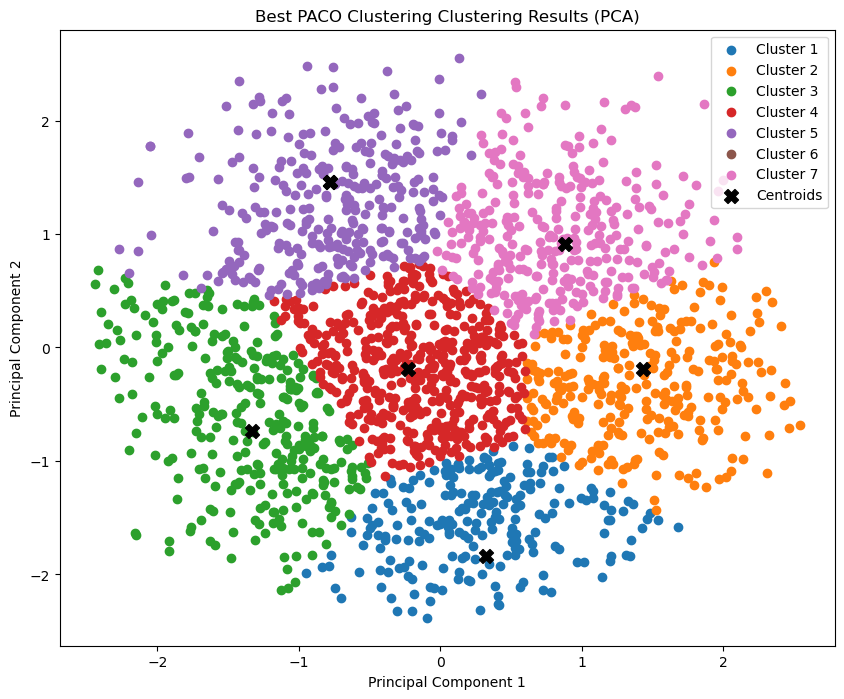

array([4, 6, 4, ..., 2, 2, 2], dtype=int64)

In [82]:
best_results = evaluate_clustering(X_scaled, best_labels, "Best PACO")
results.append(best_results)
visualize_clusters(X_scaled, best_labels, best_centroids, "Best PACO Clustering")

In [95]:
def raco_clustering(X, n_clusters, levels=3, n_ants=30, n_iterations=50, alpha=1.0, beta=2.0, evaporation_rate=0.5):
    """Recursive Ant Colony Optimization for Clustering"""

    def recursive_aco(X, n_clusters, bounds, level):
        n_samples, n_features = X.shape
        grid_size = 10

        # توليد نقاط الشبكة في النطاقات المحددة
        grid_points = [
            np.linspace(bounds[f][0], bounds[f][1], grid_size) for f in range(n_features)
        ]

        pheromone = np.ones([grid_size] * n_features)
        heuristic = np.ones([grid_size] * n_features)
        for point in X:
            idx = [np.argmin(np.abs(grid_points[f] - point[f])) for f in range(n_features)]
            heuristic[tuple(idx)] += 1
        heuristic = heuristic / np.sum(heuristic)

        best_centroids = None
        best_fitness = float('inf')

        for iteration in range(n_iterations):
            for ant in range(n_ants):
                centroids = []
                for _ in range(n_clusters):
                    prob = (pheromone ** alpha) * (heuristic ** beta)
                    prob /= np.sum(prob)
                    flat_prob = prob.flatten()
                    choice = np.random.choice(len(flat_prob), p=flat_prob)
                    idx = np.unravel_index(choice, prob.shape)
                    centroid = np.array([grid_points[f][idx[f]] for f in range(n_features)])
                    centroids.append(centroid)
                centroids = np.array(centroids)

                fitness = calculate_fitness(X, centroids)
                if fitness < best_fitness:
                    best_fitness = fitness
                    best_centroids = centroids.copy()

                # تحديث الفيرومون
                pheromone *= (1 - evaporation_rate)
                for centroid in centroids:
                    idx = [np.argmin(np.abs(grid_points[f] - centroid[f])) for f in range(n_features)]
                    pheromone[tuple(idx)] += 1.0 / (fitness + 1e-10)

        # إذا كنا في آخر مستوى، نعيد أفضل الحلول
        if level == levels:
            return best_centroids, best_fitness

        # إنشاء نطاقات أضيق حول أفضل centroids للتمرير التالي
        new_bounds = []
        margin = 0.2  # نسبة من النطاق الكلي لكل جانب
        for f in range(n_features):
            all_bounds = []
            for centroid in best_centroids:
                delta = (bounds[f][1] - bounds[f][0]) * margin
                lower = max(bounds[f][0], centroid[f] - delta)
                upper = min(bounds[f][1], centroid[f] + delta)
                all_bounds.append((lower, upper))
            # نأخذ أوسع مدى يشمل كل centroids
            lower = min(b[0] for b in all_bounds)
            upper = max(b[1] for b in all_bounds)
            new_bounds.append((lower, upper))

        # إعادة التنفيذ بشكل Recursively
        return recursive_aco(X, n_clusters, new_bounds, level + 1)

    # البداية: النطاق الكامل
    X_min, X_max = np.min(X, axis=0), np.max(X, axis=0)
    bounds = [(X_min[f], X_max[f]) for f in range(X.shape[1])]
    
    # بدء التنفيذ المتكرر
    final_centroids, _ = recursive_aco(X, n_clusters, bounds, level=1)
    final_labels = assign_clusters(X, final_centroids)
    return final_centroids, final_labels


In [104]:
from itertools import product
from tqdm import tqdm

def raco_grid_search(X, n_clusters, param_grid ,n_iterations=100):
    best_params = None
    best_fitness = float('inf')
    best_centroids = None
    best_labels = None

    all_results = []

    # إنشاء جميع التركيبات الممكنة
    keys = list(param_grid.keys())
    combinations = list(product(*param_grid.values()))

    print(f"🔍 Trying {len(combinations)} parameter combinations...\n")

    for combo in tqdm(combinations, desc="Grid Search RACO"):
        params = dict(zip(keys, combo))

        # تشغيل RACO مع هذه الإعدادات
        try:
            centroids, labels = raco_clustering(
                X,
                n_clusters,
                levels=params['levels'],
                n_ants=params['n_ants'],
                alpha=params['alpha'],
                beta=params['beta'],
                evaporation_rate=params['evaporation_rate']
            )

            # حساب Fitness (أو استخدم أي مقياس تفضله)
            fitness = calculate_fitness(X, centroids)

            all_results.append((params, fitness))

            if fitness < best_fitness:
                best_fitness = fitness
                best_params = params
                best_centroids = centroids
                best_labels = labels

        except Exception as e:
            print(f"⚠️ Failed with params {params}: {e}")

    print("\n✅ Best Parameters Found:")
    print(best_params)
    print(f"Best Fitness: {best_fitness:.4f}")

    return best_centroids, best_labels, best_params, all_results


In [106]:
param_grid = {
    'levels': [2, 3,4],
    'n_ants': [20,40,60,80,100],
    'alpha': [0.5, 1.0, 2.0,3.0],
    'beta': [1.0, 2.0, 3.0],
    'evaporation_rate': [0.3, 0.5, 0.7,1.0]
}

raco_centroids, raco_labels, raco_best_params, raco_all_results = raco_grid_search(
    X_scaled, 
    optimal_k, 
    param_grid,
    n_iterations=100
)

🔍 Trying 720 parameter combinations...



Grid Search RACO: 100%|██████████| 720/720 [2:24:55<00:00, 12.08s/it]  


✅ Best Parameters Found:
{'levels': 3, 'n_ants': 100, 'alpha': 1.0, 'beta': 1.0, 'evaporation_rate': 0.5}
Best Fitness: 850.1160



Best RACO from Grid Search Clustering Evaluation:
Silhouette Score: 0.3374
Davies-Bouldin Index: 0.8122
Calinski-Harabasz Index: 1396.5464


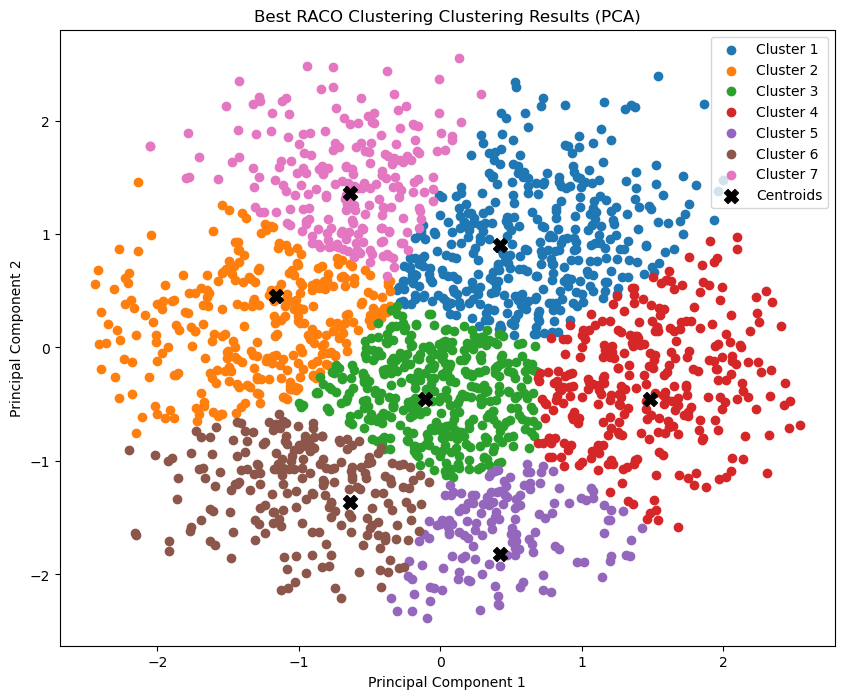

array([6, 0, 6, ..., 1, 5, 5], dtype=int64)

In [107]:
raco_results = evaluate_clustering(X_scaled, raco_labels, "Best RACO from Grid Search")
results.append(raco_results)
visualize_clusters(X_scaled, raco_labels, raco_centroids, "Best RACO Clustering")


Clustering Algorithm Comparison:
                       method  silhouette  davies_bouldin  calinski_harabasz
0                     K-means    0.360225        0.791609        1530.190374
1                    Best ACO    0.344333        0.824630        1459.361560
2                    Best ACO    0.344333        0.824630        1459.361560
3                   Best MMAS    0.354902        0.798621        1475.097489
4                    Best EAS    0.353564        0.786786        1467.255359
5                    Best RAS    0.354342        0.801637        1499.386210
6                   Best PACO    0.351345        0.855171        1420.250151
7  Best RACO from Grid Search    0.337401        0.812210        1396.546351


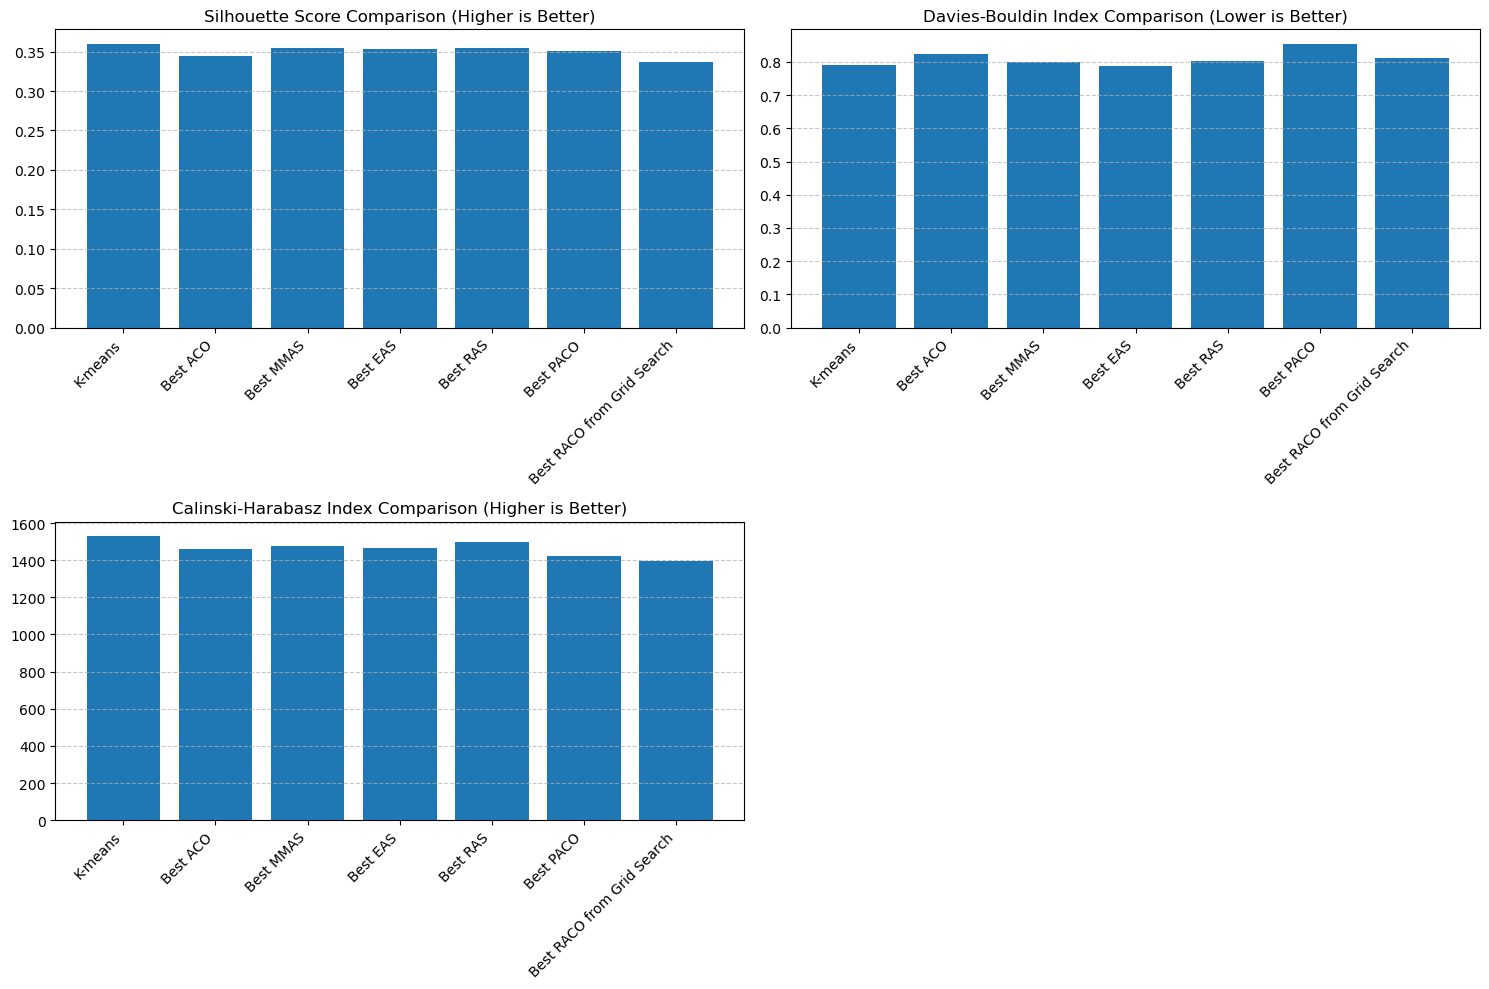

In [110]:
# 4. ALGORITHM COMPARISON AND RESULTS ANALYSIS
# -----------------------------------------

# Create DataFrame for comparison
results_df = pd.DataFrame(results)
print("\nClustering Algorithm Comparison:")
print(results_df)

# Plot comparison of metrics
plt.figure(figsize=(15, 10))

# Silhouette score (higher is better)
plt.subplot(2, 2, 1)
plt.bar(results_df['method'], results_df['silhouette'])
plt.title('Silhouette Score Comparison (Higher is Better)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Davies-Bouldin index (lower is better)
plt.subplot(2, 2, 2)
plt.bar(results_df['method'], results_df['davies_bouldin'])
plt.title('Davies-Bouldin Index Comparison (Lower is Better)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Calinski-Harabasz index (higher is better)
plt.subplot(2, 2, 3)
plt.bar(results_df['method'], results_df['calinski_harabasz'])
plt.title('Calinski-Harabasz Index Comparison (Higher is Better)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('algorithm_comparison.png')
plt.show()
plt.close()